<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [57]</a>'.</span>

In [1]:
import logging
logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')



# Config

In [2]:
import sys
TRAIN = True
TRAIN_MODEL_3 = False
IN_COLAB = 'google.colab' in sys.modules
print ('Running in colab:', IN_COLAB)

Running in colab: False


In [3]:
import os

if not IN_COLAB:
  nb_dir = os.path.split(os.getcwd())[0]
  if nb_dir not in sys.path:
      sys.path.append(nb_dir)
else:
  %tensorflow_version 1.x
  import tensorflow as tf
  print(tf.__version__)

In [4]:
if IN_COLAB:
  !pip install --upgrade pip
  !pip --version
  !pip install --no-deps --upgrade git+https://www.github.com/nemoware/analyser.git@uber-models
  !pip install -q pyjarowinkler overrides
  

In [5]:
import os
import random
import math
import json
import warnings

from os import path
from pathlib import Path
import analyser.hyperparams

training_reports_path = Path(analyser.hyperparams.__file__).parent.parent / 'training_reports/'

if not IN_COLAB:
    _work_dir_default = os.path.realpath(os.path.join(  analyser.hyperparams.__file__, '..', '..', '..', 'work'))
    work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

    if not os.path.isdir(work_dir):
        os.mkdir(work_dir)

    analyser.hyperparams.work_dir = work_dir
else:

    from google.colab import drive
    drive.mount('/content/drive')
    os.environ['GPN_WORK_DIR']='/content/drive/My Drive/GazpromOil/trainsets/uber_2'
    analyser.hyperparams.work_dir = os.environ['GPN_WORK_DIR']

print('work_dir=', analyser.hyperparams.work_dir)


assert os.path.isdir(analyser.hyperparams.work_dir)

Nemoware Analyser v23.1.27.1
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]
work_dir= /root/artem/work


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


# Imports

In [6]:
%matplotlib inline
import tensorflow as tf
print(tf.__version__)

 


import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from colab_support.renderer import *

import pickle
import numpy as np
import pandas as pd

from bson import json_util

from analyser.legal_docs import LegalDocument, make_headline_attention_vector
from analyser.headers_detector import make_predicted_headline_attention_vector, get_tokens_features
from analyser.hyperparams import models_path
from analyser.text_tools import find_top_spans
from analyser.persistence import DbJsonDoc

from trainsets.trainset_tools import TrainsetBalancer, SubjectTrainsetManager
from trainsets.retrain_contract_uber_model import UberModelTrainsetManager

from tf_support import super_contract_model
from tf_support.super_contract_model import get_base_model, semantic_map_keys_contract
from tf_support.super_contract_model import uber_detection_model_005_1_1
from tf_support.tf_subject_model import decode_subj_prediction
from tf_support.tools import KerasTrainingContext
# from tf_support.embedder_elmo import ElmoEmbedder


from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
 
from keras.models import load_model


from tensorflow import keras
import keras.backend as K
from keras.layers import Conv1D, LSTM, GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Input, Dropout, Lambda
from keras.layers import concatenate, SpatialDropout1D, ActivityRegularization
from keras.layers import MaxPooling1D, Activation, ThresholdedReLU, GaussianNoise

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential, Model

# from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences


2023-02-07 00:06:40.111881: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2.5.0


/tmp/ipykernel_1755723/3340962001.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None


[documents.py:270 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab


In [7]:
print('training_reports_path=', training_reports_path)

training_reports_path= /root/artem/analyser/training_reports


In [8]:
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')

# for device in gpu_devices:
#     print(device)
#     tf.config.experimental.set_memory_growth(device, True)

# Prepare trainset


In [9]:
if not IN_COLAB:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata = documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

In [10]:
if False:
    jdoc = get_doc('5df1f44dec85d861954efc47')
    doc = jdoc.asLegalDoc()
    doc.tokens
    

work_dir = Path(analyser.hyperparams.work_dir)
print(work_dir)

/root/artem/work


In [11]:
# xx = stats.loc[stats['user_correction_date'].notnull()]
# xx = xx[ (xx.version=='3.0.0') | (xx.version=='22.12.7')].sort_values(['score'])
# xx.to_csv('contracts_to_re-analyze.csv')
# xx

In [12]:
# xx = stats.loc[stats['user_correction_date'].notnull()]
# xx['user_correction_date'] = pd.to_datetime(xx['user_correction_date'], utc=True)


# xx['user_correction_date'] = xx['user_correction_date'].astype('datetime64[ns]')


# xx.to_datetime(df_res['DateTime'], utc=True)

# xx['user_correction_date'] = xx['user_correction_date'].dt.tz_localize(None)

# xx.sort_values(['user_correction_date'])

In [13]:
# yy = xx.sort_values(['user_correction_date'])[xx.version!='22.12.7'][xx.source=='db'].sort_values(['score'])
# yy

In [14]:
# stats['user_correction_date'] = stats['user_correction_date'].dt.tz_localize(None)
# stats.sort_values(['user_correction_date'])

In [15]:
# yy.to_csv('contracts_to_review.csv')

In [16]:
umtm = UberModelTrainsetManager (work_dir, reports_dir=training_reports_path)

umtm.load_contract_trainset_meta() # 'contract_trainset_meta.csv'
stats = umtm.stats
stats

source                          checksum    version  \
_id                                                                            
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1      1.6.5   
5edbc62eda3678279fbcadf3   file  027a7c30f74ff8ffe684378e9883dd8e      2.0.2   
5ded4e284ddc27bcf92dd6ce   file  9a44591c17d2b8f34dc8f1c3600c8c3a     1.11.2   
63ce49f8e83d1ee490f3f21c     db  25d924fc09b7291d964f464f9c3ec8c3  23.1.27.1   
63908ca4a1bded13e629f2eb     db  3bc04887446d02692e886db2545bba61    22.12.7   
...                         ...                               ...        ...   
63c506bbe2456d59975e10d3     db  874cd51371532aced3062000ca3f5334   23.01.04   
6380858b6a07f3e980b2c4c3     db  f9f2ddea91cdfe00b15e149fcf682ed8      3.0.0   
63ce4b0be83d1ee490f4009d     db  a35591663822c05db4729b91ed3a9276   23.01.23   
63c506d5e2456d59975e1389     db  2628dbfa46813bc351104e1ebdc6d6a2   23.01.04   
63c506ece2456d59975e15ad     db  5c16bf00da66d39e72a08d9838b1f501   23.01.04   

                                         export_date      len  \
_id                                                             
5ec2b8da665f7603e03b1255  2023-02-06 15:35:23.992744   5840.0   
5edbc62eda3678279fbcadf3  2023-02-06 15:35:07.348450   1370.0   
5ded4e284ddc27bcf92dd6ce  2023-02-06 15:35:03.765185    460.0   
63ce49f8e83d1ee490f3f21c  2023-02-03 16:19:06.576376   8530.0   
63908ca4a1bded13e629f2eb  2023-01-31 18:38:08.500901  13410.0   
...                                              ...      ...   
63c506bbe2456d59975e10d3  2023-01-31 21:42:32.301540   6540.0   
6380858b6a07f3e980b2c4c3  2023-01-31 18:36:12.057993  10650.0   
63ce4b0be83d1ee490f4009d  2023-01-31 21:43:37.191817  11690.0   
63c506d5e2456d59975e1389  2023-01-31 21:42:26.523639   2170.0   
63c506ece2456d59975e15ad  2023-01-31 21:42:26.812111   1230.0   

                                             analyze_date         value  \
_id                                                                       
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  2.523632e+07   
5edbc62eda3678279fbcadf3 2020-07-18 20:24:58.934000+00:00  2.400000e+04   
5ded4e284ddc27bcf92dd6ce 2020-06-12 21:09:19.574000+00:00  5.900000e+05   
63ce49f8e83d1ee490f3f21c 2023-01-28 09:34:50.691000+00:00  3.000000e+09   
63908ca4a1bded13e629f2eb 2022-12-08 13:59:29.898000+00:00  2.000000e+10   
...                                                   ...           ...   
63c506bbe2456d59975e10d3 2023-01-16 12:51:04.442000+00:00           NaN   
6380858b6a07f3e980b2c4c3 2022-11-25 19:27:25.157000+00:00           NaN   
63ce4b0be83d1ee490f4009d 2023-01-26 07:15:10.062000+00:00           NaN   
63c506d5e2456d59975e1389 2023-01-16 11:21:48.816000+00:00           NaN   
63c506ece2456d59975e15ad 2023-01-16 11:26:04.804000+00:00           NaN   

                          value_log1p  value_span currency  ... subj_len  \
_id                                                         ...            
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL  ...     79.0   
5edbc62eda3678279fbcadf3    10.085851       747.0      RUB  ...    106.0   
5ded4e284ddc27bcf92dd6ce    13.287880       150.0      RUB  ...     30.0   
63ce49f8e83d1ee490f3f21c    21.821878       337.0      RUB  ...     53.0   
63908ca4a1bded13e629f2eb    23.718998      2572.0      RUB  ...     84.0   
...                               ...         ...      ...  ...      ...   
63c506bbe2456d59975e10d3          NaN         NaN      NaN  ...     98.0   
6380858b6a07f3e980b2c4c3          NaN         NaN   рублей  ...     42.0   
63ce4b0be83d1ee490f4009d          NaN         NaN      NaN  ...    188.0   
63c506d5e2456d59975e1389          NaN         NaN      NaN  ...     34.0   
63c506ece2456d59975e15ad          NaN         NaN      NaN  ...     50.0   

                         headers  \
_id                                
5ec2b8da665f7603e03b1255     4.0   
5edbc62eda3678279fbcadf3    10.0   
5ded4e284ddc27bcf92dd6ce     

In [17]:
# stats[ ['org-1-alias', 'org-2-alias'] ]

user_dataset = stats[ stats['unseen']==False]
len(user_dataset)


1212

In [18]:
print(len(stats))

2706


In [19]:
user_dataset[user_dataset.subj_len>=150]

source                          checksum  version  \
_id                                                                          
6391b4771864c6df4d29f332     db  22f701119d81787cd423f79f0f9fd9db  22.12.7   
63908ca4a1bded13e629f2e4     db  665a638dc4f2c42ce670679ca76cff77  22.12.6   
62838b2e4d1bfe5e5b297ddb     db  c81664bbc202b2a143fe57dfcb950348    3.0.0   
5fb399dd39d5e82e90818477     db  44d1c22fb92ce75663dc046c184df359    2.0.5   
62d149464ae369b4976e31f3     db  31b2973970123953ebc9074a4dfaa421    3.0.0   
6380859e6a07f3e980b2c5c4     db  5d8d2a674adffa2c30fa1254e1047e40    3.0.0   
638085646a07f3e980b2c0e5     db  43519987735b5d2180168facc4404545    3.0.0   
6380855c6a07f3e980b2c061     db  9756e819859af5192b5e44806f173d8c  22.12.7   
6380857e6a07f3e980b2c343     db  24195a650ec51184b0b507d73fd67b7a    3.0.0   
638085686a07f3e980b2c124     db  0330bc8b29d42453fb0350e80da94743    3.0.0   
638085976a07f3e980b2c561     db  ec297f3094591fbad5418b2167357d4d    3.0.0   
638085ac6a07f3e980b2c733     db  7440524bbf921c898bfc35d1885bda2f    3.0.0   
638085a36a07f3e980b2c623     db  85bd0228e9e167ca8a7eb78c0ba8c305    3.0.0   
5fb3d7a178df3635f5441d6a     db  5e410fc2e9e1068575cf860ad7a4a632    2.0.5   
5fe4821fb770574a00555741     db  8dceb00aaefe9c38b75de9d170b212f5   2.3.13   
62c54895e599c73b751b7974     db  9756e819859af5192b5e44806f173d8c    3.0.0   
638085976a07f3e980b2c575     db  d7756a8860dee9f6d2c4e825566aaa6c    3.0.0   

                                         export_date      len  \
_id                                                             
6391b4771864c6df4d29f332  2023-02-06 15:35:27.174677   1990.0   
63908ca4a1bded13e629f2e4  2023-02-06 15:35:27.119189   2020.0   
62838b2e4d1bfe5e5b297ddb  2023-01-31 18:32:43.216593  25010.0   
5fb399dd39d5e82e90818477  2023-02-06 15:35:24.171772   5210.0   
62d149464ae369b4976e31f3  2023-02-06 15:35:26.079817   2050.0   
6380859e6a07f3e980b2c5c4  2023-01-31 18:32:52.073085   4180.0   
638085646a07f3e980b2c0e5  2023-01-31 18:32:45.290596  28200.0   
6380855c6a07f3e980b2c061  2023-02-06 15:35:27.164485   1950.0   
6380857e6a07f3e980b2c343  2023-01-31 18:32:46.337373   5020.0   
638085686a07f3e980b2c124  2023-01-31 18:32:45.969271   2970.0   
638085976a07f3e980b2c561  2023-01-31 18:32:48.530026   4480.0   
638085ac6a07f3e980b2c733  2023-01-31 18:32:48.969831   1980.0   
638085a36a07f3e980b2c623  2023-01-31 18:32:48.780383   4090.0   
5fb3d7a178df3635f5441d6a  2023-01-31 18:36:01.135666   2030.0   
5fe4821fb770574a00555741  2023-01-31 18:36:06.228625   2030.0   
62c54895e599c73b751b7974  2023-02-06 15:35:26.073414   1950.0   
638085976a07f3e980b2c575  2023-01-31 18:32:48.568796   6460.0   

                                             analyze_date         value  \
_id                                                                       
6391b4771864c6df4d29f332 2022-12-08 22:25:50.608000+00:00  1.000000e+11   
63908ca4a1bded13e629f2e4 2022-12-07 15:55:04.590000+00:00  1.500000e+10   
62838b2e4d1bfe5e5b297ddb 2022-05-17 14:47:43.209000+00:00  3.050000e+09   
5fb399dd39d5e82e90818477 2020-11-17 09:58:23.635000+00:00  4.338600e+05   
62d149464ae369b4976e31f3 2022-07-15 14:09:08.607000+00:00  1.000000e+04   
6380859e6a07f3e980b2c5c4 2022-11-25 20:00:26.236000+00:00  1.705600e+06   
638085646a07f3e980b2c0e5 2022-11-25 12:30:29.763000+00:00  3.147910e+05   
6380855c6a07f3e980b2c061 2022-12-08 16:02:19.987000+00:00  5.000000e+02   
6380857e6a07f3e980b2c343 2022-11-25 12:31:32.455000+00:00  2.923300e+07   
638085686a07f3e980b2c124 2022-11-25 12:30:38.681000+00:00  5.897600e+05   
638085976a07f3e980b2c561 2022-11-25 12:33:11.663000+00:00  4.949780e+05   
638085ac6a07f3e980b2c733 2022-11-25 12:34:24.346000+00:00  1.230600e+05   
638085a36a07f3e980b2c623 2022-11-25 12:34:06.806000+00:00  5.085000e+04   
5fb3d7a178df3635f5441d6a 2020-11-17 15:51:04.944000+00:00           NaN   
5fe4821fb770574a00555741 2020-12-24 17:44:47.597000+00:00           NaN   
62c54895e599c73b751b7974 2022-0

# Weights: вычисление весов samples  

чтобы всех запутать, 
 - вес пропорционален логорифму цены контракта (чтобы было меньше ошибок в контрактах на большие суммы)
 - more weight for user-corrected datapoints
 - normalize weights, so the sum == Number of samples

In [20]:
errors_file = Path(analyser.__file__).parent.parent /'trainsets' / 'errors.csv'
errors_file
errors_df = pd.read_csv(errors_file, index_col=0)
errors_df

дата редактирования  \
6152e3af8558145da68d8790  2023-02-01 14:53:58.672   
6152e3798558145da68d8788  2021-09-30 08:13:06.705   
6285f525f098f73e14297f93  2022-10-25 11:16:59.890   
615ac8b28f3b0514f3f423f2  2021-10-04 09:27:25.636   
615ac8cf8f3b0514f3f423f8  2021-10-04 09:30:37.752   
...                                           ...   
638085656a07f3e980b2c0f3  2022-11-29 11:44:32.030   
6380855e6a07f3e980b2c0a4  2022-11-29 10:28:08.643   
5fca2aad9083b679224c7606  2020-12-09 15:05:30.896   
6380855d6a07f3e980b2c07b  2022-11-29 14:09:37.839   
6393256f1002115a6029f3f0  2023-02-04 08:05:50.469   

                                                                       link  \
6152e3af8558145da68d8790  https://gpn-audit.nemosoft.ru/#/audit/edit/615...   
6152e3798558145da68d8788  https://gpn-audit.nemosoft.ru/#/audit/edit/615...   
6285f525f098f73e14297f93  https://gpn-audit.nemosoft.ru/#/audit/edit/628...   
615ac8b28f3b0514f3f423f2  https://gpn-audit.nemosoft.ru/#/audit/edit/615...   
615ac8cf8f3b0514f3f423f8  https://gpn-audit.nemosoft.ru/#/audit/edit/615...   
...                                                                     ...   
638085656a07f3e980b2c0f3  https://gpn-audit.nemosoft.ru/#/audit/edit/638...   
6380855e6a07f3e980b2c0a4  https://gpn-audit.nemosoft.ru/#/audit/edit/638...   
5fca2aad9083b679224c7606  https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...   
6380855d6a07f3e980b2c07b  https://gpn-audit.nemosoft.ru/#/audit/edit/638...   
6393256f1002115a6029f3f0  https://gpn-audit.nemosoft.ru/#/audit/edit/639...   

                                                                      error  \
6152e3af8558145da68d8790     налог не указан;\nНомер не является номером;\n   
6152e3798558145da68d8788                                                NaN   
6285f525f098f73e14297f93  Наименование 2: кавычка не закрыта;\nНаименова...   
615ac8b28f3b0514f3f423f2                                                NaN   
615ac8cf8f3b0514f3f423f8                       Номер не является номером;\n   
...                                                                     ...   
638085656a07f3e980b2c0f3                                                NaN   
6380855e6a07f3e980b2c0a4                                                NaN   
5fca2aad9083b679224c7606                                                NaN   
6380855d6a07f3e980b2c07b                                                NaN   
6393256f1002115a6029f3f0                                                NaN   

                                                              error missing  \
6152e3af8558145da68d8790  Наименование 2 отсутсвует;\nФорма собственност...   
6152e3798558145da68d8788  Псевдоним 2 отсутсвует;\nНаименование 2 отсутс...   
6285f525f098f73e14297f93  Форма собственности 2 отсутсвует;\nФорма собст...   
615ac8b28f3b0514f3f423f2  Псевдоним 2 отсутсвует;\nФорма собственности 2...   
615ac8cf8f3b0514f3f423f8  Псевдоним 2 отсутсвует;\nПсевдоним 1 отсутсвуе...   
...                                                                     ...   
638085656a07f3e980b2c0f3                                                NaN   
6380855e6a07f3e980b2c0a4                                                NaN   
5fca2aad9083b679224c7606                                                NaN   
6380855d6a07f3e980b2c07b                                                NaN   
6393256f1002115a6029f3f0                                                NaN   

                          errors count  subject len     subject kind  \
6152e3af8558145da68d8790           6.0         56.0          Service   
6152e3798558145da68d8788           6.0         42.0          Service   
6285f525f098f73e14297f93           5.0          0.0              NaN   
615ac8b28f3b0514f3f423f2           5.0         48.0          Service   
615ac8cf8f3b0514f3f423f8           5.0         37.0          Service   
...                                ...          ...              ...   
638085656a07f3e980b2c0f3           0.0    

In [21]:
from trainsets.trainset_tools import get_feature_log_weights
stats = umtm.stats
stats = stats[stats.documentType != 'ANNEX']
stats = stats[stats.documentType != 'undefined']

print(len(stats))
get_feature_log_weights(stats, 'documentType')

2706


CONTRACT                   0.644120
SUPPLEMENTARY_AGREEMENT    1.094908
AGREEMENT                  1.260972
Name: documentType, dtype: float64

In [22]:
# from trainsets.trainset_tools import get_feature_log_weights
# _w=get_feature_log_weights(umtm.stats, 'subject')
# _w*_w*_w

In [23]:
%time

subject_weights = get_feature_log_weights(stats, 'subject')
subject_weights = subject_weights * subject_weights * subject_weights

for i, row in stats.iterrows():
  subj_name = row['subject']

  #error weight
  error_weight = 1.0 
  if i in errors_df.index:
      error_weight = 1.0 + errors_df.at[i, 'errors count']


  sample_weight = 0.5 
  if not pd.isna(row['user_correction_date']):  # more weight for user-corrected datapoints
    sample_weight = 5.0   # TODO: must be estimated anyhow smartly    

  value_weight = 1.0
  if not pd.isna(row['value_log1p']):
    # чтобы всех запутать, вес пропорционален логорифму цены контракта
    # (чтобы было меньше ошибок в контрактах на большие суммы)
    value_weight = 1.0 + row['value_log1p']

  sample_weight *=  value_weight 
  subject_weight =  subject_weights[subj_name] 
    
  sample_weight /= error_weight  

  stats.at[i, 'subject_weight'] = subject_weight + random.random()
  stats.at[i, 'sample_weight'] = sample_weight + random.random()

# normalize weights, so the sum == Number of samples
# stats.sample_weight /= stats.sample_weight.mean()
# stats.subject_weight /= stats.subject_weight.mean()

print(stats.sample_weight.mean())
print(stats.subject_weight.mean())
print(stats.sample_weight.min())
print(stats.subject_weight.min())
print(stats.sample_weight.max())
print(stats.subject_weight.max())

stats.to_csv( work_dir / 'contract_trainset_meta.csv', index=True)

# stats

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


16.406036204169276
0.8354399495335348
0.5007651671479619
0.12290510168832722
150.51426523996147
5.498875851118168


In [24]:
from tf_support.super_contract_model import make_xyw


# Validating training set

In [25]:
%time


from tf_support.super_contract_model import  validate_datapoint

stats['valid'] = True
stats['error'] = ''

for i in stats.index:
  
  try:
    validate_datapoint(str(i), stats)

  except Exception as e:
    logger.error(e)

    stats.at[i, 'valid'] = False
    stats.at[i, 'error'] = str(e)
    
stats

 


umtm.stats = umtm.stats[  pd.isna(umtm.stats.value_span) + (umtm.stats.value_span < 10000) ] #remove big docs from TS
stats_valid = stats[stats['valid']]

del stats
print(len(stats_valid))
stats = stats_valid
umtm.stats = stats_valid

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.29 µs


2706


/root/artem/env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


In [26]:

len(stats_valid)

2706

In [27]:
print(stats.sample_weight.mean())
print(stats.subject_weight.mean())

stats.sample_weight /= stats.sample_weight.mean()
stats.subject_weight /= stats.subject_weight.mean()





16.406036204169276
0.8354399495335348


In [28]:
print(stats.subject_weight.mean())
print(stats.subject_weight.min())

print('\n\nsample_weight')
print('MIN\t', stats.sample_weight.min())
print('MAX\t', stats.sample_weight.max())
print('MEAN\t', stats.sample_weight.mean())

1.0000000000000002
0.14711422617143324


sample_weight
MIN	 0.030523226994994816
MAX	 9.174322387616773
MEAN	 1.0


/root/artem/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


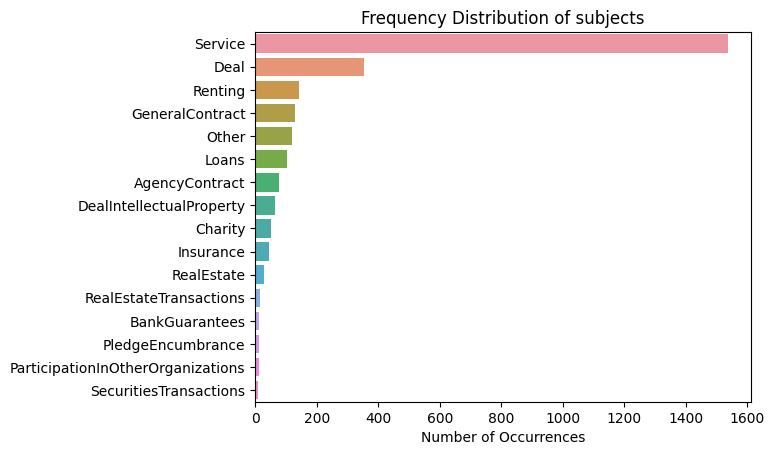


min 8
max 1536
total 2706


In [29]:
%matplotlib inline

subj_count = stats_valid['subject'].value_counts()

#plot distribution---------------------
sns.barplot(subj_count.values, subj_count.index)
plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


print ('\nmin', min (subj_count.values))
print ('max', max (subj_count.values))
print ('total', sum (subj_count.values))

In [30]:
from sklearn.utils import class_weight
from trainsets.trainset_tools import get_feature_log_weights

_classes = stats_valid['subject'].unique().tolist()

print(f'classes: {_classes}')

# class_weights = class_weight.compute_class_weight('balanced', _classes, umtm.stats['subject'])
# class_weights = dict(zip(_classes, class_weights))


class_weights = get_feature_log_weights(stats_valid, 'subject')
class_weights

classes: ['Service', 'AgencyContract', 'Charity', 'Loans', 'BankGuarantees', 'SecuritiesTransactions', 'Renting', 'PledgeEncumbrance', 'DealIntellectualProperty', 'Deal', 'GeneralContract', 'Insurance', 'ParticipationInOtherOrganizations', 'RealEstateTransactions', 'RealEstate', 'Other']


Service                              0.496166
Deal                                 0.619694
Renting                              0.734622
GeneralContract                      0.749136
Other                                0.761784
Loans                                0.785517
AgencyContract                       0.835644
DealIntellectualProperty             0.868964
Charity                              0.925946
Insurance                            0.956391
RealEstate                           1.060184
RealEstateTransactions               1.284993
BankGuarantees                       1.379530
PledgeEncumbrance                    1.419388
ParticipationInOtherOrganizations    1.465109
SecuritiesTransactions               1.656935
Name: subject, dtype: float64

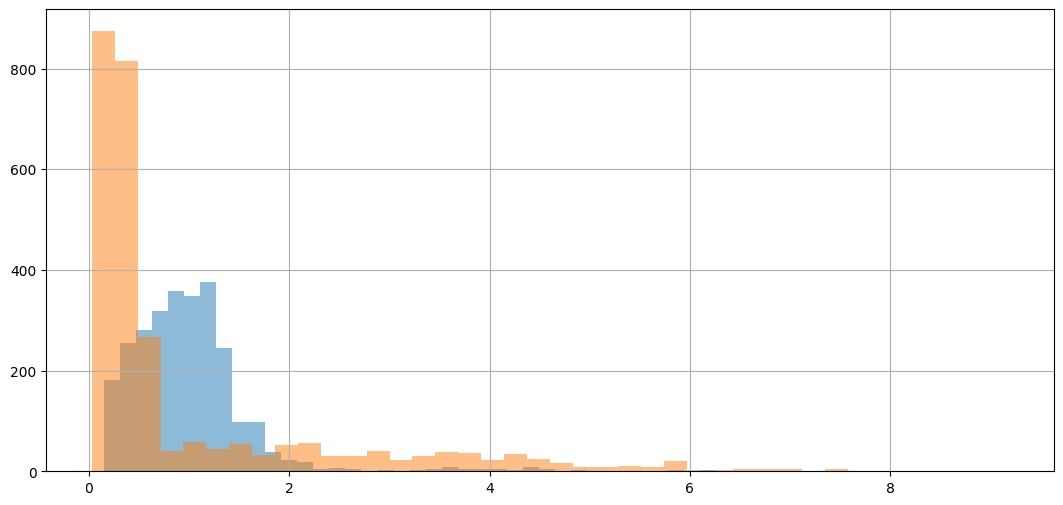

In [31]:
from trainsets.trainset_tools import get_feature_log_weights
 

plt.figure(figsize=(13, 6))

stats_valid['subject_weight'].hist(bins=40, alpha=0.5)
stats_valid['sample_weight'].hist(bins=40, alpha=0.5)

plt.xscale('linear') # log?
plt.show()

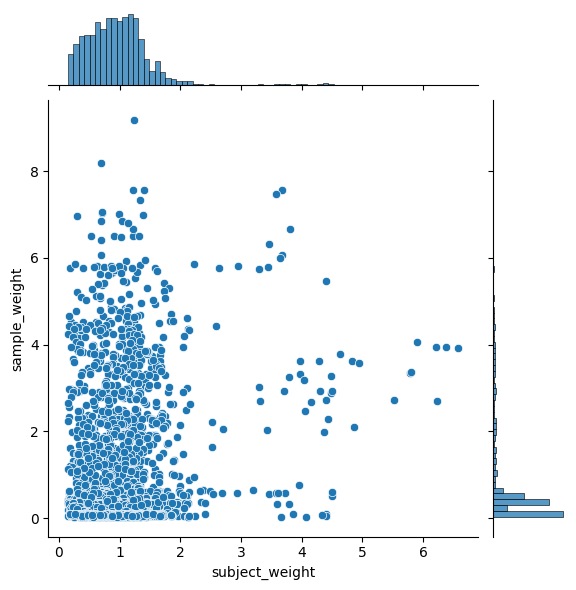

In [32]:
sns.jointplot(x="subject_weight", y="sample_weight", data=stats_valid)
plt.show()

# look into trainset (take a sample)

SAMPLE_DOC_ID 5fe34f62b770574a005553be
semantic map shape is: (759, 30)


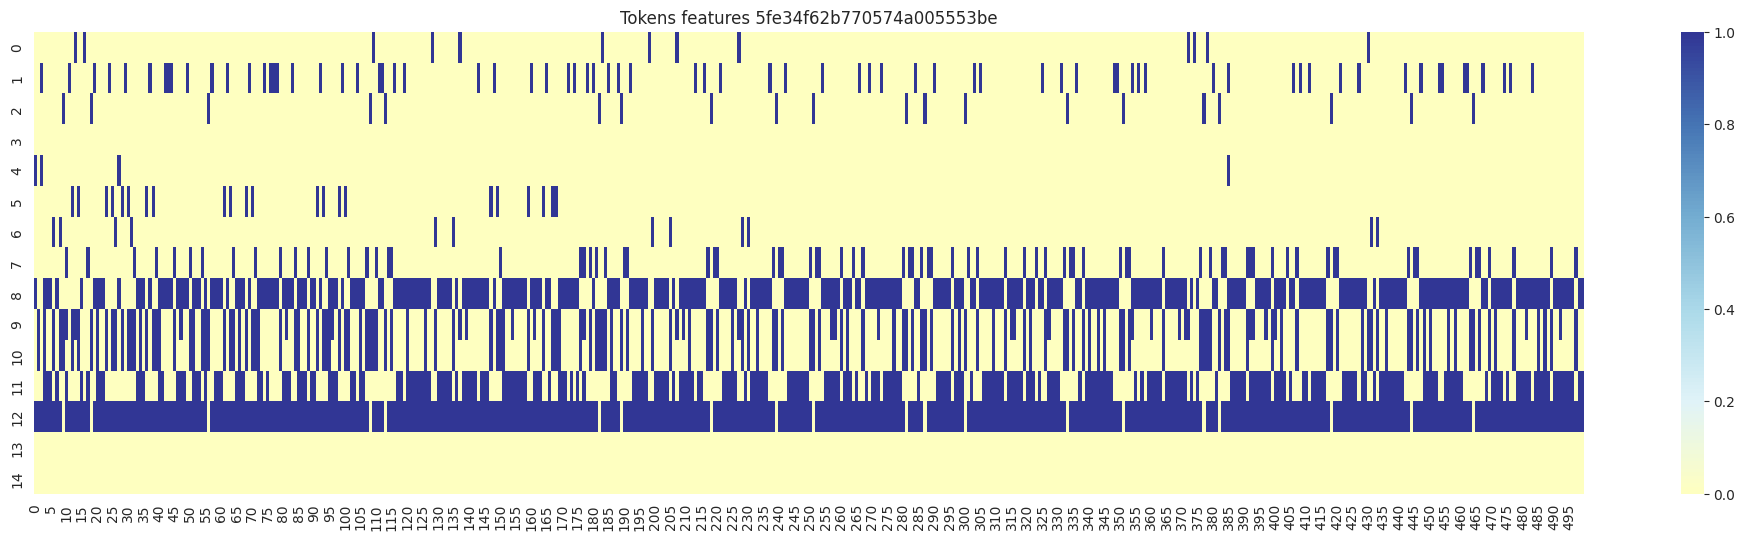

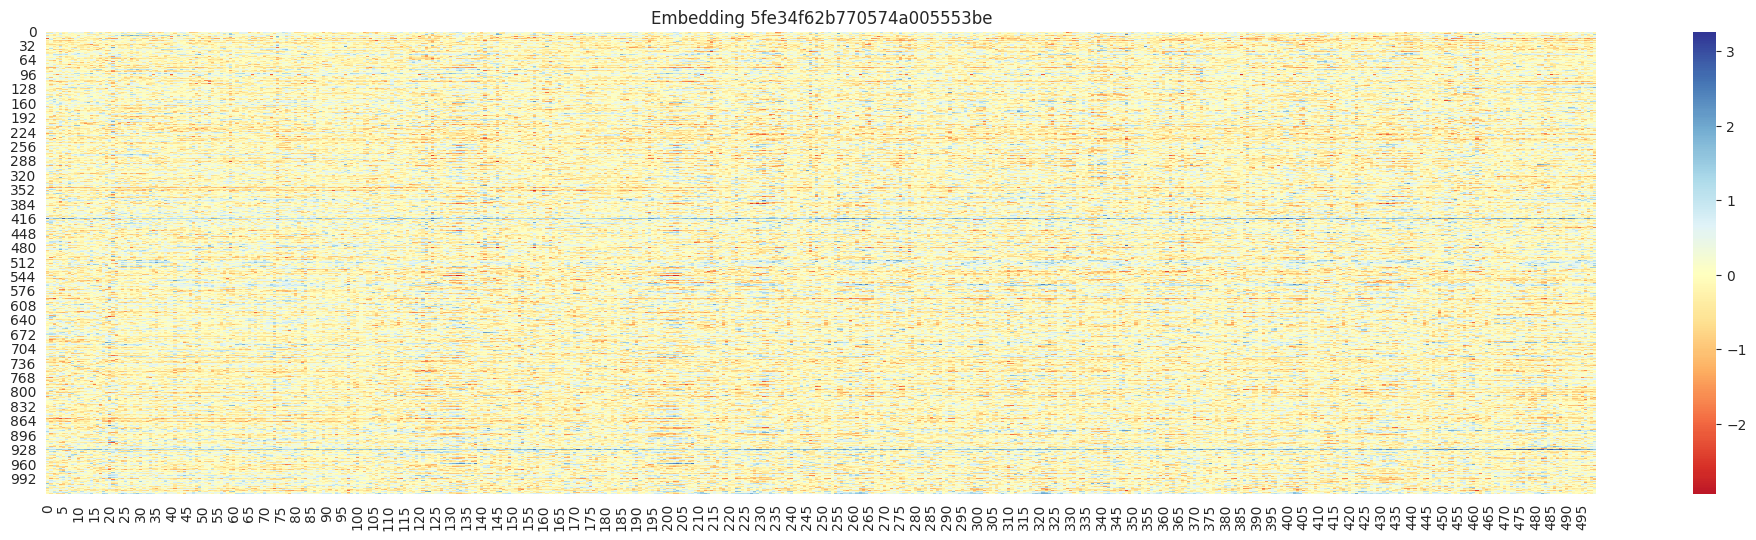

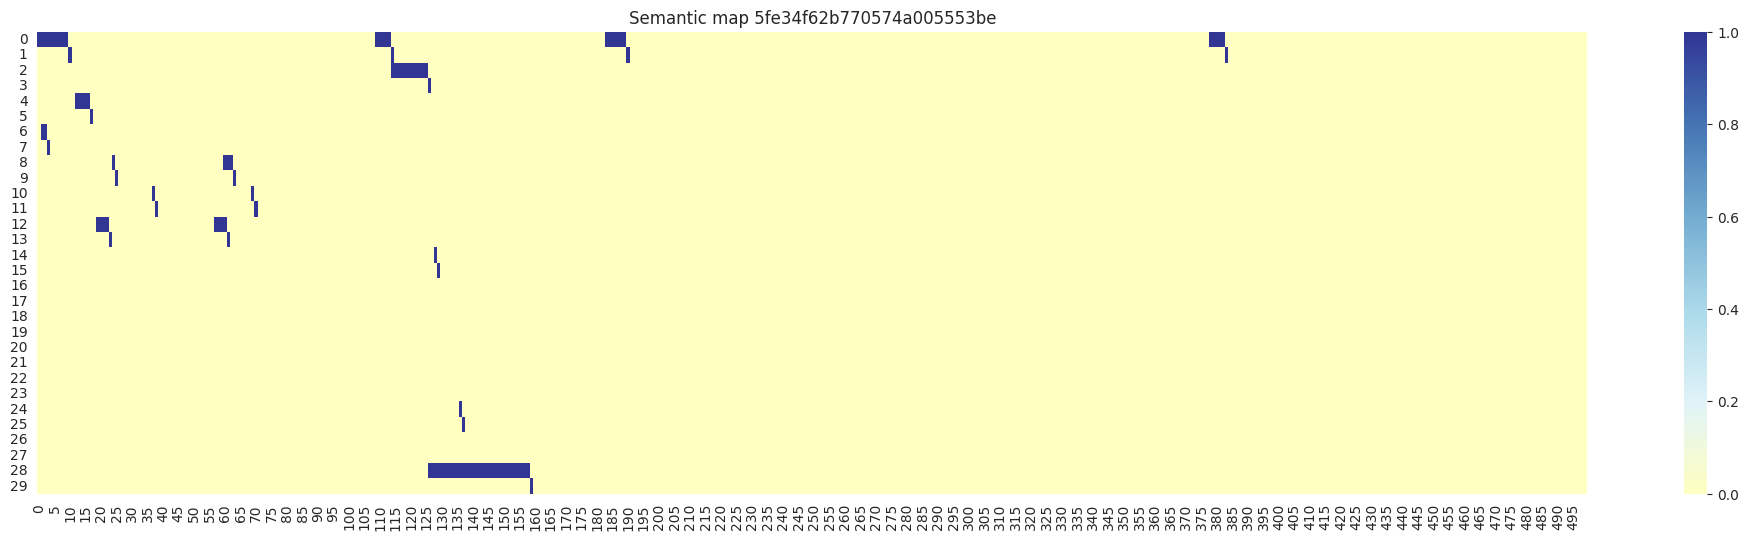

In [33]:
%matplotlib inline
# umtm.calculate_samples_weights()
SAMPLE_DOC_ID = '5fe34f62b770574a005553be' #stats_valid.index[1]

print('SAMPLE_DOC_ID', SAMPLE_DOC_ID)
(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = make_xyw(SAMPLE_DOC_ID, stats)
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
plot_embedding(tok_f[:_crop], title=f'Tokens features {SAMPLE_DOC_ID}') 
plot_embedding(emb[:_crop], title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[:_crop], title=f'Semantic map {SAMPLE_DOC_ID}')



# Batch generator & TODOs 🙏


- [X] TODO: add outliers to the trainset ?
- [ ] TODO: try sparse_categorical_entropy instead of one-hot encodings
- [ ] TODO: model 5.2, 5.1: bipolar concat layer is wrong because we concatenate thongs of different magnitudes. Add a Sigmoid activation layer
- [ ] TODO: chechk what is better: to pad with zeros or to pad with means
- [X] TODO: add weights to samples
- [ ] TODO: sum semantic map alongside vertical axis, and mutiply it (as a mask) by the subject detection seq
- [ ] TODO: introduce individual per tag threshosholds, also, the current 0.3 threshold is strange.

3
semantic map shape is: (14, 464, 30)


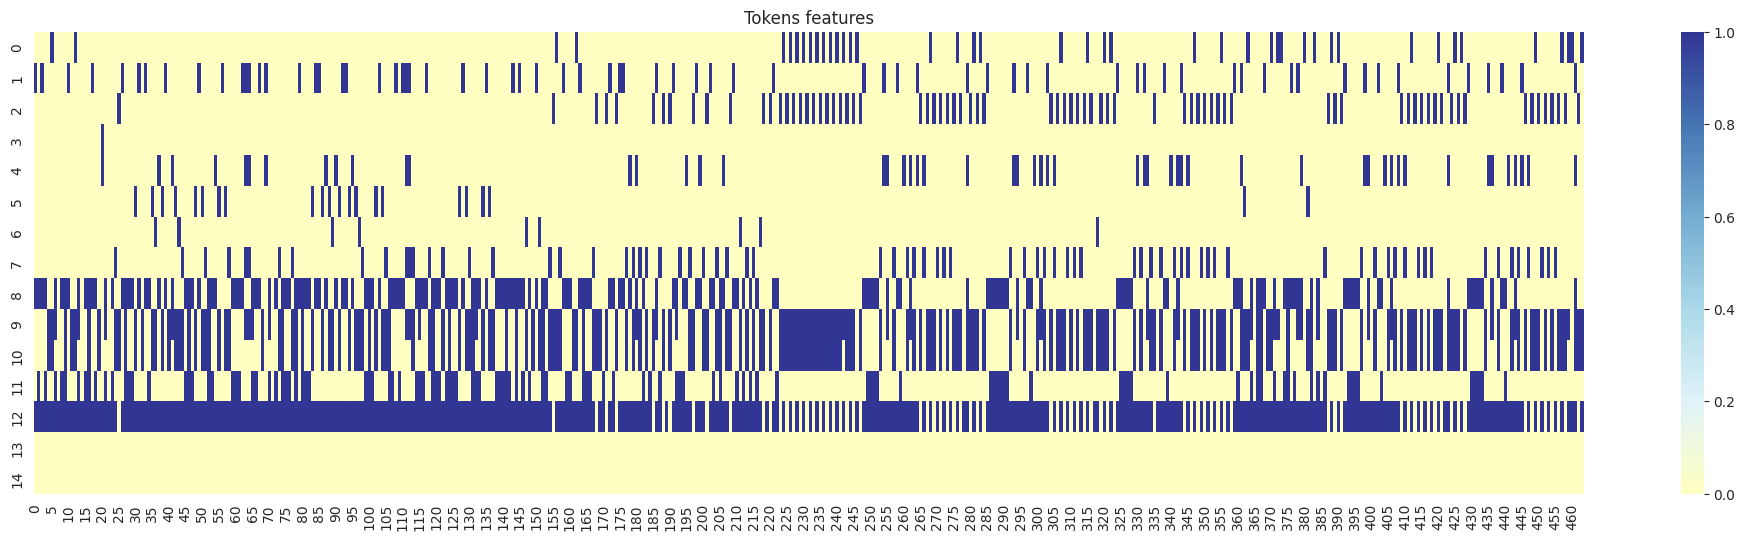

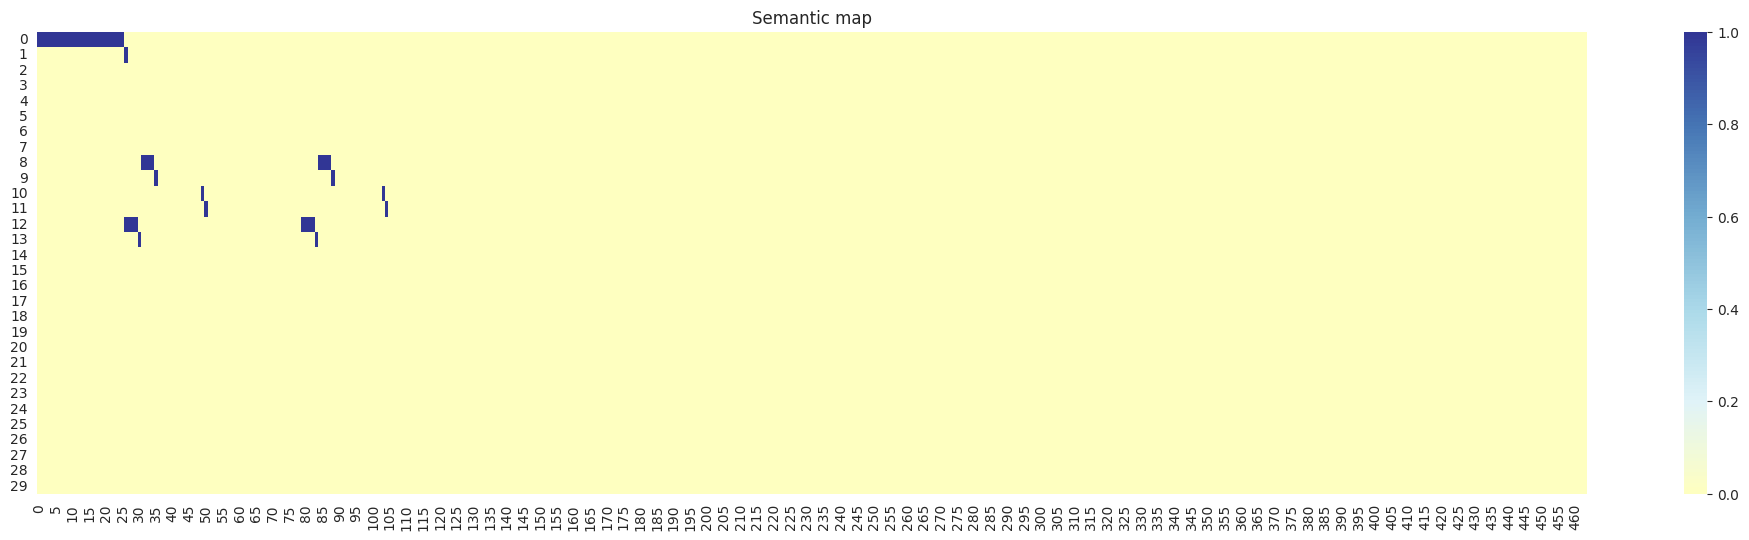

In [34]:
import numpy as np
import random
import pandas as pd

def make_generator(self, indices: [int], batch_size: int, augment_samples=False):
  np.random.seed(43)

  while True:
    # next batch
    batch_indices = np.random.choice(a=indices, size=batch_size)

    max_len = 128 * 12
    start_from = 0

    if augment_samples:
      max_len = random.randint(300, 1400)

    batch_input_emb = []
    batch_input_token_f = []
    batch_output_sm = []
    batch_output_subj = []

    weights = []
    weights_subj = []

    # Read in each input, perform preprocessing and get labels
    for doc_id in batch_indices:

      dp = make_xyw(doc_id, stats)
      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
        
#       print(dp)
    
      subject_weight_K = 1.0
      if augment_samples:
        start_from = 0

        row = stats_valid.loc[doc_id]
        if random.random() < 0.4:  # 40% of samples
          segment_center = random.randint(0, len(emb) - 1)  ##select random token as a center
          if not pd.isna(row['value_span']) and random.random() < 0.7:
            segment_center = int(row['value_span'])

          _off = random.randint(max_len // 4, max_len // 2)
          start_from = segment_center - _off
          if start_from < 0:
            start_from = 0
          subject_weight_K = 0.1  # lower subject weight because there mighе be no information about subject around doc. value
        
      dp = self.trim_maxlen(dp, start_from, max_len)
      
      # TODO: find samples maxlen

      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
#       print((sample_weight, subject_weight))
      subject_weight *= subject_weight_K

      batch_input_emb.append(emb)
      batch_input_token_f.append(tok_f)

      batch_output_sm.append(sm)
      batch_output_subj.append(subj)

      if np.isnan(sample_weight):
        raise ValueError()

      if np.isnan(subject_weight):
        raise ValueError()
      
      weights.append(sample_weight)
      weights_subj.append(subject_weight)
      # end if emb
    # end for loop

    # Returns a tuple of (input, output, weights) to feed the network
#     print('batch_output_subj', len(batch_output_subj))
#     print('batch_output_sm', len(batch_output_subj))

    yield ([np.array(batch_input_emb), np.array(batch_input_token_f)],
           [np.array(batch_output_sm), np.array(batch_output_subj)],
           [np.array(weights), np.array(weights_subj)])
    

    
_train, _test = train_test_split(stats_valid, test_size=0.10, stratify=stats_valid[['subject']])

train_indices = list(_train.index)
test_indices = list(_test.index)

    
####---test
_gen = make_generator(umtm, train_indices, 14, augment_samples=True)

sample = next(_gen)
print(len(sample))
del _gen
 


(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = sample
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
plot_embedding(tok_f[0][:_crop], title=f'Tokens features') 
# plot_embedding(emb[:_crop],   title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[0][:_crop],    title=f'Semantic map')

In [35]:
SAMPLE_DOC_ID

'5fe34f62b770574a005553be'

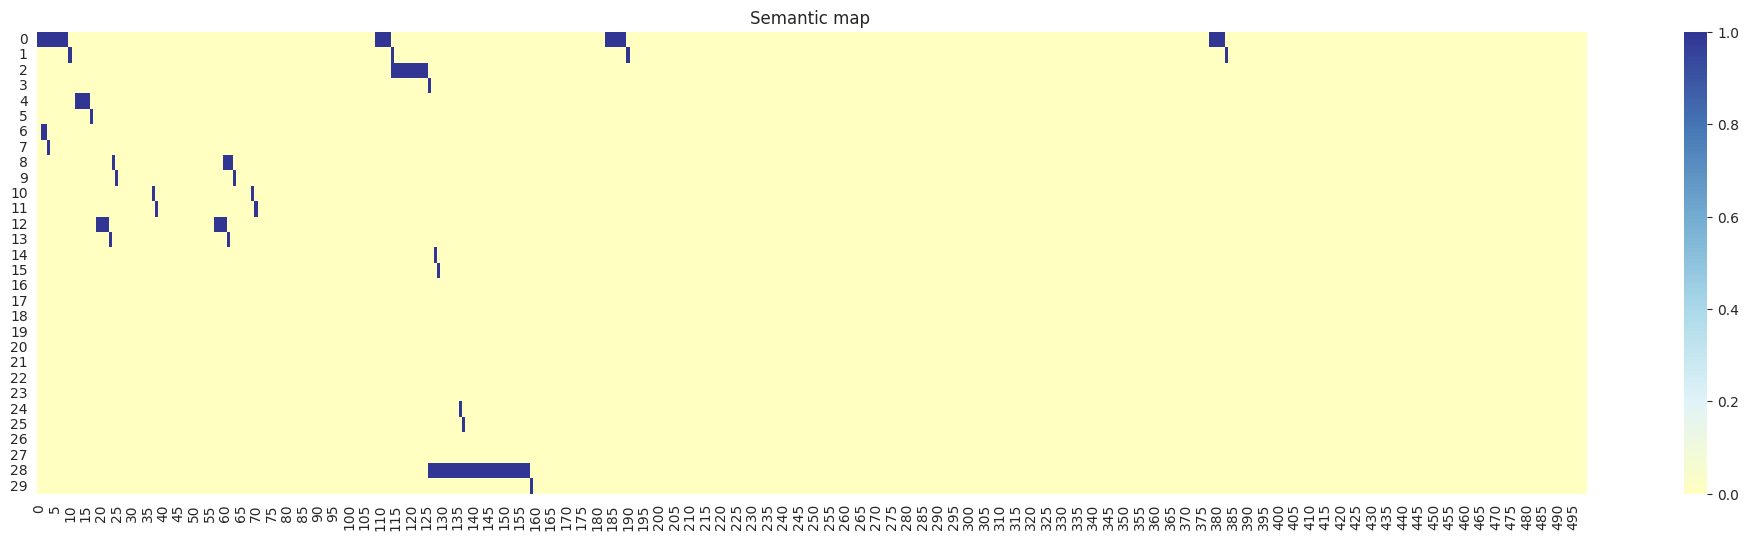

In [36]:
dp = make_xyw('5fe34f62b770574a005553be', stats_valid)

(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

plot_embedding(sm[:500],    title=f'Semantic map ')

train_indices[0]: 5fbbbd1da2b4551c06107a7d
test_indices[0]: 63c506d5e2456d59975e1389


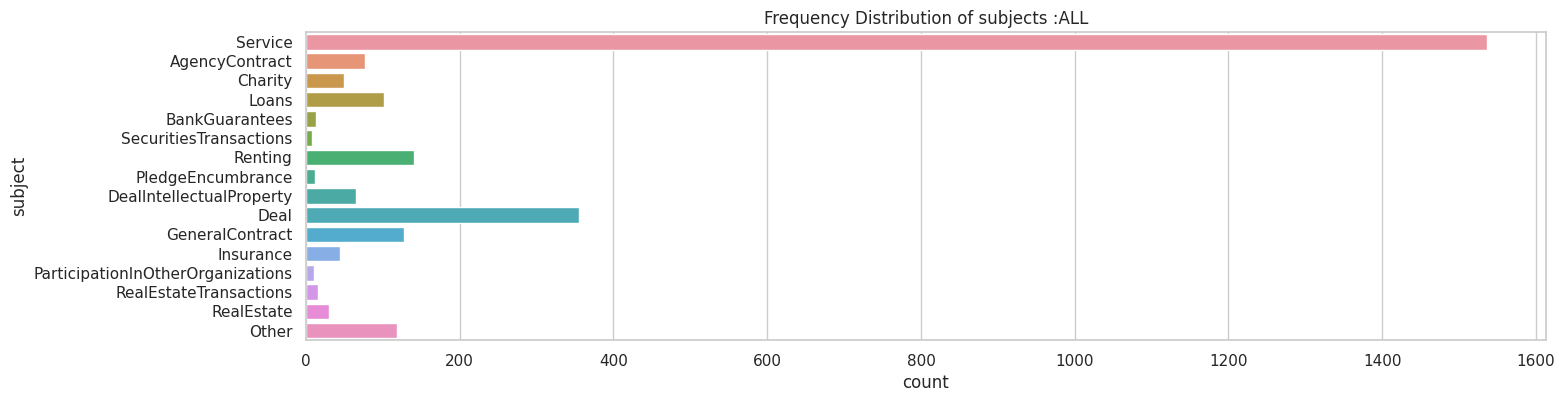

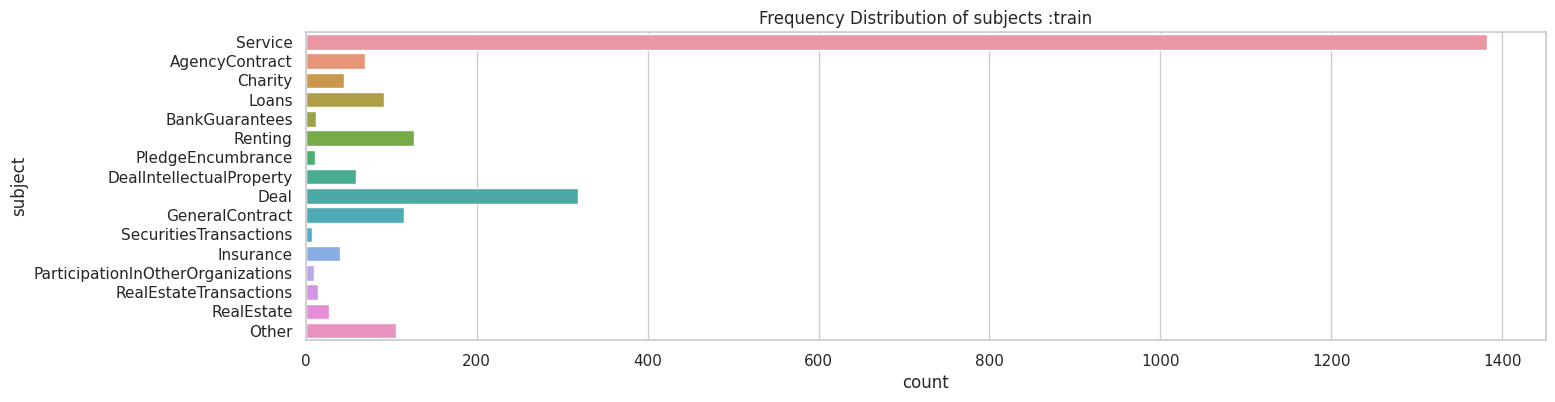

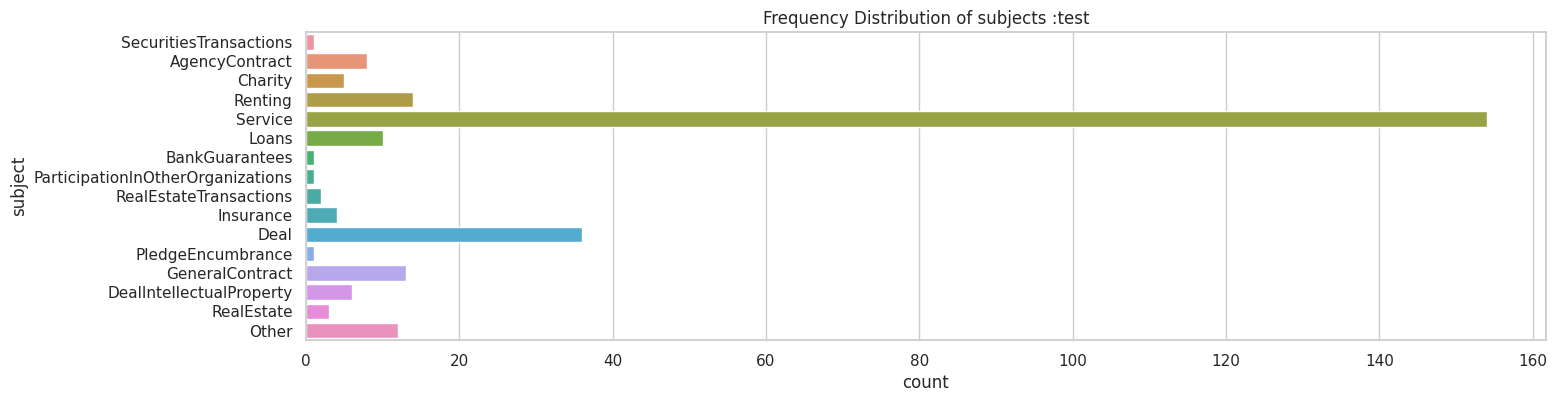

In [37]:
EPOCHS = 50
BATCH_SIZE = 96
EMB =  1024
 
_SELFTEST = True


print('train_indices[0]:', train_indices[0])
print('test_indices[0]:', test_indices[0])


def plot_subject_distr(df, title):  
  target='subject'
  plt.figure(figsize=(16,4))   
  sns.set(style="whitegrid")
  chart = sns.countplot(data=df, y=target)
  plt.title(f'Frequency Distribution of subjects :{title}')

 
plot_subject_distr(stats_valid, 'ALL')
plot_subject_distr(stats_valid[stats_valid.index.isin(train_indices)], 'train')
plot_subject_distr(stats_valid[stats_valid.index.isin(test_indices)], 'test')


if _SELFTEST:
  # test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True)
  
  x, y, w = next(train_gen)
  
#   print('X:', len(x), 'X[0]=', x[0].shape, 'X[1]=', x[1].shape)
#   print('Y:', len(y), 'Y[0]=', y[0].shape, 'Y[1]=', y[1].shape)
  

#   plot_embedding(x[0][0], 'X2: Token Embeddings')
#   plot_embedding(x[1][0], 'X1: Token Features')
#   plot_embedding(y[0][0], 'Y: Semantic Map')
  
#   print(y[0][1])

#   del x
#   del w
#   del y
#   del train_gen

In [38]:

ctx = KerasTrainingContext(checkpoints_path=umtm.reports_dir, session_index=1)

ctx.set_batch_size_and_trainset_size(BATCH_SIZE, 
                                     len(test_indices), 
                                     4 * len(train_indices))

DEFAULT_TRAIN_CTX = ctx
CLASSES = 43
FEATURES = 14

metrics = ['kullback_leibler_divergence', 'mse', 'binary_crossentropy']


def train(umodel):
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)

def overtrain(umodel):
  test_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE)
  train_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/training_reports


batch_size:	96
train_samples:	9740
test_samples:	271
steps_per_epoch:	101
validation_steps:	50


# Models 🦖

In [39]:
def get_weights_filename(model_factory_fn):
    weights = ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.h5'
    print(weights.is_file(), weights)
    if not weights.is_file():
        weights = Path(analyser.hyperparams.models_path) / f'{model_factory_fn.__name__}.h5'
        print(weights.is_file(), weights)
    
    return weights

# get_weights_filename(uber_detection_model_005_1_1)

## Train from 0 uber_detection_model_003

In [40]:
if TRAIN_MODEL_3:
    from tf_support.super_contract_model import uber_detection_model_003
    
    model_factory_fn = uber_detection_model_003
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

    umodel.summary()

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 10
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

## Continue training 003 from checkpoint

In [41]:
analyser.hyperparams.models_path

'/root/artem/analyser/analyser/vocab'

In [42]:
if TRAIN_MODEL_3:
    
    model_factory_fn = uber_detection_model_003

    weights = get_weights_filename(model_factory_fn)
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 25
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

## Overtrain 003

In [43]:
if TRAIN_MODEL_3:
    if TRAIN:
      ctx.unfreezeModel(umodel)
      umodel.compile(loss=super_contract_model.losses, optimizer='Adam', metrics=super_contract_model.metrics)
      print(super_contract_model.losses)
      umodel.summary()

      ctx.EPOCHS = 12
      ctx.EVALUATE_ONLY = False

      test_gen = make_generator(umtm, train_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 

      ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=False, lr=2e-5)

## 005 model
- 0.0233: last val subject loss
- 0.0016: last tagging loss
- 0.0248: last val loss


In [44]:
if TRAIN_MODEL_3:
    model_factory_fn = uber_detection_model_005_1_1
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

    umodel.summary()

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 20
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

### 5.1.1 💕💕 uber_detection_model_005_1_1

In [45]:
from tf_support.super_contract_model import FEATURES 
from analyser.headers_detector import TOKEN_FEATURES

from tf_support.super_contract_model import sigmoid_focal_crossentropy, losses

import numpy as np
from pandas import DataFrame 



model_factory_fn = uber_detection_model_005_1_1
weights = get_weights_filename(model_factory_fn)
umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)
# umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

True /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


2023-02-07 00:07:29.416142: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-07 00:07:29.452124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 00:07:29.452833: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-07 00:07:29.452847: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-07 00:07:29.452877: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-07 00:07:29.452895: I tensorflow/stream_executor/platform/defa

[tools.py:121 -           init_model() ] weights loaded: /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


In [46]:
######################
# Phase I retraining
# ❄️ frozen bottom layers
######################
if False:
    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 10
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

In [47]:
23

23

#### Phase II finetuning
all unfrozen, entire trainset, low LR
 

In [48]:
######################
## Phase II finetuning
#  all unfrozen, entire trainset, low LR
######################
if TRAIN and False:
  ctx.unfreezeModel(umodel)
  umodel.compile(loss=super_contract_model.losses, optimizer='Adam', metrics=super_contract_model.metrics)
  umodel.summary()
  
  ctx.EPOCHS = 30
  ctx.EVALUATE_ONLY = False
  ctx.EPOCHS *= 2

  test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
  
  ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=True, lr=1e-5)

## 🥰 Att model

In [49]:
from dataclasses import dataclass

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers

from analyser.headers_detector import TOKEN_FEATURES
from tf_support.super_contract_model import EMB, CLASSES, DEFAULT_TRAIN_CTX, FEATURES
from tf_support.tools import KerasTrainingContext


@dataclass
class Config:
  # MAX_LEN = 256
  # BATCH_SIZE = 32
  LR = 0.001

  EMBED_DIM = EMB
  NUM_HEAD = 4  # used in bert model
  FF_DIM = 128  # used in bert model
  NUM_LAYERS = 1


config = Config()


def bert_module(query, key, value, i, height):
  # Multi headed self-attention
  attention_output = layers.MultiHeadAttention(
    num_heads=config.NUM_HEAD,
    key_dim=config.EMBED_DIM // config.NUM_HEAD,
    name="encoder_{}/multiheadattention".format(i),
  )(query, key, value)
  attention_output = layers.Dropout(0.1, name="encoder_{}/att_dropout".format(i))(
    attention_output
  )
  attention_output = layers.LayerNormalization(
    epsilon=1e-6, name=f"encoder_{i}/att_layernormalization"
  )(query + attention_output)

  # Feed-forward layer
  ffn = keras.Sequential(
    [
      layers.Dense(config.FF_DIM, activation="relu"),
      layers.Dense(height),
    ],
    name=f"encoder_{i}/ffn",
  )
  ffn_output = ffn(attention_output)
  ffn_output = layers.Dropout(0.1, name=f"encoder_{i}/ffn_dropout")(
    ffn_output
  )
  sequence_output = layers.LayerNormalization(
    epsilon=1e-6, name=f"encoder_{i}/ffn_layernormalization"
  )(attention_output + ffn_output)
  return sequence_output


metrics = ['mse', 'binary_crossentropy']

losses = {
  "O1_tagging": "binary_crossentropy",
  "O2_subject": "binary_crossentropy",
}

class ThresholdLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ThresholdLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name="threshold", shape=(1,), initializer="uniform",
                                      trainable=True)
        super(ThresholdLayer, self).build(input_shape)

    def call(self, x):
        return keras.backend.sigmoid(100*(x-self.kernel))

    def compute_output_shape(self, input_shape):
        return input_shape

def make_att_model(name='make_att_model', ctx: KerasTrainingContext = DEFAULT_TRAIN_CTX, trained=False):
  input_text_emb = layers.Input(shape=[None, config.EMBED_DIM], dtype='float32', name="input_text_emb")
  _out = layers.BatchNormalization(name="bn1")(input_text_emb)
  _out = layers.Dropout(0.2, name="drops")(_out)  # small_drops_of_poison

  token_features = layers.Input(shape=[None, TOKEN_FEATURES], dtype='float32', name="token_features")
  token_features_n = layers.BatchNormalization(name="bn2")(token_features)

  _out = layers.concatenate([input_text_emb, token_features_n], axis=-1)

  for i in range(config.NUM_LAYERS):
    _out = bert_module(_out, _out, _out, i, height=config.EMBED_DIM + TOKEN_FEATURES)

  _out = layers.BatchNormalization(name="bn1")(_out)
  _out = layers.LSTM(FEATURES, return_sequences=True, activation='tanh', name='O1_tagging_tanh')(_out)
#   _out1 = layers.ReLU(name='O1_tagging')(_out)
  _out1 = ThresholdLayer(name='O1_tagging')(_out)
  

  #   _out = Conv1D(filters=FEATURES * 4, kernel_size=(2), padding='same', activation='relu' , name='embedding_reduced')(_out)
  _out = layers.Bidirectional(layers.LSTM(16, return_sequences=False, name='narcissisism'), name='embedding_reduced')(
    _out)
  _out = layers.BatchNormalization(name="bn_bi_2")(_out)
  _out = layers.Dropout(0.1)(_out)

  _out2 = layers.Dense(CLASSES, activation='softmax', name='O2_subject')(_out)

  base_model_inputs = [input_text_emb, token_features]
  model = Model(inputs=base_model_inputs, outputs=[_out1, _out2], name=name)
  model.compile(loss=losses, optimizer='Adam', metrics=metrics)
  return model


umodel = make_att_model() 

model_factory_fn=make_att_model      
weights = get_weights_filename(model_factory_fn)
# model_name = make_att_model.__name__


umodel.load_weights(weights, by_name=True, skip_mismatch=True)

# ctx.init_model(make_att_model, trained=True, trainable=True, weights=weights)



True /root/artem/analyser/training_reports/make_att_model.h5


In [50]:

if TRAIN:
#   ctx.unfreezeModel(umodel)
  umodel.summary()
  
  ctx.EPOCHS = 50
  ctx.EVALUATE_ONLY = False
#   ctx.EPOCHS *= 2

  test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
  
  ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=True, lr=config.LR)

threshold = umodel.get_layer('O1_tagging').get_weights()
print('threshold=',threshold)

Model: "make_att_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
token_features (InputLayer)     [(None, None, 15)]   0                                            
__________________________________________________________________________________________________
input_text_emb (InputLayer)     [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
bn2 (BatchNormalization)        (None, None, 15)     60          token_features[0][0]             
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, 1039)   0           input_text_emb[0][0]             
                                                                 bn2[0][0]           

/root/artem/env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


2023-02-07 00:07:33.222058: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-07 00:07:33.241900: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz


Epoch 1/50


2023-02-07 00:07:36.029771: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


2023-02-07 00:07:37.145674: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-07 00:07:37.145723: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-07 00:07:37.222165: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8


2023-02-07 00:07:37.451053: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500


  1/101 [..............................] - ETA: 8:09 - loss: 0.0089 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0122

  2/101 [..............................] - ETA: 22s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0101 

  3/101 [..............................] - ETA: 1:06 - loss: 0.0070 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0092

  4/101 [>.............................] - ETA: 1:11 - loss: 0.0069 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.8455e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

  5/101 [>.............................] - ETA: 1:12 - loss: 0.0068 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0024 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085    

  6/101 [>.............................] - ETA: 1:23 - loss: 0.0079 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

  7/101 [=>............................] - ETA: 1:28 - loss: 0.0078 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

  8/101 [=>............................] - ETA: 1:24 - loss: 0.0084 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

  9/101 [=>............................] - ETA: 1:30 - loss: 0.0086 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 10/101 [=>............................] - ETA: 1:24 - loss: 0.0086 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 11/101 [==>...........................] - ETA: 1:25 - loss: 0.0086 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 12/101 [==>...........................] - ETA: 1:21 - loss: 0.0084 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 13/101 [==>...........................] - ETA: 1:22 - loss: 0.0086 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 14/101 [===>..........................] - ETA: 1:26 - loss: 0.0086 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 15/101 [===>..........................] - ETA: 1:23 - loss: 0.0090 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0111

 16/101 [===>..........................] - ETA: 1:27 - loss: 0.0091 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 17/101 [====>.........................] - ETA: 1:25 - loss: 0.0092 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 18/101 [====>.........................] - ETA: 1:28 - loss: 0.0093 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 19/101 [====>.........................] - ETA: 1:30 - loss: 0.0091 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 20/101 [====>.........................] - ETA: 1:28 - loss: 0.0089 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 21/101 [=====>........................] - ETA: 1:29 - loss: 0.0089 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 22/101 [=====>........................] - ETA: 1:30 - loss: 0.0089 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 23/101 [=====>........................] - ETA: 1:29 - loss: 0.0089 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 24/101 [======>.......................] - ETA: 1:26 - loss: 0.0093 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 25/101 [======>.......................] - ETA: 1:26 - loss: 0.0094 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 26/101 [======>.......................] - ETA: 1:23 - loss: 0.0097 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 27/101 [=======>......................] - ETA: 1:23 - loss: 0.0097 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 28/101 [=======>......................] - ETA: 1:21 - loss: 0.0097 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 29/101 [=======>......................] - ETA: 1:20 - loss: 0.0096 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 30/101 [=======>......................] - ETA: 1:19 - loss: 0.0096 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 31/101 [========>.....................] - ETA: 1:18 - loss: 0.0098 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 32/101 [========>.....................] - ETA: 1:18 - loss: 0.0099 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 33/101 [========>.....................] - ETA: 1:16 - loss: 0.0099 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 34/101 [=========>....................] - ETA: 1:15 - loss: 0.0097 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 35/101 [=========>....................] - ETA: 1:15 - loss: 0.0097 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 36/101 [=========>....................] - ETA: 1:13 - loss: 0.0098 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 37/101 [=========>....................] - ETA: 1:13 - loss: 0.0098 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 38/101 [==========>...................] - ETA: 1:12 - loss: 0.0098 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 39/101 [==========>...................] - ETA: 1:10 - loss: 0.0097 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 40/101 [==========>...................] - ETA: 1:09 - loss: 0.0097 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 41/101 [===========>..................] - ETA: 1:08 - loss: 0.0098 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 42/101 [===========>..................] - ETA: 1:07 - loss: 0.0098 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 43/101 [===========>..................] - ETA: 1:06 - loss: 0.0098 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 44/101 [============>.................] - ETA: 1:04 - loss: 0.0099 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 45/101 [============>.................] - ETA: 1:03 - loss: 0.0098 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 46/101 [============>.................] - ETA: 1:01 - loss: 0.0099 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 47/101 [============>.................] - ETA: 1:00 - loss: 0.0099 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 48/101 [=============>................] - ETA: 59s - loss: 0.0099 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105 

 49/101 [=============>................] - ETA: 58s - loss: 0.0099 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 50/101 [=============>................] - ETA: 57s - loss: 0.0099 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 51/101 [==============>...............] - ETA: 57s - loss: 0.0099 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 52/101 [==============>...............] - ETA: 56s - loss: 0.0099 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 53/101 [==============>...............] - ETA: 56s - loss: 0.0098 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 54/101 [===============>..............] - ETA: 54s - loss: 0.0097 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 55/101 [===============>..............] - ETA: 54s - loss: 0.0098 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 56/101 [===============>..............] - ETA: 52s - loss: 0.0097 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 57/101 [===============>..............] - ETA: 51s - loss: 0.0097 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 58/101 [================>.............] - ETA: 50s - loss: 0.0098 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 59/101 [================>.............] - ETA: 49s - loss: 0.0098 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 60/101 [================>.............] - ETA: 48s - loss: 0.0098 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 61/101 [=================>............] - ETA: 46s - loss: 0.0099 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 62/101 [=================>............] - ETA: 46s - loss: 0.0098 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 63/101 [=================>............] - ETA: 44s - loss: 0.0098 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 64/101 [==================>...........] - ETA: 43s - loss: 0.0099 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 65/101 [==================>...........] - ETA: 42s - loss: 0.0100 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 66/101 [==================>...........] - ETA: 41s - loss: 0.0100 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 67/101 [==================>...........] - ETA: 40s - loss: 0.0099 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 68/101 [===================>..........] - ETA: 39s - loss: 0.0100 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 69/101 [===================>..........] - ETA: 37s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 70/101 [===================>..........] - ETA: 36s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 71/101 [====================>.........] - ETA: 35s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 72/101 [====================>.........] - ETA: 34s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 73/101 [====================>.........] - ETA: 33s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 74/101 [====================>.........] - ETA: 31s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 75/101 [=====================>........] - ETA: 30s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 76/101 [=====================>........] - ETA: 29s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 77/101 [=====================>........] - ETA: 28s - loss: 0.0099 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 78/101 [======================>.......] - ETA: 27s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 79/101 [======================>.......] - ETA: 26s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 80/101 [======================>.......] - ETA: 24s - loss: 0.0101 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 81/101 [=======================>......] - ETA: 23s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 82/101 [=======================>......] - ETA: 22s - loss: 0.0101 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 83/101 [=======================>......] - ETA: 21s - loss: 0.0101 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 84/101 [=======================>......] - ETA: 20s - loss: 0.0101 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 85/101 [========================>.....] - ETA: 18s - loss: 0.0102 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 86/101 [========================>.....] - ETA: 17s - loss: 0.0102 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 87/101 [========================>.....] - ETA: 16s - loss: 0.0102 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 88/101 [=========================>....] - ETA: 15s - loss: 0.0102 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 89/101 [=========================>....] - ETA: 14s - loss: 0.0102 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 90/101 [=========================>....] - ETA: 12s - loss: 0.0102 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 91/101 [==========================>...] - ETA: 11s - loss: 0.0103 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 92/101 [==========================>...] - ETA: 10s - loss: 0.0102 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 93/101 [==========================>...] - ETA: 9s - loss: 0.0102 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0102 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 95/101 [===========================>..] - ETA: 7s - loss: 0.0102 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 96/101 [===========================>..] - ETA: 5s - loss: 0.0102 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 97/101 [===========================>..] - ETA: 4s - loss: 0.0102 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 98/101 [============================>.] - ETA: 3s - loss: 0.0102 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 99/101 [============================>.] - ETA: 2s - loss: 0.0102 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

100/101 [============================>.] - ETA: 1s - loss: 0.0102 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

101/101 [==============================] - ETA: 0s - loss: 0.0102 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

101/101 [==============================] - 212s 2s/step - loss: 0.0102 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103 - val_loss: 0.0122 - val_O1_tagging_loss: 0.0061 - val_O2_subject_loss: 0.0061 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0075 - val_O2_subject_mse: 0.0016 - val_O2_subject_binary_crossentropy: 0.0048



Epoch 00001: val_loss improved from inf to 0.01215, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 2/50


  1/101 [..............................] - ETA: 26s - loss: 0.0094 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

  2/101 [..............................] - ETA: 1:30 - loss: 0.0087 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0085

  3/101 [..............................] - ETA: 1:56 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0083

  4/101 [>.............................] - ETA: 1:51 - loss: 0.0077 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

  5/101 [>.............................] - ETA: 1:56 - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

  6/101 [>.............................] - ETA: 1:58 - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

  7/101 [=>............................] - ETA: 1:55 - loss: 0.0087 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

  8/101 [=>............................] - ETA: 1:52 - loss: 0.0094 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

  9/101 [=>............................] - ETA: 1:49 - loss: 0.0095 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 10/101 [=>............................] - ETA: 1:47 - loss: 0.0096 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 11/101 [==>...........................] - ETA: 1:54 - loss: 0.0096 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 12/101 [==>...........................] - ETA: 1:49 - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 13/101 [==>...........................] - ETA: 1:49 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

 14/101 [===>..........................] - ETA: 1:49 - loss: 0.0096 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 15/101 [===>..........................] - ETA: 1:49 - loss: 0.0099 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 16/101 [===>..........................] - ETA: 1:45 - loss: 0.0098 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 17/101 [====>.........................] - ETA: 1:45 - loss: 0.0097 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 18/101 [====>.........................] - ETA: 1:44 - loss: 0.0097 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 19/101 [====>.........................] - ETA: 1:40 - loss: 0.0096 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 20/101 [====>.........................] - ETA: 1:39 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 21/101 [=====>........................] - ETA: 1:38 - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 22/101 [=====>........................] - ETA: 1:36 - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 23/101 [=====>........................] - ETA: 1:35 - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 24/101 [======>.......................] - ETA: 1:34 - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 25/101 [======>.......................] - ETA: 1:35 - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 26/101 [======>.......................] - ETA: 1:34 - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 27/101 [=======>......................] - ETA: 1:34 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 28/101 [=======>......................] - ETA: 1:35 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 29/101 [=======>......................] - ETA: 1:33 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 30/101 [=======>......................] - ETA: 1:33 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 31/101 [========>.....................] - ETA: 1:30 - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 32/101 [========>.....................] - ETA: 1:29 - loss: 0.0096 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 33/101 [========>.....................] - ETA: 1:27 - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 34/101 [=========>....................] - ETA: 1:26 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 35/101 [=========>....................] - ETA: 1:24 - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 36/101 [=========>....................] - ETA: 1:23 - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 37/101 [=========>....................] - ETA: 1:20 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 38/101 [==========>...................] - ETA: 1:19 - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 39/101 [==========>...................] - ETA: 1:17 - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 40/101 [==========>...................] - ETA: 1:16 - loss: 0.0097 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 41/101 [===========>..................] - ETA: 1:15 - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 42/101 [===========>..................] - ETA: 1:13 - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 43/101 [===========>..................] - ETA: 1:12 - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 44/101 [============>.................] - ETA: 1:11 - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 45/101 [============>.................] - ETA: 1:09 - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 46/101 [============>.................] - ETA: 1:08 - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 47/101 [============>.................] - ETA: 1:09 - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 48/101 [=============>................] - ETA: 1:08 - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 49/101 [=============>................] - ETA: 1:07 - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 50/101 [=============>................] - ETA: 1:05 - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 51/101 [==============>...............] - ETA: 1:04 - loss: 0.0098 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 52/101 [==============>...............] - ETA: 1:03 - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 53/101 [==============>...............] - ETA: 1:01 - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 54/101 [===============>..............] - ETA: 1:00 - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 55/101 [===============>..............] - ETA: 59s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099 

 56/101 [===============>..............] - ETA: 58s - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 57/101 [===============>..............] - ETA: 56s - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 58/101 [================>.............] - ETA: 55s - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 59/101 [================>.............] - ETA: 53s - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 60/101 [================>.............] - ETA: 53s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 61/101 [=================>............] - ETA: 51s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 62/101 [=================>............] - ETA: 50s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 63/101 [=================>............] - ETA: 49s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 64/101 [==================>...........] - ETA: 48s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 65/101 [==================>...........] - ETA: 47s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 66/101 [==================>...........] - ETA: 45s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 67/101 [==================>...........] - ETA: 44s - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 68/101 [===================>..........] - ETA: 43s - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 69/101 [===================>..........] - ETA: 41s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 70/101 [===================>..........] - ETA: 40s - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 71/101 [====================>.........] - ETA: 38s - loss: 0.0100 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 72/101 [====================>.........] - ETA: 38s - loss: 0.0100 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 73/101 [====================>.........] - ETA: 36s - loss: 0.0100 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 74/101 [====================>.........] - ETA: 35s - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 75/101 [=====================>........] - ETA: 34s - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 76/101 [=====================>........] - ETA: 33s - loss: 0.0100 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 77/101 [=====================>........] - ETA: 31s - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 78/101 [======================>.......] - ETA: 30s - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 79/101 [======================>.......] - ETA: 29s - loss: 0.0100 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 80/101 [======================>.......] - ETA: 27s - loss: 0.0100 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 81/101 [=======================>......] - ETA: 26s - loss: 0.0100 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 82/101 [=======================>......] - ETA: 25s - loss: 0.0100 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 83/101 [=======================>......] - ETA: 23s - loss: 0.0101 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 84/101 [=======================>......] - ETA: 22s - loss: 0.0101 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 85/101 [========================>.....] - ETA: 21s - loss: 0.0101 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 86/101 [========================>.....] - ETA: 19s - loss: 0.0101 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 87/101 [========================>.....] - ETA: 18s - loss: 0.0101 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 88/101 [=========================>....] - ETA: 17s - loss: 0.0101 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 89/101 [=========================>....] - ETA: 16s - loss: 0.0101 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 90/101 [=========================>....] - ETA: 14s - loss: 0.0101 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 91/101 [==========================>...] - ETA: 13s - loss: 0.0101 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 92/101 [==========================>...] - ETA: 12s - loss: 0.0101 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 93/101 [==========================>...] - ETA: 10s - loss: 0.0102 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 94/101 [==========================>...] - ETA: 9s - loss: 0.0101 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108 

 95/101 [===========================>..] - ETA: 7s - loss: 0.0102 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 96/101 [===========================>..] - ETA: 6s - loss: 0.0102 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 97/101 [===========================>..] - ETA: 5s - loss: 0.0102 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 98/101 [============================>.] - ETA: 3s - loss: 0.0102 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 99/101 [============================>.] - ETA: 2s - loss: 0.0102 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

100/101 [============================>.] - ETA: 1s - loss: 0.0102 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

101/101 [==============================] - ETA: 0s - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

101/101 [==============================] - 214s 2s/step - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109 - val_loss: 0.0156 - val_O1_tagging_loss: 0.0089 - val_O2_subject_loss: 0.0067 - val_O1_tagging_mse: 0.0018 - val_O1_tagging_binary_crossentropy: 0.0105 - val_O2_subject_mse: 0.0015 - val_O2_subject_binary_crossentropy: 0.0053



Epoch 00002: val_loss did not improve from 0.01215
Epoch 3/50


  1/101 [..............................] - ETA: 25s - loss: 0.0084 - O1_tagging_loss: 0.0066 - O2_subject_loss: 0.0018 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0014 - O2_subject_binary_crossentropy: 0.0070

  2/101 [..............................] - ETA: 1:26 - loss: 0.0102 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0016 - O2_subject_binary_crossentropy: 0.0083

  3/101 [..............................] - ETA: 1:35 - loss: 0.0129 - O1_tagging_loss: 0.0069 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0124

  4/101 [>.............................] - ETA: 1:47 - loss: 0.0115 - O1_tagging_loss: 0.0065 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

  5/101 [>.............................] - ETA: 1:41 - loss: 0.0118 - O1_tagging_loss: 0.0063 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0120

  6/101 [>.............................] - ETA: 1:53 - loss: 0.0121 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0115

  7/101 [=>............................] - ETA: 2:01 - loss: 0.0111 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0109

  8/101 [=>............................] - ETA: 2:01 - loss: 0.0108 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

  9/101 [=>............................] - ETA: 1:55 - loss: 0.0105 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0100

 10/101 [=>............................] - ETA: 1:57 - loss: 0.0105 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 11/101 [==>...........................] - ETA: 1:56 - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0097

 12/101 [==>...........................] - ETA: 1:54 - loss: 0.0098 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0097

 13/101 [==>...........................] - ETA: 1:52 - loss: 0.0102 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 14/101 [===>..........................] - ETA: 1:52 - loss: 0.0102 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 15/101 [===>..........................] - ETA: 1:50 - loss: 0.0103 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 16/101 [===>..........................] - ETA: 1:47 - loss: 0.0106 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 17/101 [====>.........................] - ETA: 1:43 - loss: 0.0109 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 18/101 [====>.........................] - ETA: 1:43 - loss: 0.0109 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 19/101 [====>.........................] - ETA: 1:41 - loss: 0.0108 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 20/101 [====>.........................] - ETA: 1:38 - loss: 0.0108 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 21/101 [=====>........................] - ETA: 1:37 - loss: 0.0108 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113

 22/101 [=====>........................] - ETA: 1:36 - loss: 0.0108 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 23/101 [=====>........................] - ETA: 1:34 - loss: 0.0108 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0113

 24/101 [======>.......................] - ETA: 1:33 - loss: 0.0107 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0117

 25/101 [======>.......................] - ETA: 1:33 - loss: 0.0108 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 26/101 [======>.......................] - ETA: 1:33 - loss: 0.0107 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113

 27/101 [=======>......................] - ETA: 1:32 - loss: 0.0107 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 28/101 [=======>......................] - ETA: 1:31 - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 29/101 [=======>......................] - ETA: 1:30 - loss: 0.0110 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 30/101 [=======>......................] - ETA: 1:28 - loss: 0.0110 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 31/101 [========>.....................] - ETA: 1:27 - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 32/101 [========>.....................] - ETA: 1:26 - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 33/101 [========>.....................] - ETA: 1:25 - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 34/101 [=========>....................] - ETA: 1:24 - loss: 0.0110 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 35/101 [=========>....................] - ETA: 1:22 - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 36/101 [=========>....................] - ETA: 1:21 - loss: 0.0108 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 37/101 [=========>....................] - ETA: 1:19 - loss: 0.0107 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 38/101 [==========>...................] - ETA: 1:18 - loss: 0.0107 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 39/101 [==========>...................] - ETA: 1:17 - loss: 0.0107 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 40/101 [==========>...................] - ETA: 1:15 - loss: 0.0107 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 41/101 [===========>..................] - ETA: 1:14 - loss: 0.0107 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 42/101 [===========>..................] - ETA: 1:13 - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 43/101 [===========>..................] - ETA: 1:12 - loss: 0.0110 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 44/101 [============>.................] - ETA: 1:10 - loss: 0.0112 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 45/101 [============>.................] - ETA: 1:09 - loss: 0.0111 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 46/101 [============>.................] - ETA: 1:08 - loss: 0.0111 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 47/101 [============>.................] - ETA: 1:07 - loss: 0.0111 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 48/101 [=============>................] - ETA: 1:05 - loss: 0.0111 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 49/101 [=============>................] - ETA: 1:04 - loss: 0.0112 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0111

 50/101 [=============>................] - ETA: 1:03 - loss: 0.0111 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0111

 51/101 [==============>...............] - ETA: 1:01 - loss: 0.0111 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 52/101 [==============>...............] - ETA: 1:00 - loss: 0.0111 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 53/101 [==============>...............] - ETA: 59s - loss: 0.0111 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111 

 54/101 [===============>..............] - ETA: 58s - loss: 0.0110 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 55/101 [===============>..............] - ETA: 57s - loss: 0.0110 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 56/101 [===============>..............] - ETA: 56s - loss: 0.0109 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 57/101 [===============>..............] - ETA: 54s - loss: 0.0109 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 58/101 [================>.............] - ETA: 53s - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 59/101 [================>.............] - ETA: 51s - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 60/101 [================>.............] - ETA: 50s - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 61/101 [=================>............] - ETA: 49s - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 62/101 [=================>............] - ETA: 48s - loss: 0.0110 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 63/101 [=================>............] - ETA: 46s - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 64/101 [==================>...........] - ETA: 45s - loss: 0.0110 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 65/101 [==================>...........] - ETA: 44s - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 66/101 [==================>...........] - ETA: 42s - loss: 0.0110 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 67/101 [==================>...........] - ETA: 41s - loss: 0.0111 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 68/101 [===================>..........] - ETA: 40s - loss: 0.0112 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113

 69/101 [===================>..........] - ETA: 39s - loss: 0.0111 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 70/101 [===================>..........] - ETA: 38s - loss: 0.0111 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 71/101 [====================>.........] - ETA: 37s - loss: 0.0111 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 72/101 [====================>.........] - ETA: 36s - loss: 0.0111 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 73/101 [====================>.........] - ETA: 34s - loss: 0.0110 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 74/101 [====================>.........] - ETA: 33s - loss: 0.0111 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 75/101 [=====================>........] - ETA: 32s - loss: 0.0111 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 76/101 [=====================>........] - ETA: 31s - loss: 0.0111 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 77/101 [=====================>........] - ETA: 30s - loss: 0.0111 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 78/101 [======================>.......] - ETA: 28s - loss: 0.0110 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 79/101 [======================>.......] - ETA: 27s - loss: 0.0110 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 80/101 [======================>.......] - ETA: 26s - loss: 0.0110 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 81/101 [=======================>......] - ETA: 24s - loss: 0.0110 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 82/101 [=======================>......] - ETA: 23s - loss: 0.0110 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 83/101 [=======================>......] - ETA: 22s - loss: 0.0111 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 84/101 [=======================>......] - ETA: 21s - loss: 0.0110 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 85/101 [========================>.....] - ETA: 19s - loss: 0.0111 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 86/101 [========================>.....] - ETA: 18s - loss: 0.0111 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0112

 87/101 [========================>.....] - ETA: 17s - loss: 0.0111 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113

 88/101 [=========================>....] - ETA: 16s - loss: 0.0111 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0114

 89/101 [=========================>....] - ETA: 14s - loss: 0.0111 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113

 90/101 [=========================>....] - ETA: 13s - loss: 0.0112 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 91/101 [==========================>...] - ETA: 12s - loss: 0.0111 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0114

 92/101 [==========================>...] - ETA: 11s - loss: 0.0112 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113

 93/101 [==========================>...] - ETA: 9s - loss: 0.0111 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0111 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113

 95/101 [===========================>..] - ETA: 7s - loss: 0.0112 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113

 96/101 [===========================>..] - ETA: 6s - loss: 0.0112 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113

 97/101 [===========================>..] - ETA: 4s - loss: 0.0113 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 98/101 [============================>.] - ETA: 3s - loss: 0.0113 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0113

 99/101 [============================>.] - ETA: 2s - loss: 0.0112 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

100/101 [============================>.] - ETA: 1s - loss: 0.0112 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113

101/101 [==============================] - ETA: 0s - loss: 0.0112 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113

101/101 [==============================] - 200s 2s/step - loss: 0.0112 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0113 - val_loss: 0.0136 - val_O1_tagging_loss: 0.0065 - val_O2_subject_loss: 0.0071 - val_O1_tagging_mse: 0.0011 - val_O1_tagging_binary_crossentropy: 0.0077 - val_O2_subject_mse: 0.0019 - val_O2_subject_binary_crossentropy: 0.0067



Epoch 00003: val_loss did not improve from 0.01215
Epoch 4/50
  1/101 [..............................] - ETA: 14s - loss: 0.0108 - O1_tagging_loss: 0.0071 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0149

  2/101 [..............................] - ETA: 2:37 - loss: 0.0081 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0118

  3/101 [..............................] - ETA: 1:59 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0122

  4/101 [>.............................] - ETA: 2:03 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0128

  5/101 [>.............................] - ETA: 2:03 - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

  6/101 [>.............................] - ETA: 1:59 - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

  7/101 [=>............................] - ETA: 2:12 - loss: 0.0092 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0122

  8/101 [=>............................] - ETA: 2:07 - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0121

  9/101 [=>............................] - ETA: 2:02 - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0116

 10/101 [=>............................] - ETA: 1:57 - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0125

 11/101 [==>...........................] - ETA: 2:03 - loss: 0.0105 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0122

 12/101 [==>...........................] - ETA: 1:59 - loss: 0.0104 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0122

 13/101 [==>...........................] - ETA: 2:01 - loss: 0.0109 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0124

 14/101 [===>..........................] - ETA: 1:56 - loss: 0.0108 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0122

 15/101 [===>..........................] - ETA: 1:56 - loss: 0.0109 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0118

 16/101 [===>..........................] - ETA: 1:52 - loss: 0.0112 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0118

 17/101 [====>.........................] - ETA: 1:50 - loss: 0.0111 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0117

 18/101 [====>.........................] - ETA: 1:48 - loss: 0.0110 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0114

 19/101 [====>.........................] - ETA: 1:47 - loss: 0.0111 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116

 20/101 [====>.........................] - ETA: 1:44 - loss: 0.0110 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116

 21/101 [=====>........................] - ETA: 1:42 - loss: 0.0108 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116

 22/101 [=====>........................] - ETA: 1:41 - loss: 0.0109 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 23/101 [=====>........................] - ETA: 1:41 - loss: 0.0108 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 24/101 [======>.......................] - ETA: 1:40 - loss: 0.0108 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 25/101 [======>.......................] - ETA: 1:37 - loss: 0.0107 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 26/101 [======>.......................] - ETA: 1:36 - loss: 0.0106 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0114

 27/101 [=======>......................] - ETA: 1:33 - loss: 0.0106 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0115

 28/101 [=======>......................] - ETA: 1:32 - loss: 0.0107 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

 29/101 [=======>......................] - ETA: 1:32 - loss: 0.0108 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0116

 30/101 [=======>......................] - ETA: 1:35 - loss: 0.0107 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0116

 31/101 [========>.....................] - ETA: 1:34 - loss: 0.0107 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0115

 32/101 [========>.....................] - ETA: 1:33 - loss: 0.0109 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0114

 33/101 [========>.....................] - ETA: 1:31 - loss: 0.0110 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0113

 34/101 [=========>....................] - ETA: 1:29 - loss: 0.0109 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0112

 35/101 [=========>....................] - ETA: 1:28 - loss: 0.0108 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 36/101 [=========>....................] - ETA: 1:27 - loss: 0.0108 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 37/101 [=========>....................] - ETA: 1:25 - loss: 0.0108 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 38/101 [==========>...................] - ETA: 1:25 - loss: 0.0108 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 39/101 [==========>...................] - ETA: 1:23 - loss: 0.0108 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0111

 40/101 [==========>...................] - ETA: 1:23 - loss: 0.0108 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 41/101 [===========>..................] - ETA: 1:21 - loss: 0.0109 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 42/101 [===========>..................] - ETA: 1:20 - loss: 0.0108 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 43/101 [===========>..................] - ETA: 1:19 - loss: 0.0108 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 44/101 [============>.................] - ETA: 1:17 - loss: 0.0107 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 45/101 [============>.................] - ETA: 1:16 - loss: 0.0106 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 46/101 [============>.................] - ETA: 1:15 - loss: 0.0106 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 47/101 [============>.................] - ETA: 1:13 - loss: 0.0105 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 48/101 [=============>................] - ETA: 1:11 - loss: 0.0105 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 49/101 [=============>................] - ETA: 1:11 - loss: 0.0105 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 50/101 [=============>................] - ETA: 1:09 - loss: 0.0105 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 51/101 [==============>...............] - ETA: 1:08 - loss: 0.0104 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 52/101 [==============>...............] - ETA: 1:06 - loss: 0.0105 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 53/101 [==============>...............] - ETA: 1:05 - loss: 0.0105 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 54/101 [===============>..............] - ETA: 1:03 - loss: 0.0104 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 55/101 [===============>..............] - ETA: 1:02 - loss: 0.0104 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 56/101 [===============>..............] - ETA: 1:01 - loss: 0.0105 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 57/101 [===============>..............] - ETA: 59s - loss: 0.0104 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107 

 58/101 [================>.............] - ETA: 58s - loss: 0.0104 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 59/101 [================>.............] - ETA: 57s - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0106

 60/101 [================>.............] - ETA: 55s - loss: 0.0104 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 61/101 [=================>............] - ETA: 54s - loss: 0.0104 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 62/101 [=================>............] - ETA: 52s - loss: 0.0103 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 63/101 [=================>............] - ETA: 51s - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 64/101 [==================>...........] - ETA: 50s - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 65/101 [==================>...........] - ETA: 48s - loss: 0.0102 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 66/101 [==================>...........] - ETA: 47s - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 67/101 [==================>...........] - ETA: 45s - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 68/101 [===================>..........] - ETA: 44s - loss: 0.0102 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 69/101 [===================>..........] - ETA: 43s - loss: 0.0102 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 70/101 [===================>..........] - ETA: 41s - loss: 0.0102 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 71/101 [====================>.........] - ETA: 40s - loss: 0.0102 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 72/101 [====================>.........] - ETA: 39s - loss: 0.0102 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 73/101 [====================>.........] - ETA: 37s - loss: 0.0102 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 74/101 [====================>.........] - ETA: 36s - loss: 0.0102 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 75/101 [=====================>........] - ETA: 35s - loss: 0.0102 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 76/101 [=====================>........] - ETA: 33s - loss: 0.0102 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 77/101 [=====================>........] - ETA: 32s - loss: 0.0102 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 78/101 [======================>.......] - ETA: 30s - loss: 0.0102 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 79/101 [======================>.......] - ETA: 29s - loss: 0.0102 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 80/101 [======================>.......] - ETA: 28s - loss: 0.0102 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 81/101 [=======================>......] - ETA: 26s - loss: 0.0103 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 82/101 [=======================>......] - ETA: 25s - loss: 0.0103 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 83/101 [=======================>......] - ETA: 24s - loss: 0.0103 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 84/101 [=======================>......] - ETA: 22s - loss: 0.0103 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 85/101 [========================>.....] - ETA: 21s - loss: 0.0102 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 86/101 [========================>.....] - ETA: 20s - loss: 0.0102 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 87/101 [========================>.....] - ETA: 18s - loss: 0.0102 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 88/101 [=========================>....] - ETA: 17s - loss: 0.0102 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 89/101 [=========================>....] - ETA: 16s - loss: 0.0102 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 90/101 [=========================>....] - ETA: 14s - loss: 0.0101 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0106

 91/101 [==========================>...] - ETA: 13s - loss: 0.0101 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 92/101 [==========================>...] - ETA: 12s - loss: 0.0101 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 93/101 [==========================>...] - ETA: 10s - loss: 0.0101 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 94/101 [==========================>...] - ETA: 9s - loss: 0.0101 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0101 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 96/101 [===========================>..] - ETA: 6s - loss: 0.0101 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 97/101 [===========================>..] - ETA: 5s - loss: 0.0102 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 98/101 [============================>.] - ETA: 4s - loss: 0.0102 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 99/101 [============================>.] - ETA: 2s - loss: 0.0103 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

100/101 [============================>.] - ETA: 1s - loss: 0.0103 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

101/101 [==============================] - ETA: 0s - loss: 0.0103 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

101/101 [==============================] - 215s 2s/step - loss: 0.0103 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106 - val_loss: 0.0175 - val_O1_tagging_loss: 0.0088 - val_O2_subject_loss: 0.0087 - val_O1_tagging_mse: 0.0017 - val_O1_tagging_binary_crossentropy: 0.0107 - val_O2_subject_mse: 0.0019 - val_O2_subject_binary_crossentropy: 0.0069



Epoch 00004: val_loss did not improve from 0.01215
Epoch 5/50


  1/101 [..............................] - ETA: 32s - loss: 0.0161 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0168

  2/101 [..............................] - ETA: 1:45 - loss: 0.0135 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0145

  3/101 [..............................] - ETA: 2:09 - loss: 0.0120 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0142

  4/101 [>.............................] - ETA: 2:00 - loss: 0.0121 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0136

  5/101 [>.............................] - ETA: 2:09 - loss: 0.0118 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0130

  6/101 [>.............................] - ETA: 2:02 - loss: 0.0110 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0118

  7/101 [=>............................] - ETA: 2:04 - loss: 0.0111 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0116

  8/101 [=>............................] - ETA: 2:01 - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0110

  9/101 [=>............................] - ETA: 2:00 - loss: 0.0110 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0110

 10/101 [=>............................] - ETA: 1:57 - loss: 0.0108 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0112

 11/101 [==>...........................] - ETA: 1:57 - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0113

 12/101 [==>...........................] - ETA: 1:57 - loss: 0.0111 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0114

 13/101 [==>...........................] - ETA: 1:53 - loss: 0.0110 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0114

 14/101 [===>..........................] - ETA: 1:54 - loss: 0.0107 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0112

 15/101 [===>..........................] - ETA: 1:52 - loss: 0.0107 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0110

 16/101 [===>..........................] - ETA: 1:48 - loss: 0.0105 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 17/101 [====>.........................] - ETA: 1:51 - loss: 0.0103 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 18/101 [====>.........................] - ETA: 1:48 - loss: 0.0104 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 19/101 [====>.........................] - ETA: 1:47 - loss: 0.0102 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 20/101 [====>.........................] - ETA: 1:43 - loss: 0.0104 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 21/101 [=====>........................] - ETA: 1:42 - loss: 0.0105 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 22/101 [=====>........................] - ETA: 1:44 - loss: 0.0105 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 23/101 [=====>........................] - ETA: 1:44 - loss: 0.0106 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 24/101 [======>.......................] - ETA: 1:42 - loss: 0.0109 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 25/101 [======>.......................] - ETA: 1:42 - loss: 0.0111 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 26/101 [======>.......................] - ETA: 1:41 - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 27/101 [=======>......................] - ETA: 1:38 - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 28/101 [=======>......................] - ETA: 1:37 - loss: 0.0108 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 29/101 [=======>......................] - ETA: 1:35 - loss: 0.0109 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 30/101 [=======>......................] - ETA: 1:33 - loss: 0.0108 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 31/101 [========>.....................] - ETA: 1:34 - loss: 0.0108 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 32/101 [========>.....................] - ETA: 1:33 - loss: 0.0106 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 33/101 [========>.....................] - ETA: 1:31 - loss: 0.0108 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

 34/101 [=========>....................] - ETA: 1:30 - loss: 0.0107 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 35/101 [=========>....................] - ETA: 1:28 - loss: 0.0107 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 36/101 [=========>....................] - ETA: 1:26 - loss: 0.0108 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 37/101 [=========>....................] - ETA: 1:25 - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 38/101 [==========>...................] - ETA: 1:24 - loss: 0.0108 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 39/101 [==========>...................] - ETA: 1:23 - loss: 0.0107 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 40/101 [==========>...................] - ETA: 1:21 - loss: 0.0106 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 41/101 [===========>..................] - ETA: 1:19 - loss: 0.0107 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 42/101 [===========>..................] - ETA: 1:17 - loss: 0.0107 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 43/101 [===========>..................] - ETA: 1:16 - loss: 0.0107 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 44/101 [============>.................] - ETA: 1:15 - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 45/101 [============>.................] - ETA: 1:14 - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 46/101 [============>.................] - ETA: 1:13 - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 47/101 [============>.................] - ETA: 1:12 - loss: 0.0110 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 48/101 [=============>................] - ETA: 1:10 - loss: 0.0111 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 49/101 [=============>................] - ETA: 1:08 - loss: 0.0111 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 50/101 [=============>................] - ETA: 1:08 - loss: 0.0111 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 51/101 [==============>...............] - ETA: 1:06 - loss: 0.0110 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 52/101 [==============>...............] - ETA: 1:05 - loss: 0.0110 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 53/101 [==============>...............] - ETA: 1:03 - loss: 0.0110 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 54/101 [===============>..............] - ETA: 1:02 - loss: 0.0110 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 55/101 [===============>..............] - ETA: 1:00 - loss: 0.0110 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 56/101 [===============>..............] - ETA: 59s - loss: 0.0110 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108 

 57/101 [===============>..............] - ETA: 58s - loss: 0.0110 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 58/101 [================>.............] - ETA: 57s - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 59/101 [================>.............] - ETA: 55s - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 60/101 [================>.............] - ETA: 54s - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 61/101 [=================>............] - ETA: 53s - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 62/101 [=================>............] - ETA: 52s - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 63/101 [=================>............] - ETA: 50s - loss: 0.0110 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 64/101 [==================>...........] - ETA: 49s - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 65/101 [==================>...........] - ETA: 47s - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 66/101 [==================>...........] - ETA: 46s - loss: 0.0108 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 67/101 [==================>...........] - ETA: 45s - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 68/101 [===================>..........] - ETA: 43s - loss: 0.0108 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 69/101 [===================>..........] - ETA: 42s - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0109

 70/101 [===================>..........] - ETA: 40s - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 71/101 [====================>.........] - ETA: 39s - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 72/101 [====================>.........] - ETA: 37s - loss: 0.0110 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 73/101 [====================>.........] - ETA: 36s - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 74/101 [====================>.........] - ETA: 35s - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 75/101 [=====================>........] - ETA: 34s - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 76/101 [=====================>........] - ETA: 32s - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 77/101 [=====================>........] - ETA: 31s - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 78/101 [======================>.......] - ETA: 30s - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 79/101 [======================>.......] - ETA: 29s - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 80/101 [======================>.......] - ETA: 27s - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 81/101 [=======================>......] - ETA: 26s - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 82/101 [=======================>......] - ETA: 24s - loss: 0.0109 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 83/101 [=======================>......] - ETA: 23s - loss: 0.0108 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 84/101 [=======================>......] - ETA: 22s - loss: 0.0108 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 85/101 [========================>.....] - ETA: 21s - loss: 0.0107 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 86/101 [========================>.....] - ETA: 19s - loss: 0.0108 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 87/101 [========================>.....] - ETA: 18s - loss: 0.0108 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 88/101 [=========================>....] - ETA: 17s - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110

 89/101 [=========================>....] - ETA: 15s - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 90/101 [=========================>....] - ETA: 14s - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 91/101 [==========================>...] - ETA: 13s - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 92/101 [==========================>...] - ETA: 11s - loss: 0.0109 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 93/101 [==========================>...] - ETA: 10s - loss: 0.0108 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 94/101 [==========================>...] - ETA: 9s - loss: 0.0108 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108 

 95/101 [===========================>..] - ETA: 7s - loss: 0.0108 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 96/101 [===========================>..] - ETA: 6s - loss: 0.0107 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 97/101 [===========================>..] - ETA: 5s - loss: 0.0107 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 98/101 [============================>.] - ETA: 3s - loss: 0.0107 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 99/101 [============================>.] - ETA: 2s - loss: 0.0107 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

100/101 [============================>.] - ETA: 1s - loss: 0.0106 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

101/101 [==============================] - ETA: 0s - loss: 0.0106 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

101/101 [==============================] - 213s 2s/step - loss: 0.0106 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107 - val_loss: 0.0130 - val_O1_tagging_loss: 0.0058 - val_O2_subject_loss: 0.0072 - val_O1_tagging_mse: 0.0010 - val_O1_tagging_binary_crossentropy: 0.0076 - val_O2_subject_mse: 0.0018 - val_O2_subject_binary_crossentropy: 0.0056



Epoch 00005: val_loss did not improve from 0.01215
Epoch 6/50


  1/101 [..............................] - ETA: 38s - loss: 0.0104 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0053 - O1_tagging_mse: 8.2701e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0052

  2/101 [..............................] - ETA: 1:30 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0015 - O2_subject_binary_crossentropy: 0.0056   

  3/101 [..............................] - ETA: 1:53 - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0072

  4/101 [>.............................] - ETA: 1:55 - loss: 0.0093 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

  5/101 [>.............................] - ETA: 1:44 - loss: 0.0105 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

  6/101 [>.............................] - ETA: 1:40 - loss: 0.0102 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

  7/101 [=>............................] - ETA: 1:46 - loss: 0.0098 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

  8/101 [=>............................] - ETA: 1:52 - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

  9/101 [=>............................] - ETA: 1:55 - loss: 0.0095 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 10/101 [=>............................] - ETA: 1:48 - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 11/101 [==>...........................] - ETA: 1:52 - loss: 0.0100 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 12/101 [==>...........................] - ETA: 1:48 - loss: 0.0103 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 13/101 [==>...........................] - ETA: 1:49 - loss: 0.0103 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 14/101 [===>..........................] - ETA: 1:46 - loss: 0.0100 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 15/101 [===>..........................] - ETA: 1:45 - loss: 0.0100 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 16/101 [===>..........................] - ETA: 1:45 - loss: 0.0099 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 17/101 [====>.........................] - ETA: 1:44 - loss: 0.0097 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 18/101 [====>.........................] - ETA: 1:41 - loss: 0.0097 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 19/101 [====>.........................] - ETA: 1:41 - loss: 0.0095 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 20/101 [====>.........................] - ETA: 1:43 - loss: 0.0094 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 21/101 [=====>........................] - ETA: 1:40 - loss: 0.0094 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 22/101 [=====>........................] - ETA: 1:39 - loss: 0.0094 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 23/101 [=====>........................] - ETA: 1:37 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 24/101 [======>.......................] - ETA: 1:38 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 25/101 [======>.......................] - ETA: 1:35 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 26/101 [======>.......................] - ETA: 1:36 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 27/101 [=======>......................] - ETA: 1:34 - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 28/101 [=======>......................] - ETA: 1:34 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 29/101 [=======>......................] - ETA: 1:34 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 30/101 [=======>......................] - ETA: 1:33 - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 31/101 [========>.....................] - ETA: 1:31 - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 32/101 [========>.....................] - ETA: 1:29 - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 33/101 [========>.....................] - ETA: 1:28 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 34/101 [=========>....................] - ETA: 1:26 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 35/101 [=========>....................] - ETA: 1:24 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 36/101 [=========>....................] - ETA: 1:24 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 37/101 [=========>....................] - ETA: 1:23 - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 38/101 [==========>...................] - ETA: 1:21 - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 39/101 [==========>...................] - ETA: 1:20 - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 40/101 [==========>...................] - ETA: 1:20 - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 41/101 [===========>..................] - ETA: 1:19 - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 42/101 [===========>..................] - ETA: 1:18 - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 43/101 [===========>..................] - ETA: 1:17 - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 44/101 [============>.................] - ETA: 1:15 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 45/101 [============>.................] - ETA: 1:15 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 46/101 [============>.................] - ETA: 1:12 - loss: 0.0097 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 47/101 [============>.................] - ETA: 1:11 - loss: 0.0098 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 48/101 [=============>................] - ETA: 1:09 - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 49/101 [=============>................] - ETA: 1:08 - loss: 0.0099 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 50/101 [=============>................] - ETA: 1:07 - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 51/101 [==============>...............] - ETA: 1:06 - loss: 0.0098 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 52/101 [==============>...............] - ETA: 1:05 - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 53/101 [==============>...............] - ETA: 1:03 - loss: 0.0098 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 54/101 [===============>..............] - ETA: 1:02 - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 55/101 [===============>..............] - ETA: 1:01 - loss: 0.0099 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 56/101 [===============>..............] - ETA: 1:00 - loss: 0.0099 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 57/101 [===============>..............] - ETA: 59s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101 

 58/101 [================>.............] - ETA: 57s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 59/101 [================>.............] - ETA: 56s - loss: 0.0101 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 60/101 [================>.............] - ETA: 55s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 61/101 [=================>............] - ETA: 53s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 62/101 [=================>............] - ETA: 52s - loss: 0.0100 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 63/101 [=================>............] - ETA: 50s - loss: 0.0101 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 64/101 [==================>...........] - ETA: 49s - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 65/101 [==================>...........] - ETA: 48s - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

 66/101 [==================>...........] - ETA: 46s - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 67/101 [==================>...........] - ETA: 45s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 68/101 [===================>..........] - ETA: 44s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 69/101 [===================>..........] - ETA: 42s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 70/101 [===================>..........] - ETA: 41s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 71/101 [====================>.........] - ETA: 40s - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

 72/101 [====================>.........] - ETA: 38s - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 73/101 [====================>.........] - ETA: 37s - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 74/101 [====================>.........] - ETA: 35s - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 75/101 [=====================>........] - ETA: 34s - loss: 0.0102 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 76/101 [=====================>........] - ETA: 33s - loss: 0.0102 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 77/101 [=====================>........] - ETA: 32s - loss: 0.0102 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 78/101 [======================>.......] - ETA: 30s - loss: 0.0102 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 79/101 [======================>.......] - ETA: 29s - loss: 0.0102 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 80/101 [======================>.......] - ETA: 27s - loss: 0.0102 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 81/101 [=======================>......] - ETA: 26s - loss: 0.0103 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 82/101 [=======================>......] - ETA: 25s - loss: 0.0103 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 83/101 [=======================>......] - ETA: 24s - loss: 0.0103 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 84/101 [=======================>......] - ETA: 22s - loss: 0.0103 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 85/101 [========================>.....] - ETA: 21s - loss: 0.0102 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 86/101 [========================>.....] - ETA: 20s - loss: 0.0102 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 87/101 [========================>.....] - ETA: 18s - loss: 0.0102 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 88/101 [=========================>....] - ETA: 17s - loss: 0.0102 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 89/101 [=========================>....] - ETA: 16s - loss: 0.0102 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 90/101 [=========================>....] - ETA: 14s - loss: 0.0103 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 91/101 [==========================>...] - ETA: 13s - loss: 0.0103 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 92/101 [==========================>...] - ETA: 11s - loss: 0.0103 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 93/101 [==========================>...] - ETA: 10s - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 94/101 [==========================>...] - ETA: 9s - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105 

 95/101 [===========================>..] - ETA: 7s - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 96/101 [===========================>..] - ETA: 6s - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 97/101 [===========================>..] - ETA: 5s - loss: 0.0102 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 98/101 [============================>.] - ETA: 3s - loss: 0.0103 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 99/101 [============================>.] - ETA: 2s - loss: 0.0102 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

100/101 [============================>.] - ETA: 1s - loss: 0.0102 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

101/101 [==============================] - ETA: 0s - loss: 0.0102 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

101/101 [==============================] - 217s 2s/step - loss: 0.0102 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105 - val_loss: 0.0185 - val_O1_tagging_loss: 0.0106 - val_O2_subject_loss: 0.0079 - val_O1_tagging_mse: 0.0029 - val_O1_tagging_binary_crossentropy: 0.0138 - val_O2_subject_mse: 0.0021 - val_O2_subject_binary_crossentropy: 0.0068



Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00006: val_loss did not improve from 0.01215
Epoch 7/50


  1/101 [..............................] - ETA: 25s - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0090

  2/101 [..............................] - ETA: 2:09 - loss: 0.0088 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0089

  3/101 [..............................] - ETA: 2:04 - loss: 0.0102 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0115

  4/101 [>.............................] - ETA: 2:09 - loss: 0.0107 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

  5/101 [>.............................] - ETA: 2:08 - loss: 0.0104 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

  6/101 [>.............................] - ETA: 2:16 - loss: 0.0101 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

  7/101 [=>............................] - ETA: 2:06 - loss: 0.0105 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

  8/101 [=>............................] - ETA: 2:18 - loss: 0.0104 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

  9/101 [=>............................] - ETA: 2:16 - loss: 0.0103 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 10/101 [=>............................] - ETA: 2:08 - loss: 0.0104 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 11/101 [==>...........................] - ETA: 2:05 - loss: 0.0104 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 12/101 [==>...........................] - ETA: 2:00 - loss: 0.0104 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 13/101 [==>...........................] - ETA: 2:00 - loss: 0.0105 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 14/101 [===>..........................] - ETA: 2:02 - loss: 0.0105 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 15/101 [===>..........................] - ETA: 1:59 - loss: 0.0102 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 16/101 [===>..........................] - ETA: 1:57 - loss: 0.0103 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 17/101 [====>.........................] - ETA: 1:55 - loss: 0.0102 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 18/101 [====>.........................] - ETA: 1:54 - loss: 0.0102 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 19/101 [====>.........................] - ETA: 1:52 - loss: 0.0102 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 20/101 [====>.........................] - ETA: 1:54 - loss: 0.0102 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 21/101 [=====>........................] - ETA: 1:50 - loss: 0.0101 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

 22/101 [=====>........................] - ETA: 1:48 - loss: 0.0103 - O1_tagging_loss: 0.0060 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 23/101 [=====>........................] - ETA: 1:48 - loss: 0.0102 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 24/101 [======>.......................] - ETA: 1:45 - loss: 0.0102 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 25/101 [======>.......................] - ETA: 1:42 - loss: 0.0103 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 26/101 [======>.......................] - ETA: 1:41 - loss: 0.0102 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 27/101 [=======>......................] - ETA: 1:42 - loss: 0.0102 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 28/101 [=======>......................] - ETA: 1:39 - loss: 0.0102 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 29/101 [=======>......................] - ETA: 1:37 - loss: 0.0102 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 30/101 [=======>......................] - ETA: 1:37 - loss: 0.0103 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 31/101 [========>.....................] - ETA: 1:35 - loss: 0.0102 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 32/101 [========>.....................] - ETA: 1:34 - loss: 0.0103 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 33/101 [========>.....................] - ETA: 1:33 - loss: 0.0101 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 34/101 [=========>....................] - ETA: 1:31 - loss: 0.0102 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 35/101 [=========>....................] - ETA: 1:29 - loss: 0.0102 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 36/101 [=========>....................] - ETA: 1:27 - loss: 0.0102 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 37/101 [=========>....................] - ETA: 1:26 - loss: 0.0102 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 38/101 [==========>...................] - ETA: 1:25 - loss: 0.0102 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 39/101 [==========>...................] - ETA: 1:24 - loss: 0.0102 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 40/101 [==========>...................] - ETA: 1:22 - loss: 0.0102 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 41/101 [===========>..................] - ETA: 1:21 - loss: 0.0101 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 42/101 [===========>..................] - ETA: 1:20 - loss: 0.0100 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 43/101 [===========>..................] - ETA: 1:19 - loss: 0.0102 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 44/101 [============>.................] - ETA: 1:17 - loss: 0.0101 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 45/101 [============>.................] - ETA: 1:16 - loss: 0.0101 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 46/101 [============>.................] - ETA: 1:14 - loss: 0.0101 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 47/101 [============>.................] - ETA: 1:13 - loss: 0.0100 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 48/101 [=============>................] - ETA: 1:12 - loss: 0.0100 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 49/101 [=============>................] - ETA: 1:10 - loss: 0.0100 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 50/101 [=============>................] - ETA: 1:09 - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 51/101 [==============>...............] - ETA: 1:08 - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 52/101 [==============>...............] - ETA: 1:06 - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 53/101 [==============>...............] - ETA: 1:05 - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 54/101 [===============>..............] - ETA: 1:04 - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 55/101 [===============>..............] - ETA: 1:02 - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 56/101 [===============>..............] - ETA: 1:01 - loss: 0.0102 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 57/101 [===============>..............] - ETA: 1:00 - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 58/101 [================>.............] - ETA: 59s - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102 

 59/101 [================>.............] - ETA: 58s - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 60/101 [================>.............] - ETA: 56s - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 61/101 [=================>............] - ETA: 54s - loss: 0.0101 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 62/101 [=================>............] - ETA: 53s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 63/101 [=================>............] - ETA: 52s - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 64/101 [==================>...........] - ETA: 50s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 65/101 [==================>...........] - ETA: 49s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 66/101 [==================>...........] - ETA: 47s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 67/101 [==================>...........] - ETA: 46s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 68/101 [===================>..........] - ETA: 45s - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 69/101 [===================>..........] - ETA: 43s - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 70/101 [===================>..........] - ETA: 42s - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 71/101 [====================>.........] - ETA: 41s - loss: 0.0099 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 72/101 [====================>.........] - ETA: 40s - loss: 0.0099 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 73/101 [====================>.........] - ETA: 38s - loss: 0.0099 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 74/101 [====================>.........] - ETA: 37s - loss: 0.0099 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 75/101 [=====================>........] - ETA: 35s - loss: 0.0099 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 76/101 [=====================>........] - ETA: 34s - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 77/101 [=====================>........] - ETA: 33s - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 78/101 [======================>.......] - ETA: 32s - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 79/101 [======================>.......] - ETA: 30s - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 80/101 [======================>.......] - ETA: 29s - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 81/101 [=======================>......] - ETA: 27s - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 82/101 [=======================>......] - ETA: 26s - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 83/101 [=======================>......] - ETA: 25s - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 84/101 [=======================>......] - ETA: 23s - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 85/101 [========================>.....] - ETA: 22s - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 86/101 [========================>.....] - ETA: 20s - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 87/101 [========================>.....] - ETA: 19s - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 88/101 [=========================>....] - ETA: 17s - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 89/101 [=========================>....] - ETA: 16s - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 90/101 [=========================>....] - ETA: 15s - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 91/101 [==========================>...] - ETA: 13s - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 92/101 [==========================>...] - ETA: 12s - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 93/101 [==========================>...] - ETA: 11s - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 94/101 [==========================>...] - ETA: 9s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 96/101 [===========================>..] - ETA: 6s - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 97/101 [===========================>..] - ETA: 5s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 98/101 [============================>.] - ETA: 4s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 99/101 [============================>.] - ETA: 2s - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

100/101 [============================>.] - ETA: 1s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

101/101 [==============================] - ETA: 0s - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

101/101 [==============================] - 222s 2s/step - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100 - val_loss: 0.0105 - val_O1_tagging_loss: 0.0051 - val_O2_subject_loss: 0.0054 - val_O1_tagging_mse: 8.8707e-04 - val_O1_tagging_binary_crossentropy: 0.0067 - val_O2_subject_mse: 0.0016 - val_O2_subject_binary_crossentropy: 0.0047



Epoch 00007: val_loss improved from 0.01215 to 0.01046, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 8/50


  1/101 [..............................] - ETA: 42s - loss: 0.0074 - O1_tagging_loss: 0.0034 - O2_subject_loss: 0.0040 - O1_tagging_mse: 8.7410e-04 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0099

  2/101 [..............................] - ETA: 2:03 - loss: 0.0081 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0088   

  3/101 [..............................] - ETA: 2:00 - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0102

  4/101 [>.............................] - ETA: 2:15 - loss: 0.0085 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

  5/101 [>.............................] - ETA: 2:06 - loss: 0.0089 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

  6/101 [>.............................] - ETA: 2:10 - loss: 0.0089 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

  7/101 [=>............................] - ETA: 2:03 - loss: 0.0088 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

  8/101 [=>............................] - ETA: 1:59 - loss: 0.0086 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

  9/101 [=>............................] - ETA: 1:55 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 10/101 [=>............................] - ETA: 1:51 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 11/101 [==>...........................] - ETA: 1:55 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0105

 12/101 [==>...........................] - ETA: 1:55 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0104

 13/101 [==>...........................] - ETA: 1:55 - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 14/101 [===>..........................] - ETA: 1:54 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 15/101 [===>..........................] - ETA: 1:55 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 16/101 [===>..........................] - ETA: 1:54 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 17/101 [====>.........................] - ETA: 1:52 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 18/101 [====>.........................] - ETA: 1:49 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 19/101 [====>.........................] - ETA: 1:50 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 20/101 [====>.........................] - ETA: 1:47 - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 21/101 [=====>........................] - ETA: 1:46 - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 22/101 [=====>........................] - ETA: 1:46 - loss: 0.0087 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0103

 23/101 [=====>........................] - ETA: 1:45 - loss: 0.0088 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0103

 24/101 [======>.......................] - ETA: 1:45 - loss: 0.0089 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0103

 25/101 [======>.......................] - ETA: 1:45 - loss: 0.0090 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0103

 26/101 [======>.......................] - ETA: 1:43 - loss: 0.0091 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0106

 27/101 [=======>......................] - ETA: 1:42 - loss: 0.0092 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0105

 28/101 [=======>......................] - ETA: 1:40 - loss: 0.0093 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0106

 29/101 [=======>......................] - ETA: 1:38 - loss: 0.0093 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0106

 30/101 [=======>......................] - ETA: 1:37 - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0104

 31/101 [========>.....................] - ETA: 1:36 - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0105

 32/101 [========>.....................] - ETA: 1:34 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 33/101 [========>.....................] - ETA: 1:33 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 34/101 [=========>....................] - ETA: 1:31 - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 35/101 [=========>....................] - ETA: 1:29 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 36/101 [=========>....................] - ETA: 1:28 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 37/101 [=========>....................] - ETA: 1:26 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 38/101 [==========>...................] - ETA: 1:24 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 39/101 [==========>...................] - ETA: 1:22 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 40/101 [==========>...................] - ETA: 1:22 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 41/101 [===========>..................] - ETA: 1:21 - loss: 0.0090 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 42/101 [===========>..................] - ETA: 1:20 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 43/101 [===========>..................] - ETA: 1:19 - loss: 0.0090 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 44/101 [============>.................] - ETA: 1:17 - loss: 0.0090 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 45/101 [============>.................] - ETA: 1:16 - loss: 0.0090 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 46/101 [============>.................] - ETA: 1:14 - loss: 0.0090 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 47/101 [============>.................] - ETA: 1:12 - loss: 0.0091 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 48/101 [=============>................] - ETA: 1:11 - loss: 0.0091 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 49/101 [=============>................] - ETA: 1:10 - loss: 0.0091 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 50/101 [=============>................] - ETA: 1:09 - loss: 0.0090 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 51/101 [==============>...............] - ETA: 1:07 - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 52/101 [==============>...............] - ETA: 1:06 - loss: 0.0090 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 53/101 [==============>...............] - ETA: 1:04 - loss: 0.0090 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 54/101 [===============>..............] - ETA: 1:02 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 55/101 [===============>..............] - ETA: 1:02 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 56/101 [===============>..............] - ETA: 1:00 - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 57/101 [===============>..............] - ETA: 58s - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098 

 58/101 [================>.............] - ETA: 57s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 59/101 [================>.............] - ETA: 56s - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 60/101 [================>.............] - ETA: 55s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 61/101 [=================>............] - ETA: 53s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 62/101 [=================>............] - ETA: 52s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 63/101 [=================>............] - ETA: 51s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 64/101 [==================>...........] - ETA: 49s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 65/101 [==================>...........] - ETA: 48s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 66/101 [==================>...........] - ETA: 47s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 67/101 [==================>...........] - ETA: 45s - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 68/101 [===================>..........] - ETA: 44s - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 69/101 [===================>..........] - ETA: 42s - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 70/101 [===================>..........] - ETA: 41s - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 71/101 [====================>.........] - ETA: 40s - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 72/101 [====================>.........] - ETA: 38s - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 73/101 [====================>.........] - ETA: 37s - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 74/101 [====================>.........] - ETA: 36s - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 75/101 [=====================>........] - ETA: 34s - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 76/101 [=====================>........] - ETA: 33s - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 77/101 [=====================>........] - ETA: 32s - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 78/101 [======================>.......] - ETA: 30s - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 79/101 [======================>.......] - ETA: 29s - loss: 0.0090 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 80/101 [======================>.......] - ETA: 28s - loss: 0.0090 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 81/101 [=======================>......] - ETA: 26s - loss: 0.0090 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 82/101 [=======================>......] - ETA: 25s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 83/101 [=======================>......] - ETA: 23s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 84/101 [=======================>......] - ETA: 22s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 85/101 [========================>.....] - ETA: 21s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 86/101 [========================>.....] - ETA: 19s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 87/101 [========================>.....] - ETA: 18s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 88/101 [=========================>....] - ETA: 17s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 89/101 [=========================>....] - ETA: 15s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 90/101 [=========================>....] - ETA: 14s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 91/101 [==========================>...] - ETA: 13s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 92/101 [==========================>...] - ETA: 11s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 93/101 [==========================>...] - ETA: 10s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 94/101 [==========================>...] - ETA: 9s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096 

 95/101 [===========================>..] - ETA: 7s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 96/101 [===========================>..] - ETA: 6s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 97/101 [===========================>..] - ETA: 5s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 98/101 [============================>.] - ETA: 3s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 99/101 [============================>.] - ETA: 2s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

100/101 [============================>.] - ETA: 1s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

101/101 [==============================] - ETA: 0s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

101/101 [==============================] - 213s 2s/step - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096 - val_loss: 0.0092 - val_O1_tagging_loss: 0.0048 - val_O2_subject_loss: 0.0043 - val_O1_tagging_mse: 8.7074e-04 - val_O1_tagging_binary_crossentropy: 0.0067 - val_O2_subject_mse: 0.0014 - val_O2_subject_binary_crossentropy: 0.0039



Epoch 00008: val_loss improved from 0.01046 to 0.00915, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 9/50


  1/101 [..............................] - ETA: 31s - loss: 0.0100 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0061 - O1_tagging_mse: 8.9296e-04 - O1_tagging_binary_crossentropy: 0.0049 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0103

  2/101 [..............................] - ETA: 1:52 - loss: 0.0081 - O1_tagging_loss: 0.0038 - O2_subject_loss: 0.0043 - O1_tagging_mse: 9.6478e-04 - O1_tagging_binary_crossentropy: 0.0052 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0111

  3/101 [..............................] - ETA: 1:50 - loss: 0.0088 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105    

  4/101 [>.............................] - ETA: 1:41 - loss: 0.0093 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

  5/101 [>.............................] - ETA: 1:52 - loss: 0.0090 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

  6/101 [>.............................] - ETA: 1:52 - loss: 0.0090 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

  7/101 [=>............................] - ETA: 1:55 - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

  8/101 [=>............................] - ETA: 1:48 - loss: 0.0093 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

  9/101 [=>............................] - ETA: 1:45 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 10/101 [=>............................] - ETA: 1:48 - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 11/101 [==>...........................] - ETA: 1:46 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 12/101 [==>...........................] - ETA: 1:45 - loss: 0.0092 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 13/101 [==>...........................] - ETA: 1:44 - loss: 0.0093 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 14/101 [===>..........................] - ETA: 1:50 - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0111

 15/101 [===>..........................] - ETA: 1:49 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0109

 16/101 [===>..........................] - ETA: 1:46 - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 17/101 [====>.........................] - ETA: 1:44 - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0110

 18/101 [====>.........................] - ETA: 1:43 - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0111

 19/101 [====>.........................] - ETA: 1:44 - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 20/101 [====>.........................] - ETA: 1:46 - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 21/101 [=====>........................] - ETA: 1:44 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 22/101 [=====>........................] - ETA: 1:41 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 23/101 [=====>........................] - ETA: 1:43 - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 24/101 [======>.......................] - ETA: 1:41 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 25/101 [======>.......................] - ETA: 1:40 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 26/101 [======>.......................] - ETA: 1:37 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 27/101 [=======>......................] - ETA: 1:37 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 28/101 [=======>......................] - ETA: 1:35 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 29/101 [=======>......................] - ETA: 1:34 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 30/101 [=======>......................] - ETA: 1:32 - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 31/101 [========>.....................] - ETA: 1:30 - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 32/101 [========>.....................] - ETA: 1:29 - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 33/101 [========>.....................] - ETA: 1:29 - loss: 0.0093 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 34/101 [=========>....................] - ETA: 1:28 - loss: 0.0093 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 35/101 [=========>....................] - ETA: 1:26 - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 36/101 [=========>....................] - ETA: 1:26 - loss: 0.0092 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0110

 37/101 [=========>....................] - ETA: 1:25 - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 38/101 [==========>...................] - ETA: 1:24 - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 39/101 [==========>...................] - ETA: 1:23 - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 40/101 [==========>...................] - ETA: 1:21 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 41/101 [===========>..................] - ETA: 1:19 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 42/101 [===========>..................] - ETA: 1:17 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 43/101 [===========>..................] - ETA: 1:17 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 44/101 [============>.................] - ETA: 1:15 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 45/101 [============>.................] - ETA: 1:15 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 46/101 [============>.................] - ETA: 1:14 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 47/101 [============>.................] - ETA: 1:12 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 48/101 [=============>................] - ETA: 1:11 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 49/101 [=============>................] - ETA: 1:09 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0108

 50/101 [=============>................] - ETA: 1:08 - loss: 0.0090 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 51/101 [==============>...............] - ETA: 1:07 - loss: 0.0090 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 52/101 [==============>...............] - ETA: 1:05 - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 53/101 [==============>...............] - ETA: 1:03 - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 54/101 [===============>..............] - ETA: 1:02 - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 55/101 [===============>..............] - ETA: 1:00 - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107

 56/101 [===============>..............] - ETA: 59s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0107 

 57/101 [===============>..............] - ETA: 58s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 58/101 [================>.............] - ETA: 56s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 59/101 [================>.............] - ETA: 55s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 60/101 [================>.............] - ETA: 54s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 61/101 [=================>............] - ETA: 52s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 62/101 [=================>............] - ETA: 52s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 63/101 [=================>............] - ETA: 50s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 64/101 [==================>...........] - ETA: 49s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 65/101 [==================>...........] - ETA: 48s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 66/101 [==================>...........] - ETA: 47s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

 67/101 [==================>...........] - ETA: 45s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 68/101 [===================>..........] - ETA: 44s - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 69/101 [===================>..........] - ETA: 42s - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 70/101 [===================>..........] - ETA: 41s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 71/101 [====================>.........] - ETA: 40s - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 72/101 [====================>.........] - ETA: 38s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 73/101 [====================>.........] - ETA: 37s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 74/101 [====================>.........] - ETA: 36s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 75/101 [=====================>........] - ETA: 35s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 76/101 [=====================>........] - ETA: 33s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 77/101 [=====================>........] - ETA: 32s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 78/101 [======================>.......] - ETA: 30s - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 79/101 [======================>.......] - ETA: 29s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 80/101 [======================>.......] - ETA: 28s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 81/101 [=======================>......] - ETA: 27s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 82/101 [=======================>......] - ETA: 25s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 83/101 [=======================>......] - ETA: 24s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 84/101 [=======================>......] - ETA: 22s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 85/101 [========================>.....] - ETA: 21s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 86/101 [========================>.....] - ETA: 20s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 87/101 [========================>.....] - ETA: 18s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 88/101 [=========================>....] - ETA: 17s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 89/101 [=========================>....] - ETA: 16s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 90/101 [=========================>....] - ETA: 14s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 91/101 [==========================>...] - ETA: 13s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 92/101 [==========================>...] - ETA: 12s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 93/101 [==========================>...] - ETA: 10s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 94/101 [==========================>...] - ETA: 9s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 96/101 [===========================>..] - ETA: 6s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 97/101 [===========================>..] - ETA: 5s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 98/101 [============================>.] - ETA: 4s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 99/101 [============================>.] - ETA: 2s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

100/101 [============================>.] - ETA: 1s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

101/101 [==============================] - ETA: 0s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

101/101 [==============================] - 218s 2s/step - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100 - val_loss: 0.0103 - val_O1_tagging_loss: 0.0050 - val_O2_subject_loss: 0.0052 - val_O1_tagging_mse: 8.4477e-04 - val_O1_tagging_binary_crossentropy: 0.0066 - val_O2_subject_mse: 0.0017 - val_O2_subject_binary_crossentropy: 0.0046



Epoch 00009: val_loss did not improve from 0.00915
Epoch 10/50
  1/101 [..............................] - ETA: 14s - loss: 0.0129 - O1_tagging_loss: 0.0079 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

  2/101 [..............................] - ETA: 3:09 - loss: 0.0102 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0044 - O1_tagging_mse: 8.8775e-04 - O1_tagging_binary_crossentropy: 0.0051 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

  3/101 [..............................] - ETA: 2:13 - loss: 0.0113 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0059 - O1_tagging_mse: 9.9704e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0135

  4/101 [>.............................] - ETA: 2:31 - loss: 0.0102 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0114    

  5/101 [>.............................] - ETA: 2:28 - loss: 0.0100 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0049 - O1_tagging_mse: 9.9706e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0122

  6/101 [>.............................] - ETA: 2:16 - loss: 0.0101 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0115    

  7/101 [=>............................] - ETA: 2:07 - loss: 0.0102 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0125

  8/101 [=>............................] - ETA: 2:18 - loss: 0.0106 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0054 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0116

  9/101 [=>............................] - ETA: 2:13 - loss: 0.0108 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0115

 10/101 [=>............................] - ETA: 2:06 - loss: 0.0107 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0108

 11/101 [==>...........................] - ETA: 2:02 - loss: 0.0105 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0106

 12/101 [==>...........................] - ETA: 2:00 - loss: 0.0103 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0102

 13/101 [==>...........................] - ETA: 2:01 - loss: 0.0103 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0102

 14/101 [===>..........................] - ETA: 2:00 - loss: 0.0103 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 15/101 [===>..........................] - ETA: 1:58 - loss: 0.0101 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 16/101 [===>..........................] - ETA: 1:55 - loss: 0.0101 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 17/101 [====>.........................] - ETA: 1:53 - loss: 0.0100 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 18/101 [====>.........................] - ETA: 1:50 - loss: 0.0099 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 19/101 [====>.........................] - ETA: 1:52 - loss: 0.0097 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0098

 20/101 [====>.........................] - ETA: 1:50 - loss: 0.0096 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 21/101 [=====>........................] - ETA: 1:49 - loss: 0.0095 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 22/101 [=====>........................] - ETA: 1:47 - loss: 0.0093 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 23/101 [=====>........................] - ETA: 1:44 - loss: 0.0093 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 24/101 [======>.......................] - ETA: 1:44 - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 25/101 [======>.......................] - ETA: 1:41 - loss: 0.0093 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 26/101 [======>.......................] - ETA: 1:42 - loss: 0.0092 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 27/101 [=======>......................] - ETA: 1:41 - loss: 0.0092 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 28/101 [=======>......................] - ETA: 1:40 - loss: 0.0092 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0095

 29/101 [=======>......................] - ETA: 1:37 - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

 30/101 [=======>......................] - ETA: 1:35 - loss: 0.0093 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0098

 31/101 [========>.....................] - ETA: 1:32 - loss: 0.0095 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0098

 32/101 [========>.....................] - ETA: 1:33 - loss: 0.0094 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0098

 33/101 [========>.....................] - ETA: 1:33 - loss: 0.0094 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 34/101 [=========>....................] - ETA: 1:31 - loss: 0.0093 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 35/101 [=========>....................] - ETA: 1:29 - loss: 0.0093 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

 36/101 [=========>....................] - ETA: 1:29 - loss: 0.0093 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0095

 37/101 [=========>....................] - ETA: 1:28 - loss: 0.0093 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

 38/101 [==========>...................] - ETA: 1:26 - loss: 0.0093 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 39/101 [==========>...................] - ETA: 1:26 - loss: 0.0093 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 40/101 [==========>...................] - ETA: 1:24 - loss: 0.0093 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 41/101 [===========>..................] - ETA: 1:22 - loss: 0.0093 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 42/101 [===========>..................] - ETA: 1:21 - loss: 0.0094 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 43/101 [===========>..................] - ETA: 1:20 - loss: 0.0093 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 44/101 [============>.................] - ETA: 1:19 - loss: 0.0093 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 45/101 [============>.................] - ETA: 1:18 - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 46/101 [============>.................] - ETA: 1:16 - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 47/101 [============>.................] - ETA: 1:14 - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 48/101 [=============>................] - ETA: 1:13 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 49/101 [=============>................] - ETA: 1:12 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 50/101 [=============>................] - ETA: 1:10 - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 51/101 [==============>...............] - ETA: 1:09 - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 52/101 [==============>...............] - ETA: 1:08 - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 53/101 [==============>...............] - ETA: 1:07 - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 54/101 [===============>..............] - ETA: 1:06 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 55/101 [===============>..............] - ETA: 1:04 - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 56/101 [===============>..............] - ETA: 1:02 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 57/101 [===============>..............] - ETA: 1:00 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 58/101 [================>.............] - ETA: 59s - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091 

 59/101 [================>.............] - ETA: 58s - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 60/101 [================>.............] - ETA: 56s - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 61/101 [=================>............] - ETA: 55s - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 62/101 [=================>............] - ETA: 54s - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 63/101 [=================>............] - ETA: 52s - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 64/101 [==================>...........] - ETA: 51s - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 65/101 [==================>...........] - ETA: 49s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 66/101 [==================>...........] - ETA: 48s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 67/101 [==================>...........] - ETA: 47s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 68/101 [===================>..........] - ETA: 45s - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 69/101 [===================>..........] - ETA: 44s - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 70/101 [===================>..........] - ETA: 42s - loss: 0.0091 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 71/101 [====================>.........] - ETA: 41s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 72/101 [====================>.........] - ETA: 39s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 73/101 [====================>.........] - ETA: 38s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 74/101 [====================>.........] - ETA: 37s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 75/101 [=====================>........] - ETA: 35s - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 76/101 [=====================>........] - ETA: 34s - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 77/101 [=====================>........] - ETA: 33s - loss: 0.0090 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 78/101 [======================>.......] - ETA: 31s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 79/101 [======================>.......] - ETA: 30s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 80/101 [======================>.......] - ETA: 28s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 81/101 [=======================>......] - ETA: 27s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 82/101 [=======================>......] - ETA: 26s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 83/101 [=======================>......] - ETA: 24s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 84/101 [=======================>......] - ETA: 23s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 85/101 [========================>.....] - ETA: 22s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 86/101 [========================>.....] - ETA: 20s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 87/101 [========================>.....] - ETA: 19s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 88/101 [=========================>....] - ETA: 17s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 89/101 [=========================>....] - ETA: 16s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 90/101 [=========================>....] - ETA: 15s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 91/101 [==========================>...] - ETA: 13s - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 92/101 [==========================>...] - ETA: 12s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 93/101 [==========================>...] - ETA: 11s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 94/101 [==========================>...] - ETA: 9s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 96/101 [===========================>..] - ETA: 6s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 97/101 [===========================>..] - ETA: 5s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 98/101 [============================>.] - ETA: 4s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 99/101 [============================>.] - ETA: 2s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

100/101 [============================>.] - ETA: 1s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

101/101 [==============================] - ETA: 0s - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

101/101 [==============================] - 225s 2s/step - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092 - val_loss: 0.0090 - val_O1_tagging_loss: 0.0050 - val_O2_subject_loss: 0.0040 - val_O1_tagging_mse: 8.6070e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_mse: 0.0014 - val_O2_subject_binary_crossentropy: 0.0039



Epoch 00010: val_loss improved from 0.00915 to 0.00903, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 11/50


  1/101 [..............................] - ETA: 38s - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 8.9950e-04 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0067

  2/101 [..............................] - ETA: 1:56 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122   

  3/101 [..............................] - ETA: 1:55 - loss: 0.0084 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.2976e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

  4/101 [>.............................] - ETA: 2:00 - loss: 0.0085 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.3414e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

  5/101 [>.............................] - ETA: 1:47 - loss: 0.0084 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103    

  6/101 [>.............................] - ETA: 1:51 - loss: 0.0080 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

  7/101 [=>............................] - ETA: 1:48 - loss: 0.0093 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0104

  8/101 [=>............................] - ETA: 2:06 - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

  9/101 [=>............................] - ETA: 1:58 - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0103

 10/101 [=>............................] - ETA: 2:02 - loss: 0.0098 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 11/101 [==>...........................] - ETA: 1:59 - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 12/101 [==>...........................] - ETA: 1:57 - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 13/101 [==>...........................] - ETA: 1:54 - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0104

 14/101 [===>..........................] - ETA: 1:53 - loss: 0.0097 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 15/101 [===>..........................] - ETA: 1:50 - loss: 0.0100 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0104

 16/101 [===>..........................] - ETA: 1:47 - loss: 0.0100 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0106

 17/101 [====>.........................] - ETA: 1:50 - loss: 0.0100 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0104

 18/101 [====>.........................] - ETA: 1:47 - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0105

 19/101 [====>.........................] - ETA: 1:46 - loss: 0.0099 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0104

 20/101 [====>.........................] - ETA: 1:44 - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0103

 21/101 [=====>........................] - ETA: 1:45 - loss: 0.0096 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 22/101 [=====>........................] - ETA: 1:44 - loss: 0.0097 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 23/101 [=====>........................] - ETA: 1:41 - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0104

 24/101 [======>.......................] - ETA: 1:40 - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0104

 25/101 [======>.......................] - ETA: 1:41 - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0106

 26/101 [======>.......................] - ETA: 1:41 - loss: 0.0098 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0105

 27/101 [=======>......................] - ETA: 1:39 - loss: 0.0097 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0105

 28/101 [=======>......................] - ETA: 1:37 - loss: 0.0096 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0104

 29/101 [=======>......................] - ETA: 1:37 - loss: 0.0096 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0104

 30/101 [=======>......................] - ETA: 1:35 - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 31/101 [========>.....................] - ETA: 1:33 - loss: 0.0095 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 32/101 [========>.....................] - ETA: 1:32 - loss: 0.0095 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 33/101 [========>.....................] - ETA: 1:31 - loss: 0.0095 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 34/101 [=========>....................] - ETA: 1:30 - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 35/101 [=========>....................] - ETA: 1:29 - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 36/101 [=========>....................] - ETA: 1:28 - loss: 0.0095 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 37/101 [=========>....................] - ETA: 1:25 - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0103

 38/101 [==========>...................] - ETA: 1:25 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 39/101 [==========>...................] - ETA: 1:23 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 40/101 [==========>...................] - ETA: 1:22 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 41/101 [===========>..................] - ETA: 1:21 - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 42/101 [===========>..................] - ETA: 1:21 - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 43/101 [===========>..................] - ETA: 1:20 - loss: 0.0095 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 44/101 [============>.................] - ETA: 1:18 - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 45/101 [============>.................] - ETA: 1:18 - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 46/101 [============>.................] - ETA: 1:17 - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 47/101 [============>.................] - ETA: 1:15 - loss: 0.0095 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 48/101 [=============>................] - ETA: 1:14 - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 49/101 [=============>................] - ETA: 1:12 - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 50/101 [=============>................] - ETA: 1:10 - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 51/101 [==============>...............] - ETA: 1:09 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 52/101 [==============>...............] - ETA: 1:08 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 53/101 [==============>...............] - ETA: 1:06 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 54/101 [===============>..............] - ETA: 1:05 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 55/101 [===============>..............] - ETA: 1:03 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 56/101 [===============>..............] - ETA: 1:02 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 57/101 [===============>..............] - ETA: 1:01 - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

 58/101 [================>.............] - ETA: 59s - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096 

 59/101 [================>.............] - ETA: 58s - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

 60/101 [================>.............] - ETA: 56s - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

 61/101 [=================>............] - ETA: 55s - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

 62/101 [=================>............] - ETA: 53s - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 63/101 [=================>............] - ETA: 52s - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 64/101 [==================>...........] - ETA: 50s - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 65/101 [==================>...........] - ETA: 49s - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 66/101 [==================>...........] - ETA: 48s - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 67/101 [==================>...........] - ETA: 46s - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 68/101 [===================>..........] - ETA: 45s - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 69/101 [===================>..........] - ETA: 43s - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 70/101 [===================>..........] - ETA: 42s - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 71/101 [====================>.........] - ETA: 40s - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 72/101 [====================>.........] - ETA: 39s - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 73/101 [====================>.........] - ETA: 37s - loss: 0.0093 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 74/101 [====================>.........] - ETA: 36s - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 75/101 [=====================>........] - ETA: 35s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 76/101 [=====================>........] - ETA: 35s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 77/101 [=====================>........] - ETA: 33s - loss: 0.0092 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 78/101 [======================>.......] - ETA: 32s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 79/101 [======================>.......] - ETA: 31s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 80/101 [======================>.......] - ETA: 29s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 81/101 [=======================>......] - ETA: 28s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 82/101 [=======================>......] - ETA: 26s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 83/101 [=======================>......] - ETA: 25s - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 84/101 [=======================>......] - ETA: 23s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 85/101 [========================>.....] - ETA: 22s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 86/101 [========================>.....] - ETA: 21s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 87/101 [========================>.....] - ETA: 19s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 88/101 [=========================>....] - ETA: 18s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 89/101 [=========================>....] - ETA: 16s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 90/101 [=========================>....] - ETA: 15s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 91/101 [==========================>...] - ETA: 14s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 92/101 [==========================>...] - ETA: 12s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 93/101 [==========================>...] - ETA: 11s - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 94/101 [==========================>...] - ETA: 9s - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 96/101 [===========================>..] - ETA: 7s - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 97/101 [===========================>..] - ETA: 5s - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 98/101 [============================>.] - ETA: 4s - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 99/101 [============================>.] - ETA: 2s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

100/101 [============================>.] - ETA: 1s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

101/101 [==============================] - ETA: 0s - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

101/101 [==============================] - 226s 2s/step - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095 - val_loss: 0.0096 - val_O1_tagging_loss: 0.0050 - val_O2_subject_loss: 0.0045 - val_O1_tagging_mse: 8.6555e-04 - val_O1_tagging_binary_crossentropy: 0.0067 - val_O2_subject_mse: 0.0016 - val_O2_subject_binary_crossentropy: 0.0044



Epoch 00011: val_loss did not improve from 0.00903
Epoch 12/50


  1/101 [..............................] - ETA: 40s - loss: 0.0100 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0048 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

  2/101 [..............................] - ETA: 1:42 - loss: 0.0123 - O1_tagging_loss: 0.0061 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0139

  3/101 [..............................] - ETA: 1:56 - loss: 0.0106 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0080 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0120

  4/101 [>.............................] - ETA: 1:53 - loss: 0.0110 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0119

  5/101 [>.............................] - ETA: 1:53 - loss: 0.0108 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0118

  6/101 [>.............................] - ETA: 1:47 - loss: 0.0101 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0109

  7/101 [=>............................] - ETA: 1:48 - loss: 0.0100 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0115

  8/101 [=>............................] - ETA: 1:54 - loss: 0.0096 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0108

  9/101 [=>............................] - ETA: 1:54 - loss: 0.0094 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0109

 10/101 [=>............................] - ETA: 1:56 - loss: 0.0094 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 11/101 [==>...........................] - ETA: 1:56 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 12/101 [==>...........................] - ETA: 1:58 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 13/101 [==>...........................] - ETA: 1:56 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 14/101 [===>..........................] - ETA: 1:53 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0093

 15/101 [===>..........................] - ETA: 1:51 - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0093

 16/101 [===>..........................] - ETA: 1:52 - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 17/101 [====>.........................] - ETA: 1:53 - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 18/101 [====>.........................] - ETA: 1:52 - loss: 0.0090 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0089

 19/101 [====>.........................] - ETA: 1:51 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0089

 20/101 [====>.........................] - ETA: 1:48 - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 21/101 [=====>........................] - ETA: 1:47 - loss: 0.0092 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 22/101 [=====>........................] - ETA: 1:46 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 23/101 [=====>........................] - ETA: 1:46 - loss: 0.0090 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 24/101 [======>.......................] - ETA: 1:46 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 25/101 [======>.......................] - ETA: 1:43 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

 26/101 [======>.......................] - ETA: 1:45 - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 27/101 [=======>......................] - ETA: 1:43 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 28/101 [=======>......................] - ETA: 1:40 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 29/101 [=======>......................] - ETA: 1:40 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 30/101 [=======>......................] - ETA: 1:38 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 31/101 [========>.....................] - ETA: 1:36 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 32/101 [========>.....................] - ETA: 1:34 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 33/101 [========>.....................] - ETA: 1:34 - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 34/101 [=========>....................] - ETA: 1:32 - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 35/101 [=========>....................] - ETA: 1:31 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 36/101 [=========>....................] - ETA: 1:29 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 37/101 [=========>....................] - ETA: 1:28 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 38/101 [==========>...................] - ETA: 1:27 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 39/101 [==========>...................] - ETA: 1:26 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 40/101 [==========>...................] - ETA: 1:26 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 41/101 [===========>..................] - ETA: 1:24 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 42/101 [===========>..................] - ETA: 1:22 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 43/101 [===========>..................] - ETA: 1:21 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 44/101 [============>.................] - ETA: 1:19 - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 45/101 [============>.................] - ETA: 1:18 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 46/101 [============>.................] - ETA: 1:16 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 47/101 [============>.................] - ETA: 1:15 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 48/101 [=============>................] - ETA: 1:13 - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 49/101 [=============>................] - ETA: 1:12 - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 50/101 [=============>................] - ETA: 1:11 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 51/101 [==============>...............] - ETA: 1:09 - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 52/101 [==============>...............] - ETA: 1:08 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 53/101 [==============>...............] - ETA: 1:06 - loss: 0.0086 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 54/101 [===============>..............] - ETA: 1:05 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 55/101 [===============>..............] - ETA: 1:03 - loss: 0.0086 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 56/101 [===============>..............] - ETA: 1:02 - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 57/101 [===============>..............] - ETA: 1:00 - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 58/101 [================>.............] - ETA: 59s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094 

 59/101 [================>.............] - ETA: 58s - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 60/101 [================>.............] - ETA: 56s - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 61/101 [=================>............] - ETA: 55s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 62/101 [=================>............] - ETA: 54s - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 63/101 [=================>............] - ETA: 52s - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 64/101 [==================>...........] - ETA: 51s - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 65/101 [==================>...........] - ETA: 49s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 66/101 [==================>...........] - ETA: 48s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 67/101 [==================>...........] - ETA: 47s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 68/101 [===================>..........] - ETA: 45s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 69/101 [===================>..........] - ETA: 44s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 70/101 [===================>..........] - ETA: 42s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 71/101 [====================>.........] - ETA: 41s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 72/101 [====================>.........] - ETA: 39s - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 73/101 [====================>.........] - ETA: 38s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 74/101 [====================>.........] - ETA: 37s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 75/101 [=====================>........] - ETA: 35s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 76/101 [=====================>........] - ETA: 34s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 77/101 [=====================>........] - ETA: 32s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 78/101 [======================>.......] - ETA: 31s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 79/101 [======================>.......] - ETA: 30s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 80/101 [======================>.......] - ETA: 29s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 81/101 [=======================>......] - ETA: 27s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 82/101 [=======================>......] - ETA: 26s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 83/101 [=======================>......] - ETA: 24s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 84/101 [=======================>......] - ETA: 23s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 85/101 [========================>.....] - ETA: 22s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 86/101 [========================>.....] - ETA: 20s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 87/101 [========================>.....] - ETA: 19s - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 88/101 [=========================>....] - ETA: 17s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 89/101 [=========================>....] - ETA: 16s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 90/101 [=========================>....] - ETA: 15s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 91/101 [==========================>...] - ETA: 13s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 92/101 [==========================>...] - ETA: 12s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 93/101 [==========================>...] - ETA: 11s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 94/101 [==========================>...] - ETA: 9s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 96/101 [===========================>..] - ETA: 6s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 97/101 [===========================>..] - ETA: 5s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 98/101 [============================>.] - ETA: 4s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 99/101 [============================>.] - ETA: 2s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

100/101 [============================>.] - ETA: 1s - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

101/101 [==============================] - ETA: 0s - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

101/101 [==============================] - 221s 2s/step - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094 - val_loss: 0.0095 - val_O1_tagging_loss: 0.0050 - val_O2_subject_loss: 0.0044 - val_O1_tagging_mse: 8.3335e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_mse: 0.0016 - val_O2_subject_binary_crossentropy: 0.0044



Epoch 00012: val_loss did not improve from 0.00903
Epoch 13/50


  1/101 [..............................] - ETA: 35s - loss: 0.0068 - O1_tagging_loss: 0.0038 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0076

  2/101 [..............................] - ETA: 2:24 - loss: 0.0075 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0023 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

  3/101 [..............................] - ETA: 2:09 - loss: 0.0084 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0096

  4/101 [>.............................] - ETA: 2:01 - loss: 0.0083 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0097

  5/101 [>.............................] - ETA: 2:05 - loss: 0.0078 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

  6/101 [>.............................] - ETA: 2:13 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

  7/101 [=>............................] - ETA: 2:08 - loss: 0.0087 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

  8/101 [=>............................] - ETA: 2:18 - loss: 0.0085 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

  9/101 [=>............................] - ETA: 2:14 - loss: 0.0085 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 10/101 [=>............................] - ETA: 2:09 - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 11/101 [==>...........................] - ETA: 2:09 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 12/101 [==>...........................] - ETA: 2:04 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 13/101 [==>...........................] - ETA: 2:03 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 14/101 [===>..........................] - ETA: 2:04 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

 15/101 [===>..........................] - ETA: 2:05 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 16/101 [===>..........................] - ETA: 2:03 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 17/101 [====>.........................] - ETA: 2:01 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 18/101 [====>.........................] - ETA: 2:01 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 19/101 [====>.........................] - ETA: 1:57 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 20/101 [====>.........................] - ETA: 1:55 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0091

 21/101 [=====>........................] - ETA: 1:54 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0091

 22/101 [=====>........................] - ETA: 1:51 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 23/101 [=====>........................] - ETA: 1:50 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 24/101 [======>.......................] - ETA: 1:50 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 25/101 [======>.......................] - ETA: 1:48 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 26/101 [======>.......................] - ETA: 1:46 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 27/101 [=======>......................] - ETA: 1:46 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 28/101 [=======>......................] - ETA: 1:43 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 29/101 [=======>......................] - ETA: 1:42 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 30/101 [=======>......................] - ETA: 1:40 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 31/101 [========>.....................] - ETA: 1:39 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 32/101 [========>.....................] - ETA: 1:37 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 33/101 [========>.....................] - ETA: 1:35 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 34/101 [=========>....................] - ETA: 1:33 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 35/101 [=========>....................] - ETA: 1:33 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 36/101 [=========>....................] - ETA: 1:32 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 37/101 [=========>....................] - ETA: 1:30 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 38/101 [==========>...................] - ETA: 1:30 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 39/101 [==========>...................] - ETA: 1:28 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 40/101 [==========>...................] - ETA: 1:27 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 41/101 [===========>..................] - ETA: 1:25 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 42/101 [===========>..................] - ETA: 1:23 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 43/101 [===========>..................] - ETA: 1:21 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 44/101 [============>.................] - ETA: 1:19 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 45/101 [============>.................] - ETA: 1:19 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 46/101 [============>.................] - ETA: 1:18 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 47/101 [============>.................] - ETA: 1:16 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 48/101 [=============>................] - ETA: 1:15 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 49/101 [=============>................] - ETA: 1:14 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 50/101 [=============>................] - ETA: 1:12 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 51/101 [==============>...............] - ETA: 1:11 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 52/101 [==============>...............] - ETA: 1:09 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 53/101 [==============>...............] - ETA: 1:08 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 54/101 [===============>..............] - ETA: 1:07 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 55/101 [===============>..............] - ETA: 1:06 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 56/101 [===============>..............] - ETA: 1:05 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 57/101 [===============>..............] - ETA: 1:03 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 58/101 [================>.............] - ETA: 1:01 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 59/101 [================>.............] - ETA: 59s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087 

 60/101 [================>.............] - ETA: 59s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 61/101 [=================>............] - ETA: 57s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 62/101 [=================>............] - ETA: 55s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 63/101 [=================>............] - ETA: 54s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 64/101 [==================>...........] - ETA: 53s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 65/101 [==================>...........] - ETA: 51s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 66/101 [==================>...........] - ETA: 50s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 67/101 [==================>...........] - ETA: 48s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 68/101 [===================>..........] - ETA: 47s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 69/101 [===================>..........] - ETA: 45s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 70/101 [===================>..........] - ETA: 44s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 71/101 [====================>.........] - ETA: 42s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 72/101 [====================>.........] - ETA: 41s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 73/101 [====================>.........] - ETA: 40s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 74/101 [====================>.........] - ETA: 38s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 75/101 [=====================>........] - ETA: 37s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 76/101 [=====================>........] - ETA: 35s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 77/101 [=====================>........] - ETA: 34s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 78/101 [======================>.......] - ETA: 32s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 79/101 [======================>.......] - ETA: 31s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 80/101 [======================>.......] - ETA: 29s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 81/101 [=======================>......] - ETA: 28s - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 82/101 [=======================>......] - ETA: 27s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 83/101 [=======================>......] - ETA: 25s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 84/101 [=======================>......] - ETA: 24s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 85/101 [========================>.....] - ETA: 22s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 86/101 [========================>.....] - ETA: 21s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 87/101 [========================>.....] - ETA: 19s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 88/101 [=========================>....] - ETA: 18s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 89/101 [=========================>....] - ETA: 16s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 90/101 [=========================>....] - ETA: 15s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 91/101 [==========================>...] - ETA: 14s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 92/101 [==========================>...] - ETA: 12s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 93/101 [==========================>...] - ETA: 11s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 94/101 [==========================>...] - ETA: 10s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 95/101 [===========================>..] - ETA: 8s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 97/101 [===========================>..] - ETA: 5s - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 98/101 [============================>.] - ETA: 4s - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 99/101 [============================>.] - ETA: 2s - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

100/101 [============================>.] - ETA: 1s - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

101/101 [==============================] - ETA: 0s - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

101/101 [==============================] - 228s 2s/step - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091 - val_loss: 0.0094 - val_O1_tagging_loss: 0.0047 - val_O2_subject_loss: 0.0046 - val_O1_tagging_mse: 8.0767e-04 - val_O1_tagging_binary_crossentropy: 0.0060 - val_O2_subject_mse: 0.0016 - val_O2_subject_binary_crossentropy: 0.0041



Epoch 00013: val_loss did not improve from 0.00903
Epoch 14/50


  1/101 [..............................] - ETA: 43s - loss: 0.0106 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0062 - O1_tagging_mse: 7.3510e-04 - O1_tagging_binary_crossentropy: 0.0048 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0087

  2/101 [..............................] - ETA: 2:18 - loss: 0.0096 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0054 - O1_tagging_mse: 7.3377e-04 - O1_tagging_binary_crossentropy: 0.0048 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0088

  3/101 [..............................] - ETA: 2:18 - loss: 0.0085 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0043 - O1_tagging_mse: 8.0282e-04 - O1_tagging_binary_crossentropy: 0.0048 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0088

  4/101 [>.............................] - ETA: 2:09 - loss: 0.0082 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0043 - O1_tagging_mse: 8.4749e-04 - O1_tagging_binary_crossentropy: 0.0050 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0111

  5/101 [>.............................] - ETA: 2:00 - loss: 0.0079 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0040 - O1_tagging_mse: 9.0867e-04 - O1_tagging_binary_crossentropy: 0.0052 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0105

  6/101 [>.............................] - ETA: 1:59 - loss: 0.0082 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0041 - O1_tagging_mse: 9.6101e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0104

  7/101 [=>............................] - ETA: 1:55 - loss: 0.0091 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0101    

  8/101 [=>............................] - ETA: 1:56 - loss: 0.0091 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0106

  9/101 [=>............................] - ETA: 1:57 - loss: 0.0095 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0112

 10/101 [=>............................] - ETA: 1:55 - loss: 0.0098 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0049 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0111

 11/101 [==>...........................] - ETA: 1:54 - loss: 0.0097 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0046 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0108

 12/101 [==>...........................] - ETA: 1:50 - loss: 0.0095 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0106

 13/101 [==>...........................] - ETA: 1:50 - loss: 0.0095 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0108

 14/101 [===>..........................] - ETA: 1:52 - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0105

 15/101 [===>..........................] - ETA: 1:50 - loss: 0.0092 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 16/101 [===>..........................] - ETA: 1:48 - loss: 0.0093 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 17/101 [====>.........................] - ETA: 1:50 - loss: 0.0094 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 18/101 [====>.........................] - ETA: 1:52 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 19/101 [====>.........................] - ETA: 1:51 - loss: 0.0093 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 20/101 [====>.........................] - ETA: 1:49 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 21/101 [=====>........................] - ETA: 1:48 - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 22/101 [=====>........................] - ETA: 1:47 - loss: 0.0090 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 23/101 [=====>........................] - ETA: 1:45 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 24/101 [======>.......................] - ETA: 1:44 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 25/101 [======>.......................] - ETA: 1:43 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 26/101 [======>.......................] - ETA: 1:42 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 27/101 [=======>......................] - ETA: 1:41 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 28/101 [=======>......................] - ETA: 1:40 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 29/101 [=======>......................] - ETA: 1:38 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 30/101 [=======>......................] - ETA: 1:37 - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 31/101 [========>.....................] - ETA: 1:35 - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 32/101 [========>.....................] - ETA: 1:34 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 33/101 [========>.....................] - ETA: 1:33 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 34/101 [=========>....................] - ETA: 1:32 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.9513e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 35/101 [=========>....................] - ETA: 1:29 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095    

 36/101 [=========>....................] - ETA: 1:28 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 37/101 [=========>....................] - ETA: 1:28 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 38/101 [==========>...................] - ETA: 1:26 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.9836e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 39/101 [==========>...................] - ETA: 1:25 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9735e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 40/101 [==========>...................] - ETA: 1:24 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9930e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 41/101 [===========>..................] - ETA: 1:22 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092    

 42/101 [===========>..................] - ETA: 1:21 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 43/101 [===========>..................] - ETA: 1:20 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 44/101 [============>.................] - ETA: 1:19 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 45/101 [============>.................] - ETA: 1:17 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 46/101 [============>.................] - ETA: 1:15 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 47/101 [============>.................] - ETA: 1:15 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9957e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 48/101 [=============>................] - ETA: 1:13 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091    

 49/101 [=============>................] - ETA: 1:12 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.9728e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 50/101 [=============>................] - ETA: 1:11 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.9449e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 51/101 [==============>...............] - ETA: 1:09 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.9831e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 52/101 [==============>...............] - ETA: 1:08 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.9829e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 53/101 [==============>...............] - ETA: 1:06 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092    

 54/101 [===============>..............] - ETA: 1:05 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 55/101 [===============>..............] - ETA: 1:03 - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 56/101 [===============>..............] - ETA: 1:02 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 57/101 [===============>..............] - ETA: 1:01 - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.9786e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 58/101 [================>.............] - ETA: 1:00 - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093    

 59/101 [================>.............] - ETA: 58s - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093 

 60/101 [================>.............] - ETA: 56s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 61/101 [=================>............] - ETA: 55s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 62/101 [=================>............] - ETA: 53s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.9954e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 63/101 [=================>............] - ETA: 52s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092    

 64/101 [==================>...........] - ETA: 51s - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 65/101 [==================>...........] - ETA: 49s - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 66/101 [==================>...........] - ETA: 48s - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 67/101 [==================>...........] - ETA: 47s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 68/101 [===================>..........] - ETA: 45s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 69/101 [===================>..........] - ETA: 43s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 70/101 [===================>..........] - ETA: 42s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 71/101 [====================>.........] - ETA: 41s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 72/101 [====================>.........] - ETA: 40s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 73/101 [====================>.........] - ETA: 38s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 74/101 [====================>.........] - ETA: 37s - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 75/101 [=====================>........] - ETA: 36s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 76/101 [=====================>........] - ETA: 34s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 77/101 [=====================>........] - ETA: 33s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 78/101 [======================>.......] - ETA: 31s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 79/101 [======================>.......] - ETA: 30s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 80/101 [======================>.......] - ETA: 29s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 81/101 [=======================>......] - ETA: 27s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 82/101 [=======================>......] - ETA: 26s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 83/101 [=======================>......] - ETA: 25s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 84/101 [=======================>......] - ETA: 23s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 85/101 [========================>.....] - ETA: 22s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 86/101 [========================>.....] - ETA: 21s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 87/101 [========================>.....] - ETA: 19s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 88/101 [=========================>....] - ETA: 18s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 89/101 [=========================>....] - ETA: 16s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 90/101 [=========================>....] - ETA: 15s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 91/101 [==========================>...] - ETA: 14s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 92/101 [==========================>...] - ETA: 12s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 93/101 [==========================>...] - ETA: 11s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 94/101 [==========================>...] - ETA: 9s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 96/101 [===========================>..] - ETA: 6s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 97/101 [===========================>..] - ETA: 5s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 98/101 [============================>.] - ETA: 4s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 99/101 [============================>.] - ETA: 2s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

100/101 [============================>.] - ETA: 1s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

101/101 [==============================] - ETA: 0s - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

101/101 [==============================] - 220s 2s/step - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092 - val_loss: 0.0088 - val_O1_tagging_loss: 0.0050 - val_O2_subject_loss: 0.0039 - val_O1_tagging_mse: 8.4122e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0038



Epoch 00014: val_loss improved from 0.00903 to 0.00885, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 15/50


  1/101 [..............................] - ETA: 32s - loss: 0.0074 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0024 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

  2/101 [..............................] - ETA: 2:01 - loss: 0.0068 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0021 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0079

  3/101 [..............................] - ETA: 2:06 - loss: 0.0073 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.6927e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

  4/101 [>.............................] - ETA: 2:07 - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7894e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0111

  5/101 [>.............................] - ETA: 1:59 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102    

  6/101 [>.............................] - ETA: 2:06 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.9911e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

  7/101 [=>............................] - ETA: 2:00 - loss: 0.0079 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092    

  8/101 [=>............................] - ETA: 2:00 - loss: 0.0080 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

  9/101 [=>............................] - ETA: 1:53 - loss: 0.0081 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 10/101 [=>............................] - ETA: 1:55 - loss: 0.0080 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 11/101 [==>...........................] - ETA: 1:51 - loss: 0.0086 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 12/101 [==>...........................] - ETA: 1:51 - loss: 0.0084 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 13/101 [==>...........................] - ETA: 1:55 - loss: 0.0084 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 14/101 [===>..........................] - ETA: 1:51 - loss: 0.0083 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 15/101 [===>..........................] - ETA: 1:52 - loss: 0.0083 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 16/101 [===>..........................] - ETA: 1:53 - loss: 0.0081 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 17/101 [====>.........................] - ETA: 1:53 - loss: 0.0080 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 18/101 [====>.........................] - ETA: 1:50 - loss: 0.0079 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 19/101 [====>.........................] - ETA: 1:49 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 20/101 [====>.........................] - ETA: 1:47 - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 21/101 [=====>........................] - ETA: 1:46 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

 22/101 [=====>........................] - ETA: 1:44 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 23/101 [=====>........................] - ETA: 1:46 - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 24/101 [======>.......................] - ETA: 1:43 - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 25/101 [======>.......................] - ETA: 1:45 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 26/101 [======>.......................] - ETA: 1:42 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 27/101 [=======>......................] - ETA: 1:42 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 28/101 [=======>......................] - ETA: 1:40 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 29/101 [=======>......................] - ETA: 1:38 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 30/101 [=======>......................] - ETA: 1:38 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 31/101 [========>.....................] - ETA: 1:36 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 32/101 [========>.....................] - ETA: 1:35 - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 33/101 [========>.....................] - ETA: 1:33 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 34/101 [=========>....................] - ETA: 1:32 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 35/101 [=========>....................] - ETA: 1:31 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 36/101 [=========>....................] - ETA: 1:29 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 37/101 [=========>....................] - ETA: 1:28 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 38/101 [==========>...................] - ETA: 1:26 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 39/101 [==========>...................] - ETA: 1:25 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 40/101 [==========>...................] - ETA: 1:23 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 41/101 [===========>..................] - ETA: 1:22 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 42/101 [===========>..................] - ETA: 1:21 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 43/101 [===========>..................] - ETA: 1:20 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 44/101 [============>.................] - ETA: 1:20 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 45/101 [============>.................] - ETA: 1:18 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 46/101 [============>.................] - ETA: 1:16 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 47/101 [============>.................] - ETA: 1:16 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 48/101 [=============>................] - ETA: 1:14 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 49/101 [=============>................] - ETA: 1:12 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 50/101 [=============>................] - ETA: 1:11 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 51/101 [==============>...............] - ETA: 1:09 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 52/101 [==============>...............] - ETA: 1:08 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 53/101 [==============>...............] - ETA: 1:06 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 54/101 [===============>..............] - ETA: 1:05 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 55/101 [===============>..............] - ETA: 1:04 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 56/101 [===============>..............] - ETA: 1:02 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 57/101 [===============>..............] - ETA: 1:01 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 58/101 [================>.............] - ETA: 59s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097 

 59/101 [================>.............] - ETA: 58s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 60/101 [================>.............] - ETA: 56s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 61/101 [=================>............] - ETA: 55s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 62/101 [=================>............] - ETA: 53s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 63/101 [=================>............] - ETA: 52s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 64/101 [==================>...........] - ETA: 50s - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 65/101 [==================>...........] - ETA: 49s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 66/101 [==================>...........] - ETA: 47s - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 67/101 [==================>...........] - ETA: 46s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 68/101 [===================>..........] - ETA: 45s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 69/101 [===================>..........] - ETA: 43s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 70/101 [===================>..........] - ETA: 42s - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 71/101 [====================>.........] - ETA: 40s - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 72/101 [====================>.........] - ETA: 39s - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 73/101 [====================>.........] - ETA: 38s - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 74/101 [====================>.........] - ETA: 36s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 75/101 [=====================>........] - ETA: 35s - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 76/101 [=====================>........] - ETA: 34s - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 77/101 [=====================>........] - ETA: 33s - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 78/101 [======================>.......] - ETA: 31s - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 79/101 [======================>.......] - ETA: 30s - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 80/101 [======================>.......] - ETA: 28s - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 81/101 [=======================>......] - ETA: 27s - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 82/101 [=======================>......] - ETA: 25s - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 83/101 [=======================>......] - ETA: 24s - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 84/101 [=======================>......] - ETA: 23s - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 85/101 [========================>.....] - ETA: 21s - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 86/101 [========================>.....] - ETA: 20s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 87/101 [========================>.....] - ETA: 19s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 88/101 [=========================>....] - ETA: 17s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 89/101 [=========================>....] - ETA: 16s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 90/101 [=========================>....] - ETA: 15s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 91/101 [==========================>...] - ETA: 13s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 92/101 [==========================>...] - ETA: 12s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 93/101 [==========================>...] - ETA: 10s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 94/101 [==========================>...] - ETA: 9s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 96/101 [===========================>..] - ETA: 6s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 97/101 [===========================>..] - ETA: 5s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 98/101 [============================>.] - ETA: 4s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 99/101 [============================>.] - ETA: 2s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

100/101 [============================>.] - ETA: 1s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

101/101 [==============================] - ETA: 0s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

101/101 [==============================] - 219s 2s/step - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097 - val_loss: 0.0094 - val_O1_tagging_loss: 0.0049 - val_O2_subject_loss: 0.0045 - val_O1_tagging_mse: 8.2947e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_mse: 0.0016 - val_O2_subject_binary_crossentropy: 0.0045



Epoch 00015: val_loss did not improve from 0.00885
Epoch 16/50
  1/101 [..............................] - ETA: 15s - loss: 0.0110 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0122

  2/101 [..............................] - ETA: 2:13 - loss: 0.0089 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0114

  3/101 [..............................] - ETA: 1:56 - loss: 0.0099 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0112

  4/101 [>.............................] - ETA: 2:25 - loss: 0.0095 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0109

  5/101 [>.............................] - ETA: 2:18 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0109

  6/101 [>.............................] - ETA: 2:05 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

  7/101 [=>............................] - ETA: 2:29 - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

  8/101 [=>............................] - ETA: 2:27 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

  9/101 [=>............................] - ETA: 2:20 - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 10/101 [=>............................] - ETA: 2:15 - loss: 0.0085 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 11/101 [==>...........................] - ETA: 2:09 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 12/101 [==>...........................] - ETA: 2:09 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 13/101 [==>...........................] - ETA: 2:16 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 14/101 [===>..........................] - ETA: 2:08 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0106

 15/101 [===>..........................] - ETA: 2:08 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 16/101 [===>..........................] - ETA: 2:04 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0106

 17/101 [====>.........................] - ETA: 2:00 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0110

 18/101 [====>.........................] - ETA: 1:59 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108

 19/101 [====>.........................] - ETA: 1:55 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0105

 20/101 [====>.........................] - ETA: 1:51 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0105

 21/101 [=====>........................] - ETA: 1:50 - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 22/101 [=====>........................] - ETA: 1:48 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 23/101 [=====>........................] - ETA: 1:49 - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 24/101 [======>.......................] - ETA: 1:46 - loss: 0.0087 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 25/101 [======>.......................] - ETA: 1:45 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 26/101 [======>.......................] - ETA: 1:42 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 27/101 [=======>......................] - ETA: 1:42 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 28/101 [=======>......................] - ETA: 1:40 - loss: 0.0085 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 29/101 [=======>......................] - ETA: 1:38 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 30/101 [=======>......................] - ETA: 1:37 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 31/101 [========>.....................] - ETA: 1:36 - loss: 0.0085 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 32/101 [========>.....................] - ETA: 1:34 - loss: 0.0085 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 33/101 [========>.....................] - ETA: 1:33 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 34/101 [=========>....................] - ETA: 1:31 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 35/101 [=========>....................] - ETA: 1:31 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 36/101 [=========>....................] - ETA: 1:28 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 37/101 [=========>....................] - ETA: 1:27 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 38/101 [==========>...................] - ETA: 1:27 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 39/101 [==========>...................] - ETA: 1:25 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 40/101 [==========>...................] - ETA: 1:24 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 41/101 [===========>..................] - ETA: 1:23 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 42/101 [===========>..................] - ETA: 1:21 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 43/101 [===========>..................] - ETA: 1:20 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 44/101 [============>.................] - ETA: 1:19 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 45/101 [============>.................] - ETA: 1:18 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 46/101 [============>.................] - ETA: 1:16 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 47/101 [============>.................] - ETA: 1:14 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 48/101 [=============>................] - ETA: 1:12 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 49/101 [=============>................] - ETA: 1:11 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 50/101 [=============>................] - ETA: 1:09 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 51/101 [==============>...............] - ETA: 1:08 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 52/101 [==============>...............] - ETA: 1:07 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 53/101 [==============>...............] - ETA: 1:05 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 54/101 [===============>..............] - ETA: 1:03 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 55/101 [===============>..............] - ETA: 1:02 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 56/101 [===============>..............] - ETA: 1:00 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 57/101 [===============>..............] - ETA: 59s - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098 

 58/101 [================>.............] - ETA: 57s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 59/101 [================>.............] - ETA: 56s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 60/101 [================>.............] - ETA: 55s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 61/101 [=================>............] - ETA: 53s - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 62/101 [=================>............] - ETA: 52s - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 63/101 [=================>............] - ETA: 51s - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 64/101 [==================>...........] - ETA: 50s - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 65/101 [==================>...........] - ETA: 48s - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 66/101 [==================>...........] - ETA: 47s - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 67/101 [==================>...........] - ETA: 45s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 68/101 [===================>..........] - ETA: 44s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 69/101 [===================>..........] - ETA: 43s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 70/101 [===================>..........] - ETA: 41s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 71/101 [====================>.........] - ETA: 40s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 72/101 [====================>.........] - ETA: 39s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 73/101 [====================>.........] - ETA: 37s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 74/101 [====================>.........] - ETA: 36s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 75/101 [=====================>........] - ETA: 34s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 76/101 [=====================>........] - ETA: 33s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 77/101 [=====================>........] - ETA: 31s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 78/101 [======================>.......] - ETA: 30s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 79/101 [======================>.......] - ETA: 29s - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 80/101 [======================>.......] - ETA: 27s - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 81/101 [=======================>......] - ETA: 26s - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 82/101 [=======================>......] - ETA: 25s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 83/101 [=======================>......] - ETA: 24s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 84/101 [=======================>......] - ETA: 22s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 85/101 [========================>.....] - ETA: 21s - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 86/101 [========================>.....] - ETA: 20s - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 87/101 [========================>.....] - ETA: 18s - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 88/101 [=========================>....] - ETA: 17s - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 89/101 [=========================>....] - ETA: 16s - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 90/101 [=========================>....] - ETA: 14s - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 91/101 [==========================>...] - ETA: 13s - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 92/101 [==========================>...] - ETA: 12s - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 93/101 [==========================>...] - ETA: 10s - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 94/101 [==========================>...] - ETA: 9s - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 96/101 [===========================>..] - ETA: 6s - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 97/101 [===========================>..] - ETA: 5s - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 98/101 [============================>.] - ETA: 4s - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 99/101 [============================>.] - ETA: 2s - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

100/101 [============================>.] - ETA: 1s - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

101/101 [==============================] - ETA: 0s - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

101/101 [==============================] - 215s 2s/step - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095 - val_loss: 0.0089 - val_O1_tagging_loss: 0.0047 - val_O2_subject_loss: 0.0042 - val_O1_tagging_mse: 8.4569e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_mse: 0.0014 - val_O2_subject_binary_crossentropy: 0.0038



Epoch 00016: val_loss did not improve from 0.00885
Epoch 17/50


  1/101 [..............................] - ETA: 29s - loss: 0.0060 - O1_tagging_loss: 0.0036 - O2_subject_loss: 0.0024 - O1_tagging_mse: 9.5285e-04 - O1_tagging_binary_crossentropy: 0.0054 - O2_subject_mse: 0.0010 - O2_subject_binary_crossentropy: 0.0038

  2/101 [..............................] - ETA: 1:11 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087   

  3/101 [..............................] - ETA: 2:01 - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0076

  4/101 [>.............................] - ETA: 2:02 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0073

  5/101 [>.............................] - ETA: 2:01 - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0072

  6/101 [>.............................] - ETA: 2:04 - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0077

  7/101 [=>............................] - ETA: 1:57 - loss: 0.0081 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

  8/101 [=>............................] - ETA: 1:54 - loss: 0.0089 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

  9/101 [=>............................] - ETA: 1:51 - loss: 0.0087 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 10/101 [=>............................] - ETA: 1:58 - loss: 0.0085 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 11/101 [==>...........................] - ETA: 1:58 - loss: 0.0083 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 12/101 [==>...........................] - ETA: 1:53 - loss: 0.0084 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 13/101 [==>...........................] - ETA: 1:54 - loss: 0.0082 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 14/101 [===>..........................] - ETA: 1:49 - loss: 0.0088 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 15/101 [===>..........................] - ETA: 1:51 - loss: 0.0087 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 16/101 [===>..........................] - ETA: 1:47 - loss: 0.0086 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 17/101 [====>.........................] - ETA: 1:49 - loss: 0.0084 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 18/101 [====>.........................] - ETA: 1:48 - loss: 0.0084 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 19/101 [====>.........................] - ETA: 1:50 - loss: 0.0085 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 20/101 [====>.........................] - ETA: 1:51 - loss: 0.0086 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0039 - O1_tagging_mse: 9.9528e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 21/101 [=====>........................] - ETA: 1:48 - loss: 0.0085 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0039 - O1_tagging_mse: 9.8854e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 22/101 [=====>........................] - ETA: 1:47 - loss: 0.0084 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.8113e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 23/101 [=====>........................] - ETA: 1:45 - loss: 0.0085 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0039 - O1_tagging_mse: 9.8804e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 24/101 [======>.......................] - ETA: 1:47 - loss: 0.0083 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.7227e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 25/101 [======>.......................] - ETA: 1:43 - loss: 0.0083 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.8734e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 26/101 [======>.......................] - ETA: 1:42 - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.8884e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 27/101 [=======>......................] - ETA: 1:39 - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089    

 28/101 [=======>......................] - ETA: 1:37 - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 29/101 [=======>......................] - ETA: 1:37 - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 30/101 [=======>......................] - ETA: 1:38 - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.8658e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 31/101 [========>.....................] - ETA: 1:35 - loss: 0.0084 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.8783e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 32/101 [========>.....................] - ETA: 1:33 - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.9090e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 33/101 [========>.....................] - ETA: 1:31 - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.9912e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 34/101 [=========>....................] - ETA: 1:31 - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.9989e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 35/101 [=========>....................] - ETA: 1:30 - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.9830e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 36/101 [=========>....................] - ETA: 1:28 - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090    

 37/101 [=========>....................] - ETA: 1:26 - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 38/101 [==========>...................] - ETA: 1:25 - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 39/101 [==========>...................] - ETA: 1:23 - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 40/101 [==========>...................] - ETA: 1:21 - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 41/101 [===========>..................] - ETA: 1:21 - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 42/101 [===========>..................] - ETA: 1:21 - loss: 0.0084 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 43/101 [===========>..................] - ETA: 1:20 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 44/101 [============>.................] - ETA: 1:18 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 45/101 [============>.................] - ETA: 1:17 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 46/101 [============>.................] - ETA: 1:16 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 47/101 [============>.................] - ETA: 1:14 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 48/101 [=============>................] - ETA: 1:12 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 49/101 [=============>................] - ETA: 1:11 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 50/101 [=============>................] - ETA: 1:09 - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 51/101 [==============>...............] - ETA: 1:08 - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 52/101 [==============>...............] - ETA: 1:07 - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 53/101 [==============>...............] - ETA: 1:05 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 54/101 [===============>..............] - ETA: 1:04 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 55/101 [===============>..............] - ETA: 1:02 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 56/101 [===============>..............] - ETA: 1:01 - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 57/101 [===============>..............] - ETA: 1:00 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 58/101 [================>.............] - ETA: 59s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091 

 59/101 [================>.............] - ETA: 57s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 60/101 [================>.............] - ETA: 56s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 61/101 [=================>............] - ETA: 55s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 62/101 [=================>............] - ETA: 53s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 63/101 [=================>............] - ETA: 52s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 64/101 [==================>...........] - ETA: 51s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 65/101 [==================>...........] - ETA: 49s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 66/101 [==================>...........] - ETA: 49s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 67/101 [==================>...........] - ETA: 47s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 68/101 [===================>..........] - ETA: 46s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 69/101 [===================>..........] - ETA: 44s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 70/101 [===================>..........] - ETA: 42s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 71/101 [====================>.........] - ETA: 41s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 72/101 [====================>.........] - ETA: 40s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 73/101 [====================>.........] - ETA: 39s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 74/101 [====================>.........] - ETA: 37s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 75/101 [=====================>........] - ETA: 36s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 76/101 [=====================>........] - ETA: 34s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 77/101 [=====================>........] - ETA: 33s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 78/101 [======================>.......] - ETA: 31s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 79/101 [======================>.......] - ETA: 30s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 80/101 [======================>.......] - ETA: 29s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 81/101 [=======================>......] - ETA: 27s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 82/101 [=======================>......] - ETA: 26s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 83/101 [=======================>......] - ETA: 25s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 84/101 [=======================>......] - ETA: 23s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 85/101 [========================>.....] - ETA: 22s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 86/101 [========================>.....] - ETA: 20s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 87/101 [========================>.....] - ETA: 19s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 88/101 [=========================>....] - ETA: 17s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 89/101 [=========================>....] - ETA: 16s - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 90/101 [=========================>....] - ETA: 15s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 91/101 [==========================>...] - ETA: 13s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 92/101 [==========================>...] - ETA: 12s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 93/101 [==========================>...] - ETA: 11s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 94/101 [==========================>...] - ETA: 9s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 96/101 [===========================>..] - ETA: 6s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 97/101 [===========================>..] - ETA: 5s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 98/101 [============================>.] - ETA: 4s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 99/101 [============================>.] - ETA: 2s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

100/101 [============================>.] - ETA: 1s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

101/101 [==============================] - ETA: 0s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

101/101 [==============================] - 222s 2s/step - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091 - val_loss: 0.0096 - val_O1_tagging_loss: 0.0051 - val_O2_subject_loss: 0.0044 - val_O1_tagging_mse: 8.9023e-04 - val_O1_tagging_binary_crossentropy: 0.0068 - val_O2_subject_mse: 0.0014 - val_O2_subject_binary_crossentropy: 0.0041



Epoch 00017: val_loss did not improve from 0.00885
Epoch 18/50


  1/101 [..............................] - ETA: 45s - loss: 0.0098 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0055 - O1_tagging_mse: 7.9231e-04 - O1_tagging_binary_crossentropy: 0.0046 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0083

  2/101 [..............................] - ETA: 2:23 - loss: 0.0086 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082   

  3/101 [..............................] - ETA: 2:03 - loss: 0.0083 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0069

  4/101 [>.............................] - ETA: 2:12 - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0075

  5/101 [>.............................] - ETA: 2:10 - loss: 0.0081 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0076

  6/101 [>.............................] - ETA: 2:16 - loss: 0.0085 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

  7/101 [=>............................] - ETA: 2:06 - loss: 0.0082 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0078

  8/101 [=>............................] - ETA: 2:10 - loss: 0.0080 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

  9/101 [=>............................] - ETA: 2:06 - loss: 0.0079 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 10/101 [=>............................] - ETA: 2:06 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 11/101 [==>...........................] - ETA: 2:03 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 12/101 [==>...........................] - ETA: 2:01 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 13/101 [==>...........................] - ETA: 1:58 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8124e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 14/101 [===>..........................] - ETA: 1:56 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086    

 15/101 [===>..........................] - ETA: 1:55 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 16/101 [===>..........................] - ETA: 1:54 - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 17/101 [====>.........................] - ETA: 1:54 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 18/101 [====>.........................] - ETA: 1:51 - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 19/101 [====>.........................] - ETA: 1:48 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 20/101 [====>.........................] - ETA: 1:47 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 21/101 [=====>........................] - ETA: 1:48 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 22/101 [=====>........................] - ETA: 1:44 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 23/101 [=====>........................] - ETA: 1:42 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 24/101 [======>.......................] - ETA: 1:42 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 25/101 [======>.......................] - ETA: 1:40 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 26/101 [======>.......................] - ETA: 1:39 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 27/101 [=======>......................] - ETA: 1:39 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 28/101 [=======>......................] - ETA: 1:37 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 29/101 [=======>......................] - ETA: 1:36 - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 30/101 [=======>......................] - ETA: 1:37 - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 31/101 [========>.....................] - ETA: 1:35 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 32/101 [========>.....................] - ETA: 1:35 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 33/101 [========>.....................] - ETA: 1:35 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 34/101 [=========>....................] - ETA: 1:33 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 35/101 [=========>....................] - ETA: 1:32 - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 36/101 [=========>....................] - ETA: 1:30 - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 37/101 [=========>....................] - ETA: 1:29 - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 38/101 [==========>...................] - ETA: 1:28 - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 39/101 [==========>...................] - ETA: 1:26 - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 40/101 [==========>...................] - ETA: 1:25 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 41/101 [===========>..................] - ETA: 1:23 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 42/101 [===========>..................] - ETA: 1:21 - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 43/101 [===========>..................] - ETA: 1:20 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 44/101 [============>.................] - ETA: 1:19 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 45/101 [============>.................] - ETA: 1:18 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 46/101 [============>.................] - ETA: 1:16 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 47/101 [============>.................] - ETA: 1:14 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 48/101 [=============>................] - ETA: 1:12 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 49/101 [=============>................] - ETA: 1:10 - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 50/101 [=============>................] - ETA: 1:10 - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 51/101 [==============>...............] - ETA: 1:08 - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 52/101 [==============>...............] - ETA: 1:07 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 53/101 [==============>...............] - ETA: 1:05 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 54/101 [===============>..............] - ETA: 1:03 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 55/101 [===============>..............] - ETA: 1:03 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 56/101 [===============>..............] - ETA: 1:01 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 57/101 [===============>..............] - ETA: 1:00 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 58/101 [================>.............] - ETA: 58s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093 

 59/101 [================>.............] - ETA: 57s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 60/101 [================>.............] - ETA: 56s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 61/101 [=================>............] - ETA: 54s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 62/101 [=================>............] - ETA: 53s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 63/101 [=================>............] - ETA: 52s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 64/101 [==================>...........] - ETA: 50s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 65/101 [==================>...........] - ETA: 49s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 66/101 [==================>...........] - ETA: 48s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 67/101 [==================>...........] - ETA: 46s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 68/101 [===================>..........] - ETA: 45s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 69/101 [===================>..........] - ETA: 43s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 70/101 [===================>..........] - ETA: 42s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 71/101 [====================>.........] - ETA: 40s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 72/101 [====================>.........] - ETA: 39s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 73/101 [====================>.........] - ETA: 38s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 74/101 [====================>.........] - ETA: 36s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 75/101 [=====================>........] - ETA: 35s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 76/101 [=====================>........] - ETA: 34s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 77/101 [=====================>........] - ETA: 32s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 78/101 [======================>.......] - ETA: 31s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 79/101 [======================>.......] - ETA: 30s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 80/101 [======================>.......] - ETA: 28s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 81/101 [=======================>......] - ETA: 27s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 82/101 [=======================>......] - ETA: 26s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 83/101 [=======================>......] - ETA: 24s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 84/101 [=======================>......] - ETA: 23s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 85/101 [========================>.....] - ETA: 21s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 86/101 [========================>.....] - ETA: 20s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 87/101 [========================>.....] - ETA: 19s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 88/101 [=========================>....] - ETA: 17s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 89/101 [=========================>....] - ETA: 16s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 90/101 [=========================>....] - ETA: 15s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 91/101 [==========================>...] - ETA: 13s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 92/101 [==========================>...] - ETA: 12s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 93/101 [==========================>...] - ETA: 10s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 94/101 [==========================>...] - ETA: 9s - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 96/101 [===========================>..] - ETA: 6s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 97/101 [===========================>..] - ETA: 5s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 98/101 [============================>.] - ETA: 4s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 99/101 [============================>.] - ETA: 2s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

100/101 [============================>.] - ETA: 1s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

101/101 [==============================] - ETA: 0s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

101/101 [==============================] - 218s 2s/step - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090 - val_loss: 0.0090 - val_O1_tagging_loss: 0.0047 - val_O2_subject_loss: 0.0042 - val_O1_tagging_mse: 8.3023e-04 - val_O1_tagging_binary_crossentropy: 0.0066 - val_O2_subject_mse: 0.0014 - val_O2_subject_binary_crossentropy: 0.0038



Epoch 00018: val_loss did not improve from 0.00885
Epoch 19/50


  1/101 [..............................] - ETA: 26s - loss: 0.0067 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0038 - O1_tagging_mse: 7.3346e-04 - O1_tagging_binary_crossentropy: 0.0037 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0090

  2/101 [..............................] - ETA: 2:00 - loss: 0.0088 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0101   

  3/101 [..............................] - ETA: 2:21 - loss: 0.0083 - O1_tagging_loss: 0.0038 - O2_subject_loss: 0.0044 - O1_tagging_mse: 9.5326e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0097

  4/101 [>.............................] - ETA: 2:02 - loss: 0.0083 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0044 - O1_tagging_mse: 9.8602e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0104

  5/101 [>.............................] - ETA: 2:02 - loss: 0.0081 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0099    

  6/101 [>.............................] - ETA: 2:02 - loss: 0.0079 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.9768e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0097

  7/101 [=>............................] - ETA: 1:58 - loss: 0.0079 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0102    

  8/101 [=>............................] - ETA: 1:56 - loss: 0.0076 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0101

  9/101 [=>............................] - ETA: 1:55 - loss: 0.0076 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0100

 10/101 [=>............................] - ETA: 1:56 - loss: 0.0079 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0105

 11/101 [==>...........................] - ETA: 1:53 - loss: 0.0078 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0100

 12/101 [==>...........................] - ETA: 1:52 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 13/101 [==>...........................] - ETA: 1:53 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0097

 14/101 [===>..........................] - ETA: 1:55 - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 15/101 [===>..........................] - ETA: 1:59 - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 16/101 [===>..........................] - ETA: 2:01 - loss: 0.0077 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7931e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 17/101 [====>.........................] - ETA: 2:01 - loss: 0.0078 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.7652e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 18/101 [====>.........................] - ETA: 2:01 - loss: 0.0077 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6051e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 19/101 [====>.........................] - ETA: 1:56 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7887e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 20/101 [====>.........................] - ETA: 1:54 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8632e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 21/101 [=====>........................] - ETA: 1:52 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8851e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 22/101 [=====>........................] - ETA: 1:50 - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9046e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 23/101 [=====>........................] - ETA: 1:51 - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7306e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 24/101 [======>.......................] - ETA: 1:47 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8988e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 25/101 [======>.......................] - ETA: 1:48 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6723e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 26/101 [======>.......................] - ETA: 1:45 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8514e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 27/101 [=======>......................] - ETA: 1:43 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9515e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 28/101 [=======>......................] - ETA: 1:41 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9802e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 29/101 [=======>......................] - ETA: 1:39 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9961e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 30/101 [=======>......................] - ETA: 1:38 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099    

 31/101 [========>.....................] - ETA: 1:38 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 32/101 [========>.....................] - ETA: 1:36 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9963e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 33/101 [========>.....................] - ETA: 1:34 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099    

 34/101 [=========>....................] - ETA: 1:33 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9230e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 35/101 [=========>....................] - ETA: 1:33 - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.7902e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 36/101 [=========>....................] - ETA: 1:31 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8614e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 37/101 [=========>....................] - ETA: 1:30 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9188e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 38/101 [==========>...................] - ETA: 1:28 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9488e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 39/101 [==========>...................] - ETA: 1:26 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099    

 40/101 [==========>...................] - ETA: 1:25 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 41/101 [===========>..................] - ETA: 1:22 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 42/101 [===========>..................] - ETA: 1:21 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 43/101 [===========>..................] - ETA: 1:19 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 44/101 [============>.................] - ETA: 1:19 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 45/101 [============>.................] - ETA: 1:17 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 46/101 [============>.................] - ETA: 1:16 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 47/101 [============>.................] - ETA: 1:15 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9791e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 48/101 [=============>................] - ETA: 1:13 - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098    

 49/101 [=============>................] - ETA: 1:12 - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9375e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 50/101 [=============>................] - ETA: 1:11 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8979e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 51/101 [==============>...............] - ETA: 1:09 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9456e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 52/101 [==============>...............] - ETA: 1:08 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9758e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 53/101 [==============>...............] - ETA: 1:06 - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097    

 54/101 [===============>..............] - ETA: 1:05 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 55/101 [===============>..............] - ETA: 1:04 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 56/101 [===============>..............] - ETA: 1:03 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 57/101 [===============>..............] - ETA: 1:02 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 58/101 [================>.............] - ETA: 1:00 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 59/101 [================>.............] - ETA: 59s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9709e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 60/101 [================>.............] - ETA: 57s - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097    

 61/101 [=================>............] - ETA: 56s - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 62/101 [=================>............] - ETA: 54s - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 63/101 [=================>............] - ETA: 53s - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 64/101 [==================>...........] - ETA: 51s - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 65/101 [==================>...........] - ETA: 50s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9991e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 66/101 [==================>...........] - ETA: 48s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9761e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 67/101 [==================>...........] - ETA: 47s - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097    

 68/101 [===================>..........] - ETA: 45s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 69/101 [===================>..........] - ETA: 44s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 70/101 [===================>..........] - ETA: 43s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 71/101 [====================>.........] - ETA: 41s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 72/101 [====================>.........] - ETA: 40s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9797e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 73/101 [====================>.........] - ETA: 39s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9952e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 74/101 [====================>.........] - ETA: 37s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9573e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 75/101 [=====================>........] - ETA: 36s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9557e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 76/101 [=====================>........] - ETA: 34s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9697e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 77/101 [=====================>........] - ETA: 33s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9667e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 78/101 [======================>.......] - ETA: 31s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9875e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 79/101 [======================>.......] - ETA: 30s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096    

 80/101 [======================>.......] - ETA: 29s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 81/101 [=======================>......] - ETA: 27s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 82/101 [=======================>......] - ETA: 26s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9976e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 83/101 [=======================>......] - ETA: 25s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9792e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 84/101 [=======================>......] - ETA: 23s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9965e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 85/101 [========================>.....] - ETA: 22s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9749e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 86/101 [========================>.....] - ETA: 20s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095    

 87/101 [========================>.....] - ETA: 19s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 88/101 [=========================>....] - ETA: 18s - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 89/101 [=========================>....] - ETA: 16s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 90/101 [=========================>....] - ETA: 15s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 91/101 [==========================>...] - ETA: 13s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 92/101 [==========================>...] - ETA: 12s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 93/101 [==========================>...] - ETA: 11s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9733e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 94/101 [==========================>...] - ETA: 9s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9844e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9805e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 96/101 [===========================>..] - ETA: 6s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094    

 97/101 [===========================>..] - ETA: 5s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 98/101 [============================>.] - ETA: 4s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 99/101 [============================>.] - ETA: 2s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

100/101 [============================>.] - ETA: 1s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

101/101 [==============================] - ETA: 0s - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

101/101 [==============================] - 221s 2s/step - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094 - val_loss: 0.0090 - val_O1_tagging_loss: 0.0048 - val_O2_subject_loss: 0.0041 - val_O1_tagging_mse: 8.6608e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_mse: 0.0012 - val_O2_subject_binary_crossentropy: 0.0035



Epoch 00019: val_loss did not improve from 0.00885
Epoch 20/50
  1/101 [..............................] - ETA: 12s - loss: 0.0076 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0021 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 6.6168e-04 - O2_subject_binary_crossentropy: 0.0037

  2/101 [..............................] - ETA: 3:21 - loss: 0.0077 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0071   

  3/101 [..............................] - ETA: 2:22 - loss: 0.0073 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0025 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0074

  4/101 [>.............................] - ETA: 2:21 - loss: 0.0072 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0024 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0071

  5/101 [>.............................] - ETA: 2:07 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

  6/101 [>.............................] - ETA: 2:11 - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

  7/101 [=>............................] - ETA: 2:05 - loss: 0.0087 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

  8/101 [=>............................] - ETA: 2:01 - loss: 0.0087 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0087

  9/101 [=>............................] - ETA: 1:59 - loss: 0.0087 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 10/101 [=>............................] - ETA: 1:55 - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0081

 11/101 [==>...........................] - ETA: 1:50 - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 12/101 [==>...........................] - ETA: 1:54 - loss: 0.0086 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0078

 13/101 [==>...........................] - ETA: 1:50 - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 14/101 [===>..........................] - ETA: 1:53 - loss: 0.0086 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0079

 15/101 [===>..........................] - ETA: 1:49 - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 16/101 [===>..........................] - ETA: 1:47 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 17/101 [====>.........................] - ETA: 1:45 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 18/101 [====>.........................] - ETA: 1:47 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 19/101 [====>.........................] - ETA: 1:49 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 20/101 [====>.........................] - ETA: 1:50 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 21/101 [=====>........................] - ETA: 1:47 - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 22/101 [=====>........................] - ETA: 1:47 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 23/101 [=====>........................] - ETA: 1:44 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 24/101 [======>.......................] - ETA: 1:44 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 25/101 [======>.......................] - ETA: 1:42 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 26/101 [======>.......................] - ETA: 1:41 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 27/101 [=======>......................] - ETA: 1:41 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 28/101 [=======>......................] - ETA: 1:41 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0086

 29/101 [=======>......................] - ETA: 1:39 - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 30/101 [=======>......................] - ETA: 1:37 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 31/101 [========>.....................] - ETA: 1:36 - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 32/101 [========>.....................] - ETA: 1:35 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 33/101 [========>.....................] - ETA: 1:33 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 34/101 [=========>....................] - ETA: 1:32 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 35/101 [=========>....................] - ETA: 1:30 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 36/101 [=========>....................] - ETA: 1:29 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 37/101 [=========>....................] - ETA: 1:26 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 38/101 [==========>...................] - ETA: 1:25 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 39/101 [==========>...................] - ETA: 1:23 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 40/101 [==========>...................] - ETA: 1:22 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 41/101 [===========>..................] - ETA: 1:21 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 42/101 [===========>..................] - ETA: 1:20 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 43/101 [===========>..................] - ETA: 1:19 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 44/101 [============>.................] - ETA: 1:18 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 45/101 [============>.................] - ETA: 1:17 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 46/101 [============>.................] - ETA: 1:15 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 47/101 [============>.................] - ETA: 1:13 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 48/101 [=============>................] - ETA: 1:12 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 49/101 [=============>................] - ETA: 1:11 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 50/101 [=============>................] - ETA: 1:10 - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 51/101 [==============>...............] - ETA: 1:08 - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 52/101 [==============>...............] - ETA: 1:08 - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 53/101 [==============>...............] - ETA: 1:06 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 54/101 [===============>..............] - ETA: 1:05 - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 55/101 [===============>..............] - ETA: 1:03 - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 56/101 [===============>..............] - ETA: 1:02 - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 57/101 [===============>..............] - ETA: 1:01 - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 58/101 [================>.............] - ETA: 1:00 - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 59/101 [================>.............] - ETA: 58s - loss: 0.0084 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087 

 60/101 [================>.............] - ETA: 57s - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 61/101 [=================>............] - ETA: 55s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 62/101 [=================>............] - ETA: 54s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 63/101 [=================>............] - ETA: 53s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 64/101 [==================>...........] - ETA: 51s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 65/101 [==================>...........] - ETA: 50s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 66/101 [==================>...........] - ETA: 48s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 67/101 [==================>...........] - ETA: 47s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 68/101 [===================>..........] - ETA: 46s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 69/101 [===================>..........] - ETA: 44s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 70/101 [===================>..........] - ETA: 43s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 71/101 [====================>.........] - ETA: 41s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 72/101 [====================>.........] - ETA: 40s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 73/101 [====================>.........] - ETA: 39s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 74/101 [====================>.........] - ETA: 37s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 75/101 [=====================>........] - ETA: 36s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 76/101 [=====================>........] - ETA: 34s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 77/101 [=====================>........] - ETA: 33s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 78/101 [======================>.......] - ETA: 32s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 79/101 [======================>.......] - ETA: 30s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 80/101 [======================>.......] - ETA: 29s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 81/101 [=======================>......] - ETA: 28s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 82/101 [=======================>......] - ETA: 26s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 83/101 [=======================>......] - ETA: 25s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 84/101 [=======================>......] - ETA: 23s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 85/101 [========================>.....] - ETA: 22s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 86/101 [========================>.....] - ETA: 21s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 87/101 [========================>.....] - ETA: 19s - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 88/101 [=========================>....] - ETA: 18s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 89/101 [=========================>....] - ETA: 17s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 90/101 [=========================>....] - ETA: 15s - loss: 0.0084 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 91/101 [==========================>...] - ETA: 14s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 92/101 [==========================>...] - ETA: 12s - loss: 0.0084 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 93/101 [==========================>...] - ETA: 11s - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 94/101 [==========================>...] - ETA: 10s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 95/101 [===========================>..] - ETA: 8s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 97/101 [===========================>..] - ETA: 5s - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 98/101 [============================>.] - ETA: 4s - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 99/101 [============================>.] - ETA: 2s - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

100/101 [============================>.] - ETA: 1s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

101/101 [==============================] - ETA: 0s - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

101/101 [==============================] - 228s 2s/step - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089 - val_loss: 0.0086 - val_O1_tagging_loss: 0.0046 - val_O2_subject_loss: 0.0040 - val_O1_tagging_mse: 8.3338e-04 - val_O1_tagging_binary_crossentropy: 0.0064 - val_O2_subject_mse: 0.0014 - val_O2_subject_binary_crossentropy: 0.0038



Epoch 00020: val_loss improved from 0.00885 to 0.00864, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 21/50


  1/101 [..............................] - ETA: 46s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 6.8021e-04 - O1_tagging_binary_crossentropy: 0.0045 - O2_subject_mse: 0.0013 - O2_subject_binary_crossentropy: 0.0043

  2/101 [..............................] - ETA: 2:29 - loss: 0.0082 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0041 - O1_tagging_mse: 7.1867e-04 - O1_tagging_binary_crossentropy: 0.0046 - O2_subject_mse: 0.0014 - O2_subject_binary_crossentropy: 0.0053

  3/101 [..............................] - ETA: 2:00 - loss: 0.0091 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0047 - O1_tagging_mse: 8.0099e-04 - O1_tagging_binary_crossentropy: 0.0048 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0081

  4/101 [>.............................] - ETA: 2:08 - loss: 0.0087 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0043 - O1_tagging_mse: 8.1130e-04 - O1_tagging_binary_crossentropy: 0.0052 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

  5/101 [>.............................] - ETA: 2:03 - loss: 0.0084 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0042 - O1_tagging_mse: 7.8353e-04 - O1_tagging_binary_crossentropy: 0.0050 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

  6/101 [>.............................] - ETA: 2:10 - loss: 0.0079 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0039 - O1_tagging_mse: 8.0385e-04 - O1_tagging_binary_crossentropy: 0.0051 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

  7/101 [=>............................] - ETA: 2:21 - loss: 0.0075 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0035 - O1_tagging_mse: 8.3182e-04 - O1_tagging_binary_crossentropy: 0.0050 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

  8/101 [=>............................] - ETA: 2:15 - loss: 0.0073 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0033 - O1_tagging_mse: 8.5209e-04 - O1_tagging_binary_crossentropy: 0.0050 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

  9/101 [=>............................] - ETA: 2:24 - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0034 - O1_tagging_mse: 8.5028e-04 - O1_tagging_binary_crossentropy: 0.0052 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 10/101 [=>............................] - ETA: 2:15 - loss: 0.0079 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0038 - O1_tagging_mse: 8.8696e-04 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 11/101 [==>...........................] - ETA: 2:17 - loss: 0.0083 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0041 - O1_tagging_mse: 8.6979e-04 - O1_tagging_binary_crossentropy: 0.0054 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 12/101 [==>...........................] - ETA: 2:10 - loss: 0.0081 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0040 - O1_tagging_mse: 8.8147e-04 - O1_tagging_binary_crossentropy: 0.0054 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 13/101 [==>...........................] - ETA: 2:17 - loss: 0.0082 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0040 - O1_tagging_mse: 8.8108e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 14/101 [===>..........................] - ETA: 2:11 - loss: 0.0082 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0039 - O1_tagging_mse: 8.8526e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 15/101 [===>..........................] - ETA: 2:12 - loss: 0.0080 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0038 - O1_tagging_mse: 8.9560e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 16/101 [===>..........................] - ETA: 2:08 - loss: 0.0082 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0039 - O1_tagging_mse: 9.1814e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 17/101 [====>.........................] - ETA: 2:07 - loss: 0.0081 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0039 - O1_tagging_mse: 9.2286e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 18/101 [====>.........................] - ETA: 2:04 - loss: 0.0081 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0039 - O1_tagging_mse: 9.2293e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 19/101 [====>.........................] - ETA: 2:04 - loss: 0.0080 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.1611e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 20/101 [====>.........................] - ETA: 2:01 - loss: 0.0081 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.1723e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 21/101 [=====>........................] - ETA: 1:58 - loss: 0.0080 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.0920e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 22/101 [=====>........................] - ETA: 1:54 - loss: 0.0081 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.2303e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 23/101 [=====>........................] - ETA: 1:53 - loss: 0.0081 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.2854e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 24/101 [======>.......................] - ETA: 1:53 - loss: 0.0080 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.1393e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 25/101 [======>.......................] - ETA: 1:50 - loss: 0.0079 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.2590e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 26/101 [======>.......................] - ETA: 1:49 - loss: 0.0080 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.2517e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 27/101 [=======>......................] - ETA: 1:44 - loss: 0.0081 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0039 - O1_tagging_mse: 9.3092e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 28/101 [=======>......................] - ETA: 1:43 - loss: 0.0080 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.3167e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 29/101 [=======>......................] - ETA: 1:41 - loss: 0.0080 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.3459e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 30/101 [=======>......................] - ETA: 1:39 - loss: 0.0080 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.4197e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 31/101 [========>.....................] - ETA: 1:39 - loss: 0.0079 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.3329e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 32/101 [========>.....................] - ETA: 1:37 - loss: 0.0079 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.2593e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 33/101 [========>.....................] - ETA: 1:35 - loss: 0.0079 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.2351e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 34/101 [=========>....................] - ETA: 1:34 - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.2594e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 35/101 [=========>....................] - ETA: 1:32 - loss: 0.0080 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.3202e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 36/101 [=========>....................] - ETA: 1:30 - loss: 0.0079 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.3633e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 37/101 [=========>....................] - ETA: 1:28 - loss: 0.0079 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.4135e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 38/101 [==========>...................] - ETA: 1:27 - loss: 0.0079 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.4428e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 39/101 [==========>...................] - ETA: 1:24 - loss: 0.0078 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.5197e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 40/101 [==========>...................] - ETA: 1:23 - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.5926e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 41/101 [===========>..................] - ETA: 1:21 - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.5913e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 42/101 [===========>..................] - ETA: 1:22 - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.5829e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 43/101 [===========>..................] - ETA: 1:21 - loss: 0.0078 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.5526e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 44/101 [============>.................] - ETA: 1:20 - loss: 0.0079 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.5397e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 45/101 [============>.................] - ETA: 1:18 - loss: 0.0078 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.5327e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 46/101 [============>.................] - ETA: 1:16 - loss: 0.0078 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.5405e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 47/101 [============>.................] - ETA: 1:15 - loss: 0.0078 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.5553e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 48/101 [=============>................] - ETA: 1:13 - loss: 0.0078 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.6184e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 49/101 [=============>................] - ETA: 1:12 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6575e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 50/101 [=============>................] - ETA: 1:11 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6352e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 51/101 [==============>...............] - ETA: 1:09 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.7066e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 52/101 [==============>...............] - ETA: 1:08 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.7391e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 53/101 [==============>...............] - ETA: 1:06 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7907e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 54/101 [===============>..............] - ETA: 1:05 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8322e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 55/101 [===============>..............] - ETA: 1:04 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8438e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 56/101 [===============>..............] - ETA: 1:02 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8806e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 57/101 [===============>..............] - ETA: 1:01 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9436e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 58/101 [================>.............] - ETA: 59s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9481e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089 

 59/101 [================>.............] - ETA: 58s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9190e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 60/101 [================>.............] - ETA: 57s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8932e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 61/101 [=================>............] - ETA: 55s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9587e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 62/101 [=================>............] - ETA: 54s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8998e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 63/101 [=================>............] - ETA: 52s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9604e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 64/101 [==================>...........] - ETA: 51s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091    

 65/101 [==================>...........] - ETA: 50s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 66/101 [==================>...........] - ETA: 48s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 67/101 [==================>...........] - ETA: 47s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 68/101 [===================>..........] - ETA: 46s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9695e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 69/101 [===================>..........] - ETA: 45s - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9641e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 70/101 [===================>..........] - ETA: 43s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092    

 71/101 [====================>.........] - ETA: 42s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9921e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0092

 72/101 [====================>.........] - ETA: 41s - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9919e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 73/101 [====================>.........] - ETA: 39s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091    

 74/101 [====================>.........] - ETA: 38s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9624e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 75/101 [=====================>........] - ETA: 36s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9720e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 76/101 [=====================>........] - ETA: 35s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9743e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 77/101 [=====================>........] - ETA: 33s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0092    

 78/101 [======================>.......] - ETA: 32s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 79/101 [======================>.......] - ETA: 30s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 80/101 [======================>.......] - ETA: 29s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 81/101 [=======================>......] - ETA: 28s - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9862e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0092

 82/101 [=======================>......] - ETA: 26s - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093    

 83/101 [=======================>......] - ETA: 25s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 84/101 [=======================>......] - ETA: 24s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9753e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 85/101 [========================>.....] - ETA: 22s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9544e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 86/101 [========================>.....] - ETA: 21s - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9490e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 87/101 [========================>.....] - ETA: 19s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9129e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 88/101 [=========================>....] - ETA: 18s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9190e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 89/101 [=========================>....] - ETA: 16s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9415e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 90/101 [=========================>....] - ETA: 15s - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8943e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 91/101 [==========================>...] - ETA: 14s - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8312e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 92/101 [==========================>...] - ETA: 12s - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8247e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 93/101 [==========================>...] - ETA: 11s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8106e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 94/101 [==========================>...] - ETA: 10s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8105e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 95/101 [===========================>..] - ETA: 8s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7885e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8124e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 97/101 [===========================>..] - ETA: 5s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8001e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 98/101 [============================>.] - ETA: 4s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8126e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 99/101 [============================>.] - ETA: 2s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8297e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

100/101 [============================>.] - ETA: 1s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8728e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

101/101 [==============================] - ETA: 0s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8742e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

101/101 [==============================] - 227s 2s/step - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8742e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091 - val_loss: 0.0092 - val_O1_tagging_loss: 0.0048 - val_O2_subject_loss: 0.0044 - val_O1_tagging_mse: 8.3694e-04 - val_O1_tagging_binary_crossentropy: 0.0063 - val_O2_subject_mse: 0.0014 - val_O2_subject_binary_crossentropy: 0.0041



Epoch 00021: val_loss did not improve from 0.00864
Epoch 22/50


  1/101 [..............................] - ETA: 21s - loss: 0.0065 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0025 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0114

  2/101 [..............................] - ETA: 2:32 - loss: 0.0074 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0025 - O1_tagging_mse: 9.7237e-04 - O1_tagging_binary_crossentropy: 0.0083 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

  3/101 [..............................] - ETA: 2:06 - loss: 0.0071 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0025 - O1_tagging_mse: 9.8239e-04 - O1_tagging_binary_crossentropy: 0.0077 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

  4/101 [>.............................] - ETA: 2:10 - loss: 0.0073 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0025 - O1_tagging_mse: 9.4659e-04 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

  5/101 [>.............................] - ETA: 2:07 - loss: 0.0076 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.3879e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

  6/101 [>.............................] - ETA: 2:01 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8371e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

  7/101 [=>............................] - ETA: 1:56 - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094    

  8/101 [=>............................] - ETA: 2:02 - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

  9/101 [=>............................] - ETA: 1:59 - loss: 0.0082 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 10/101 [=>............................] - ETA: 1:56 - loss: 0.0081 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 11/101 [==>...........................] - ETA: 2:00 - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 12/101 [==>...........................] - ETA: 1:56 - loss: 0.0083 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 13/101 [==>...........................] - ETA: 1:59 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 14/101 [===>..........................] - ETA: 2:01 - loss: 0.0085 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 15/101 [===>..........................] - ETA: 1:58 - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 16/101 [===>..........................] - ETA: 1:58 - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9413e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 17/101 [====>.........................] - ETA: 1:53 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087    

 18/101 [====>.........................] - ETA: 1:50 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 19/101 [====>.........................] - ETA: 1:48 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 20/101 [====>.........................] - ETA: 1:49 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 21/101 [=====>........................] - ETA: 1:45 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 22/101 [=====>........................] - ETA: 1:48 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 23/101 [=====>........................] - ETA: 1:46 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 24/101 [======>.......................] - ETA: 1:44 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 25/101 [======>.......................] - ETA: 1:44 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 26/101 [======>.......................] - ETA: 1:43 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 27/101 [=======>......................] - ETA: 1:43 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 28/101 [=======>......................] - ETA: 1:42 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 29/101 [=======>......................] - ETA: 1:40 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 30/101 [=======>......................] - ETA: 1:38 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 31/101 [========>.....................] - ETA: 1:35 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 32/101 [========>.....................] - ETA: 1:34 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 33/101 [========>.....................] - ETA: 1:32 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 34/101 [=========>....................] - ETA: 1:31 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 35/101 [=========>....................] - ETA: 1:32 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 36/101 [=========>....................] - ETA: 1:30 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 37/101 [=========>....................] - ETA: 1:29 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 38/101 [==========>...................] - ETA: 1:28 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 39/101 [==========>...................] - ETA: 1:26 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 40/101 [==========>...................] - ETA: 1:24 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 41/101 [===========>..................] - ETA: 1:23 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 42/101 [===========>..................] - ETA: 1:21 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 43/101 [===========>..................] - ETA: 1:19 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 44/101 [============>.................] - ETA: 1:17 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 45/101 [============>.................] - ETA: 1:15 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 46/101 [============>.................] - ETA: 1:14 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 47/101 [============>.................] - ETA: 1:14 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 48/101 [=============>................] - ETA: 1:13 - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 49/101 [=============>................] - ETA: 1:11 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 50/101 [=============>................] - ETA: 1:09 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 51/101 [==============>...............] - ETA: 1:07 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 52/101 [==============>...............] - ETA: 1:06 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 53/101 [==============>...............] - ETA: 1:05 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 54/101 [===============>..............] - ETA: 1:03 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 55/101 [===============>..............] - ETA: 1:02 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 56/101 [===============>..............] - ETA: 1:00 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 57/101 [===============>..............] - ETA: 59s - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087 

 58/101 [================>.............] - ETA: 58s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 59/101 [================>.............] - ETA: 57s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 60/101 [================>.............] - ETA: 57s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 61/101 [=================>............] - ETA: 55s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 62/101 [=================>............] - ETA: 54s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 63/101 [=================>............] - ETA: 53s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 64/101 [==================>...........] - ETA: 51s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 65/101 [==================>...........] - ETA: 49s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 66/101 [==================>...........] - ETA: 48s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 67/101 [==================>...........] - ETA: 47s - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 68/101 [===================>..........] - ETA: 45s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 69/101 [===================>..........] - ETA: 44s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 70/101 [===================>..........] - ETA: 42s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 71/101 [====================>.........] - ETA: 41s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 72/101 [====================>.........] - ETA: 40s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 73/101 [====================>.........] - ETA: 38s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 74/101 [====================>.........] - ETA: 37s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 75/101 [=====================>........] - ETA: 36s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 76/101 [=====================>........] - ETA: 34s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 77/101 [=====================>........] - ETA: 33s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 78/101 [======================>.......] - ETA: 31s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 79/101 [======================>.......] - ETA: 30s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 80/101 [======================>.......] - ETA: 29s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 81/101 [=======================>......] - ETA: 27s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 82/101 [=======================>......] - ETA: 26s - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 83/101 [=======================>......] - ETA: 24s - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 84/101 [=======================>......] - ETA: 23s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 85/101 [========================>.....] - ETA: 22s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 86/101 [========================>.....] - ETA: 20s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 87/101 [========================>.....] - ETA: 19s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 88/101 [=========================>....] - ETA: 18s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 89/101 [=========================>....] - ETA: 16s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 90/101 [=========================>....] - ETA: 15s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 91/101 [==========================>...] - ETA: 13s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 92/101 [==========================>...] - ETA: 12s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 93/101 [==========================>...] - ETA: 11s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 94/101 [==========================>...] - ETA: 9s - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 96/101 [===========================>..] - ETA: 6s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 97/101 [===========================>..] - ETA: 5s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 98/101 [============================>.] - ETA: 4s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 99/101 [============================>.] - ETA: 2s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

100/101 [============================>.] - ETA: 1s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

101/101 [==============================] - ETA: 0s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

101/101 [==============================] - 219s 2s/step - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087 - val_loss: 0.0090 - val_O1_tagging_loss: 0.0050 - val_O2_subject_loss: 0.0040 - val_O1_tagging_mse: 8.5281e-04 - val_O1_tagging_binary_crossentropy: 0.0067 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0037



Epoch 00022: val_loss did not improve from 0.00864
Epoch 23/50
  1/101 [..............................] - ETA: 16s - loss: 0.0125 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0119

  2/101 [..............................] - ETA: 2:20 - loss: 0.0119 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0096

  3/101 [..............................] - ETA: 2:15 - loss: 0.0096 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0095

  4/101 [>.............................] - ETA: 2:11 - loss: 0.0104 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0050 - O1_tagging_mse: 9.7901e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0094

  5/101 [>.............................] - ETA: 2:07 - loss: 0.0095 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0046 - O1_tagging_mse: 9.3043e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0089

  6/101 [>.............................] - ETA: 2:04 - loss: 0.0086 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0040 - O1_tagging_mse: 9.4642e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

  7/101 [=>............................] - ETA: 1:58 - loss: 0.0087 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0040 - O1_tagging_mse: 9.9085e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

  8/101 [=>............................] - ETA: 2:02 - loss: 0.0088 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.9218e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

  9/101 [=>............................] - ETA: 2:05 - loss: 0.0084 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.7378e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 10/101 [=>............................] - ETA: 2:03 - loss: 0.0084 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.5961e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 11/101 [==>...........................] - ETA: 2:00 - loss: 0.0088 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0041 - O1_tagging_mse: 9.7620e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 12/101 [==>...........................] - ETA: 1:57 - loss: 0.0088 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0040 - O1_tagging_mse: 9.9237e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 13/101 [==>...........................] - ETA: 1:56 - loss: 0.0086 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0039 - O1_tagging_mse: 9.8691e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 14/101 [===>..........................] - ETA: 1:55 - loss: 0.0085 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084    

 15/101 [===>..........................] - ETA: 1:53 - loss: 0.0086 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 16/101 [===>..........................] - ETA: 1:53 - loss: 0.0084 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 17/101 [====>.........................] - ETA: 1:50 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 18/101 [====>.........................] - ETA: 1:48 - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 19/101 [====>.........................] - ETA: 1:46 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 20/101 [====>.........................] - ETA: 1:44 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 21/101 [=====>........................] - ETA: 1:43 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 22/101 [=====>........................] - ETA: 1:42 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 23/101 [=====>........................] - ETA: 1:39 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 24/101 [======>.......................] - ETA: 1:41 - loss: 0.0088 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 25/101 [======>.......................] - ETA: 1:40 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 26/101 [======>.......................] - ETA: 1:38 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 27/101 [=======>......................] - ETA: 1:37 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 28/101 [=======>......................] - ETA: 1:36 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 29/101 [=======>......................] - ETA: 1:36 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 30/101 [=======>......................] - ETA: 1:35 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 31/101 [========>.....................] - ETA: 1:33 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 32/101 [========>.....................] - ETA: 1:33 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 33/101 [========>.....................] - ETA: 1:32 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 34/101 [=========>....................] - ETA: 1:32 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 35/101 [=========>....................] - ETA: 1:30 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 36/101 [=========>....................] - ETA: 1:29 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 37/101 [=========>....................] - ETA: 1:28 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 38/101 [==========>...................] - ETA: 1:26 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 39/101 [==========>...................] - ETA: 1:25 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 40/101 [==========>...................] - ETA: 1:25 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 41/101 [===========>..................] - ETA: 1:22 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 42/101 [===========>..................] - ETA: 1:21 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 43/101 [===========>..................] - ETA: 1:19 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 44/101 [============>.................] - ETA: 1:18 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 45/101 [============>.................] - ETA: 1:16 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 46/101 [============>.................] - ETA: 1:14 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 47/101 [============>.................] - ETA: 1:14 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 48/101 [=============>................] - ETA: 1:12 - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 49/101 [=============>................] - ETA: 1:11 - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 50/101 [=============>................] - ETA: 1:09 - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 51/101 [==============>...............] - ETA: 1:08 - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 52/101 [==============>...............] - ETA: 1:07 - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 53/101 [==============>...............] - ETA: 1:05 - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 54/101 [===============>..............] - ETA: 1:04 - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 55/101 [===============>..............] - ETA: 1:02 - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 56/101 [===============>..............] - ETA: 1:01 - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 57/101 [===============>..............] - ETA: 1:00 - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 58/101 [================>.............] - ETA: 59s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093 

 59/101 [================>.............] - ETA: 57s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 60/101 [================>.............] - ETA: 57s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 61/101 [=================>............] - ETA: 55s - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 62/101 [=================>............] - ETA: 54s - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 63/101 [=================>............] - ETA: 52s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 64/101 [==================>...........] - ETA: 51s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 65/101 [==================>...........] - ETA: 50s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 66/101 [==================>...........] - ETA: 48s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 67/101 [==================>...........] - ETA: 47s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 68/101 [===================>..........] - ETA: 45s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 69/101 [===================>..........] - ETA: 44s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 70/101 [===================>..........] - ETA: 42s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 71/101 [====================>.........] - ETA: 41s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 72/101 [====================>.........] - ETA: 39s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 73/101 [====================>.........] - ETA: 38s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 74/101 [====================>.........] - ETA: 37s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 75/101 [=====================>........] - ETA: 35s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 76/101 [=====================>........] - ETA: 34s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 77/101 [=====================>........] - ETA: 32s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 78/101 [======================>.......] - ETA: 31s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 79/101 [======================>.......] - ETA: 30s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 80/101 [======================>.......] - ETA: 28s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 81/101 [=======================>......] - ETA: 27s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 82/101 [=======================>......] - ETA: 26s - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 83/101 [=======================>......] - ETA: 24s - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 84/101 [=======================>......] - ETA: 23s - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 85/101 [========================>.....] - ETA: 22s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 86/101 [========================>.....] - ETA: 20s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 87/101 [========================>.....] - ETA: 19s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 88/101 [=========================>....] - ETA: 17s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 89/101 [=========================>....] - ETA: 16s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 90/101 [=========================>....] - ETA: 15s - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 91/101 [==========================>...] - ETA: 13s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 92/101 [==========================>...] - ETA: 12s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 93/101 [==========================>...] - ETA: 10s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 94/101 [==========================>...] - ETA: 9s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 96/101 [===========================>..] - ETA: 6s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 97/101 [===========================>..] - ETA: 5s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 98/101 [============================>.] - ETA: 4s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 99/101 [============================>.] - ETA: 2s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9854e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

100/101 [============================>.] - ETA: 1s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9723e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

101/101 [==============================] - ETA: 0s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094    

101/101 [==============================] - 216s 2s/step - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094 - val_loss: 0.0093 - val_O1_tagging_loss: 0.0048 - val_O2_subject_loss: 0.0046 - val_O1_tagging_mse: 7.9217e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_mse: 0.0014 - val_O2_subject_binary_crossentropy: 0.0038



Epoch 00023: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 00023: val_loss did not improve from 0.00864
Epoch 24/50
  1/101 [..............................] - ETA: 14s - loss: 0.0050 - O1_tagging_loss: 0.0035 - O2_subject_loss: 0.0015 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0064

  2/101 [..............................] - ETA: 2:31 - loss: 0.0054 - O1_tagging_loss: 0.0036 - O2_subject_loss: 0.0018 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0064

  3/101 [..............................] - ETA: 2:10 - loss: 0.0074 - O1_tagging_loss: 0.0036 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0104

  4/101 [>.............................] - ETA: 2:12 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0097

  5/101 [>.............................] - ETA: 2:05 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

  6/101 [>.............................] - ETA: 2:00 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0092

  7/101 [=>............................] - ETA: 1:59 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0090

  8/101 [=>............................] - ETA: 1:52 - loss: 0.0081 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0094

  9/101 [=>............................] - ETA: 1:52 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0098

 10/101 [=>............................] - ETA: 1:54 - loss: 0.0083 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0094

 11/101 [==>...........................] - ETA: 1:51 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0095

 12/101 [==>...........................] - ETA: 1:49 - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0098

 13/101 [==>...........................] - ETA: 1:58 - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0099

 14/101 [===>..........................] - ETA: 1:57 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0100

 15/101 [===>..........................] - ETA: 2:02 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 16/101 [===>..........................] - ETA: 1:58 - loss: 0.0084 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0100

 17/101 [====>.........................] - ETA: 1:55 - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0100

 18/101 [====>.........................] - ETA: 1:58 - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0097

 19/101 [====>.........................] - ETA: 1:56 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0099

 20/101 [====>.........................] - ETA: 1:52 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

 21/101 [=====>........................] - ETA: 1:50 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097

 22/101 [=====>........................] - ETA: 1:54 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 23/101 [=====>........................] - ETA: 1:53 - loss: 0.0084 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0098

 24/101 [======>.......................] - ETA: 1:50 - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 25/101 [======>.......................] - ETA: 1:47 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 26/101 [======>.......................] - ETA: 1:45 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 27/101 [=======>......................] - ETA: 1:43 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 28/101 [=======>......................] - ETA: 1:41 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 29/101 [=======>......................] - ETA: 1:40 - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 30/101 [=======>......................] - ETA: 1:38 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 31/101 [========>.....................] - ETA: 1:38 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 32/101 [========>.....................] - ETA: 1:35 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 33/101 [========>.....................] - ETA: 1:34 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 34/101 [=========>....................] - ETA: 1:32 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 35/101 [=========>....................] - ETA: 1:30 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 36/101 [=========>....................] - ETA: 1:30 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 37/101 [=========>....................] - ETA: 1:29 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 38/101 [==========>...................] - ETA: 1:27 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 39/101 [==========>...................] - ETA: 1:25 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 40/101 [==========>...................] - ETA: 1:23 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 41/101 [===========>..................] - ETA: 1:21 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 42/101 [===========>..................] - ETA: 1:19 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 43/101 [===========>..................] - ETA: 1:20 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 44/101 [============>.................] - ETA: 1:17 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 45/101 [============>.................] - ETA: 1:17 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 46/101 [============>.................] - ETA: 1:15 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 47/101 [============>.................] - ETA: 1:15 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 48/101 [=============>................] - ETA: 1:14 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 49/101 [=============>................] - ETA: 1:12 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 50/101 [=============>................] - ETA: 1:11 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 51/101 [==============>...............] - ETA: 1:09 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 52/101 [==============>...............] - ETA: 1:07 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 53/101 [==============>...............] - ETA: 1:06 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 54/101 [===============>..............] - ETA: 1:05 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 55/101 [===============>..............] - ETA: 1:03 - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 56/101 [===============>..............] - ETA: 1:02 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 57/101 [===============>..............] - ETA: 1:01 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 58/101 [================>.............] - ETA: 59s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094 

 59/101 [================>.............] - ETA: 58s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 60/101 [================>.............] - ETA: 57s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 61/101 [=================>............] - ETA: 55s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 62/101 [=================>............] - ETA: 54s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 63/101 [=================>............] - ETA: 52s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 64/101 [==================>...........] - ETA: 51s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 65/101 [==================>...........] - ETA: 50s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 66/101 [==================>...........] - ETA: 48s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 67/101 [==================>...........] - ETA: 47s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 68/101 [===================>..........] - ETA: 46s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 69/101 [===================>..........] - ETA: 44s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 70/101 [===================>..........] - ETA: 43s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 71/101 [====================>.........] - ETA: 42s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 72/101 [====================>.........] - ETA: 40s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 73/101 [====================>.........] - ETA: 39s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 74/101 [====================>.........] - ETA: 37s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 75/101 [=====================>........] - ETA: 36s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 76/101 [=====================>........] - ETA: 35s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 77/101 [=====================>........] - ETA: 33s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 78/101 [======================>.......] - ETA: 32s - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 79/101 [======================>.......] - ETA: 30s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 80/101 [======================>.......] - ETA: 29s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 81/101 [=======================>......] - ETA: 28s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 82/101 [=======================>......] - ETA: 26s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 83/101 [=======================>......] - ETA: 25s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 84/101 [=======================>......] - ETA: 23s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 85/101 [========================>.....] - ETA: 22s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 86/101 [========================>.....] - ETA: 20s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 87/101 [========================>.....] - ETA: 19s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 88/101 [=========================>....] - ETA: 18s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 89/101 [=========================>....] - ETA: 16s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 90/101 [=========================>....] - ETA: 15s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 91/101 [==========================>...] - ETA: 14s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 92/101 [==========================>...] - ETA: 12s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 93/101 [==========================>...] - ETA: 11s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 94/101 [==========================>...] - ETA: 9s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 96/101 [===========================>..] - ETA: 6s - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 97/101 [===========================>..] - ETA: 5s - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 98/101 [============================>.] - ETA: 4s - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 99/101 [============================>.] - ETA: 2s - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

100/101 [============================>.] - ETA: 1s - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

101/101 [==============================] - ETA: 0s - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

101/101 [==============================] - 219s 2s/step - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090 - val_loss: 0.0086 - val_O1_tagging_loss: 0.0045 - val_O2_subject_loss: 0.0041 - val_O1_tagging_mse: 8.0431e-04 - val_O1_tagging_binary_crossentropy: 0.0063 - val_O2_subject_mse: 0.0014 - val_O2_subject_binary_crossentropy: 0.0038



Epoch 00024: val_loss improved from 0.00864 to 0.00857, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 25/50


  1/101 [..............................] - ETA: 25s - loss: 0.0131 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0105

  2/101 [..............................] - ETA: 2:20 - loss: 0.0112 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0055 - O1_tagging_mse: 9.0921e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0108

  3/101 [..............................] - ETA: 2:14 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 8.6096e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0091

  4/101 [>.............................] - ETA: 1:54 - loss: 0.0091 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0040 - O1_tagging_mse: 9.2234e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0103

  5/101 [>.............................] - ETA: 2:00 - loss: 0.0089 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0040 - O1_tagging_mse: 9.0267e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0095

  6/101 [>.............................] - ETA: 2:00 - loss: 0.0088 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0040 - O1_tagging_mse: 8.6944e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

  7/101 [=>............................] - ETA: 1:53 - loss: 0.0086 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0038 - O1_tagging_mse: 8.8387e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

  8/101 [=>............................] - ETA: 2:01 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 8.8911e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

  9/101 [=>............................] - ETA: 1:56 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 8.9939e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0079

 10/101 [=>............................] - ETA: 1:55 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.0904e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 11/101 [==>...........................] - ETA: 1:53 - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.0942e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0078

 12/101 [==>...........................] - ETA: 1:50 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.3597e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0078

 13/101 [==>...........................] - ETA: 1:50 - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.4227e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 14/101 [===>..........................] - ETA: 1:48 - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.8051e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 15/101 [===>..........................] - ETA: 1:52 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.4848e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 16/101 [===>..........................] - ETA: 1:48 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.5723e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 17/101 [====>.........................] - ETA: 1:44 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.7514e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 18/101 [====>.........................] - ETA: 1:43 - loss: 0.0085 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8395e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 19/101 [====>.........................] - ETA: 1:40 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085    

 20/101 [====>.........................] - ETA: 1:38 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 21/101 [=====>........................] - ETA: 1:39 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 22/101 [=====>........................] - ETA: 1:38 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 23/101 [=====>........................] - ETA: 1:40 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 24/101 [======>.......................] - ETA: 1:39 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 25/101 [======>.......................] - ETA: 1:39 - loss: 0.0087 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.9017e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 26/101 [======>.......................] - ETA: 1:36 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.8786e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 27/101 [=======>......................] - ETA: 1:35 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.7568e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 28/101 [=======>......................] - ETA: 1:35 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7939e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 29/101 [=======>......................] - ETA: 1:33 - loss: 0.0084 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8702e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 30/101 [=======>......................] - ETA: 1:32 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8714e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 31/101 [========>.....................] - ETA: 1:32 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7390e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 32/101 [========>.....................] - ETA: 1:31 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6649e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 33/101 [========>.....................] - ETA: 1:29 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6389e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 34/101 [=========>....................] - ETA: 1:28 - loss: 0.0082 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6188e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 35/101 [=========>....................] - ETA: 1:27 - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6228e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0078

 36/101 [=========>....................] - ETA: 1:26 - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5965e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 37/101 [=========>....................] - ETA: 1:24 - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6010e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0078

 38/101 [==========>...................] - ETA: 1:23 - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5268e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0078

 39/101 [==========>...................] - ETA: 1:21 - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6055e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0078

 40/101 [==========>...................] - ETA: 1:21 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5455e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0078

 41/101 [===========>..................] - ETA: 1:19 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5716e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0078

 42/101 [===========>..................] - ETA: 1:18 - loss: 0.0079 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6638e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 43/101 [===========>..................] - ETA: 1:16 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7413e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 44/101 [============>.................] - ETA: 1:15 - loss: 0.0079 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6762e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 45/101 [============>.................] - ETA: 1:14 - loss: 0.0079 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6613e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 46/101 [============>.................] - ETA: 1:13 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7025e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 47/101 [============>.................] - ETA: 1:11 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6976e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 48/101 [=============>................] - ETA: 1:11 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6164e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 49/101 [=============>................] - ETA: 1:09 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6694e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 50/101 [=============>................] - ETA: 1:07 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6775e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 51/101 [==============>...............] - ETA: 1:06 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6841e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 52/101 [==============>...............] - ETA: 1:05 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6654e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 53/101 [==============>...............] - ETA: 1:04 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6523e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 54/101 [===============>..............] - ETA: 1:02 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6242e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 55/101 [===============>..............] - ETA: 1:01 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6667e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 56/101 [===============>..............] - ETA: 1:00 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6284e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 57/101 [===============>..............] - ETA: 58s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6585e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080 

 58/101 [================>.............] - ETA: 57s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6113e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 59/101 [================>.............] - ETA: 56s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5937e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 60/101 [================>.............] - ETA: 54s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6055e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 61/101 [=================>............] - ETA: 53s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6428e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 62/101 [=================>............] - ETA: 52s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7002e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 63/101 [=================>............] - ETA: 50s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7286e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 64/101 [==================>...........] - ETA: 49s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7173e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 65/101 [==================>...........] - ETA: 48s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7256e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 66/101 [==================>...........] - ETA: 46s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7646e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 67/101 [==================>...........] - ETA: 45s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7312e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 68/101 [===================>..........] - ETA: 44s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7964e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 69/101 [===================>..........] - ETA: 42s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8114e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 70/101 [===================>..........] - ETA: 41s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7564e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 71/101 [====================>.........] - ETA: 40s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7528e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 72/101 [====================>.........] - ETA: 38s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7563e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 73/101 [====================>.........] - ETA: 37s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7326e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 74/101 [====================>.........] - ETA: 36s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7510e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 75/101 [=====================>........] - ETA: 35s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7445e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 76/101 [=====================>........] - ETA: 33s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7818e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 77/101 [=====================>........] - ETA: 32s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7994e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 78/101 [======================>.......] - ETA: 30s - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8069e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 79/101 [======================>.......] - ETA: 29s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7508e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 80/101 [======================>.......] - ETA: 28s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7487e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 81/101 [=======================>......] - ETA: 27s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7102e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 82/101 [=======================>......] - ETA: 25s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6865e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 83/101 [=======================>......] - ETA: 24s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7431e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 84/101 [=======================>......] - ETA: 23s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7110e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 85/101 [========================>.....] - ETA: 21s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7027e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 86/101 [========================>.....] - ETA: 20s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7239e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 87/101 [========================>.....] - ETA: 18s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7172e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 88/101 [=========================>....] - ETA: 17s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7522e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 89/101 [=========================>....] - ETA: 16s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7468e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 90/101 [=========================>....] - ETA: 14s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6883e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 91/101 [==========================>...] - ETA: 13s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7020e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 92/101 [==========================>...] - ETA: 12s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7197e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 93/101 [==========================>...] - ETA: 10s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7838e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 94/101 [==========================>...] - ETA: 9s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7709e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7548e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 96/101 [===========================>..] - ETA: 6s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7485e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 97/101 [===========================>..] - ETA: 5s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7852e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 98/101 [============================>.] - ETA: 4s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8048e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 99/101 [============================>.] - ETA: 2s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8114e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

100/101 [============================>.] - ETA: 1s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8376e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

101/101 [==============================] - ETA: 0s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8455e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

101/101 [==============================] - 215s 2s/step - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8455e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083 - val_loss: 0.0091 - val_O1_tagging_loss: 0.0047 - val_O2_subject_loss: 0.0044 - val_O1_tagging_mse: 7.9204e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_mse: 0.0014 - val_O2_subject_binary_crossentropy: 0.0039



Epoch 00025: val_loss did not improve from 0.00857
Epoch 26/50


  1/101 [..............................] - ETA: 31s - loss: 0.0099 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0037 - O1_tagging_mse: 8.7709e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0067

  2/101 [..............................] - ETA: 2:07 - loss: 0.0088 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9144e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

  3/101 [..............................] - ETA: 2:12 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.9877e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

  4/101 [>.............................] - ETA: 1:59 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0105    

  5/101 [>.............................] - ETA: 2:02 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0101

  6/101 [>.............................] - ETA: 2:09 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0103

  7/101 [=>............................] - ETA: 2:08 - loss: 0.0075 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.5615e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

  8/101 [=>............................] - ETA: 2:04 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6084e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

  9/101 [=>............................] - ETA: 2:00 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7840e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 10/101 [=>............................] - ETA: 1:55 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9803e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 11/101 [==>...........................] - ETA: 2:01 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6560e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 12/101 [==>...........................] - ETA: 2:04 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6452e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 13/101 [==>...........................] - ETA: 1:58 - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6716e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 14/101 [===>..........................] - ETA: 2:00 - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.3577e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

 15/101 [===>..........................] - ETA: 1:54 - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.4727e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 16/101 [===>..........................] - ETA: 1:54 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.3241e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 17/101 [====>.........................] - ETA: 1:50 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.5179e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 18/101 [====>.........................] - ETA: 1:50 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6098e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 19/101 [====>.........................] - ETA: 1:48 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5746e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 20/101 [====>.........................] - ETA: 1:46 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7978e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 21/101 [=====>........................] - ETA: 1:46 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8799e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 22/101 [=====>........................] - ETA: 1:44 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091    

 23/101 [=====>........................] - ETA: 1:42 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 24/101 [======>.......................] - ETA: 1:41 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 25/101 [======>.......................] - ETA: 1:40 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 26/101 [======>.......................] - ETA: 1:41 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 27/101 [=======>......................] - ETA: 1:41 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 28/101 [=======>......................] - ETA: 1:39 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 29/101 [=======>......................] - ETA: 1:38 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 30/101 [=======>......................] - ETA: 1:36 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 31/101 [========>.....................] - ETA: 1:34 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 32/101 [========>.....................] - ETA: 1:34 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 33/101 [========>.....................] - ETA: 1:31 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 34/101 [=========>....................] - ETA: 1:30 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 35/101 [=========>....................] - ETA: 1:28 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 36/101 [=========>....................] - ETA: 1:26 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 37/101 [=========>....................] - ETA: 1:25 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 38/101 [==========>...................] - ETA: 1:24 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 39/101 [==========>...................] - ETA: 1:22 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 40/101 [==========>...................] - ETA: 1:21 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 41/101 [===========>..................] - ETA: 1:20 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 42/101 [===========>..................] - ETA: 1:19 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 43/101 [===========>..................] - ETA: 1:17 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 44/101 [============>.................] - ETA: 1:16 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 45/101 [============>.................] - ETA: 1:14 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 46/101 [============>.................] - ETA: 1:12 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 47/101 [============>.................] - ETA: 1:11 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 48/101 [=============>................] - ETA: 1:11 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 49/101 [=============>................] - ETA: 1:09 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 50/101 [=============>................] - ETA: 1:07 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 51/101 [==============>...............] - ETA: 1:05 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 52/101 [==============>...............] - ETA: 1:05 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 53/101 [==============>...............] - ETA: 1:02 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 54/101 [===============>..............] - ETA: 1:01 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 55/101 [===============>..............] - ETA: 1:00 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 56/101 [===============>..............] - ETA: 59s - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094 

 57/101 [===============>..............] - ETA: 58s - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 58/101 [================>.............] - ETA: 56s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 59/101 [================>.............] - ETA: 55s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 60/101 [================>.............] - ETA: 54s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 61/101 [=================>............] - ETA: 52s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 62/101 [=================>............] - ETA: 51s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 63/101 [=================>............] - ETA: 50s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 64/101 [==================>...........] - ETA: 48s - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9949e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 65/101 [==================>...........] - ETA: 47s - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9427e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 66/101 [==================>...........] - ETA: 46s - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9279e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 67/101 [==================>...........] - ETA: 44s - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9324e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 68/101 [===================>..........] - ETA: 43s - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9083e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 69/101 [===================>..........] - ETA: 42s - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9360e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 70/101 [===================>..........] - ETA: 41s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9225e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 71/101 [====================>.........] - ETA: 39s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9513e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 72/101 [====================>.........] - ETA: 38s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9707e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 73/101 [====================>.........] - ETA: 36s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9826e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 74/101 [====================>.........] - ETA: 35s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092    

 75/101 [=====================>........] - ETA: 34s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 76/101 [=====================>........] - ETA: 32s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 77/101 [=====================>........] - ETA: 31s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 78/101 [======================>.......] - ETA: 30s - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 79/101 [======================>.......] - ETA: 29s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 80/101 [======================>.......] - ETA: 27s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9660e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 81/101 [=======================>......] - ETA: 26s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091    

 82/101 [=======================>......] - ETA: 25s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 83/101 [=======================>......] - ETA: 23s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9849e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 84/101 [=======================>......] - ETA: 22s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9708e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 85/101 [========================>.....] - ETA: 21s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091    

 86/101 [========================>.....] - ETA: 19s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 87/101 [========================>.....] - ETA: 18s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9829e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 88/101 [=========================>....] - ETA: 17s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9958e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 89/101 [=========================>....] - ETA: 15s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9771e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0092

 90/101 [=========================>....] - ETA: 14s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9631e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0092

 91/101 [==========================>...] - ETA: 13s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9593e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 92/101 [==========================>...] - ETA: 12s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9491e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 93/101 [==========================>...] - ETA: 10s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9550e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0092

 94/101 [==========================>...] - ETA: 9s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9135e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9250e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 96/101 [===========================>..] - ETA: 6s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9683e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 97/101 [===========================>..] - ETA: 5s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9689e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 98/101 [============================>.] - ETA: 4s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9744e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 99/101 [============================>.] - ETA: 2s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9857e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

100/101 [============================>.] - ETA: 1s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9753e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

101/101 [==============================] - ETA: 0s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9758e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

101/101 [==============================] - 215s 2s/step - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9758e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093 - val_loss: 0.0085 - val_O1_tagging_loss: 0.0045 - val_O2_subject_loss: 0.0040 - val_O1_tagging_mse: 7.5917e-04 - val_O1_tagging_binary_crossentropy: 0.0060 - val_O2_subject_mse: 0.0014 - val_O2_subject_binary_crossentropy: 0.0038



Epoch 00026: val_loss improved from 0.00857 to 0.00851, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 27/50


  1/101 [..............................] - ETA: 25s - loss: 0.0060 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0023 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0095

  2/101 [..............................] - ETA: 1:44 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0079 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0135

  3/101 [..............................] - ETA: 1:45 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0081 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0124

  4/101 [>.............................] - ETA: 1:44 - loss: 0.0083 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0078 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0112

  5/101 [>.............................] - ETA: 1:53 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

  6/101 [>.............................] - ETA: 1:54 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

  7/101 [=>............................] - ETA: 1:53 - loss: 0.0075 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

  8/101 [=>............................] - ETA: 1:49 - loss: 0.0074 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

  9/101 [=>............................] - ETA: 2:00 - loss: 0.0071 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0025 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 10/101 [=>............................] - ETA: 1:54 - loss: 0.0072 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0025 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0078

 11/101 [==>...........................] - ETA: 1:52 - loss: 0.0074 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0026 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 12/101 [==>...........................] - ETA: 1:50 - loss: 0.0076 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 13/101 [==>...........................] - ETA: 1:48 - loss: 0.0077 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 14/101 [===>..........................] - ETA: 1:48 - loss: 0.0076 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 15/101 [===>..........................] - ETA: 1:47 - loss: 0.0077 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 16/101 [===>..........................] - ETA: 1:50 - loss: 0.0076 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 17/101 [====>.........................] - ETA: 1:47 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 18/101 [====>.........................] - ETA: 1:50 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

 19/101 [====>.........................] - ETA: 1:47 - loss: 0.0079 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 20/101 [====>.........................] - ETA: 1:46 - loss: 0.0078 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 21/101 [=====>........................] - ETA: 1:45 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 22/101 [=====>........................] - ETA: 1:44 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 23/101 [=====>........................] - ETA: 1:41 - loss: 0.0081 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 24/101 [======>.......................] - ETA: 1:39 - loss: 0.0082 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 25/101 [======>.......................] - ETA: 1:36 - loss: 0.0083 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 26/101 [======>.......................] - ETA: 1:34 - loss: 0.0083 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 27/101 [=======>......................] - ETA: 1:35 - loss: 0.0082 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 28/101 [=======>......................] - ETA: 1:37 - loss: 0.0082 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 29/101 [=======>......................] - ETA: 1:34 - loss: 0.0082 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 30/101 [=======>......................] - ETA: 1:34 - loss: 0.0082 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 31/101 [========>.....................] - ETA: 1:31 - loss: 0.0081 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 32/101 [========>.....................] - ETA: 1:31 - loss: 0.0080 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 33/101 [========>.....................] - ETA: 1:29 - loss: 0.0080 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 34/101 [=========>....................] - ETA: 1:28 - loss: 0.0079 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 35/101 [=========>....................] - ETA: 1:26 - loss: 0.0079 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 36/101 [=========>....................] - ETA: 1:26 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 37/101 [=========>....................] - ETA: 1:25 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 38/101 [==========>...................] - ETA: 1:24 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 39/101 [==========>...................] - ETA: 1:22 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 40/101 [==========>...................] - ETA: 1:20 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 41/101 [===========>..................] - ETA: 1:19 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 42/101 [===========>..................] - ETA: 1:18 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 43/101 [===========>..................] - ETA: 1:16 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 44/101 [============>.................] - ETA: 1:15 - loss: 0.0078 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 45/101 [============>.................] - ETA: 1:14 - loss: 0.0079 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 46/101 [============>.................] - ETA: 1:13 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 47/101 [============>.................] - ETA: 1:12 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 48/101 [=============>................] - ETA: 1:10 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 49/101 [=============>................] - ETA: 1:09 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 50/101 [=============>................] - ETA: 1:08 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 51/101 [==============>...............] - ETA: 1:06 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 52/101 [==============>...............] - ETA: 1:05 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 53/101 [==============>...............] - ETA: 1:04 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 54/101 [===============>..............] - ETA: 1:03 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 55/101 [===============>..............] - ETA: 1:01 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 56/101 [===============>..............] - ETA: 1:00 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 57/101 [===============>..............] - ETA: 59s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085 

 58/101 [================>.............] - ETA: 57s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 59/101 [================>.............] - ETA: 56s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 60/101 [================>.............] - ETA: 54s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 61/101 [=================>............] - ETA: 53s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 62/101 [=================>............] - ETA: 52s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 63/101 [=================>............] - ETA: 50s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 64/101 [==================>...........] - ETA: 49s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 65/101 [==================>...........] - ETA: 48s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 66/101 [==================>...........] - ETA: 46s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 67/101 [==================>...........] - ETA: 45s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 68/101 [===================>..........] - ETA: 44s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 69/101 [===================>..........] - ETA: 43s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 70/101 [===================>..........] - ETA: 41s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 71/101 [====================>.........] - ETA: 40s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 72/101 [====================>.........] - ETA: 39s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 73/101 [====================>.........] - ETA: 37s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 74/101 [====================>.........] - ETA: 36s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 75/101 [=====================>........] - ETA: 35s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 76/101 [=====================>........] - ETA: 33s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 77/101 [=====================>........] - ETA: 32s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 78/101 [======================>.......] - ETA: 31s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 79/101 [======================>.......] - ETA: 29s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 80/101 [======================>.......] - ETA: 28s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 81/101 [=======================>......] - ETA: 26s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 82/101 [=======================>......] - ETA: 25s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 83/101 [=======================>......] - ETA: 24s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 84/101 [=======================>......] - ETA: 23s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 85/101 [========================>.....] - ETA: 21s - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 86/101 [========================>.....] - ETA: 20s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9891e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 87/101 [========================>.....] - ETA: 18s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083    

 88/101 [=========================>....] - ETA: 17s - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 89/101 [=========================>....] - ETA: 16s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 90/101 [=========================>....] - ETA: 14s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 91/101 [==========================>...] - ETA: 13s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 92/101 [==========================>...] - ETA: 12s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 93/101 [==========================>...] - ETA: 10s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 94/101 [==========================>...] - ETA: 9s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 96/101 [===========================>..] - ETA: 6s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 97/101 [===========================>..] - ETA: 5s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 98/101 [============================>.] - ETA: 4s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 99/101 [============================>.] - ETA: 2s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

100/101 [============================>.] - ETA: 1s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

101/101 [==============================] - ETA: 0s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

101/101 [==============================] - 215s 2s/step - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083 - val_loss: 0.0089 - val_O1_tagging_loss: 0.0046 - val_O2_subject_loss: 0.0042 - val_O1_tagging_mse: 8.0355e-04 - val_O1_tagging_binary_crossentropy: 0.0066 - val_O2_subject_mse: 0.0016 - val_O2_subject_binary_crossentropy: 0.0042



Epoch 00027: val_loss did not improve from 0.00851
Epoch 28/50
  1/101 [..............................] - ETA: 14s - loss: 0.0086 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0121

  2/101 [..............................] - ETA: 2:09 - loss: 0.0075 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0096

  3/101 [..............................] - ETA: 2:02 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0052 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

  4/101 [>.............................] - ETA: 2:22 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9021e-04 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

  5/101 [>.............................] - ETA: 2:09 - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.6399e-04 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

  6/101 [>.............................] - ETA: 2:21 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.0515e-04 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

  7/101 [=>............................] - ETA: 2:10 - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.3394e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

  8/101 [=>............................] - ETA: 2:05 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5470e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

  9/101 [=>............................] - ETA: 2:09 - loss: 0.0074 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.0218e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 10/101 [=>............................] - ETA: 2:04 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.1749e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 11/101 [==>...........................] - ETA: 2:01 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.5537e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 12/101 [==>...........................] - ETA: 2:01 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.8368e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 13/101 [==>...........................] - ETA: 2:02 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.6099e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 14/101 [===>..........................] - ETA: 1:57 - loss: 0.0071 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.7538e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 15/101 [===>..........................] - ETA: 1:54 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.9157e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 16/101 [===>..........................] - ETA: 1:52 - loss: 0.0071 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.9429e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 17/101 [====>.........................] - ETA: 1:50 - loss: 0.0071 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.9641e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 18/101 [====>.........................] - ETA: 1:49 - loss: 0.0069 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0025 - O1_tagging_mse: 9.7878e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 19/101 [====>.........................] - ETA: 1:46 - loss: 0.0069 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.8802e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 20/101 [====>.........................] - ETA: 1:45 - loss: 0.0070 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.7761e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 21/101 [=====>........................] - ETA: 1:42 - loss: 0.0070 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.8661e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 22/101 [=====>........................] - ETA: 1:40 - loss: 0.0070 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.9145e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 23/101 [=====>........................] - ETA: 1:42 - loss: 0.0071 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.7424e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 24/101 [======>.......................] - ETA: 1:44 - loss: 0.0071 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.7359e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 25/101 [======>.......................] - ETA: 1:42 - loss: 0.0070 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.7412e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 26/101 [======>.......................] - ETA: 1:40 - loss: 0.0071 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.8180e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 27/101 [=======>......................] - ETA: 1:40 - loss: 0.0072 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.6672e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 28/101 [=======>......................] - ETA: 1:37 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7172e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 29/101 [=======>......................] - ETA: 1:36 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8416e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 30/101 [=======>......................] - ETA: 1:35 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8464e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 31/101 [========>.....................] - ETA: 1:33 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091    

 32/101 [========>.....................] - ETA: 1:35 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8734e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 33/101 [========>.....................] - ETA: 1:33 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8705e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 34/101 [=========>....................] - ETA: 1:33 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7763e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 35/101 [=========>....................] - ETA: 1:31 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7553e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 36/101 [=========>....................] - ETA: 1:29 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6942e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 37/101 [=========>....................] - ETA: 1:26 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7552e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 38/101 [==========>...................] - ETA: 1:26 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6539e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 39/101 [==========>...................] - ETA: 1:25 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6958e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 40/101 [==========>...................] - ETA: 1:23 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7429e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 41/101 [===========>..................] - ETA: 1:22 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6921e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 42/101 [===========>..................] - ETA: 1:20 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6285e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 43/101 [===========>..................] - ETA: 1:19 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6056e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 44/101 [============>.................] - ETA: 1:18 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5256e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 45/101 [============>.................] - ETA: 1:17 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5261e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 46/101 [============>.................] - ETA: 1:16 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4710e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 47/101 [============>.................] - ETA: 1:15 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4218e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 48/101 [=============>................] - ETA: 1:13 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4342e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 49/101 [=============>................] - ETA: 1:11 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4627e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 50/101 [=============>................] - ETA: 1:10 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.3968e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 51/101 [==============>...............] - ETA: 1:09 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4425e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 52/101 [==============>...............] - ETA: 1:07 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4832e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 53/101 [==============>...............] - ETA: 1:06 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5321e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 54/101 [===============>..............] - ETA: 1:04 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5601e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 55/101 [===============>..............] - ETA: 1:03 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6052e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 56/101 [===============>..............] - ETA: 1:01 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6088e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 57/101 [===============>..............] - ETA: 1:00 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6662e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 58/101 [================>.............] - ETA: 58s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7213e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089 

 59/101 [================>.............] - ETA: 57s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8042e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 60/101 [================>.............] - ETA: 55s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7884e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 61/101 [=================>............] - ETA: 54s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7756e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 62/101 [=================>............] - ETA: 52s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7880e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 63/101 [=================>............] - ETA: 51s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8491e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 64/101 [==================>...........] - ETA: 49s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8386e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 65/101 [==================>...........] - ETA: 48s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8531e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 66/101 [==================>...........] - ETA: 47s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7691e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 67/101 [==================>...........] - ETA: 46s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8070e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 68/101 [===================>..........] - ETA: 44s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8012e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 69/101 [===================>..........] - ETA: 43s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8733e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 70/101 [===================>..........] - ETA: 41s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9159e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 71/101 [====================>.........] - ETA: 40s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9662e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 72/101 [====================>.........] - ETA: 39s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8977e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 73/101 [====================>.........] - ETA: 38s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9302e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 74/101 [====================>.........] - ETA: 36s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8979e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 75/101 [=====================>........] - ETA: 35s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8963e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 76/101 [=====================>........] - ETA: 34s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8627e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 77/101 [=====================>........] - ETA: 32s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8843e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 78/101 [======================>.......] - ETA: 31s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8641e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 79/101 [======================>.......] - ETA: 30s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8694e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 80/101 [======================>.......] - ETA: 28s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9046e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 81/101 [=======================>......] - ETA: 27s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9221e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 82/101 [=======================>......] - ETA: 25s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9564e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 83/101 [=======================>......] - ETA: 24s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9134e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 84/101 [=======================>......] - ETA: 23s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8478e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 85/101 [========================>.....] - ETA: 22s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8413e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 86/101 [========================>.....] - ETA: 20s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8666e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 87/101 [========================>.....] - ETA: 19s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8516e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 88/101 [=========================>....] - ETA: 17s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8383e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 89/101 [=========================>....] - ETA: 16s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8034e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 90/101 [=========================>....] - ETA: 15s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7666e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 91/101 [==========================>...] - ETA: 13s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7414e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 92/101 [==========================>...] - ETA: 12s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6988e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 93/101 [==========================>...] - ETA: 11s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6993e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 94/101 [==========================>...] - ETA: 9s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6774e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6745e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 96/101 [===========================>..] - ETA: 6s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6887e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 97/101 [===========================>..] - ETA: 5s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6619e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 98/101 [============================>.] - ETA: 4s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6588e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 99/101 [============================>.] - ETA: 2s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6349e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

100/101 [============================>.] - ETA: 1s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6630e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

101/101 [==============================] - ETA: 0s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6938e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

101/101 [==============================] - 221s 2s/step - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6938e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091 - val_loss: 0.0083 - val_O1_tagging_loss: 0.0045 - val_O2_subject_loss: 0.0038 - val_O1_tagging_mse: 7.8125e-04 - val_O1_tagging_binary_crossentropy: 0.0061 - val_O2_subject_mse: 0.0015 - val_O2_subject_binary_crossentropy: 0.0040



Epoch 00028: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 00028: val_loss improved from 0.00851 to 0.00826, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 29/50


  1/101 [..............................] - ETA: 41s - loss: 0.0070 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0023 - O1_tagging_mse: 8.7092e-04 - O1_tagging_binary_crossentropy: 0.0070 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

  2/101 [..............................] - ETA: 1:57 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 8.8349e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0083

  3/101 [..............................] - ETA: 1:53 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085    

  4/101 [>.............................] - ETA: 1:50 - loss: 0.0074 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

  5/101 [>.............................] - ETA: 2:06 - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4782e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

  6/101 [>.............................] - ETA: 2:07 - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 8.7524e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

  7/101 [=>............................] - ETA: 2:06 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 8.6881e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

  8/101 [=>............................] - ETA: 1:56 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.0846e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

  9/101 [=>............................] - ETA: 1:57 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.0276e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0095

 10/101 [=>............................] - ETA: 1:56 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.1101e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0093

 11/101 [==>...........................] - ETA: 1:56 - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5319e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0094

 12/101 [==>...........................] - ETA: 2:03 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.1281e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0091

 13/101 [==>...........................] - ETA: 1:59 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.2456e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0091

 14/101 [===>..........................] - ETA: 1:58 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4122e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 15/101 [===>..........................] - ETA: 1:54 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7678e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0092

 16/101 [===>..........................] - ETA: 1:54 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7522e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 17/101 [====>.........................] - ETA: 1:52 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7240e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 18/101 [====>.........................] - ETA: 1:50 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7201e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 19/101 [====>.........................] - ETA: 1:51 - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6355e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 20/101 [====>.........................] - ETA: 1:48 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7466e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 21/101 [=====>........................] - ETA: 1:50 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6414e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 22/101 [=====>........................] - ETA: 1:47 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8702e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 23/101 [=====>........................] - ETA: 1:47 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9722e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 24/101 [======>.......................] - ETA: 1:45 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086    

 25/101 [======>.......................] - ETA: 1:45 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8914e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 26/101 [======>.......................] - ETA: 1:43 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9281e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 27/101 [=======>......................] - ETA: 1:41 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9508e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 28/101 [=======>......................] - ETA: 1:39 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9941e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 29/101 [=======>......................] - ETA: 1:37 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084    

 30/101 [=======>......................] - ETA: 1:37 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 31/101 [========>.....................] - ETA: 1:36 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 32/101 [========>.....................] - ETA: 1:34 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 33/101 [========>.....................] - ETA: 1:33 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9678e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 34/101 [=========>....................] - ETA: 1:32 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082    

 35/101 [=========>....................] - ETA: 1:31 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9048e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 36/101 [=========>....................] - ETA: 1:29 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8813e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 37/101 [=========>....................] - ETA: 1:27 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8796e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 38/101 [==========>...................] - ETA: 1:26 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9312e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 39/101 [==========>...................] - ETA: 1:24 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9306e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 40/101 [==========>...................] - ETA: 1:22 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083    

 41/101 [===========>..................] - ETA: 1:21 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 42/101 [===========>..................] - ETA: 1:21 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9706e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 43/101 [===========>..................] - ETA: 1:20 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9752e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 44/101 [============>.................] - ETA: 1:18 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084    

 45/101 [============>.................] - ETA: 1:17 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 46/101 [============>.................] - ETA: 1:16 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9431e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 47/101 [============>.................] - ETA: 1:15 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8665e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 48/101 [=============>................] - ETA: 1:13 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9100e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 49/101 [=============>................] - ETA: 1:12 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9301e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 50/101 [=============>................] - ETA: 1:10 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9367e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 51/101 [==============>...............] - ETA: 1:09 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9333e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 52/101 [==============>...............] - ETA: 1:07 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9483e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 53/101 [==============>...............] - ETA: 1:05 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9727e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 54/101 [===============>..............] - ETA: 1:04 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8789e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 55/101 [===============>..............] - ETA: 1:03 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8973e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 56/101 [===============>..............] - ETA: 1:02 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8918e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 57/101 [===============>..............] - ETA: 1:01 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7911e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 58/101 [================>.............] - ETA: 1:00 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7444e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 59/101 [================>.............] - ETA: 58s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7419e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087 

 60/101 [================>.............] - ETA: 57s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8174e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 61/101 [=================>............] - ETA: 55s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8678e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 62/101 [=================>............] - ETA: 53s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9087e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 63/101 [=================>............] - ETA: 52s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8898e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 64/101 [==================>...........] - ETA: 51s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9288e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

 65/101 [==================>...........] - ETA: 49s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9368e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 66/101 [==================>...........] - ETA: 48s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9155e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 67/101 [==================>...........] - ETA: 47s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9156e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 68/101 [===================>..........] - ETA: 45s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9760e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 69/101 [===================>..........] - ETA: 44s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9243e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 70/101 [===================>..........] - ETA: 43s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8984e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 71/101 [====================>.........] - ETA: 41s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8977e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 72/101 [====================>.........] - ETA: 40s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9060e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 73/101 [====================>.........] - ETA: 39s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8640e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 74/101 [====================>.........] - ETA: 37s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8469e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 75/101 [=====================>........] - ETA: 36s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8715e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 76/101 [=====================>........] - ETA: 34s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8493e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 77/101 [=====================>........] - ETA: 33s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8910e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 78/101 [======================>.......] - ETA: 32s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8769e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 79/101 [======================>.......] - ETA: 30s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8463e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 80/101 [======================>.......] - ETA: 29s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8533e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 81/101 [=======================>......] - ETA: 28s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8546e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 82/101 [=======================>......] - ETA: 26s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8452e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 83/101 [=======================>......] - ETA: 25s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8613e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 84/101 [=======================>......] - ETA: 23s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8459e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 85/101 [========================>.....] - ETA: 22s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8721e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 86/101 [========================>.....] - ETA: 20s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9016e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 87/101 [========================>.....] - ETA: 19s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8599e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 88/101 [=========================>....] - ETA: 18s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8069e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 89/101 [=========================>....] - ETA: 16s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7912e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 90/101 [=========================>....] - ETA: 15s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8065e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 91/101 [==========================>...] - ETA: 13s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8084e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 92/101 [==========================>...] - ETA: 12s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8469e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 93/101 [==========================>...] - ETA: 11s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7997e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 94/101 [==========================>...] - ETA: 9s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8137e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8168e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 96/101 [===========================>..] - ETA: 6s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8444e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 97/101 [===========================>..] - ETA: 5s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8404e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 98/101 [============================>.] - ETA: 4s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8677e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 99/101 [============================>.] - ETA: 2s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8957e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

100/101 [============================>.] - ETA: 1s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8750e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

101/101 [==============================] - ETA: 0s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8432e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

101/101 [==============================] - 222s 2s/step - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8432e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085 - val_loss: 0.0083 - val_O1_tagging_loss: 0.0048 - val_O2_subject_loss: 0.0036 - val_O1_tagging_mse: 8.1264e-04 - val_O1_tagging_binary_crossentropy: 0.0065 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0036



Epoch 00029: val_loss did not improve from 0.00826
Epoch 30/50


  1/101 [..............................] - ETA: 46s - loss: 0.0087 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0050 - O1_tagging_mse: 7.0114e-04 - O1_tagging_binary_crossentropy: 0.0042 - O2_subject_mse: 0.0015 - O2_subject_binary_crossentropy: 0.0077

  2/101 [..............................] - ETA: 2:24 - loss: 0.0086 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0047 - O1_tagging_mse: 7.8099e-04 - O1_tagging_binary_crossentropy: 0.0054 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0095

  3/101 [..............................] - ETA: 1:55 - loss: 0.0098 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0053 - O1_tagging_mse: 8.9198e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0113

  4/101 [>.............................] - ETA: 2:03 - loss: 0.0105 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0058 - O1_tagging_mse: 9.2559e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0112

  5/101 [>.............................] - ETA: 2:01 - loss: 0.0096 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0051 - O1_tagging_mse: 9.5386e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0106

  6/101 [>.............................] - ETA: 2:09 - loss: 0.0092 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0049 - O1_tagging_mse: 9.4423e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0101

  7/101 [=>............................] - ETA: 2:02 - loss: 0.0088 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0044 - O1_tagging_mse: 9.5706e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

  8/101 [=>............................] - ETA: 1:58 - loss: 0.0084 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0041 - O1_tagging_mse: 9.7697e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

  9/101 [=>............................] - ETA: 1:58 - loss: 0.0080 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0039 - O1_tagging_mse: 9.8906e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 10/101 [=>............................] - ETA: 2:03 - loss: 0.0083 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.4884e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 11/101 [==>...........................] - ETA: 2:01 - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.6256e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 12/101 [==>...........................] - ETA: 1:58 - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.7726e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 13/101 [==>...........................] - ETA: 1:53 - loss: 0.0087 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098    

 14/101 [===>..........................] - ETA: 2:00 - loss: 0.0086 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 15/101 [===>..........................] - ETA: 2:00 - loss: 0.0084 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 16/101 [===>..........................] - ETA: 1:58 - loss: 0.0082 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 17/101 [====>.........................] - ETA: 1:56 - loss: 0.0082 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 18/101 [====>.........................] - ETA: 1:54 - loss: 0.0081 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 19/101 [====>.........................] - ETA: 1:52 - loss: 0.0080 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 20/101 [====>.........................] - ETA: 1:51 - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 21/101 [=====>........................] - ETA: 1:49 - loss: 0.0080 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 22/101 [=====>........................] - ETA: 1:50 - loss: 0.0079 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.9087e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 23/101 [=====>........................] - ETA: 1:48 - loss: 0.0079 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.9102e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 24/101 [======>.......................] - ETA: 1:44 - loss: 0.0079 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099    

 25/101 [======>.......................] - ETA: 1:43 - loss: 0.0079 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9757e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 26/101 [======>.......................] - ETA: 1:42 - loss: 0.0078 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9073e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

 27/101 [=======>......................] - ETA: 1:40 - loss: 0.0080 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097    

 28/101 [=======>......................] - ETA: 1:38 - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

 29/101 [=======>......................] - ETA: 1:36 - loss: 0.0080 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 30/101 [=======>......................] - ETA: 1:37 - loss: 0.0080 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 31/101 [========>.....................] - ETA: 1:35 - loss: 0.0081 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.9679e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 32/101 [========>.....................] - ETA: 1:33 - loss: 0.0081 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.9952e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 33/101 [========>.....................] - ETA: 1:31 - loss: 0.0083 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098    

 34/101 [=========>....................] - ETA: 1:31 - loss: 0.0082 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 35/101 [=========>....................] - ETA: 1:29 - loss: 0.0081 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 36/101 [=========>....................] - ETA: 1:27 - loss: 0.0081 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 37/101 [=========>....................] - ETA: 1:27 - loss: 0.0080 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 38/101 [==========>...................] - ETA: 1:24 - loss: 0.0081 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 39/101 [==========>...................] - ETA: 1:24 - loss: 0.0081 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 40/101 [==========>...................] - ETA: 1:23 - loss: 0.0081 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 41/101 [===========>..................] - ETA: 1:22 - loss: 0.0081 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 42/101 [===========>..................] - ETA: 1:20 - loss: 0.0081 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 43/101 [===========>..................] - ETA: 1:19 - loss: 0.0081 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 44/101 [============>.................] - ETA: 1:17 - loss: 0.0081 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 45/101 [============>.................] - ETA: 1:16 - loss: 0.0081 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 46/101 [============>.................] - ETA: 1:14 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 47/101 [============>.................] - ETA: 1:13 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 48/101 [=============>................] - ETA: 1:12 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 49/101 [=============>................] - ETA: 1:11 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 50/101 [=============>................] - ETA: 1:09 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 51/101 [==============>...............] - ETA: 1:08 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 52/101 [==============>...............] - ETA: 1:06 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 53/101 [==============>...............] - ETA: 1:05 - loss: 0.0081 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 54/101 [===============>..............] - ETA: 1:03 - loss: 0.0081 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 55/101 [===============>..............] - ETA: 1:01 - loss: 0.0081 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 56/101 [===============>..............] - ETA: 1:00 - loss: 0.0081 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 57/101 [===============>..............] - ETA: 59s - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090 

 58/101 [================>.............] - ETA: 58s - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 59/101 [================>.............] - ETA: 56s - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 60/101 [================>.............] - ETA: 55s - loss: 0.0082 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 61/101 [=================>............] - ETA: 54s - loss: 0.0083 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 62/101 [=================>............] - ETA: 52s - loss: 0.0083 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.9688e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 63/101 [=================>............] - ETA: 51s - loss: 0.0083 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.9863e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 64/101 [==================>...........] - ETA: 49s - loss: 0.0083 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090    

 65/101 [==================>...........] - ETA: 49s - loss: 0.0083 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.9518e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 66/101 [==================>...........] - ETA: 47s - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.9723e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 67/101 [==================>...........] - ETA: 46s - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.9520e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 68/101 [===================>..........] - ETA: 45s - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.8863e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 69/101 [===================>..........] - ETA: 43s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.8288e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 70/101 [===================>..........] - ETA: 42s - loss: 0.0081 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.8318e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 71/101 [====================>.........] - ETA: 40s - loss: 0.0081 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8093e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 72/101 [====================>.........] - ETA: 39s - loss: 0.0081 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8569e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 73/101 [====================>.........] - ETA: 38s - loss: 0.0081 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8565e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 74/101 [====================>.........] - ETA: 36s - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8643e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 75/101 [=====================>........] - ETA: 35s - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8998e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 76/101 [=====================>........] - ETA: 33s - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9172e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 77/101 [=====================>........] - ETA: 32s - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9544e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 78/101 [======================>.......] - ETA: 31s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9911e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 79/101 [======================>.......] - ETA: 29s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9971e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 80/101 [======================>.......] - ETA: 28s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9764e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 81/101 [=======================>......] - ETA: 27s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9426e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 82/101 [=======================>......] - ETA: 25s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9943e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 83/101 [=======================>......] - ETA: 24s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9913e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 84/101 [=======================>......] - ETA: 23s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9765e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 85/101 [========================>.....] - ETA: 21s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089    

 86/101 [========================>.....] - ETA: 20s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9867e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 87/101 [========================>.....] - ETA: 19s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089    

 88/101 [=========================>....] - ETA: 17s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9846e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 89/101 [=========================>....] - ETA: 16s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9546e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 90/101 [=========================>....] - ETA: 14s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9300e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 91/101 [==========================>...] - ETA: 13s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9222e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 92/101 [==========================>...] - ETA: 12s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9096e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 93/101 [==========================>...] - ETA: 10s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9316e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 94/101 [==========================>...] - ETA: 9s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9361e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9477e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 96/101 [===========================>..] - ETA: 6s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9696e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 97/101 [===========================>..] - ETA: 5s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9647e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 98/101 [============================>.] - ETA: 4s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9779e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 99/101 [============================>.] - ETA: 2s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9939e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

100/101 [============================>.] - ETA: 1s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088    

101/101 [==============================] - ETA: 0s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9852e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

101/101 [==============================] - 217s 2s/step - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9852e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088 - val_loss: 0.0082 - val_O1_tagging_loss: 0.0045 - val_O2_subject_loss: 0.0037 - val_O1_tagging_mse: 7.8329e-04 - val_O1_tagging_binary_crossentropy: 0.0063 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0036



Epoch 00030: val_loss improved from 0.00826 to 0.00825, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 31/50


  1/101 [..............................] - ETA: 41s - loss: 0.0061 - O1_tagging_loss: 0.0033 - O2_subject_loss: 0.0028 - O1_tagging_mse: 8.2300e-04 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0062

  2/101 [..............................] - ETA: 1:14 - loss: 0.0063 - O1_tagging_loss: 0.0031 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5653e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0096

  3/101 [..............................] - ETA: 2:02 - loss: 0.0061 - O1_tagging_loss: 0.0036 - O2_subject_loss: 0.0025 - O1_tagging_mse: 9.3441e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0092

  4/101 [>.............................] - ETA: 2:02 - loss: 0.0065 - O1_tagging_loss: 0.0033 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.2336e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

  5/101 [>.............................] - ETA: 1:50 - loss: 0.0070 - O1_tagging_loss: 0.0035 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095    

  6/101 [>.............................] - ETA: 1:55 - loss: 0.0070 - O1_tagging_loss: 0.0036 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

  7/101 [=>............................] - ETA: 1:56 - loss: 0.0069 - O1_tagging_loss: 0.0036 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

  8/101 [=>............................] - ETA: 2:00 - loss: 0.0067 - O1_tagging_loss: 0.0038 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8926e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

  9/101 [=>............................] - ETA: 1:55 - loss: 0.0072 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0078    

 10/101 [=>............................] - ETA: 2:02 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0077

 11/101 [==>...........................] - ETA: 2:02 - loss: 0.0071 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0074

 12/101 [==>...........................] - ETA: 2:06 - loss: 0.0072 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0074

 13/101 [==>...........................] - ETA: 2:04 - loss: 0.0071 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8453e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0073

 14/101 [===>..........................] - ETA: 2:00 - loss: 0.0071 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0072    

 15/101 [===>..........................] - ETA: 2:03 - loss: 0.0071 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9270e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0070

 16/101 [===>..........................] - ETA: 2:03 - loss: 0.0070 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.7243e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0070

 17/101 [====>.........................] - ETA: 1:58 - loss: 0.0070 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8612e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0071

 18/101 [====>.........................] - ETA: 1:55 - loss: 0.0072 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9590e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0073

 19/101 [====>.........................] - ETA: 1:55 - loss: 0.0071 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8742e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0075

 20/101 [====>.........................] - ETA: 1:51 - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9696e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0076

 21/101 [=====>........................] - ETA: 1:52 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8001e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0075

 22/101 [=====>........................] - ETA: 1:49 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8988e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0077

 23/101 [=====>........................] - ETA: 1:49 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0076    

 24/101 [======>.......................] - ETA: 1:49 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9650e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0077

 25/101 [======>.......................] - ETA: 1:47 - loss: 0.0072 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8141e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0075

 26/101 [======>.......................] - ETA: 1:44 - loss: 0.0073 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8392e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0076

 27/101 [=======>......................] - ETA: 1:44 - loss: 0.0073 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8715e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0077

 28/101 [=======>......................] - ETA: 1:41 - loss: 0.0072 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8199e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0077

 29/101 [=======>......................] - ETA: 1:41 - loss: 0.0072 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7745e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0077

 30/101 [=======>......................] - ETA: 1:39 - loss: 0.0072 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6896e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0077

 31/101 [========>.....................] - ETA: 1:37 - loss: 0.0072 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6901e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0077

 32/101 [========>.....................] - ETA: 1:35 - loss: 0.0072 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6235e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0077

 33/101 [========>.....................] - ETA: 1:33 - loss: 0.0072 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6322e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 34/101 [=========>....................] - ETA: 1:33 - loss: 0.0072 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6882e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0079

 35/101 [=========>....................] - ETA: 1:31 - loss: 0.0072 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6602e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 36/101 [=========>....................] - ETA: 1:29 - loss: 0.0073 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7396e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 37/101 [=========>....................] - ETA: 1:27 - loss: 0.0073 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7942e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 38/101 [==========>...................] - ETA: 1:25 - loss: 0.0073 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7998e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 39/101 [==========>...................] - ETA: 1:24 - loss: 0.0072 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8119e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 40/101 [==========>...................] - ETA: 1:22 - loss: 0.0072 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8413e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 41/101 [===========>..................] - ETA: 1:20 - loss: 0.0072 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8836e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 42/101 [===========>..................] - ETA: 1:19 - loss: 0.0073 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9338e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 43/101 [===========>..................] - ETA: 1:18 - loss: 0.0073 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9444e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 44/101 [============>.................] - ETA: 1:17 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8541e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 45/101 [============>.................] - ETA: 1:16 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8684e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 46/101 [============>.................] - ETA: 1:14 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8692e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 47/101 [============>.................] - ETA: 1:13 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8480e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 48/101 [=============>................] - ETA: 1:11 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8810e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 49/101 [=============>................] - ETA: 1:10 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9057e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 50/101 [=============>................] - ETA: 1:08 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9436e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 51/101 [==============>...............] - ETA: 1:07 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8964e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 52/101 [==============>...............] - ETA: 1:06 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9256e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 53/101 [==============>...............] - ETA: 1:05 - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8766e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 54/101 [===============>..............] - ETA: 1:03 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9112e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 55/101 [===============>..............] - ETA: 1:02 - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8934e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 56/101 [===============>..............] - ETA: 1:00 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9476e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 57/101 [===============>..............] - ETA: 1:00 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8884e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 58/101 [================>.............] - ETA: 58s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9312e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086 

 59/101 [================>.............] - ETA: 56s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9281e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 60/101 [================>.............] - ETA: 55s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9922e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 61/101 [=================>............] - ETA: 54s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9086e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 62/101 [=================>............] - ETA: 53s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8885e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 63/101 [=================>............] - ETA: 52s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8476e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 64/101 [==================>...........] - ETA: 50s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8833e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 65/101 [==================>...........] - ETA: 49s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8728e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 66/101 [==================>...........] - ETA: 48s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8466e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 67/101 [==================>...........] - ETA: 46s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8725e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 68/101 [===================>..........] - ETA: 45s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7894e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 69/101 [===================>..........] - ETA: 44s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8345e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 70/101 [===================>..........] - ETA: 42s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8874e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 71/101 [====================>.........] - ETA: 41s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9101e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 72/101 [====================>.........] - ETA: 39s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9048e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 73/101 [====================>.........] - ETA: 38s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9136e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 74/101 [====================>.........] - ETA: 37s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8598e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 75/101 [=====================>........] - ETA: 35s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8563e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 76/101 [=====================>........] - ETA: 34s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9162e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 77/101 [=====================>........] - ETA: 32s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9115e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 78/101 [======================>.......] - ETA: 31s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9054e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 79/101 [======================>.......] - ETA: 30s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8988e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 80/101 [======================>.......] - ETA: 28s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9244e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 81/101 [=======================>......] - ETA: 27s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9238e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 82/101 [=======================>......] - ETA: 25s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9135e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 83/101 [=======================>......] - ETA: 24s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8709e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 84/101 [=======================>......] - ETA: 23s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9242e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 85/101 [========================>.....] - ETA: 21s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9313e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 86/101 [========================>.....] - ETA: 20s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9601e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 87/101 [========================>.....] - ETA: 18s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087    

 88/101 [=========================>....] - ETA: 17s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9723e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 89/101 [=========================>....] - ETA: 16s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9930e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 90/101 [=========================>....] - ETA: 14s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9994e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 91/101 [==========================>...] - ETA: 13s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089    

 92/101 [==========================>...] - ETA: 12s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 93/101 [==========================>...] - ETA: 10s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 94/101 [==========================>...] - ETA: 9s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9782e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 95/101 [===========================>..] - ETA: 8s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9465e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 96/101 [===========================>..] - ETA: 6s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9811e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 97/101 [===========================>..] - ETA: 5s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089    

 98/101 [============================>.] - ETA: 4s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 99/101 [============================>.] - ETA: 2s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

100/101 [============================>.] - ETA: 1s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

101/101 [==============================] - ETA: 0s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

101/101 [==============================] - 219s 2s/step - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088 - val_loss: 0.0081 - val_O1_tagging_loss: 0.0045 - val_O2_subject_loss: 0.0036 - val_O1_tagging_mse: 7.8482e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0034



Epoch 00031: val_loss improved from 0.00825 to 0.00811, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 32/50


  1/101 [..............................] - ETA: 26s - loss: 0.0079 - O1_tagging_loss: 0.0035 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0076 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0131

  2/101 [..............................] - ETA: 2:40 - loss: 0.0067 - O1_tagging_loss: 0.0034 - O2_subject_loss: 0.0032 - O1_tagging_mse: 8.9805e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

  3/101 [..............................] - ETA: 2:17 - loss: 0.0071 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0030 - O1_tagging_mse: 8.9921e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

  4/101 [>.............................] - ETA: 2:05 - loss: 0.0069 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.7142e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0086

  5/101 [>.............................] - ETA: 1:59 - loss: 0.0077 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0106    

  6/101 [>.............................] - ETA: 2:05 - loss: 0.0077 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.8910e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

  7/101 [=>............................] - ETA: 1:57 - loss: 0.0074 - O1_tagging_loss: 0.0038 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0097    

  8/101 [=>............................] - ETA: 1:57 - loss: 0.0072 - O1_tagging_loss: 0.0038 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

  9/101 [=>............................] - ETA: 1:54 - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 10/101 [=>............................] - ETA: 2:05 - loss: 0.0073 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

 11/101 [==>...........................] - ETA: 2:01 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0100

 12/101 [==>...........................] - ETA: 1:56 - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 13/101 [==>...........................] - ETA: 1:58 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 14/101 [===>..........................] - ETA: 1:59 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 15/101 [===>..........................] - ETA: 1:58 - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 16/101 [===>..........................] - ETA: 1:58 - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

 17/101 [====>.........................] - ETA: 1:55 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

 18/101 [====>.........................] - ETA: 1:51 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 19/101 [====>.........................] - ETA: 1:51 - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 20/101 [====>.........................] - ETA: 1:48 - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 21/101 [=====>........................] - ETA: 1:50 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0103

 22/101 [=====>........................] - ETA: 1:51 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0101

 23/101 [=====>........................] - ETA: 1:47 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 24/101 [======>.......................] - ETA: 1:45 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 25/101 [======>.......................] - ETA: 1:45 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 26/101 [======>.......................] - ETA: 1:44 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 27/101 [=======>......................] - ETA: 1:42 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0102

 28/101 [=======>......................] - ETA: 1:40 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 29/101 [=======>......................] - ETA: 1:37 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 30/101 [=======>......................] - ETA: 1:36 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 31/101 [========>.....................] - ETA: 1:33 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 32/101 [========>.....................] - ETA: 1:33 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 33/101 [========>.....................] - ETA: 1:31 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 34/101 [=========>....................] - ETA: 1:29 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 35/101 [=========>....................] - ETA: 1:27 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

 36/101 [=========>....................] - ETA: 1:27 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 37/101 [=========>....................] - ETA: 1:25 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 38/101 [==========>...................] - ETA: 1:23 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 39/101 [==========>...................] - ETA: 1:23 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 40/101 [==========>...................] - ETA: 1:21 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 41/101 [===========>..................] - ETA: 1:20 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099

 42/101 [===========>..................] - ETA: 1:19 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

 43/101 [===========>..................] - ETA: 1:19 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 44/101 [============>.................] - ETA: 1:17 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 45/101 [============>.................] - ETA: 1:16 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0096

 46/101 [============>.................] - ETA: 1:15 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 47/101 [============>.................] - ETA: 1:14 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 48/101 [=============>................] - ETA: 1:13 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 49/101 [=============>................] - ETA: 1:12 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 50/101 [=============>................] - ETA: 1:10 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 51/101 [==============>...............] - ETA: 1:09 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 52/101 [==============>...............] - ETA: 1:07 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 53/101 [==============>...............] - ETA: 1:05 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 54/101 [===============>..............] - ETA: 1:04 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 55/101 [===============>..............] - ETA: 1:03 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 56/101 [===============>..............] - ETA: 1:01 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 57/101 [===============>..............] - ETA: 1:00 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 58/101 [================>.............] - ETA: 58s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094 

 59/101 [================>.............] - ETA: 57s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 60/101 [================>.............] - ETA: 56s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 61/101 [=================>............] - ETA: 54s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 62/101 [=================>............] - ETA: 53s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 63/101 [=================>............] - ETA: 51s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 64/101 [==================>...........] - ETA: 49s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 65/101 [==================>...........] - ETA: 48s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 66/101 [==================>...........] - ETA: 47s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 67/101 [==================>...........] - ETA: 46s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 68/101 [===================>..........] - ETA: 44s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 69/101 [===================>..........] - ETA: 43s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 70/101 [===================>..........] - ETA: 42s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 71/101 [====================>.........] - ETA: 40s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 72/101 [====================>.........] - ETA: 39s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 73/101 [====================>.........] - ETA: 38s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 74/101 [====================>.........] - ETA: 36s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9757e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 75/101 [=====================>........] - ETA: 35s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9840e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 76/101 [=====================>........] - ETA: 34s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9608e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 77/101 [=====================>........] - ETA: 33s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092    

 78/101 [======================>.......] - ETA: 31s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 79/101 [======================>.......] - ETA: 30s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 80/101 [======================>.......] - ETA: 28s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 81/101 [=======================>......] - ETA: 27s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 82/101 [=======================>......] - ETA: 25s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 83/101 [=======================>......] - ETA: 24s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 84/101 [=======================>......] - ETA: 23s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 85/101 [========================>.....] - ETA: 21s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 86/101 [========================>.....] - ETA: 20s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 87/101 [========================>.....] - ETA: 19s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 88/101 [=========================>....] - ETA: 17s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 89/101 [=========================>....] - ETA: 16s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 90/101 [=========================>....] - ETA: 14s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 91/101 [==========================>...] - ETA: 13s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 92/101 [==========================>...] - ETA: 12s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 93/101 [==========================>...] - ETA: 10s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 94/101 [==========================>...] - ETA: 9s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 96/101 [===========================>..] - ETA: 6s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 97/101 [===========================>..] - ETA: 5s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 98/101 [============================>.] - ETA: 4s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 99/101 [============================>.] - ETA: 2s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

100/101 [============================>.] - ETA: 1s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

101/101 [==============================] - ETA: 0s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

101/101 [==============================] - 213s 2s/step - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095 - val_loss: 0.0082 - val_O1_tagging_loss: 0.0042 - val_O2_subject_loss: 0.0041 - val_O1_tagging_mse: 7.8998e-04 - val_O1_tagging_binary_crossentropy: 0.0061 - val_O2_subject_mse: 0.0014 - val_O2_subject_binary_crossentropy: 0.0037



Epoch 00032: val_loss did not improve from 0.00811
Epoch 33/50


  1/101 [..............................] - ETA: 31s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 8.8955e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0087

  2/101 [..............................] - ETA: 1:21 - loss: 0.0083 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0099   

  3/101 [..............................] - ETA: 1:29 - loss: 0.0082 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

  4/101 [>.............................] - ETA: 1:38 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

  5/101 [>.............................] - ETA: 1:51 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8587e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

  6/101 [>.............................] - ETA: 1:50 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7410e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

  7/101 [=>............................] - ETA: 1:45 - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8012e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

  8/101 [=>............................] - ETA: 1:44 - loss: 0.0080 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081    

  9/101 [=>............................] - ETA: 1:44 - loss: 0.0080 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 10/101 [=>............................] - ETA: 1:48 - loss: 0.0078 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 11/101 [==>...........................] - ETA: 1:53 - loss: 0.0080 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0039 - O1_tagging_mse: 9.8536e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0078

 12/101 [==>...........................] - ETA: 1:58 - loss: 0.0079 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0039 - O1_tagging_mse: 9.7512e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0076

 13/101 [==>...........................] - ETA: 1:52 - loss: 0.0082 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0039 - O1_tagging_mse: 9.9077e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0075

 14/101 [===>..........................] - ETA: 1:53 - loss: 0.0080 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.9563e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0074

 15/101 [===>..........................] - ETA: 1:56 - loss: 0.0078 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.6764e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0075

 16/101 [===>..........................] - ETA: 1:55 - loss: 0.0078 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.6974e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0076

 17/101 [====>.........................] - ETA: 1:52 - loss: 0.0078 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8164e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0076

 18/101 [====>.........................] - ETA: 1:54 - loss: 0.0077 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7603e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0077

 19/101 [====>.........................] - ETA: 1:51 - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9164e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0075

 20/101 [====>.........................] - ETA: 1:49 - loss: 0.0076 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8440e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0076

 21/101 [=====>........................] - ETA: 1:47 - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0078    

 22/101 [=====>........................] - ETA: 1:44 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 23/101 [=====>........................] - ETA: 1:42 - loss: 0.0080 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 24/101 [======>.......................] - ETA: 1:39 - loss: 0.0081 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 25/101 [======>.......................] - ETA: 1:39 - loss: 0.0081 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 26/101 [======>.......................] - ETA: 1:38 - loss: 0.0081 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 27/101 [=======>......................] - ETA: 1:35 - loss: 0.0082 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 28/101 [=======>......................] - ETA: 1:34 - loss: 0.0082 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 29/101 [=======>......................] - ETA: 1:33 - loss: 0.0082 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 30/101 [=======>......................] - ETA: 1:31 - loss: 0.0083 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 31/101 [========>.....................] - ETA: 1:31 - loss: 0.0083 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 32/101 [========>.....................] - ETA: 1:30 - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 33/101 [========>.....................] - ETA: 1:27 - loss: 0.0082 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 34/101 [=========>....................] - ETA: 1:27 - loss: 0.0082 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 35/101 [=========>....................] - ETA: 1:25 - loss: 0.0083 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 36/101 [=========>....................] - ETA: 1:24 - loss: 0.0083 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 37/101 [=========>....................] - ETA: 1:22 - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 38/101 [==========>...................] - ETA: 1:21 - loss: 0.0083 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 39/101 [==========>...................] - ETA: 1:21 - loss: 0.0083 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 40/101 [==========>...................] - ETA: 1:20 - loss: 0.0083 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 41/101 [===========>..................] - ETA: 1:19 - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 42/101 [===========>..................] - ETA: 1:17 - loss: 0.0083 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 43/101 [===========>..................] - ETA: 1:16 - loss: 0.0084 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 44/101 [============>.................] - ETA: 1:15 - loss: 0.0084 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 45/101 [============>.................] - ETA: 1:13 - loss: 0.0084 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0095

 46/101 [============>.................] - ETA: 1:13 - loss: 0.0084 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 47/101 [============>.................] - ETA: 1:11 - loss: 0.0084 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 48/101 [=============>................] - ETA: 1:10 - loss: 0.0084 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 49/101 [=============>................] - ETA: 1:09 - loss: 0.0084 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 50/101 [=============>................] - ETA: 1:08 - loss: 0.0083 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 51/101 [==============>...............] - ETA: 1:06 - loss: 0.0083 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 52/101 [==============>...............] - ETA: 1:04 - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 53/101 [==============>...............] - ETA: 1:03 - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 54/101 [===============>..............] - ETA: 1:02 - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 55/101 [===============>..............] - ETA: 1:00 - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 56/101 [===============>..............] - ETA: 59s - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091 

 57/101 [===============>..............] - ETA: 57s - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 58/101 [================>.............] - ETA: 56s - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 59/101 [================>.............] - ETA: 55s - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 60/101 [================>.............] - ETA: 53s - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 61/101 [=================>............] - ETA: 52s - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 62/101 [=================>............] - ETA: 51s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 63/101 [=================>............] - ETA: 50s - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 64/101 [==================>...........] - ETA: 48s - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 65/101 [==================>...........] - ETA: 47s - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 66/101 [==================>...........] - ETA: 46s - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 67/101 [==================>...........] - ETA: 44s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 68/101 [===================>..........] - ETA: 43s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 69/101 [===================>..........] - ETA: 42s - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 70/101 [===================>..........] - ETA: 40s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 71/101 [====================>.........] - ETA: 39s - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 72/101 [====================>.........] - ETA: 38s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 73/101 [====================>.........] - ETA: 36s - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 74/101 [====================>.........] - ETA: 35s - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 75/101 [=====================>........] - ETA: 34s - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 76/101 [=====================>........] - ETA: 32s - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 77/101 [=====================>........] - ETA: 31s - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 78/101 [======================>.......] - ETA: 30s - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 79/101 [======================>.......] - ETA: 28s - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 80/101 [======================>.......] - ETA: 27s - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 81/101 [=======================>......] - ETA: 26s - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 82/101 [=======================>......] - ETA: 24s - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 83/101 [=======================>......] - ETA: 23s - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 84/101 [=======================>......] - ETA: 22s - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 85/101 [========================>.....] - ETA: 20s - loss: 0.0084 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 86/101 [========================>.....] - ETA: 19s - loss: 0.0084 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 87/101 [========================>.....] - ETA: 18s - loss: 0.0084 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 88/101 [=========================>....] - ETA: 16s - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 89/101 [=========================>....] - ETA: 15s - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 90/101 [=========================>....] - ETA: 14s - loss: 0.0084 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 91/101 [==========================>...] - ETA: 13s - loss: 0.0084 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 92/101 [==========================>...] - ETA: 11s - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 93/101 [==========================>...] - ETA: 10s - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 94/101 [==========================>...] - ETA: 9s - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092 

 95/101 [===========================>..] - ETA: 7s - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 96/101 [===========================>..] - ETA: 6s - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 97/101 [===========================>..] - ETA: 5s - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 98/101 [============================>.] - ETA: 3s - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 99/101 [============================>.] - ETA: 2s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

100/101 [============================>.] - ETA: 1s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

101/101 [==============================] - ETA: 0s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

101/101 [==============================] - 214s 2s/step - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090 - val_loss: 0.0084 - val_O1_tagging_loss: 0.0045 - val_O2_subject_loss: 0.0039 - val_O1_tagging_mse: 7.5662e-04 - val_O1_tagging_binary_crossentropy: 0.0060 - val_O2_subject_mse: 0.0014 - val_O2_subject_binary_crossentropy: 0.0037



Epoch 00033: val_loss did not improve from 0.00811
Epoch 34/50


  1/101 [..............................] - ETA: 45s - loss: 0.0100 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0049 - O1_tagging_mse: 8.2133e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0089

  2/101 [..............................] - ETA: 1:16 - loss: 0.0104 - O1_tagging_loss: 0.0059 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0086   

  3/101 [..............................] - ETA: 1:56 - loss: 0.0094 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

  4/101 [>.............................] - ETA: 1:47 - loss: 0.0093 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

  5/101 [>.............................] - ETA: 1:53 - loss: 0.0090 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

  6/101 [>.............................] - ETA: 1:47 - loss: 0.0087 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

  7/101 [=>............................] - ETA: 1:55 - loss: 0.0086 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0077

  8/101 [=>............................] - ETA: 2:01 - loss: 0.0090 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6962e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0077

  9/101 [=>............................] - ETA: 1:59 - loss: 0.0092 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.5825e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 10/101 [=>............................] - ETA: 1:57 - loss: 0.0093 - O1_tagging_loss: 0.0056 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.8402e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0078

 11/101 [==>...........................] - ETA: 1:57 - loss: 0.0090 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.7790e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0078

 12/101 [==>...........................] - ETA: 2:00 - loss: 0.0092 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.4153e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0078

 13/101 [==>...........................] - ETA: 2:02 - loss: 0.0091 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.1855e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0078

 14/101 [===>..........................] - ETA: 2:03 - loss: 0.0089 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.0224e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0076

 15/101 [===>..........................] - ETA: 2:02 - loss: 0.0087 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0034 - O1_tagging_mse: 8.8166e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 16/101 [===>..........................] - ETA: 2:03 - loss: 0.0089 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 8.6989e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 17/101 [====>.........................] - ETA: 1:59 - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0036 - O1_tagging_mse: 8.8820e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 18/101 [====>.........................] - ETA: 1:58 - loss: 0.0089 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0037 - O1_tagging_mse: 8.9825e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 19/101 [====>.........................] - ETA: 1:56 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 8.8505e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 20/101 [====>.........................] - ETA: 1:55 - loss: 0.0089 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 8.9500e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 21/101 [=====>........................] - ETA: 1:51 - loss: 0.0088 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.0073e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 22/101 [=====>........................] - ETA: 1:51 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.0582e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 23/101 [=====>........................] - ETA: 1:49 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.1633e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 24/101 [======>.......................] - ETA: 1:46 - loss: 0.0087 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.3551e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 25/101 [======>.......................] - ETA: 1:47 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.4289e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 26/101 [======>.......................] - ETA: 1:48 - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.2676e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 27/101 [=======>......................] - ETA: 1:46 - loss: 0.0086 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.2587e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 28/101 [=======>......................] - ETA: 1:42 - loss: 0.0086 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.3507e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 29/101 [=======>......................] - ETA: 1:42 - loss: 0.0086 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.2794e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 30/101 [=======>......................] - ETA: 1:40 - loss: 0.0087 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.2700e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 31/101 [========>.....................] - ETA: 1:39 - loss: 0.0086 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.2127e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 32/101 [========>.....................] - ETA: 1:37 - loss: 0.0086 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.2015e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 33/101 [========>.....................] - ETA: 1:35 - loss: 0.0085 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.2180e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 34/101 [=========>....................] - ETA: 1:32 - loss: 0.0084 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.2598e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 35/101 [=========>....................] - ETA: 1:32 - loss: 0.0084 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.2562e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 36/101 [=========>....................] - ETA: 1:30 - loss: 0.0085 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.3898e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 37/101 [=========>....................] - ETA: 1:29 - loss: 0.0084 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.3489e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 38/101 [==========>...................] - ETA: 1:27 - loss: 0.0084 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.4079e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 39/101 [==========>...................] - ETA: 1:25 - loss: 0.0084 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.4398e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 40/101 [==========>...................] - ETA: 1:24 - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.4267e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 41/101 [===========>..................] - ETA: 1:23 - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.4050e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 42/101 [===========>..................] - ETA: 1:22 - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.4274e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 43/101 [===========>..................] - ETA: 1:20 - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.4151e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 44/101 [============>.................] - ETA: 1:18 - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.4155e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 45/101 [============>.................] - ETA: 1:17 - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.3443e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 46/101 [============>.................] - ETA: 1:15 - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.3877e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 47/101 [============>.................] - ETA: 1:14 - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.3827e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 48/101 [=============>................] - ETA: 1:13 - loss: 0.0084 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.3312e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 49/101 [=============>................] - ETA: 1:12 - loss: 0.0084 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.3212e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 50/101 [=============>................] - ETA: 1:11 - loss: 0.0084 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.2431e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 51/101 [==============>...............] - ETA: 1:09 - loss: 0.0085 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.2805e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 52/101 [==============>...............] - ETA: 1:07 - loss: 0.0084 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.2821e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 53/101 [==============>...............] - ETA: 1:06 - loss: 0.0084 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.3395e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 54/101 [===============>..............] - ETA: 1:05 - loss: 0.0084 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.3121e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 55/101 [===============>..............] - ETA: 1:03 - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.3307e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 56/101 [===============>..............] - ETA: 1:02 - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.3872e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 57/101 [===============>..............] - ETA: 1:00 - loss: 0.0084 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.4124e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 58/101 [================>.............] - ETA: 58s - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.4800e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090 

 59/101 [================>.............] - ETA: 57s - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.5262e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 60/101 [================>.............] - ETA: 56s - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.4939e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 61/101 [=================>............] - ETA: 55s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.4609e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 62/101 [=================>............] - ETA: 53s - loss: 0.0083 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.4401e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 63/101 [=================>............] - ETA: 52s - loss: 0.0083 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.4581e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 64/101 [==================>...........] - ETA: 51s - loss: 0.0083 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.4579e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 65/101 [==================>...........] - ETA: 49s - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.4773e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 66/101 [==================>...........] - ETA: 48s - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.4274e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 67/101 [==================>...........] - ETA: 47s - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.4486e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 68/101 [===================>..........] - ETA: 45s - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.3922e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 69/101 [===================>..........] - ETA: 44s - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.4245e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 70/101 [===================>..........] - ETA: 42s - loss: 0.0083 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.4617e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 71/101 [====================>.........] - ETA: 41s - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.4570e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 72/101 [====================>.........] - ETA: 40s - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.5121e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 73/101 [====================>.........] - ETA: 38s - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.5046e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 74/101 [====================>.........] - ETA: 37s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.5446e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 75/101 [=====================>........] - ETA: 35s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.5558e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 76/101 [=====================>........] - ETA: 34s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.5517e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 77/101 [=====================>........] - ETA: 33s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.5296e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 78/101 [======================>.......] - ETA: 31s - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.5191e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 79/101 [======================>.......] - ETA: 30s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.5529e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 80/101 [======================>.......] - ETA: 28s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.5822e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 81/101 [=======================>......] - ETA: 27s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.5859e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 82/101 [=======================>......] - ETA: 25s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.6095e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 83/101 [=======================>......] - ETA: 24s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.5490e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 84/101 [=======================>......] - ETA: 23s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.5427e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 85/101 [========================>.....] - ETA: 21s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.5607e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 86/101 [========================>.....] - ETA: 20s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.5629e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 87/101 [========================>.....] - ETA: 19s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5710e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 88/101 [=========================>....] - ETA: 17s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5515e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 89/101 [=========================>....] - ETA: 16s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5618e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 90/101 [=========================>....] - ETA: 15s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5371e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 91/101 [==========================>...] - ETA: 13s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.5626e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 92/101 [==========================>...] - ETA: 12s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5948e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 93/101 [==========================>...] - ETA: 10s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6130e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 94/101 [==========================>...] - ETA: 9s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6351e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6554e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 96/101 [===========================>..] - ETA: 6s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.6027e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 97/101 [===========================>..] - ETA: 5s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.6212e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 98/101 [============================>.] - ETA: 4s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.5745e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 99/101 [============================>.] - ETA: 2s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.5861e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

100/101 [============================>.] - ETA: 1s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.5907e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

101/101 [==============================] - ETA: 0s - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.6062e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

101/101 [==============================] - 217s 2s/step - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.6062e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088 - val_loss: 0.0083 - val_O1_tagging_loss: 0.0047 - val_O2_subject_loss: 0.0036 - val_O1_tagging_mse: 7.7276e-04 - val_O1_tagging_binary_crossentropy: 0.0061 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0034



Epoch 00034: val_loss did not improve from 0.00811
Epoch 35/50
  1/101 [..............................] - ETA: 10s - loss: 0.0059 - O1_tagging_loss: 0.0038 - O2_subject_loss: 0.0022 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0067

  2/101 [..............................] - ETA: 2:15 - loss: 0.0055 - O1_tagging_loss: 0.0034 - O2_subject_loss: 0.0022 - O1_tagging_mse: 9.4270e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0012 - O2_subject_binary_crossentropy: 0.0054

  3/101 [..............................] - ETA: 2:12 - loss: 0.0055 - O1_tagging_loss: 0.0033 - O2_subject_loss: 0.0022 - O1_tagging_mse: 9.0447e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0068

  4/101 [>.............................] - ETA: 2:11 - loss: 0.0056 - O1_tagging_loss: 0.0033 - O2_subject_loss: 0.0023 - O1_tagging_mse: 8.2947e-04 - O1_tagging_binary_crossentropy: 0.0052 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0064

  5/101 [>.............................] - ETA: 2:19 - loss: 0.0051 - O1_tagging_loss: 0.0032 - O2_subject_loss: 0.0019 - O1_tagging_mse: 7.8584e-04 - O1_tagging_binary_crossentropy: 0.0050 - O2_subject_mse: 0.0016 - O2_subject_binary_crossentropy: 0.0060

  6/101 [>.............................] - ETA: 2:07 - loss: 0.0056 - O1_tagging_loss: 0.0032 - O2_subject_loss: 0.0024 - O1_tagging_mse: 7.9581e-04 - O1_tagging_binary_crossentropy: 0.0051 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0071

  7/101 [=>............................] - ETA: 2:05 - loss: 0.0056 - O1_tagging_loss: 0.0032 - O2_subject_loss: 0.0024 - O1_tagging_mse: 8.3409e-04 - O1_tagging_binary_crossentropy: 0.0051 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0072

  8/101 [=>............................] - ETA: 1:58 - loss: 0.0064 - O1_tagging_loss: 0.0035 - O2_subject_loss: 0.0029 - O1_tagging_mse: 8.7598e-04 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

  9/101 [=>............................] - ETA: 1:58 - loss: 0.0065 - O1_tagging_loss: 0.0036 - O2_subject_loss: 0.0029 - O1_tagging_mse: 8.8026e-04 - O1_tagging_binary_crossentropy: 0.0052 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 10/101 [=>............................] - ETA: 1:57 - loss: 0.0064 - O1_tagging_loss: 0.0036 - O2_subject_loss: 0.0028 - O1_tagging_mse: 8.8762e-04 - O1_tagging_binary_crossentropy: 0.0052 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0078

 11/101 [==>...........................] - ETA: 1:54 - loss: 0.0064 - O1_tagging_loss: 0.0036 - O2_subject_loss: 0.0028 - O1_tagging_mse: 8.8925e-04 - O1_tagging_binary_crossentropy: 0.0052 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 12/101 [==>...........................] - ETA: 1:53 - loss: 0.0063 - O1_tagging_loss: 0.0036 - O2_subject_loss: 0.0027 - O1_tagging_mse: 8.9469e-04 - O1_tagging_binary_crossentropy: 0.0052 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0078

 13/101 [==>...........................] - ETA: 1:52 - loss: 0.0063 - O1_tagging_loss: 0.0035 - O2_subject_loss: 0.0028 - O1_tagging_mse: 8.9157e-04 - O1_tagging_binary_crossentropy: 0.0051 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 14/101 [===>..........................] - ETA: 1:51 - loss: 0.0065 - O1_tagging_loss: 0.0036 - O2_subject_loss: 0.0029 - O1_tagging_mse: 8.9916e-04 - O1_tagging_binary_crossentropy: 0.0052 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 15/101 [===>..........................] - ETA: 1:49 - loss: 0.0067 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.2352e-04 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 16/101 [===>..........................] - ETA: 1:47 - loss: 0.0067 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.3217e-04 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 17/101 [====>.........................] - ETA: 1:48 - loss: 0.0066 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.3894e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 18/101 [====>.........................] - ETA: 1:47 - loss: 0.0068 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4783e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 19/101 [====>.........................] - ETA: 1:45 - loss: 0.0068 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4273e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 20/101 [====>.........................] - ETA: 1:43 - loss: 0.0068 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5710e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 21/101 [=====>........................] - ETA: 1:44 - loss: 0.0069 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4311e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 22/101 [=====>........................] - ETA: 1:43 - loss: 0.0069 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4399e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 23/101 [=====>........................] - ETA: 1:43 - loss: 0.0069 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4348e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 24/101 [======>.......................] - ETA: 1:44 - loss: 0.0069 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.2728e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 25/101 [======>.......................] - ETA: 1:43 - loss: 0.0069 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.1948e-04 - O1_tagging_binary_crossentropy: 0.0054 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 26/101 [======>.......................] - ETA: 1:43 - loss: 0.0069 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.2398e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 27/101 [=======>......................] - ETA: 1:41 - loss: 0.0069 - O1_tagging_loss: 0.0036 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3689e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 28/101 [=======>......................] - ETA: 1:38 - loss: 0.0069 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4456e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

 29/101 [=======>......................] - ETA: 1:38 - loss: 0.0069 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.3405e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 30/101 [=======>......................] - ETA: 1:36 - loss: 0.0069 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.3761e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 31/101 [========>.....................] - ETA: 1:34 - loss: 0.0069 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.3539e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 32/101 [========>.....................] - ETA: 1:35 - loss: 0.0069 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.2794e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 33/101 [========>.....................] - ETA: 1:33 - loss: 0.0068 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.3214e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 34/101 [=========>....................] - ETA: 1:31 - loss: 0.0069 - O1_tagging_loss: 0.0038 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.3872e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 35/101 [=========>....................] - ETA: 1:30 - loss: 0.0069 - O1_tagging_loss: 0.0038 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4140e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 36/101 [=========>....................] - ETA: 1:28 - loss: 0.0070 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5044e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 37/101 [=========>....................] - ETA: 1:29 - loss: 0.0071 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4260e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 38/101 [==========>...................] - ETA: 1:26 - loss: 0.0071 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4850e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 39/101 [==========>...................] - ETA: 1:24 - loss: 0.0071 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5232e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 40/101 [==========>...................] - ETA: 1:22 - loss: 0.0071 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5605e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 41/101 [===========>..................] - ETA: 1:22 - loss: 0.0070 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5023e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 42/101 [===========>..................] - ETA: 1:20 - loss: 0.0070 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5120e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 43/101 [===========>..................] - ETA: 1:18 - loss: 0.0071 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6171e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 44/101 [============>.................] - ETA: 1:18 - loss: 0.0072 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5525e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 45/101 [============>.................] - ETA: 1:16 - loss: 0.0072 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4969e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 46/101 [============>.................] - ETA: 1:15 - loss: 0.0072 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5022e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 47/101 [============>.................] - ETA: 1:13 - loss: 0.0072 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5052e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 48/101 [=============>................] - ETA: 1:12 - loss: 0.0073 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4339e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 49/101 [=============>................] - ETA: 1:11 - loss: 0.0072 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.3392e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 50/101 [=============>................] - ETA: 1:09 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4188e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 51/101 [==============>...............] - ETA: 1:07 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4645e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 52/101 [==============>...............] - ETA: 1:06 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4976e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 53/101 [==============>...............] - ETA: 1:05 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5093e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 54/101 [===============>..............] - ETA: 1:04 - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4942e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 55/101 [===============>..............] - ETA: 1:03 - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4598e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 56/101 [===============>..............] - ETA: 1:01 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4841e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 57/101 [===============>..............] - ETA: 1:00 - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4499e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 58/101 [================>.............] - ETA: 58s - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4187e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082 

 59/101 [================>.............] - ETA: 57s - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3808e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 60/101 [================>.............] - ETA: 55s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3657e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 61/101 [=================>............] - ETA: 54s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3717e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 62/101 [=================>............] - ETA: 53s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3645e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 63/101 [=================>............] - ETA: 51s - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3720e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 64/101 [==================>...........] - ETA: 50s - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3658e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 65/101 [==================>...........] - ETA: 49s - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3415e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 66/101 [==================>...........] - ETA: 48s - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3560e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 67/101 [==================>...........] - ETA: 46s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4436e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 68/101 [===================>..........] - ETA: 45s - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4260e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 69/101 [===================>..........] - ETA: 43s - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4478e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 70/101 [===================>..........] - ETA: 42s - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4305e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 71/101 [====================>.........] - ETA: 41s - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4378e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 72/101 [====================>.........] - ETA: 39s - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4603e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 73/101 [====================>.........] - ETA: 38s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3884e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 74/101 [====================>.........] - ETA: 37s - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4384e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 75/101 [=====================>........] - ETA: 35s - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4315e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 76/101 [=====================>........] - ETA: 34s - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4516e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 77/101 [=====================>........] - ETA: 33s - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4303e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 78/101 [======================>.......] - ETA: 32s - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4154e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 79/101 [======================>.......] - ETA: 30s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4052e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 80/101 [======================>.......] - ETA: 29s - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4192e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 81/101 [=======================>......] - ETA: 27s - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4155e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 82/101 [=======================>......] - ETA: 26s - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4202e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 83/101 [=======================>......] - ETA: 24s - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4354e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 84/101 [=======================>......] - ETA: 23s - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4683e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 85/101 [========================>.....] - ETA: 22s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4682e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 86/101 [========================>.....] - ETA: 20s - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4275e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 87/101 [========================>.....] - ETA: 19s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4090e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 88/101 [=========================>....] - ETA: 17s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4175e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 89/101 [=========================>....] - ETA: 16s - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4477e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 90/101 [=========================>....] - ETA: 15s - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4828e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 91/101 [==========================>...] - ETA: 13s - loss: 0.0077 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.5184e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 92/101 [==========================>...] - ETA: 12s - loss: 0.0077 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.5421e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 93/101 [==========================>...] - ETA: 10s - loss: 0.0077 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6006e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 94/101 [==========================>...] - ETA: 9s - loss: 0.0077 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6306e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6541e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 96/101 [===========================>..] - ETA: 6s - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6661e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 97/101 [===========================>..] - ETA: 5s - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6295e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 98/101 [============================>.] - ETA: 4s - loss: 0.0077 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6054e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 99/101 [============================>.] - ETA: 2s - loss: 0.0077 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6048e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

100/101 [============================>.] - ETA: 1s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6028e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

101/101 [==============================] - ETA: 0s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6116e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

101/101 [==============================] - 217s 2s/step - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6116e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086 - val_loss: 0.0084 - val_O1_tagging_loss: 0.0049 - val_O2_subject_loss: 0.0035 - val_O1_tagging_mse: 7.5683e-04 - val_O1_tagging_binary_crossentropy: 0.0061 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0034



Epoch 00035: val_loss did not improve from 0.00811
Epoch 36/50


  1/101 [..............................] - ETA: 22s - loss: 0.0088 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0103

  2/101 [..............................] - ETA: 2:05 - loss: 0.0094 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0098

  3/101 [..............................] - ETA: 2:03 - loss: 0.0081 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0100

  4/101 [>.............................] - ETA: 2:11 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0094

  5/101 [>.............................] - ETA: 1:56 - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

  6/101 [>.............................] - ETA: 2:00 - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

  7/101 [=>............................] - ETA: 1:59 - loss: 0.0071 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

  8/101 [=>............................] - ETA: 2:11 - loss: 0.0071 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

  9/101 [=>............................] - ETA: 2:11 - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 10/101 [=>............................] - ETA: 2:10 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 11/101 [==>...........................] - ETA: 2:04 - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 12/101 [==>...........................] - ETA: 2:02 - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 13/101 [==>...........................] - ETA: 1:58 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 14/101 [===>..........................] - ETA: 1:55 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 15/101 [===>..........................] - ETA: 1:52 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 16/101 [===>..........................] - ETA: 1:51 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 17/101 [====>.........................] - ETA: 1:56 - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 18/101 [====>.........................] - ETA: 1:54 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 19/101 [====>.........................] - ETA: 1:51 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 20/101 [====>.........................] - ETA: 1:50 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 21/101 [=====>........................] - ETA: 1:52 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 22/101 [=====>........................] - ETA: 1:49 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 23/101 [=====>........................] - ETA: 1:46 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 24/101 [======>.......................] - ETA: 1:44 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 25/101 [======>.......................] - ETA: 1:42 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 26/101 [======>.......................] - ETA: 1:40 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 27/101 [=======>......................] - ETA: 1:41 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 28/101 [=======>......................] - ETA: 1:38 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 29/101 [=======>......................] - ETA: 1:36 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 30/101 [=======>......................] - ETA: 1:36 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 31/101 [========>.....................] - ETA: 1:33 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 32/101 [========>.....................] - ETA: 1:32 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 33/101 [========>.....................] - ETA: 1:31 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 34/101 [=========>....................] - ETA: 1:29 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 35/101 [=========>....................] - ETA: 1:28 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 36/101 [=========>....................] - ETA: 1:26 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 37/101 [=========>....................] - ETA: 1:24 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 38/101 [==========>...................] - ETA: 1:24 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 39/101 [==========>...................] - ETA: 1:22 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 40/101 [==========>...................] - ETA: 1:21 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 41/101 [===========>..................] - ETA: 1:20 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 42/101 [===========>..................] - ETA: 1:20 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 43/101 [===========>..................] - ETA: 1:18 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 44/101 [============>.................] - ETA: 1:17 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 45/101 [============>.................] - ETA: 1:16 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9909e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 46/101 [============>.................] - ETA: 1:14 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9897e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 47/101 [============>.................] - ETA: 1:13 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9281e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 48/101 [=============>................] - ETA: 1:11 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9443e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 49/101 [=============>................] - ETA: 1:10 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9166e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 50/101 [=============>................] - ETA: 1:09 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9574e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 51/101 [==============>...............] - ETA: 1:07 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083    

 52/101 [==============>...............] - ETA: 1:07 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9338e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 53/101 [==============>...............] - ETA: 1:06 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9387e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 54/101 [===============>..............] - ETA: 1:05 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8849e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 55/101 [===============>..............] - ETA: 1:03 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8997e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 56/101 [===============>..............] - ETA: 1:02 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8569e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 57/101 [===============>..............] - ETA: 1:01 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8069e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 58/101 [================>.............] - ETA: 59s - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8098e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082 

 59/101 [================>.............] - ETA: 58s - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7863e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 60/101 [================>.............] - ETA: 57s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8015e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 61/101 [=================>............] - ETA: 55s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8427e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 62/101 [=================>............] - ETA: 54s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8653e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 63/101 [=================>............] - ETA: 52s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9014e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 64/101 [==================>...........] - ETA: 50s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9114e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 65/101 [==================>...........] - ETA: 49s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8502e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 66/101 [==================>...........] - ETA: 48s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9221e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 67/101 [==================>...........] - ETA: 46s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9231e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 68/101 [===================>..........] - ETA: 45s - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8928e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 69/101 [===================>..........] - ETA: 44s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8517e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 70/101 [===================>..........] - ETA: 42s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8719e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 71/101 [====================>.........] - ETA: 41s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8829e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 72/101 [====================>.........] - ETA: 39s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.8638e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 73/101 [====================>.........] - ETA: 38s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8297e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 74/101 [====================>.........] - ETA: 37s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8279e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 75/101 [=====================>........] - ETA: 35s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8707e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 76/101 [=====================>........] - ETA: 34s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8609e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 77/101 [=====================>........] - ETA: 32s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8344e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 78/101 [======================>.......] - ETA: 31s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7882e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 79/101 [======================>.......] - ETA: 30s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7288e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 80/101 [======================>.......] - ETA: 28s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7209e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 81/101 [=======================>......] - ETA: 27s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6726e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 82/101 [=======================>......] - ETA: 26s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6944e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 83/101 [=======================>......] - ETA: 24s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7049e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 84/101 [=======================>......] - ETA: 23s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7031e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 85/101 [========================>.....] - ETA: 22s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.6954e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 86/101 [========================>.....] - ETA: 20s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6442e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 87/101 [========================>.....] - ETA: 19s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6527e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 88/101 [=========================>....] - ETA: 17s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6654e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 89/101 [=========================>....] - ETA: 16s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6784e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 90/101 [=========================>....] - ETA: 15s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6799e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 91/101 [==========================>...] - ETA: 13s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6540e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 92/101 [==========================>...] - ETA: 12s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6165e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 93/101 [==========================>...] - ETA: 11s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6180e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 94/101 [==========================>...] - ETA: 9s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6465e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6607e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 96/101 [===========================>..] - ETA: 6s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6785e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 97/101 [===========================>..] - ETA: 5s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6767e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 98/101 [============================>.] - ETA: 4s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6386e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 99/101 [============================>.] - ETA: 2s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6675e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

100/101 [============================>.] - ETA: 1s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6693e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

101/101 [==============================] - ETA: 0s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6927e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

101/101 [==============================] - 219s 2s/step - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6927e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081 - val_loss: 0.0083 - val_O1_tagging_loss: 0.0047 - val_O2_subject_loss: 0.0037 - val_O1_tagging_mse: 7.8814e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_mse: 0.0012 - val_O2_subject_binary_crossentropy: 0.0034



Epoch 00036: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

Epoch 00036: val_loss did not improve from 0.00811
Epoch 37/50


  1/101 [..............................] - ETA: 28s - loss: 0.0061 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0025 - O1_tagging_mse: 9.5028e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0013 - O2_subject_binary_crossentropy: 0.0049

  2/101 [..............................] - ETA: 2:52 - loss: 0.0090 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0045 - O1_tagging_mse: 9.0086e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0062

  3/101 [..............................] - ETA: 2:21 - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.5520e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

  4/101 [>.............................] - ETA: 2:04 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8419e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

  5/101 [>.............................] - ETA: 2:42 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0077    

  6/101 [>.............................] - ETA: 2:31 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8287e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0075

  7/101 [=>............................] - ETA: 2:34 - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7377e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

  8/101 [=>............................] - ETA: 2:31 - loss: 0.0080 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.5391e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

  9/101 [=>............................] - ETA: 2:29 - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.4669e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0076

 10/101 [=>............................] - ETA: 2:28 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.3386e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0077

 11/101 [==>...........................] - ETA: 2:23 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4148e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0077

 12/101 [==>...........................] - ETA: 2:18 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.5101e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 13/101 [==>...........................] - ETA: 2:12 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7696e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 14/101 [===>..........................] - ETA: 2:08 - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.7327e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 15/101 [===>..........................] - ETA: 2:07 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7934e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 16/101 [===>..........................] - ETA: 2:06 - loss: 0.0081 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7803e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 17/101 [====>.........................] - ETA: 2:02 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9075e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 18/101 [====>.........................] - ETA: 2:01 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9083e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 19/101 [====>.........................] - ETA: 2:00 - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9252e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 20/101 [====>.........................] - ETA: 1:56 - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9682e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 21/101 [=====>........................] - ETA: 1:59 - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8550e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 22/101 [=====>........................] - ETA: 1:55 - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9555e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 23/101 [=====>........................] - ETA: 1:53 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9408e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 24/101 [======>.......................] - ETA: 1:52 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9129e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 25/101 [======>.......................] - ETA: 1:51 - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8038e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 26/101 [======>.......................] - ETA: 1:50 - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8366e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 27/101 [=======>......................] - ETA: 1:47 - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9428e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 28/101 [=======>......................] - ETA: 1:44 - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9555e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 29/101 [=======>......................] - ETA: 1:44 - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8600e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 30/101 [=======>......................] - ETA: 1:43 - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8443e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 31/101 [========>.....................] - ETA: 1:41 - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8655e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0084

 32/101 [========>.....................] - ETA: 1:38 - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.8750e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 33/101 [========>.....................] - ETA: 1:37 - loss: 0.0081 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.9194e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 34/101 [=========>....................] - ETA: 1:34 - loss: 0.0081 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.9435e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 35/101 [=========>....................] - ETA: 1:33 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9842e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0081

 36/101 [=========>....................] - ETA: 1:31 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082    

 37/101 [=========>....................] - ETA: 1:31 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9410e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0081

 38/101 [==========>...................] - ETA: 1:30 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9469e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0081

 39/101 [==========>...................] - ETA: 1:28 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9601e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 40/101 [==========>...................] - ETA: 1:27 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9275e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 41/101 [===========>..................] - ETA: 1:25 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081    

 42/101 [===========>..................] - ETA: 1:23 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 43/101 [===========>..................] - ETA: 1:23 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 44/101 [============>.................] - ETA: 1:22 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9832e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 45/101 [============>.................] - ETA: 1:20 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080    

 46/101 [============>.................] - ETA: 1:19 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9387e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 47/101 [============>.................] - ETA: 1:17 - loss: 0.0081 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.9841e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 48/101 [=============>................] - ETA: 1:15 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082    

 49/101 [=============>................] - ETA: 1:13 - loss: 0.0081 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 50/101 [=============>................] - ETA: 1:12 - loss: 0.0081 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.9961e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 51/101 [==============>...............] - ETA: 1:11 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9350e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 52/101 [==============>...............] - ETA: 1:10 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8613e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 53/101 [==============>...............] - ETA: 1:08 - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8453e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 54/101 [===============>..............] - ETA: 1:07 - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8524e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 55/101 [===============>..............] - ETA: 1:05 - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8920e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 56/101 [===============>..............] - ETA: 1:03 - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8910e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 57/101 [===============>..............] - ETA: 1:01 - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8912e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 58/101 [================>.............] - ETA: 1:00 - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8748e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 59/101 [================>.............] - ETA: 59s - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8366e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082 

 60/101 [================>.............] - ETA: 57s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8736e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 61/101 [=================>............] - ETA: 56s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8928e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 62/101 [=================>............] - ETA: 54s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9535e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 63/101 [=================>............] - ETA: 52s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8981e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0081

 64/101 [==================>...........] - ETA: 51s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8729e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0081

 65/101 [==================>...........] - ETA: 49s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9343e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 66/101 [==================>...........] - ETA: 48s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8752e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 67/101 [==================>...........] - ETA: 47s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8631e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 68/101 [===================>..........] - ETA: 45s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9002e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 69/101 [===================>..........] - ETA: 44s - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9493e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 70/101 [===================>..........] - ETA: 43s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9295e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 71/101 [====================>.........] - ETA: 42s - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9007e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 72/101 [====================>.........] - ETA: 40s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9015e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 73/101 [====================>.........] - ETA: 38s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8676e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 74/101 [====================>.........] - ETA: 37s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8733e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 75/101 [=====================>........] - ETA: 35s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9242e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 76/101 [=====================>........] - ETA: 34s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8791e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 77/101 [=====================>........] - ETA: 33s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8779e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 78/101 [======================>.......] - ETA: 32s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8290e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0081

 79/101 [======================>.......] - ETA: 30s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8432e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 80/101 [======================>.......] - ETA: 29s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7908e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0081

 81/101 [=======================>......] - ETA: 27s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7890e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 82/101 [=======================>......] - ETA: 26s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7626e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0081

 83/101 [=======================>......] - ETA: 25s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7789e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 84/101 [=======================>......] - ETA: 23s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7748e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 85/101 [========================>.....] - ETA: 22s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7668e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0081

 86/101 [========================>.....] - ETA: 20s - loss: 0.0077 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7414e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 87/101 [========================>.....] - ETA: 19s - loss: 0.0077 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7325e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 88/101 [=========================>....] - ETA: 18s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7009e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 89/101 [=========================>....] - ETA: 16s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7183e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 90/101 [=========================>....] - ETA: 15s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7642e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 91/101 [==========================>...] - ETA: 14s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8083e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 92/101 [==========================>...] - ETA: 12s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8347e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 93/101 [==========================>...] - ETA: 11s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8658e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0081

 94/101 [==========================>...] - ETA: 9s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8897e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8286e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 96/101 [===========================>..] - ETA: 6s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8546e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 97/101 [===========================>..] - ETA: 5s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8828e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 98/101 [============================>.] - ETA: 4s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9255e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 99/101 [============================>.] - ETA: 2s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9407e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

100/101 [============================>.] - ETA: 1s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9502e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

101/101 [==============================] - ETA: 0s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9408e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

101/101 [==============================] - 224s 2s/step - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9408e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083 - val_loss: 0.0085 - val_O1_tagging_loss: 0.0045 - val_O2_subject_loss: 0.0040 - val_O1_tagging_mse: 7.8604e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0037



Epoch 00037: val_loss did not improve from 0.00811
Epoch 38/50


  1/101 [..............................] - ETA: 28s - loss: 0.0077 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0038 - O1_tagging_mse: 8.9298e-04 - O1_tagging_binary_crossentropy: 0.0046 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0096

  2/101 [..............................] - ETA: 2:28 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0016 - O2_subject_binary_crossentropy: 0.0076   

  3/101 [..............................] - ETA: 1:50 - loss: 0.0086 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0089

  4/101 [>.............................] - ETA: 2:12 - loss: 0.0087 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0090

  5/101 [>.............................] - ETA: 1:55 - loss: 0.0084 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

  6/101 [>.............................] - ETA: 1:57 - loss: 0.0083 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

  7/101 [=>............................] - ETA: 1:51 - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

  8/101 [=>............................] - ETA: 1:50 - loss: 0.0078 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

  9/101 [=>............................] - ETA: 1:45 - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 10/101 [=>............................] - ETA: 1:50 - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 11/101 [==>...........................] - ETA: 1:44 - loss: 0.0085 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 12/101 [==>...........................] - ETA: 1:44 - loss: 0.0084 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0103

 13/101 [==>...........................] - ETA: 1:40 - loss: 0.0088 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0103

 14/101 [===>..........................] - ETA: 1:40 - loss: 0.0087 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 15/101 [===>..........................] - ETA: 1:44 - loss: 0.0086 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0105

 16/101 [===>..........................] - ETA: 1:42 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 17/101 [====>.........................] - ETA: 1:39 - loss: 0.0084 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

 18/101 [====>.........................] - ETA: 1:37 - loss: 0.0086 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0107

 19/101 [====>.........................] - ETA: 1:38 - loss: 0.0084 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0104

 20/101 [====>.........................] - ETA: 1:36 - loss: 0.0086 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0105

 21/101 [=====>........................] - ETA: 1:34 - loss: 0.0086 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0106

 22/101 [=====>........................] - ETA: 1:34 - loss: 0.0085 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0105

 23/101 [=====>........................] - ETA: 1:32 - loss: 0.0084 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

 24/101 [======>.......................] - ETA: 1:33 - loss: 0.0084 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 25/101 [======>.......................] - ETA: 1:31 - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0102

 26/101 [======>.......................] - ETA: 1:30 - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 27/101 [=======>......................] - ETA: 1:30 - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0100

 28/101 [=======>......................] - ETA: 1:29 - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0101

 29/101 [=======>......................] - ETA: 1:28 - loss: 0.0083 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0099

 30/101 [=======>......................] - ETA: 1:26 - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0099

 31/101 [========>.....................] - ETA: 1:25 - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 32/101 [========>.....................] - ETA: 1:24 - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 33/101 [========>.....................] - ETA: 1:23 - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 34/101 [=========>....................] - ETA: 1:22 - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 35/101 [=========>....................] - ETA: 1:22 - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 36/101 [=========>....................] - ETA: 1:22 - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 37/101 [=========>....................] - ETA: 1:20 - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 38/101 [==========>...................] - ETA: 1:19 - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0097

 39/101 [==========>...................] - ETA: 1:17 - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 40/101 [==========>...................] - ETA: 1:16 - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 41/101 [===========>..................] - ETA: 1:15 - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 42/101 [===========>..................] - ETA: 1:14 - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 43/101 [===========>..................] - ETA: 1:12 - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 44/101 [============>.................] - ETA: 1:11 - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 45/101 [============>.................] - ETA: 1:11 - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 46/101 [============>.................] - ETA: 1:09 - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 47/101 [============>.................] - ETA: 1:08 - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 48/101 [=============>................] - ETA: 1:07 - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 49/101 [=============>................] - ETA: 1:06 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 50/101 [=============>................] - ETA: 1:04 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 51/101 [==============>...............] - ETA: 1:03 - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 52/101 [==============>...............] - ETA: 1:02 - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 53/101 [==============>...............] - ETA: 1:01 - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 54/101 [===============>..............] - ETA: 1:00 - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 55/101 [===============>..............] - ETA: 58s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095 

 56/101 [===============>..............] - ETA: 57s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 57/101 [===============>..............] - ETA: 56s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 58/101 [================>.............] - ETA: 54s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 59/101 [================>.............] - ETA: 53s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 60/101 [================>.............] - ETA: 52s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 61/101 [=================>............] - ETA: 51s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 62/101 [=================>............] - ETA: 49s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 63/101 [=================>............] - ETA: 48s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 64/101 [==================>...........] - ETA: 47s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 65/101 [==================>...........] - ETA: 46s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 66/101 [==================>...........] - ETA: 44s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 67/101 [==================>...........] - ETA: 43s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 68/101 [===================>..........] - ETA: 42s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 69/101 [===================>..........] - ETA: 41s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 70/101 [===================>..........] - ETA: 39s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 71/101 [====================>.........] - ETA: 38s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 72/101 [====================>.........] - ETA: 37s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 73/101 [====================>.........] - ETA: 36s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

 74/101 [====================>.........] - ETA: 34s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

 75/101 [=====================>........] - ETA: 33s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 76/101 [=====================>........] - ETA: 32s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

 77/101 [=====================>........] - ETA: 30s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

 78/101 [======================>.......] - ETA: 29s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

 79/101 [======================>.......] - ETA: 28s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

 80/101 [======================>.......] - ETA: 27s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

 81/101 [=======================>......] - ETA: 26s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

 82/101 [=======================>......] - ETA: 24s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 83/101 [=======================>......] - ETA: 23s - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 84/101 [=======================>......] - ETA: 22s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 85/101 [========================>.....] - ETA: 20s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0097

 86/101 [========================>.....] - ETA: 19s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 87/101 [========================>.....] - ETA: 18s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 88/101 [=========================>....] - ETA: 16s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 89/101 [=========================>....] - ETA: 15s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 90/101 [=========================>....] - ETA: 14s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 91/101 [==========================>...] - ETA: 12s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 92/101 [==========================>...] - ETA: 11s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 93/101 [==========================>...] - ETA: 10s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 94/101 [==========================>...] - ETA: 9s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095 

 95/101 [===========================>..] - ETA: 7s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 96/101 [===========================>..] - ETA: 6s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 97/101 [===========================>..] - ETA: 5s - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 98/101 [============================>.] - ETA: 3s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 99/101 [============================>.] - ETA: 2s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

100/101 [============================>.] - ETA: 1s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

101/101 [==============================] - ETA: 0s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

101/101 [==============================] - 211s 2s/step - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094 - val_loss: 0.0084 - val_O1_tagging_loss: 0.0044 - val_O2_subject_loss: 0.0040 - val_O1_tagging_mse: 7.7935e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0036



Epoch 00038: val_loss did not improve from 0.00811
Epoch 39/50
  1/101 [..............................] - ETA: 12s - loss: 0.0096 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0082 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0103

  2/101 [..............................] - ETA: 2:19 - loss: 0.0084 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0095

  3/101 [..............................] - ETA: 2:16 - loss: 0.0101 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0049 - O1_tagging_mse: 9.0511e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0102

  4/101 [>.............................] - ETA: 2:04 - loss: 0.0094 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0106    

  5/101 [>.............................] - ETA: 2:26 - loss: 0.0091 - O1_tagging_loss: 0.0052 - O2_subject_loss: 0.0039 - O1_tagging_mse: 9.2699e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0098

  6/101 [>.............................] - ETA: 2:13 - loss: 0.0091 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.4647e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0098

  7/101 [=>............................] - ETA: 2:16 - loss: 0.0086 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.2223e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0095

  8/101 [=>............................] - ETA: 2:08 - loss: 0.0085 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.4875e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0090

  9/101 [=>............................] - ETA: 2:03 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7742e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0092

 10/101 [=>............................] - ETA: 2:02 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.6776e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0092

 11/101 [==>...........................] - ETA: 1:58 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.9502e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096

 12/101 [==>...........................] - ETA: 1:54 - loss: 0.0087 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0094    

 13/101 [==>...........................] - ETA: 1:51 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0092

 14/101 [===>..........................] - ETA: 1:51 - loss: 0.0086 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0095

 15/101 [===>..........................] - ETA: 1:54 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0092

 16/101 [===>..........................] - ETA: 1:56 - loss: 0.0082 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6460e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 17/101 [====>.........................] - ETA: 1:57 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.3550e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 18/101 [====>.........................] - ETA: 1:54 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3909e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 19/101 [====>.........................] - ETA: 1:54 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2820e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 20/101 [====>.........................] - ETA: 1:51 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.3790e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 21/101 [=====>........................] - ETA: 1:48 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.3908e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 22/101 [=====>........................] - ETA: 1:47 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2902e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 23/101 [=====>........................] - ETA: 1:45 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3017e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 24/101 [======>.......................] - ETA: 1:42 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.3224e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 25/101 [======>.......................] - ETA: 1:41 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2494e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 26/101 [======>.......................] - ETA: 1:42 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.1271e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 27/101 [=======>......................] - ETA: 1:40 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.1599e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 28/101 [=======>......................] - ETA: 1:38 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.1766e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 29/101 [=======>......................] - ETA: 1:36 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.2119e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 30/101 [=======>......................] - ETA: 1:34 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.2694e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 31/101 [========>.....................] - ETA: 1:33 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.3175e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 32/101 [========>.....................] - ETA: 1:33 - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.2183e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 33/101 [========>.....................] - ETA: 1:31 - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.2373e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0082

 34/101 [=========>....................] - ETA: 1:29 - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.2269e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 35/101 [=========>....................] - ETA: 1:28 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.1886e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 36/101 [=========>....................] - ETA: 1:28 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.0394e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 37/101 [=========>....................] - ETA: 1:26 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 8.9902e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 38/101 [==========>...................] - ETA: 1:24 - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.0496e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 39/101 [==========>...................] - ETA: 1:23 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.0672e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 40/101 [==========>...................] - ETA: 1:21 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.1520e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

 41/101 [===========>..................] - ETA: 1:20 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.1912e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

 42/101 [===========>..................] - ETA: 1:19 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.1650e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0087

 43/101 [===========>..................] - ETA: 1:18 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.1154e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 44/101 [============>.................] - ETA: 1:17 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.1483e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

 45/101 [============>.................] - ETA: 1:15 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.0599e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

 46/101 [============>.................] - ETA: 1:14 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.0290e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0087

 47/101 [============>.................] - ETA: 1:12 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 8.9979e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

 48/101 [=============>................] - ETA: 1:10 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.0513e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 49/101 [=============>................] - ETA: 1:09 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.0769e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0087

 50/101 [=============>................] - ETA: 1:08 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.1024e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0087

 51/101 [==============>...............] - ETA: 1:06 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.1013e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

 52/101 [==============>...............] - ETA: 1:05 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.1220e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 53/101 [==============>...............] - ETA: 1:04 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.1090e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 54/101 [===============>..............] - ETA: 1:02 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.1297e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 55/101 [===============>..............] - ETA: 1:02 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.1271e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 56/101 [===============>..............] - ETA: 1:00 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.1014e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 57/101 [===============>..............] - ETA: 59s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.1446e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085 

 58/101 [================>.............] - ETA: 58s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.0800e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 59/101 [================>.............] - ETA: 56s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.1001e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 60/101 [================>.............] - ETA: 55s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.1364e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 61/101 [=================>............] - ETA: 53s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.1092e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 62/101 [=================>............] - ETA: 52s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.1046e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 63/101 [=================>............] - ETA: 50s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.1565e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 64/101 [==================>...........] - ETA: 49s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.1189e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0084

 65/101 [==================>...........] - ETA: 48s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.1230e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 66/101 [==================>...........] - ETA: 46s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.1577e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 67/101 [==================>...........] - ETA: 45s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.1321e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 68/101 [===================>..........] - ETA: 44s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.1223e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 69/101 [===================>..........] - ETA: 42s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.1639e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 70/101 [===================>..........] - ETA: 41s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.1487e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 71/101 [====================>.........] - ETA: 40s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.1770e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 72/101 [====================>.........] - ETA: 38s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.1886e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 73/101 [====================>.........] - ETA: 37s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2152e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 74/101 [====================>.........] - ETA: 35s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2134e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 75/101 [=====================>........] - ETA: 34s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2494e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 76/101 [=====================>........] - ETA: 33s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2537e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 77/101 [=====================>........] - ETA: 31s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.2468e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 78/101 [======================>.......] - ETA: 30s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2398e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 79/101 [======================>.......] - ETA: 29s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2715e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 80/101 [======================>.......] - ETA: 27s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2722e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 81/101 [=======================>......] - ETA: 26s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2365e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 82/101 [=======================>......] - ETA: 25s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2516e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 83/101 [=======================>......] - ETA: 23s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2685e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 84/101 [=======================>......] - ETA: 22s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2184e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 85/101 [========================>.....] - ETA: 21s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2700e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 86/101 [========================>.....] - ETA: 19s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2696e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 87/101 [========================>.....] - ETA: 18s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2998e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 88/101 [=========================>....] - ETA: 17s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2736e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 89/101 [=========================>....] - ETA: 15s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.2900e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0084

 90/101 [=========================>....] - ETA: 14s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2995e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 91/101 [==========================>...] - ETA: 13s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2966e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 92/101 [==========================>...] - ETA: 11s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3201e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 93/101 [==========================>...] - ETA: 10s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.3411e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0084

 94/101 [==========================>...] - ETA: 9s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.3039e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084 

 95/101 [===========================>..] - ETA: 7s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.3032e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0084

 96/101 [===========================>..] - ETA: 6s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3175e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 97/101 [===========================>..] - ETA: 5s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.3381e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 98/101 [============================>.] - ETA: 3s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3272e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 99/101 [============================>.] - ETA: 2s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.3476e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

100/101 [============================>.] - ETA: 1s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.3172e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

101/101 [==============================] - ETA: 0s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.3199e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

101/101 [==============================] - 217s 2s/step - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.3199e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084 - val_loss: 0.0083 - val_O1_tagging_loss: 0.0045 - val_O2_subject_loss: 0.0038 - val_O1_tagging_mse: 7.8899e-04 - val_O1_tagging_binary_crossentropy: 0.0061 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0036



Epoch 00039: val_loss did not improve from 0.00811
Epoch 40/50


  1/101 [..............................] - ETA: 38s - loss: 0.0080 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0027 - O1_tagging_mse: 7.6946e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0059

  2/101 [..............................] - ETA: 1:46 - loss: 0.0075 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0025 - O1_tagging_mse: 8.8464e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0016 - O2_subject_binary_crossentropy: 0.0059

  3/101 [..............................] - ETA: 1:49 - loss: 0.0073 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.3715e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0061

  4/101 [>.............................] - ETA: 2:13 - loss: 0.0075 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0024 - O1_tagging_mse: 8.4498e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0066

  5/101 [>.............................] - ETA: 2:02 - loss: 0.0079 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0025 - O1_tagging_mse: 8.6771e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0075

  6/101 [>.............................] - ETA: 2:04 - loss: 0.0079 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0025 - O1_tagging_mse: 9.0608e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

  7/101 [=>............................] - ETA: 2:17 - loss: 0.0076 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0024 - O1_tagging_mse: 9.4963e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0075

  8/101 [=>............................] - ETA: 2:20 - loss: 0.0076 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0025 - O1_tagging_mse: 9.2285e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0074

  9/101 [=>............................] - ETA: 2:12 - loss: 0.0078 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.6548e-04 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 10/101 [=>............................] - ETA: 2:07 - loss: 0.0079 - O1_tagging_loss: 0.0050 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9744e-04 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0078

 11/101 [==>...........................] - ETA: 2:03 - loss: 0.0079 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079    

 12/101 [==>...........................] - ETA: 2:00 - loss: 0.0078 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 13/101 [==>...........................] - ETA: 2:02 - loss: 0.0077 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9853e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 14/101 [===>..........................] - ETA: 2:01 - loss: 0.0077 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.8698e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0078

 15/101 [===>..........................] - ETA: 1:56 - loss: 0.0077 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080    

 16/101 [===>..........................] - ETA: 1:56 - loss: 0.0080 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8715e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 17/101 [====>.........................] - ETA: 1:53 - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9295e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 18/101 [====>.........................] - ETA: 1:51 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9053e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 19/101 [====>.........................] - ETA: 1:50 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8049e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 20/101 [====>.........................] - ETA: 1:48 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9163e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0077

 21/101 [=====>........................] - ETA: 1:45 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0077    

 22/101 [=====>........................] - ETA: 1:48 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8263e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0076

 23/101 [=====>........................] - ETA: 1:44 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8680e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0078

 24/101 [======>.......................] - ETA: 1:43 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9066e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0078

 25/101 [======>.......................] - ETA: 1:41 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079    

 26/101 [======>.......................] - ETA: 1:39 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0079

 27/101 [=======>......................] - ETA: 1:37 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 28/101 [=======>......................] - ETA: 1:36 - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 29/101 [=======>......................] - ETA: 1:35 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 30/101 [=======>......................] - ETA: 1:34 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 31/101 [========>.....................] - ETA: 1:31 - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 32/101 [========>.....................] - ETA: 1:31 - loss: 0.0083 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 33/101 [========>.....................] - ETA: 1:30 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 34/101 [=========>....................] - ETA: 1:28 - loss: 0.0082 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 35/101 [=========>....................] - ETA: 1:27 - loss: 0.0081 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 36/101 [=========>....................] - ETA: 1:26 - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 37/101 [=========>....................] - ETA: 1:24 - loss: 0.0081 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 38/101 [==========>...................] - ETA: 1:24 - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 39/101 [==========>...................] - ETA: 1:22 - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 40/101 [==========>...................] - ETA: 1:20 - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 41/101 [===========>..................] - ETA: 1:20 - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 42/101 [===========>..................] - ETA: 1:18 - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 43/101 [===========>..................] - ETA: 1:16 - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 44/101 [============>.................] - ETA: 1:17 - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 45/101 [============>.................] - ETA: 1:16 - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 46/101 [============>.................] - ETA: 1:14 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 47/101 [============>.................] - ETA: 1:13 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0079

 48/101 [=============>................] - ETA: 1:11 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 49/101 [=============>................] - ETA: 1:10 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 50/101 [=============>................] - ETA: 1:09 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 51/101 [==============>...............] - ETA: 1:08 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 52/101 [==============>...............] - ETA: 1:06 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 53/101 [==============>...............] - ETA: 1:05 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 54/101 [===============>..............] - ETA: 1:03 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 55/101 [===============>..............] - ETA: 1:02 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 56/101 [===============>..............] - ETA: 1:01 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 57/101 [===============>..............] - ETA: 1:00 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 58/101 [================>.............] - ETA: 59s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081 

 59/101 [================>.............] - ETA: 58s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 60/101 [================>.............] - ETA: 56s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 61/101 [=================>............] - ETA: 55s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 62/101 [=================>............] - ETA: 53s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 63/101 [=================>............] - ETA: 51s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 64/101 [==================>...........] - ETA: 50s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 65/101 [==================>...........] - ETA: 49s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 66/101 [==================>...........] - ETA: 48s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 67/101 [==================>...........] - ETA: 47s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9790e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 68/101 [===================>..........] - ETA: 45s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081    

 69/101 [===================>..........] - ETA: 44s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9694e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 70/101 [===================>..........] - ETA: 42s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9791e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 71/101 [====================>.........] - ETA: 41s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082    

 72/101 [====================>.........] - ETA: 39s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 73/101 [====================>.........] - ETA: 38s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 74/101 [====================>.........] - ETA: 37s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 75/101 [=====================>........] - ETA: 35s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 76/101 [=====================>........] - ETA: 34s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 77/101 [=====================>........] - ETA: 32s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 78/101 [======================>.......] - ETA: 31s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 79/101 [======================>.......] - ETA: 30s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 80/101 [======================>.......] - ETA: 28s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 81/101 [=======================>......] - ETA: 27s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 82/101 [=======================>......] - ETA: 26s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 83/101 [=======================>......] - ETA: 24s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 84/101 [=======================>......] - ETA: 23s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 85/101 [========================>.....] - ETA: 22s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 86/101 [========================>.....] - ETA: 20s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9915e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 87/101 [========================>.....] - ETA: 19s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080    

 88/101 [=========================>....] - ETA: 17s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9865e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 89/101 [=========================>....] - ETA: 16s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9718e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 90/101 [=========================>....] - ETA: 15s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9601e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 91/101 [==========================>...] - ETA: 13s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9206e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 92/101 [==========================>...] - ETA: 12s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9129e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 93/101 [==========================>...] - ETA: 10s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9588e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 94/101 [==========================>...] - ETA: 9s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9648e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8992e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 96/101 [===========================>..] - ETA: 6s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8764e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 97/101 [===========================>..] - ETA: 5s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8935e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

 98/101 [============================>.] - ETA: 4s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9392e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 99/101 [============================>.] - ETA: 2s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9153e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

100/101 [============================>.] - ETA: 1s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9288e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

101/101 [==============================] - ETA: 0s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9105e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081

101/101 [==============================] - 221s 2s/step - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9105e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0081 - val_loss: 0.0084 - val_O1_tagging_loss: 0.0044 - val_O2_subject_loss: 0.0039 - val_O1_tagging_mse: 7.7273e-04 - val_O1_tagging_binary_crossentropy: 0.0059 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0037



Epoch 00040: val_loss did not improve from 0.00811
Epoch 41/50
  1/101 [..............................] - ETA: 17s - loss: 0.0068 - O1_tagging_loss: 0.0035 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0052 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0104

  2/101 [..............................] - ETA: 1:39 - loss: 0.0078 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

  3/101 [..............................] - ETA: 2:14 - loss: 0.0071 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0025 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0054 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0069

  4/101 [>.............................] - ETA: 2:13 - loss: 0.0070 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0024 - O1_tagging_mse: 8.7772e-04 - O1_tagging_binary_crossentropy: 0.0054 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0069

  5/101 [>.............................] - ETA: 2:04 - loss: 0.0072 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0025 - O1_tagging_mse: 9.8709e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0074

  6/101 [>.............................] - ETA: 2:03 - loss: 0.0073 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.7677e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0077

  7/101 [=>............................] - ETA: 2:06 - loss: 0.0071 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.4075e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0075

  8/101 [=>............................] - ETA: 2:01 - loss: 0.0071 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.6605e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0076

  9/101 [=>............................] - ETA: 1:59 - loss: 0.0067 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0025 - O1_tagging_mse: 9.5580e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0072

 10/101 [=>............................] - ETA: 1:55 - loss: 0.0068 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0024 - O1_tagging_mse: 9.7405e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 11/101 [==>...........................] - ETA: 1:57 - loss: 0.0068 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0022 - O1_tagging_mse: 9.5633e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0077

 12/101 [==>...........................] - ETA: 1:52 - loss: 0.0068 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0023 - O1_tagging_mse: 9.8343e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0078

 13/101 [==>...........................] - ETA: 1:51 - loss: 0.0069 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0023 - O1_tagging_mse: 9.9404e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

 14/101 [===>..........................] - ETA: 1:50 - loss: 0.0067 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0023 - O1_tagging_mse: 9.8110e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0079

 15/101 [===>..........................] - ETA: 1:49 - loss: 0.0066 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0023 - O1_tagging_mse: 9.9478e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0079

 16/101 [===>..........................] - ETA: 1:46 - loss: 0.0068 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0023 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082    

 17/101 [====>.........................] - ETA: 1:51 - loss: 0.0069 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0023 - O1_tagging_mse: 9.7972e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 18/101 [====>.........................] - ETA: 1:47 - loss: 0.0070 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0023 - O1_tagging_mse: 9.8689e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 19/101 [====>.........................] - ETA: 1:45 - loss: 0.0070 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0024 - O1_tagging_mse: 9.9660e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 20/101 [====>.........................] - ETA: 1:44 - loss: 0.0071 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0025 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082    

 21/101 [=====>........................] - ETA: 1:45 - loss: 0.0072 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0026 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 22/101 [=====>........................] - ETA: 1:42 - loss: 0.0072 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0026 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 23/101 [=====>........................] - ETA: 1:43 - loss: 0.0071 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0025 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 24/101 [======>.......................] - ETA: 1:40 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 25/101 [======>.......................] - ETA: 1:39 - loss: 0.0072 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 26/101 [======>.......................] - ETA: 1:37 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 27/101 [=======>......................] - ETA: 1:35 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 28/101 [=======>......................] - ETA: 1:34 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 29/101 [=======>......................] - ETA: 1:33 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 30/101 [=======>......................] - ETA: 1:31 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 31/101 [========>.....................] - ETA: 1:30 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 32/101 [========>.....................] - ETA: 1:28 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 33/101 [========>.....................] - ETA: 1:27 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 34/101 [=========>....................] - ETA: 1:25 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 35/101 [=========>....................] - ETA: 1:25 - loss: 0.0074 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 36/101 [=========>....................] - ETA: 1:25 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 37/101 [=========>....................] - ETA: 1:24 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 38/101 [==========>...................] - ETA: 1:23 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 39/101 [==========>...................] - ETA: 1:22 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 40/101 [==========>...................] - ETA: 1:20 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9635e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 41/101 [===========>..................] - ETA: 1:19 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9020e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 42/101 [===========>..................] - ETA: 1:18 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8724e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 43/101 [===========>..................] - ETA: 1:16 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.8783e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 44/101 [============>.................] - ETA: 1:14 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9340e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 45/101 [============>.................] - ETA: 1:13 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9130e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 46/101 [============>.................] - ETA: 1:11 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9812e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 47/101 [============>.................] - ETA: 1:10 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085    

 48/101 [=============>................] - ETA: 1:09 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 49/101 [=============>................] - ETA: 1:08 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 50/101 [=============>................] - ETA: 1:07 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 51/101 [==============>...............] - ETA: 1:06 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 52/101 [==============>...............] - ETA: 1:04 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9802e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 53/101 [==============>...............] - ETA: 1:03 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9031e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 54/101 [===============>..............] - ETA: 1:01 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9061e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 55/101 [===============>..............] - ETA: 1:00 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9739e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 56/101 [===============>..............] - ETA: 1:00 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8820e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 57/101 [===============>..............] - ETA: 58s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9002e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085 

 58/101 [================>.............] - ETA: 57s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9098e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 59/101 [================>.............] - ETA: 56s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9235e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 60/101 [================>.............] - ETA: 54s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9358e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 61/101 [=================>............] - ETA: 53s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9552e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 62/101 [=================>............] - ETA: 52s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9976e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 63/101 [=================>............] - ETA: 50s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084    

 64/101 [==================>...........] - ETA: 49s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9976e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 65/101 [==================>...........] - ETA: 47s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085    

 66/101 [==================>...........] - ETA: 46s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 67/101 [==================>...........] - ETA: 44s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 68/101 [===================>..........] - ETA: 43s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 69/101 [===================>..........] - ETA: 42s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9888e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 70/101 [===================>..........] - ETA: 41s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087    

 71/101 [====================>.........] - ETA: 39s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9769e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 72/101 [====================>.........] - ETA: 38s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9700e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 73/101 [====================>.........] - ETA: 37s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9366e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 74/101 [====================>.........] - ETA: 35s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9025e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 75/101 [=====================>........] - ETA: 34s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9251e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 76/101 [=====================>........] - ETA: 32s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9423e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 77/101 [=====================>........] - ETA: 31s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9731e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 78/101 [======================>.......] - ETA: 30s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9429e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 79/101 [======================>.......] - ETA: 29s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9175e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 80/101 [======================>.......] - ETA: 27s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9029e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 81/101 [=======================>......] - ETA: 26s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9269e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 82/101 [=======================>......] - ETA: 25s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9250e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 83/101 [=======================>......] - ETA: 24s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8974e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 84/101 [=======================>......] - ETA: 22s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8933e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 85/101 [========================>.....] - ETA: 21s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9433e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 86/101 [========================>.....] - ETA: 20s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8984e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 87/101 [========================>.....] - ETA: 18s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9632e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 88/101 [=========================>....] - ETA: 17s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9401e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 89/101 [=========================>....] - ETA: 16s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8890e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 90/101 [=========================>....] - ETA: 14s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8892e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 91/101 [==========================>...] - ETA: 13s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9091e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 92/101 [==========================>...] - ETA: 11s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9112e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 93/101 [==========================>...] - ETA: 10s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9460e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 94/101 [==========================>...] - ETA: 9s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9818e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086 

 95/101 [===========================>..] - ETA: 7s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086    

 96/101 [===========================>..] - ETA: 6s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 97/101 [===========================>..] - ETA: 5s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 98/101 [============================>.] - ETA: 3s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 99/101 [============================>.] - ETA: 2s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

100/101 [============================>.] - ETA: 1s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

101/101 [==============================] - ETA: 0s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

101/101 [==============================] - 215s 2s/step - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086 - val_loss: 0.0081 - val_O1_tagging_loss: 0.0045 - val_O2_subject_loss: 0.0036 - val_O1_tagging_mse: 7.9730e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_mse: 0.0012 - val_O2_subject_binary_crossentropy: 0.0032



Epoch 00041: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 00041: val_loss did not improve from 0.00811
Epoch 42/50


  1/101 [..............................] - ETA: 46s - loss: 0.0088 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0041 - O1_tagging_mse: 6.3243e-04 - O1_tagging_binary_crossentropy: 0.0046 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0109

  2/101 [..............................] - ETA: 1:55 - loss: 0.0085 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0048 - O1_tagging_mse: 7.3693e-04 - O1_tagging_binary_crossentropy: 0.0052 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0113

  3/101 [..............................] - ETA: 1:41 - loss: 0.0084 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0039 - O1_tagging_mse: 8.5960e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0107

  4/101 [>.............................] - ETA: 2:03 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 7.8982e-04 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

  5/101 [>.............................] - ETA: 1:49 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 8.1758e-04 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

  6/101 [>.............................] - ETA: 1:50 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 8.3774e-04 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0081

  7/101 [=>............................] - ETA: 1:46 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 8.6013e-04 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0079

  8/101 [=>............................] - ETA: 1:53 - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 8.7367e-04 - O1_tagging_binary_crossentropy: 0.0052 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

  9/101 [=>............................] - ETA: 1:52 - loss: 0.0072 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 8.7569e-04 - O1_tagging_binary_crossentropy: 0.0051 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 10/101 [=>............................] - ETA: 1:53 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 8.5011e-04 - O1_tagging_binary_crossentropy: 0.0051 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 11/101 [==>...........................] - ETA: 1:48 - loss: 0.0073 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0031 - O1_tagging_mse: 8.6980e-04 - O1_tagging_binary_crossentropy: 0.0051 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 12/101 [==>...........................] - ETA: 1:49 - loss: 0.0072 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 8.8092e-04 - O1_tagging_binary_crossentropy: 0.0052 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 13/101 [==>...........................] - ETA: 1:46 - loss: 0.0071 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0030 - O1_tagging_mse: 8.9630e-04 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 14/101 [===>..........................] - ETA: 1:46 - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 8.8994e-04 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 15/101 [===>..........................] - ETA: 1:47 - loss: 0.0071 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0029 - O1_tagging_mse: 8.9894e-04 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 16/101 [===>..........................] - ETA: 1:46 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.1431e-04 - O1_tagging_binary_crossentropy: 0.0053 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 17/101 [====>.........................] - ETA: 1:47 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.0027e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 18/101 [====>.........................] - ETA: 1:45 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.0873e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 19/101 [====>.........................] - ETA: 1:44 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 8.9804e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 20/101 [====>.........................] - ETA: 1:45 - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.0561e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 21/101 [=====>........................] - ETA: 1:44 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.0405e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 22/101 [=====>........................] - ETA: 1:42 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.0148e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 23/101 [=====>........................] - ETA: 1:40 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.1006e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

 24/101 [======>.......................] - ETA: 1:39 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.1818e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

 25/101 [======>.......................] - ETA: 1:40 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.1362e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 26/101 [======>.......................] - ETA: 1:36 - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2208e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0090

 27/101 [=======>......................] - ETA: 1:37 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2776e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 28/101 [=======>......................] - ETA: 1:36 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2433e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

 29/101 [=======>......................] - ETA: 1:34 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3581e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

 30/101 [=======>......................] - ETA: 1:34 - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2409e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 31/101 [========>.....................] - ETA: 1:32 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3498e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 32/101 [========>.....................] - ETA: 1:31 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.2464e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 33/101 [========>.....................] - ETA: 1:30 - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.2177e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 34/101 [=========>....................] - ETA: 1:28 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2892e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 35/101 [=========>....................] - ETA: 1:28 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.1830e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

 36/101 [=========>....................] - ETA: 1:26 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.1440e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

 37/101 [=========>....................] - ETA: 1:24 - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.1637e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

 38/101 [==========>...................] - ETA: 1:22 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.2008e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 39/101 [==========>...................] - ETA: 1:22 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.1163e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

 40/101 [==========>...................] - ETA: 1:20 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.1513e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

 41/101 [===========>..................] - ETA: 1:18 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.1385e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 42/101 [===========>..................] - ETA: 1:17 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.1121e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 43/101 [===========>..................] - ETA: 1:16 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.2027e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 44/101 [============>.................] - ETA: 1:14 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.2348e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 45/101 [============>.................] - ETA: 1:13 - loss: 0.0073 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.2245e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 46/101 [============>.................] - ETA: 1:12 - loss: 0.0073 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.2124e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 47/101 [============>.................] - ETA: 1:10 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2586e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 48/101 [=============>................] - ETA: 1:09 - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.2310e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 49/101 [=============>................] - ETA: 1:09 - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.2435e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 50/101 [=============>................] - ETA: 1:07 - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.2544e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 51/101 [==============>...............] - ETA: 1:06 - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.2322e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 52/101 [==============>...............] - ETA: 1:05 - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.2715e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 53/101 [==============>...............] - ETA: 1:03 - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.2944e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 54/101 [===============>..............] - ETA: 1:02 - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.3014e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 55/101 [===============>..............] - ETA: 1:01 - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.3182e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 56/101 [===============>..............] - ETA: 59s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3142e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091 

 57/101 [===============>..............] - ETA: 58s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3316e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 58/101 [================>.............] - ETA: 56s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3575e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 59/101 [================>.............] - ETA: 55s - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.3258e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 60/101 [================>.............] - ETA: 54s - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.3369e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 61/101 [=================>............] - ETA: 52s - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.3551e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 62/101 [=================>............] - ETA: 52s - loss: 0.0077 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.2878e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 63/101 [=================>............] - ETA: 50s - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.2870e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 64/101 [==================>...........] - ETA: 49s - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.3374e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 65/101 [==================>...........] - ETA: 48s - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.3035e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 66/101 [==================>...........] - ETA: 46s - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.2803e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 67/101 [==================>...........] - ETA: 45s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.3294e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 68/101 [===================>..........] - ETA: 43s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3693e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 69/101 [===================>..........] - ETA: 42s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3820e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 70/101 [===================>..........] - ETA: 41s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3851e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 71/101 [====================>.........] - ETA: 39s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4006e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 72/101 [====================>.........] - ETA: 38s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4077e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 73/101 [====================>.........] - ETA: 37s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4703e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 74/101 [====================>.........] - ETA: 35s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4906e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 75/101 [=====================>........] - ETA: 34s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5044e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 76/101 [=====================>........] - ETA: 33s - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5215e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 77/101 [=====================>........] - ETA: 31s - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5191e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 78/101 [======================>.......] - ETA: 30s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4859e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 79/101 [======================>.......] - ETA: 29s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4990e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 80/101 [======================>.......] - ETA: 27s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4662e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 81/101 [=======================>......] - ETA: 26s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4857e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 82/101 [=======================>......] - ETA: 25s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4843e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 83/101 [=======================>......] - ETA: 24s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4641e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 84/101 [=======================>......] - ETA: 22s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4464e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 85/101 [========================>.....] - ETA: 21s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4077e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 86/101 [========================>.....] - ETA: 20s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4620e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 87/101 [========================>.....] - ETA: 18s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4906e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 88/101 [=========================>....] - ETA: 17s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4692e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 89/101 [=========================>....] - ETA: 16s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4427e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 90/101 [=========================>....] - ETA: 14s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4645e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 91/101 [==========================>...] - ETA: 13s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4792e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 92/101 [==========================>...] - ETA: 12s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4385e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 93/101 [==========================>...] - ETA: 10s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4571e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 94/101 [==========================>...] - ETA: 9s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4575e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4810e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 96/101 [===========================>..] - ETA: 6s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4931e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 97/101 [===========================>..] - ETA: 5s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4778e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 98/101 [============================>.] - ETA: 4s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4651e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 99/101 [============================>.] - ETA: 2s - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4884e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

100/101 [============================>.] - ETA: 1s - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4685e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

101/101 [==============================] - ETA: 0s - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4712e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

101/101 [==============================] - 215s 2s/step - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4712e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089 - val_loss: 0.0083 - val_O1_tagging_loss: 0.0043 - val_O2_subject_loss: 0.0040 - val_O1_tagging_mse: 7.7542e-04 - val_O1_tagging_binary_crossentropy: 0.0061 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0035



Epoch 00042: val_loss did not improve from 0.00811
Epoch 43/50
  1/101 [..............................] - ETA: 19s - loss: 0.0082 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0071 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0079

  2/101 [..............................] - ETA: 1:48 - loss: 0.0079 - O1_tagging_loss: 0.0054 - O2_subject_loss: 0.0025 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0080

  3/101 [..............................] - ETA: 1:50 - loss: 0.0093 - O1_tagging_loss: 0.0058 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0105

  4/101 [>.............................] - ETA: 1:52 - loss: 0.0095 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

  5/101 [>.............................] - ETA: 1:46 - loss: 0.0088 - O1_tagging_loss: 0.0053 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0067 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

  6/101 [>.............................] - ETA: 2:07 - loss: 0.0084 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0068 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

  7/101 [=>............................] - ETA: 2:05 - loss: 0.0085 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

  8/101 [=>............................] - ETA: 2:07 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

  9/101 [=>............................] - ETA: 2:02 - loss: 0.0080 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 10/101 [=>............................] - ETA: 2:04 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7139e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 11/101 [==>...........................] - ETA: 1:59 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9010e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 12/101 [==>...........................] - ETA: 1:57 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8620e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 13/101 [==>...........................] - ETA: 1:55 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087    

 14/101 [===>..........................] - ETA: 1:54 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 15/101 [===>..........................] - ETA: 1:57 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 16/101 [===>..........................] - ETA: 1:53 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

 17/101 [====>.........................] - ETA: 1:53 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0087

 18/101 [====>.........................] - ETA: 1:55 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9940e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0087

 19/101 [====>.........................] - ETA: 1:52 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087    

 20/101 [====>.........................] - ETA: 1:50 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 21/101 [=====>........................] - ETA: 1:49 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 22/101 [=====>........................] - ETA: 1:47 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 23/101 [=====>........................] - ETA: 1:45 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 24/101 [======>.......................] - ETA: 1:45 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 25/101 [======>.......................] - ETA: 1:42 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 26/101 [======>.......................] - ETA: 1:41 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 27/101 [=======>......................] - ETA: 1:41 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 28/101 [=======>......................] - ETA: 1:39 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 29/101 [=======>......................] - ETA: 1:37 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 30/101 [=======>......................] - ETA: 1:35 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 31/101 [========>.....................] - ETA: 1:33 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 32/101 [========>.....................] - ETA: 1:31 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 33/101 [========>.....................] - ETA: 1:32 - loss: 0.0076 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 34/101 [=========>....................] - ETA: 1:30 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 35/101 [=========>....................] - ETA: 1:27 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 36/101 [=========>....................] - ETA: 1:28 - loss: 0.0075 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 37/101 [=========>....................] - ETA: 1:25 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 38/101 [==========>...................] - ETA: 1:24 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 39/101 [==========>...................] - ETA: 1:24 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 40/101 [==========>...................] - ETA: 1:22 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 41/101 [===========>..................] - ETA: 1:21 - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 42/101 [===========>..................] - ETA: 1:19 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 43/101 [===========>..................] - ETA: 1:17 - loss: 0.0077 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 44/101 [============>.................] - ETA: 1:15 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 45/101 [============>.................] - ETA: 1:15 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

 46/101 [============>.................] - ETA: 1:14 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 47/101 [============>.................] - ETA: 1:12 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 48/101 [=============>................] - ETA: 1:11 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

 49/101 [=============>................] - ETA: 1:10 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 50/101 [=============>................] - ETA: 1:09 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 51/101 [==============>...............] - ETA: 1:07 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 52/101 [==============>...............] - ETA: 1:06 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 53/101 [==============>...............] - ETA: 1:05 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 54/101 [===============>..............] - ETA: 1:04 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 55/101 [===============>..............] - ETA: 1:02 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 56/101 [===============>..............] - ETA: 1:01 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 57/101 [===============>..............] - ETA: 1:00 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 58/101 [================>.............] - ETA: 58s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089 

 59/101 [================>.............] - ETA: 56s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 60/101 [================>.............] - ETA: 55s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 61/101 [=================>............] - ETA: 53s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 62/101 [=================>............] - ETA: 52s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 63/101 [=================>............] - ETA: 50s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 64/101 [==================>...........] - ETA: 49s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 65/101 [==================>...........] - ETA: 48s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 66/101 [==================>...........] - ETA: 46s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 67/101 [==================>...........] - ETA: 45s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 68/101 [===================>..........] - ETA: 44s - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 69/101 [===================>..........] - ETA: 43s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 70/101 [===================>..........] - ETA: 41s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 71/101 [====================>.........] - ETA: 40s - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 72/101 [====================>.........] - ETA: 38s - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 73/101 [====================>.........] - ETA: 37s - loss: 0.0075 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 74/101 [====================>.........] - ETA: 36s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 75/101 [=====================>........] - ETA: 35s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 76/101 [=====================>........] - ETA: 33s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 77/101 [=====================>........] - ETA: 32s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 78/101 [======================>.......] - ETA: 31s - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 79/101 [======================>.......] - ETA: 29s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 80/101 [======================>.......] - ETA: 28s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 81/101 [=======================>......] - ETA: 26s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 82/101 [=======================>......] - ETA: 25s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 83/101 [=======================>......] - ETA: 24s - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 84/101 [=======================>......] - ETA: 22s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 85/101 [========================>.....] - ETA: 21s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 86/101 [========================>.....] - ETA: 20s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 87/101 [========================>.....] - ETA: 18s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 88/101 [=========================>....] - ETA: 17s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 89/101 [=========================>....] - ETA: 16s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 90/101 [=========================>....] - ETA: 14s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 91/101 [==========================>...] - ETA: 13s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 92/101 [==========================>...] - ETA: 12s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 93/101 [==========================>...] - ETA: 10s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 94/101 [==========================>...] - ETA: 9s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 96/101 [===========================>..] - ETA: 6s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 97/101 [===========================>..] - ETA: 5s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 98/101 [============================>.] - ETA: 3s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 99/101 [============================>.] - ETA: 2s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

100/101 [============================>.] - ETA: 1s - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

101/101 [==============================] - ETA: 0s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

101/101 [==============================] - 217s 2s/step - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090 - val_loss: 0.0084 - val_O1_tagging_loss: 0.0046 - val_O2_subject_loss: 0.0037 - val_O1_tagging_mse: 7.7651e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_mse: 0.0014 - val_O2_subject_binary_crossentropy: 0.0036



Epoch 00043: val_loss did not improve from 0.00811
Epoch 44/50


  1/101 [..............................] - ETA: 32s - loss: 0.0107 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0073 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0123

  2/101 [..............................] - ETA: 2:25 - loss: 0.0084 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0040 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0094

  3/101 [..............................] - ETA: 2:00 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

  4/101 [>.............................] - ETA: 2:01 - loss: 0.0079 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

  5/101 [>.............................] - ETA: 2:10 - loss: 0.0078 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

  6/101 [>.............................] - ETA: 2:03 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0100

  7/101 [=>............................] - ETA: 1:55 - loss: 0.0086 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0103

  8/101 [=>............................] - ETA: 2:08 - loss: 0.0084 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0098

  9/101 [=>............................] - ETA: 2:00 - loss: 0.0083 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 10/101 [=>............................] - ETA: 1:58 - loss: 0.0079 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 11/101 [==>...........................] - ETA: 1:58 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 12/101 [==>...........................] - ETA: 1:56 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 13/101 [==>...........................] - ETA: 1:52 - loss: 0.0076 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 14/101 [===>..........................] - ETA: 1:54 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 15/101 [===>..........................] - ETA: 1:52 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0087

 16/101 [===>..........................] - ETA: 1:49 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 17/101 [====>.........................] - ETA: 1:48 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 18/101 [====>.........................] - ETA: 1:45 - loss: 0.0071 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0027 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 19/101 [====>.........................] - ETA: 1:43 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 20/101 [====>.........................] - ETA: 1:42 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 21/101 [=====>........................] - ETA: 1:41 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 22/101 [=====>........................] - ETA: 1:40 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 23/101 [=====>........................] - ETA: 1:40 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 24/101 [======>.......................] - ETA: 1:38 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 25/101 [======>.......................] - ETA: 1:41 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 26/101 [======>.......................] - ETA: 1:38 - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 27/101 [=======>......................] - ETA: 1:36 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 28/101 [=======>......................] - ETA: 1:35 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 29/101 [=======>......................] - ETA: 1:33 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 30/101 [=======>......................] - ETA: 1:34 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 31/101 [========>.....................] - ETA: 1:32 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 32/101 [========>.....................] - ETA: 1:32 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 33/101 [========>.....................] - ETA: 1:29 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 34/101 [=========>....................] - ETA: 1:29 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 35/101 [=========>....................] - ETA: 1:27 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 36/101 [=========>....................] - ETA: 1:26 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 37/101 [=========>....................] - ETA: 1:24 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 38/101 [==========>...................] - ETA: 1:23 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 39/101 [==========>...................] - ETA: 1:21 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 40/101 [==========>...................] - ETA: 1:21 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 41/101 [===========>..................] - ETA: 1:19 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 42/101 [===========>..................] - ETA: 1:18 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 43/101 [===========>..................] - ETA: 1:16 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 44/101 [============>.................] - ETA: 1:15 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 45/101 [============>.................] - ETA: 1:14 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 46/101 [============>.................] - ETA: 1:12 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 47/101 [============>.................] - ETA: 1:11 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 48/101 [=============>................] - ETA: 1:09 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 49/101 [=============>................] - ETA: 1:09 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 50/101 [=============>................] - ETA: 1:07 - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 51/101 [==============>...............] - ETA: 1:05 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 52/101 [==============>...............] - ETA: 1:04 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 53/101 [==============>...............] - ETA: 1:03 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 54/101 [===============>..............] - ETA: 1:01 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 55/101 [===============>..............] - ETA: 1:00 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 56/101 [===============>..............] - ETA: 58s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088 

 57/101 [===============>..............] - ETA: 57s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 58/101 [================>.............] - ETA: 56s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 59/101 [================>.............] - ETA: 55s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 60/101 [================>.............] - ETA: 54s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 61/101 [=================>............] - ETA: 53s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 62/101 [=================>............] - ETA: 51s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 63/101 [=================>............] - ETA: 50s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 64/101 [==================>...........] - ETA: 49s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 65/101 [==================>...........] - ETA: 47s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 66/101 [==================>...........] - ETA: 46s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 67/101 [==================>...........] - ETA: 45s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 68/101 [===================>..........] - ETA: 43s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 69/101 [===================>..........] - ETA: 42s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 70/101 [===================>..........] - ETA: 40s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 71/101 [====================>.........] - ETA: 39s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 72/101 [====================>.........] - ETA: 38s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 73/101 [====================>.........] - ETA: 37s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 74/101 [====================>.........] - ETA: 36s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 75/101 [=====================>........] - ETA: 34s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 76/101 [=====================>........] - ETA: 33s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 77/101 [=====================>........] - ETA: 32s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 78/101 [======================>.......] - ETA: 30s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 79/101 [======================>.......] - ETA: 29s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 80/101 [======================>.......] - ETA: 27s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 81/101 [=======================>......] - ETA: 26s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 82/101 [=======================>......] - ETA: 25s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 83/101 [=======================>......] - ETA: 23s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 84/101 [=======================>......] - ETA: 22s - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 85/101 [========================>.....] - ETA: 21s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 86/101 [========================>.....] - ETA: 19s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 87/101 [========================>.....] - ETA: 18s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 88/101 [=========================>....] - ETA: 17s - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 89/101 [=========================>....] - ETA: 16s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 90/101 [=========================>....] - ETA: 14s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 91/101 [==========================>...] - ETA: 13s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 92/101 [==========================>...] - ETA: 12s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 93/101 [==========================>...] - ETA: 10s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 94/101 [==========================>...] - ETA: 9s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 96/101 [===========================>..] - ETA: 6s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 97/101 [===========================>..] - ETA: 5s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 98/101 [============================>.] - ETA: 3s - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 99/101 [============================>.] - ETA: 2s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

100/101 [============================>.] - ETA: 1s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

101/101 [==============================] - ETA: 0s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

101/101 [==============================] - 217s 2s/step - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087 - val_loss: 0.0082 - val_O1_tagging_loss: 0.0045 - val_O2_subject_loss: 0.0036 - val_O1_tagging_mse: 8.1664e-04 - val_O1_tagging_binary_crossentropy: 0.0064 - val_O2_subject_mse: 0.0012 - val_O2_subject_binary_crossentropy: 0.0034



Epoch 00044: val_loss did not improve from 0.00811
Epoch 45/50


  1/101 [..............................] - ETA: 44s - loss: 0.0057 - O1_tagging_loss: 0.0038 - O2_subject_loss: 0.0019 - O1_tagging_mse: 7.1017e-04 - O1_tagging_binary_crossentropy: 0.0054 - O2_subject_mse: 0.0016 - O2_subject_binary_crossentropy: 0.0061

  2/101 [..............................] - ETA: 1:44 - loss: 0.0059 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0015 - O1_tagging_mse: 8.8246e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0068

  3/101 [..............................] - ETA: 2:20 - loss: 0.0057 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0016 - O1_tagging_mse: 9.4130e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0015 - O2_subject_binary_crossentropy: 0.0062

  4/101 [>.............................] - ETA: 1:56 - loss: 0.0060 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0016 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0069    

  5/101 [>.............................] - ETA: 2:06 - loss: 0.0062 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0018 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0017 - O2_subject_binary_crossentropy: 0.0069

  6/101 [>.............................] - ETA: 2:07 - loss: 0.0068 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0025 - O1_tagging_mse: 9.9363e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0078

  7/101 [=>............................] - ETA: 2:14 - loss: 0.0071 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.5296e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0077

  8/101 [=>............................] - ETA: 2:08 - loss: 0.0073 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.6811e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

  9/101 [=>............................] - ETA: 2:04 - loss: 0.0074 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088    

 10/101 [=>............................] - ETA: 2:06 - loss: 0.0074 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 11/101 [==>...........................] - ETA: 2:06 - loss: 0.0072 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.9632e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 12/101 [==>...........................] - ETA: 2:00 - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0029 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087    

 13/101 [==>...........................] - ETA: 2:00 - loss: 0.0073 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.9628e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 14/101 [===>..........................] - ETA: 1:58 - loss: 0.0072 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7588e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 15/101 [===>..........................] - ETA: 1:54 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8558e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 16/101 [===>..........................] - ETA: 1:54 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8285e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 17/101 [====>.........................] - ETA: 1:51 - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8854e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 18/101 [====>.........................] - ETA: 1:51 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8472e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 19/101 [====>.........................] - ETA: 1:47 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086    

 20/101 [====>.........................] - ETA: 1:47 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 21/101 [=====>........................] - ETA: 1:44 - loss: 0.0076 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 22/101 [=====>........................] - ETA: 1:43 - loss: 0.0075 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0030 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 23/101 [=====>........................] - ETA: 1:41 - loss: 0.0077 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 24/101 [======>.......................] - ETA: 1:41 - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 25/101 [======>.......................] - ETA: 1:41 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 26/101 [======>.......................] - ETA: 1:38 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 27/101 [=======>......................] - ETA: 1:36 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 28/101 [=======>......................] - ETA: 1:35 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 29/101 [=======>......................] - ETA: 1:35 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 30/101 [=======>......................] - ETA: 1:34 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 31/101 [========>.....................] - ETA: 1:32 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 32/101 [========>.....................] - ETA: 1:32 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 33/101 [========>.....................] - ETA: 1:30 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 34/101 [=========>....................] - ETA: 1:29 - loss: 0.0078 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 35/101 [=========>....................] - ETA: 1:28 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 36/101 [=========>....................] - ETA: 1:28 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 37/101 [=========>....................] - ETA: 1:26 - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 38/101 [==========>...................] - ETA: 1:25 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 39/101 [==========>...................] - ETA: 1:24 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 40/101 [==========>...................] - ETA: 1:22 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 41/101 [===========>..................] - ETA: 1:20 - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 42/101 [===========>..................] - ETA: 1:20 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 43/101 [===========>..................] - ETA: 1:19 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 44/101 [============>.................] - ETA: 1:17 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 45/101 [============>.................] - ETA: 1:16 - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 46/101 [============>.................] - ETA: 1:15 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 47/101 [============>.................] - ETA: 1:13 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 48/101 [=============>................] - ETA: 1:12 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 49/101 [=============>................] - ETA: 1:10 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 50/101 [=============>................] - ETA: 1:09 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 51/101 [==============>...............] - ETA: 1:08 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 52/101 [==============>...............] - ETA: 1:06 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 53/101 [==============>...............] - ETA: 1:04 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 54/101 [===============>..............] - ETA: 1:03 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 55/101 [===============>..............] - ETA: 1:02 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 56/101 [===============>..............] - ETA: 1:00 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 57/101 [===============>..............] - ETA: 59s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086 

 58/101 [================>.............] - ETA: 58s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 59/101 [================>.............] - ETA: 56s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 60/101 [================>.............] - ETA: 55s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 61/101 [=================>............] - ETA: 54s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 62/101 [=================>............] - ETA: 53s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 63/101 [=================>............] - ETA: 51s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 64/101 [==================>...........] - ETA: 50s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 65/101 [==================>...........] - ETA: 48s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 66/101 [==================>...........] - ETA: 47s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 67/101 [==================>...........] - ETA: 45s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 68/101 [===================>..........] - ETA: 44s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 69/101 [===================>..........] - ETA: 43s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 70/101 [===================>..........] - ETA: 41s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 71/101 [====================>.........] - ETA: 40s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 72/101 [====================>.........] - ETA: 39s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 73/101 [====================>.........] - ETA: 37s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 74/101 [====================>.........] - ETA: 36s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 75/101 [=====================>........] - ETA: 34s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 76/101 [=====================>........] - ETA: 33s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 77/101 [=====================>........] - ETA: 32s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 78/101 [======================>.......] - ETA: 30s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 79/101 [======================>.......] - ETA: 29s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 80/101 [======================>.......] - ETA: 28s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 81/101 [=======================>......] - ETA: 26s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 82/101 [=======================>......] - ETA: 25s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 83/101 [=======================>......] - ETA: 24s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 84/101 [=======================>......] - ETA: 22s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 85/101 [========================>.....] - ETA: 21s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 86/101 [========================>.....] - ETA: 20s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9773e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 87/101 [========================>.....] - ETA: 18s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9675e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 88/101 [=========================>....] - ETA: 17s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9803e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 89/101 [=========================>....] - ETA: 16s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9658e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 90/101 [=========================>....] - ETA: 14s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9914e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 91/101 [==========================>...] - ETA: 13s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085    

 92/101 [==========================>...] - ETA: 12s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 93/101 [==========================>...] - ETA: 10s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 94/101 [==========================>...] - ETA: 9s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9727e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 96/101 [===========================>..] - ETA: 6s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9720e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 97/101 [===========================>..] - ETA: 5s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9263e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 98/101 [============================>.] - ETA: 4s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9279e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 99/101 [============================>.] - ETA: 2s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8820e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

100/101 [============================>.] - ETA: 1s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8850e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

101/101 [==============================] - ETA: 0s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8681e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

101/101 [==============================] - 217s 2s/step - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8681e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084 - val_loss: 0.0084 - val_O1_tagging_loss: 0.0045 - val_O2_subject_loss: 0.0039 - val_O1_tagging_mse: 7.6842e-04 - val_O1_tagging_binary_crossentropy: 0.0060 - val_O2_subject_mse: 0.0015 - val_O2_subject_binary_crossentropy: 0.0040



Epoch 00045: val_loss did not improve from 0.00811
Epoch 46/50
  1/101 [..............................] - ETA: 15s - loss: 0.0107 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0050 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0052 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0090

  2/101 [..............................] - ETA: 1:49 - loss: 0.0093 - O1_tagging_loss: 0.0057 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0077

  3/101 [..............................] - ETA: 1:53 - loss: 0.0090 - O1_tagging_loss: 0.0055 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0072 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

  4/101 [>.............................] - ETA: 2:05 - loss: 0.0082 - O1_tagging_loss: 0.0051 - O2_subject_loss: 0.0031 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

  5/101 [>.............................] - ETA: 1:54 - loss: 0.0080 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0012 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0076

  6/101 [>.............................] - ETA: 2:00 - loss: 0.0080 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

  7/101 [=>............................] - ETA: 1:58 - loss: 0.0084 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

  8/101 [=>............................] - ETA: 2:04 - loss: 0.0083 - O1_tagging_loss: 0.0048 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

  9/101 [=>............................] - ETA: 2:01 - loss: 0.0079 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0078

 10/101 [=>............................] - ETA: 2:01 - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 11/101 [==>...........................] - ETA: 2:08 - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 12/101 [==>...........................] - ETA: 2:13 - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.6361e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 13/101 [==>...........................] - ETA: 2:11 - loss: 0.0081 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.5240e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 14/101 [===>..........................] - ETA: 2:11 - loss: 0.0081 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.2480e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 15/101 [===>..........................] - ETA: 2:07 - loss: 0.0080 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.3674e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

 16/101 [===>..........................] - ETA: 2:03 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.4953e-04 - O1_tagging_binary_crossentropy: 0.0055 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 17/101 [====>.........................] - ETA: 2:01 - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.6830e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 18/101 [====>.........................] - ETA: 1:58 - loss: 0.0082 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.8548e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 19/101 [====>.........................] - ETA: 1:59 - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.7107e-04 - O1_tagging_binary_crossentropy: 0.0056 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 20/101 [====>.........................] - ETA: 1:54 - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.7826e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 21/101 [=====>........................] - ETA: 1:52 - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.9003e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 22/101 [=====>........................] - ETA: 1:51 - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9720e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 23/101 [=====>........................] - ETA: 1:48 - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089    

 24/101 [======>.......................] - ETA: 1:48 - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8184e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 25/101 [======>.......................] - ETA: 1:50 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6966e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 26/101 [======>.......................] - ETA: 1:47 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.7631e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 27/101 [=======>......................] - ETA: 1:48 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6677e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 28/101 [=======>......................] - ETA: 1:45 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6982e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 29/101 [=======>......................] - ETA: 1:44 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5999e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 30/101 [=======>......................] - ETA: 1:41 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6526e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 31/101 [========>.....................] - ETA: 1:39 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7291e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 32/101 [========>.....................] - ETA: 1:37 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8263e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 33/101 [========>.....................] - ETA: 1:36 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6683e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 34/101 [=========>....................] - ETA: 1:34 - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6333e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 35/101 [=========>....................] - ETA: 1:32 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7091e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 36/101 [=========>....................] - ETA: 1:31 - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7461e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 37/101 [=========>....................] - ETA: 1:31 - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6742e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 38/101 [==========>...................] - ETA: 1:30 - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6509e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 39/101 [==========>...................] - ETA: 1:28 - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6005e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 40/101 [==========>...................] - ETA: 1:25 - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6478e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 41/101 [===========>..................] - ETA: 1:25 - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6405e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 42/101 [===========>..................] - ETA: 1:22 - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6644e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 43/101 [===========>..................] - ETA: 1:22 - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6241e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 44/101 [============>.................] - ETA: 1:21 - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6065e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 45/101 [============>.................] - ETA: 1:20 - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.5967e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 46/101 [============>.................] - ETA: 1:18 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6908e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 47/101 [============>.................] - ETA: 1:17 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7105e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 48/101 [=============>................] - ETA: 1:16 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6149e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 49/101 [=============>................] - ETA: 1:14 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6357e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 50/101 [=============>................] - ETA: 1:13 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6407e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 51/101 [==============>...............] - ETA: 1:11 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5816e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 52/101 [==============>...............] - ETA: 1:09 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6202e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 53/101 [==============>...............] - ETA: 1:08 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6161e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 54/101 [===============>..............] - ETA: 1:06 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6207e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 55/101 [===============>..............] - ETA: 1:04 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6042e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 56/101 [===============>..............] - ETA: 1:03 - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6405e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 57/101 [===============>..............] - ETA: 1:02 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6156e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 58/101 [================>.............] - ETA: 1:00 - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6102e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 59/101 [================>.............] - ETA: 58s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6154e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085 

 60/101 [================>.............] - ETA: 57s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6411e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 61/101 [=================>............] - ETA: 56s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6235e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 62/101 [=================>............] - ETA: 54s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6421e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 63/101 [=================>............] - ETA: 52s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6489e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 64/101 [==================>...........] - ETA: 51s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6106e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 65/101 [==================>...........] - ETA: 50s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6055e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 66/101 [==================>...........] - ETA: 48s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6348e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 67/101 [==================>...........] - ETA: 47s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6093e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 68/101 [===================>..........] - ETA: 45s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6216e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 69/101 [===================>..........] - ETA: 44s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6051e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 70/101 [===================>..........] - ETA: 43s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6504e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 71/101 [====================>.........] - ETA: 41s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6191e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 72/101 [====================>.........] - ETA: 40s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5945e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 73/101 [====================>.........] - ETA: 38s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6036e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 74/101 [====================>.........] - ETA: 37s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5383e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 75/101 [=====================>........] - ETA: 36s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5564e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 76/101 [=====================>........] - ETA: 34s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5803e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 77/101 [=====================>........] - ETA: 33s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5621e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 78/101 [======================>.......] - ETA: 32s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5513e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 79/101 [======================>.......] - ETA: 30s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5146e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 80/101 [======================>.......] - ETA: 29s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5982e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 81/101 [=======================>......] - ETA: 27s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5798e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 82/101 [=======================>......] - ETA: 26s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6134e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 83/101 [=======================>......] - ETA: 25s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6410e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 84/101 [=======================>......] - ETA: 23s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6486e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 85/101 [========================>.....] - ETA: 22s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6370e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 86/101 [========================>.....] - ETA: 20s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6215e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 87/101 [========================>.....] - ETA: 19s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6446e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 88/101 [=========================>....] - ETA: 18s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6227e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 89/101 [=========================>....] - ETA: 16s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6417e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 90/101 [=========================>....] - ETA: 15s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6649e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 91/101 [==========================>...] - ETA: 14s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6334e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 92/101 [==========================>...] - ETA: 12s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6659e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 93/101 [==========================>...] - ETA: 11s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6230e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 94/101 [==========================>...] - ETA: 9s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5741e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5775e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 96/101 [===========================>..] - ETA: 7s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5694e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 97/101 [===========================>..] - ETA: 5s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5878e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 98/101 [============================>.] - ETA: 4s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6018e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 99/101 [============================>.] - ETA: 2s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5946e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

100/101 [============================>.] - ETA: 1s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5887e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

101/101 [==============================] - ETA: 0s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5605e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

101/101 [==============================] - 226s 2s/step - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.5605e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083 - val_loss: 0.0085 - val_O1_tagging_loss: 0.0045 - val_O2_subject_loss: 0.0040 - val_O1_tagging_mse: 8.0560e-04 - val_O1_tagging_binary_crossentropy: 0.0063 - val_O2_subject_mse: 0.0014 - val_O2_subject_binary_crossentropy: 0.0037



Epoch 00046: val_loss did not improve from 0.00811
Epoch 47/50


  1/101 [..............................] - ETA: 30s - loss: 0.0060 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0017 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 6.0468e-04 - O2_subject_binary_crossentropy: 0.0037

  2/101 [..............................] - ETA: 2:00 - loss: 0.0061 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0017 - O1_tagging_mse: 0.0011 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0014 - O2_subject_binary_crossentropy: 0.0079   

  3/101 [..............................] - ETA: 2:12 - loss: 0.0062 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0022 - O1_tagging_mse: 9.4163e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0090

  4/101 [>.............................] - ETA: 2:13 - loss: 0.0072 - O1_tagging_loss: 0.0038 - O2_subject_loss: 0.0034 - O1_tagging_mse: 8.9141e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0102

  5/101 [>.............................] - ETA: 2:14 - loss: 0.0066 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0029 - O1_tagging_mse: 8.9824e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0089

  6/101 [>.............................] - ETA: 2:06 - loss: 0.0074 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.2337e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0086

  7/101 [=>............................] - ETA: 2:07 - loss: 0.0075 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.4936e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0088

  8/101 [=>............................] - ETA: 2:08 - loss: 0.0070 - O1_tagging_loss: 0.0038 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7559e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0085

  9/101 [=>............................] - ETA: 2:14 - loss: 0.0071 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.3682e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0082

 10/101 [=>............................] - ETA: 2:06 - loss: 0.0074 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.5304e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 11/101 [==>...........................] - ETA: 2:06 - loss: 0.0073 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.5447e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0091

 12/101 [==>...........................] - ETA: 2:11 - loss: 0.0072 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5879e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 13/101 [==>...........................] - ETA: 2:05 - loss: 0.0073 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9310e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0093

 14/101 [===>..........................] - ETA: 2:03 - loss: 0.0074 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9326e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 15/101 [===>..........................] - ETA: 2:04 - loss: 0.0072 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094    

 16/101 [===>..........................] - ETA: 2:01 - loss: 0.0071 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8788e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091

 17/101 [====>.........................] - ETA: 2:02 - loss: 0.0071 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6652e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 18/101 [====>.........................] - ETA: 2:01 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5565e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 19/101 [====>.........................] - ETA: 1:58 - loss: 0.0072 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4284e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 20/101 [====>.........................] - ETA: 1:54 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6284e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 21/101 [=====>........................] - ETA: 1:53 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7597e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0092

 22/101 [=====>........................] - ETA: 1:50 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8600e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 23/101 [=====>........................] - ETA: 1:50 - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.9470e-04 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 24/101 [======>.......................] - ETA: 1:49 - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095    

 25/101 [======>.......................] - ETA: 1:48 - loss: 0.0077 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 26/101 [======>.......................] - ETA: 1:46 - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0065 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0094

 27/101 [=======>......................] - ETA: 1:45 - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 28/101 [=======>......................] - ETA: 1:44 - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0096

 29/101 [=======>......................] - ETA: 1:42 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0095

 30/101 [=======>......................] - ETA: 1:40 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0094

 31/101 [========>.....................] - ETA: 1:39 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 32/101 [========>.....................] - ETA: 1:38 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9552e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 33/101 [========>.....................] - ETA: 1:36 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9470e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 34/101 [=========>....................] - ETA: 1:34 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9400e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 35/101 [=========>....................] - ETA: 1:33 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.9310e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 36/101 [=========>....................] - ETA: 1:32 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8625e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 37/101 [=========>....................] - ETA: 1:30 - loss: 0.0073 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8236e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 38/101 [==========>...................] - ETA: 1:29 - loss: 0.0072 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7588e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 39/101 [==========>...................] - ETA: 1:26 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8632e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 40/101 [==========>...................] - ETA: 1:26 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9143e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 41/101 [===========>..................] - ETA: 1:23 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.9619e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 42/101 [===========>..................] - ETA: 1:23 - loss: 0.0072 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8529e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 43/101 [===========>..................] - ETA: 1:22 - loss: 0.0072 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7883e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 44/101 [============>.................] - ETA: 1:21 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7372e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 45/101 [============>.................] - ETA: 1:19 - loss: 0.0072 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6910e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 46/101 [============>.................] - ETA: 1:18 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7339e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 47/101 [============>.................] - ETA: 1:16 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7961e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 48/101 [=============>................] - ETA: 1:15 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8122e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 49/101 [=============>................] - ETA: 1:13 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7933e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 50/101 [=============>................] - ETA: 1:11 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0030 - O1_tagging_mse: 9.7427e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 51/101 [==============>...............] - ETA: 1:11 - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7142e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 52/101 [==============>...............] - ETA: 1:09 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7096e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 53/101 [==============>...............] - ETA: 1:07 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7021e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 54/101 [===============>..............] - ETA: 1:06 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6480e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 55/101 [===============>..............] - ETA: 1:04 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6826e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 56/101 [===============>..............] - ETA: 1:03 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7364e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 57/101 [===============>..............] - ETA: 1:01 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7337e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 58/101 [================>.............] - ETA: 1:00 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6666e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 59/101 [================>.............] - ETA: 59s - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6710e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089 

 60/101 [================>.............] - ETA: 57s - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6407e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 61/101 [=================>............] - ETA: 56s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6645e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 62/101 [=================>............] - ETA: 54s - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6963e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 63/101 [=================>............] - ETA: 53s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7440e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 64/101 [==================>...........] - ETA: 52s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7205e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 65/101 [==================>...........] - ETA: 50s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7831e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 66/101 [==================>...........] - ETA: 48s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7892e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 67/101 [==================>...........] - ETA: 47s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8058e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 68/101 [===================>..........] - ETA: 46s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7639e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 69/101 [===================>..........] - ETA: 45s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7674e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 70/101 [===================>..........] - ETA: 43s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7937e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 71/101 [====================>.........] - ETA: 42s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.8361e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 72/101 [====================>.........] - ETA: 40s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7736e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 73/101 [====================>.........] - ETA: 39s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7369e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 74/101 [====================>.........] - ETA: 37s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7548e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 75/101 [=====================>........] - ETA: 36s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7453e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 76/101 [=====================>........] - ETA: 35s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7143e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0088

 77/101 [=====================>........] - ETA: 33s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6656e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 78/101 [======================>.......] - ETA: 32s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6694e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 79/101 [======================>.......] - ETA: 30s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7030e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 80/101 [======================>.......] - ETA: 29s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7226e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 81/101 [=======================>......] - ETA: 27s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7313e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 82/101 [=======================>......] - ETA: 26s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7022e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 83/101 [=======================>......] - ETA: 25s - loss: 0.0074 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7264e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 84/101 [=======================>......] - ETA: 23s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6892e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 85/101 [========================>.....] - ETA: 22s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7246e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 86/101 [========================>.....] - ETA: 20s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7152e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 87/101 [========================>.....] - ETA: 19s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7373e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 88/101 [=========================>....] - ETA: 18s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7117e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 89/101 [=========================>....] - ETA: 16s - loss: 0.0076 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7464e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 90/101 [=========================>....] - ETA: 15s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7289e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 91/101 [==========================>...] - ETA: 13s - loss: 0.0075 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7220e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 92/101 [==========================>...] - ETA: 12s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7385e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 93/101 [==========================>...] - ETA: 11s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7254e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 94/101 [==========================>...] - ETA: 9s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7548e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7647e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 96/101 [===========================>..] - ETA: 6s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7239e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 97/101 [===========================>..] - ETA: 5s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6812e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 98/101 [============================>.] - ETA: 4s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6341e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 99/101 [============================>.] - ETA: 2s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6582e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

100/101 [============================>.] - ETA: 1s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6418e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

101/101 [==============================] - ETA: 0s - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6650e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

101/101 [==============================] - 224s 2s/step - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.6650e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087 - val_loss: 0.0082 - val_O1_tagging_loss: 0.0043 - val_O2_subject_loss: 0.0039 - val_O1_tagging_mse: 7.8326e-04 - val_O1_tagging_binary_crossentropy: 0.0061 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0036



Epoch 00047: val_loss did not improve from 0.00811
Epoch 48/50


  1/101 [..............................] - ETA: 28s - loss: 0.0092 - O1_tagging_loss: 0.0034 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0048 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0121

  2/101 [..............................] - ETA: 1:41 - loss: 0.0090 - O1_tagging_loss: 0.0036 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0050 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0106

  3/101 [..............................] - ETA: 2:03 - loss: 0.0098 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0053 - O1_tagging_mse: 9.4006e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0122

  4/101 [>.............................] - ETA: 1:49 - loss: 0.0089 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0108    

  5/101 [>.............................] - ETA: 1:54 - loss: 0.0088 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0043 - O1_tagging_mse: 9.7532e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0104

  6/101 [>.............................] - ETA: 1:49 - loss: 0.0084 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0110    

  7/101 [=>............................] - ETA: 1:51 - loss: 0.0081 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0105

  8/101 [=>............................] - ETA: 2:00 - loss: 0.0084 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0040 - O1_tagging_mse: 9.8675e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

  9/101 [=>............................] - ETA: 1:56 - loss: 0.0084 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0041 - O1_tagging_mse: 9.7602e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0101

 10/101 [=>............................] - ETA: 1:56 - loss: 0.0085 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0043 - O1_tagging_mse: 9.9268e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0098

 11/101 [==>...........................] - ETA: 1:57 - loss: 0.0082 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0041 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095    

 12/101 [==>...........................] - ETA: 1:58 - loss: 0.0084 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0042 - O1_tagging_mse: 9.8013e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0095

 13/101 [==>...........................] - ETA: 1:53 - loss: 0.0081 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0040 - O1_tagging_mse: 9.9914e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0093

 14/101 [===>..........................] - ETA: 1:51 - loss: 0.0080 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0091    

 15/101 [===>..........................] - ETA: 1:49 - loss: 0.0079 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 16/101 [===>..........................] - ETA: 1:53 - loss: 0.0078 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 17/101 [====>.........................] - ETA: 1:55 - loss: 0.0076 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8165e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 18/101 [====>.........................] - ETA: 1:51 - loss: 0.0077 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8376e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0089

 19/101 [====>.........................] - ETA: 1:52 - loss: 0.0077 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.6807e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 20/101 [====>.........................] - ETA: 1:49 - loss: 0.0078 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.7731e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 21/101 [=====>........................] - ETA: 1:50 - loss: 0.0078 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.7115e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 22/101 [=====>........................] - ETA: 1:49 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.7923e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 23/101 [=====>........................] - ETA: 1:46 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8479e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 24/101 [======>.......................] - ETA: 1:43 - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084    

 25/101 [======>.......................] - ETA: 1:42 - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 26/101 [======>.......................] - ETA: 1:39 - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 27/101 [=======>......................] - ETA: 1:40 - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 28/101 [=======>......................] - ETA: 1:39 - loss: 0.0083 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 29/101 [=======>......................] - ETA: 1:38 - loss: 0.0083 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 30/101 [=======>......................] - ETA: 1:38 - loss: 0.0082 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0038 - O1_tagging_mse: 9.9976e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 31/101 [========>.....................] - ETA: 1:37 - loss: 0.0081 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084    

 32/101 [========>.....................] - ETA: 1:36 - loss: 0.0081 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.9345e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 33/101 [========>.....................] - ETA: 1:34 - loss: 0.0081 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084    

 34/101 [=========>....................] - ETA: 1:33 - loss: 0.0081 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 35/101 [=========>....................] - ETA: 1:31 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 36/101 [=========>....................] - ETA: 1:30 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9505e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 37/101 [=========>....................] - ETA: 1:29 - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.9516e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0084

 38/101 [==========>...................] - ETA: 1:27 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8727e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0084

 39/101 [==========>...................] - ETA: 1:26 - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8027e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 40/101 [==========>...................] - ETA: 1:25 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8227e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0083

 41/101 [===========>..................] - ETA: 1:23 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8874e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 42/101 [===========>..................] - ETA: 1:23 - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8565e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 43/101 [===========>..................] - ETA: 1:22 - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8142e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 44/101 [============>.................] - ETA: 1:20 - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8613e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 45/101 [============>.................] - ETA: 1:19 - loss: 0.0080 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8178e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 46/101 [============>.................] - ETA: 1:17 - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8761e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 47/101 [============>.................] - ETA: 1:16 - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.7883e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 48/101 [=============>................] - ETA: 1:15 - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.8256e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 49/101 [=============>................] - ETA: 1:13 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8763e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 50/101 [=============>................] - ETA: 1:12 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.8613e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 51/101 [==============>...............] - ETA: 1:11 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7919e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 52/101 [==============>...............] - ETA: 1:09 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7914e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 53/101 [==============>...............] - ETA: 1:07 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8148e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 54/101 [===============>..............] - ETA: 1:06 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8526e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0085

 55/101 [===============>..............] - ETA: 1:04 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9112e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 56/101 [===============>..............] - ETA: 1:03 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9101e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 57/101 [===============>..............] - ETA: 1:01 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8987e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 58/101 [================>.............] - ETA: 1:00 - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9062e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 59/101 [================>.............] - ETA: 58s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9391e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086 

 60/101 [================>.............] - ETA: 57s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9181e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 61/101 [=================>............] - ETA: 56s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9553e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 62/101 [=================>............] - ETA: 54s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9465e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 63/101 [=================>............] - ETA: 53s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9137e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 64/101 [==================>...........] - ETA: 52s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9629e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 65/101 [==================>...........] - ETA: 50s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.9151e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 66/101 [==================>...........] - ETA: 49s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8373e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 67/101 [==================>...........] - ETA: 48s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7978e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 68/101 [===================>..........] - ETA: 46s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7936e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 69/101 [===================>..........] - ETA: 45s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7559e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 70/101 [===================>..........] - ETA: 43s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8011e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 71/101 [====================>.........] - ETA: 42s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7454e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 72/101 [====================>.........] - ETA: 41s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8186e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 73/101 [====================>.........] - ETA: 39s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7953e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 74/101 [====================>.........] - ETA: 38s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8180e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 75/101 [=====================>........] - ETA: 36s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8482e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 76/101 [=====================>........] - ETA: 35s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8213e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 77/101 [=====================>........] - ETA: 33s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8565e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 78/101 [======================>.......] - ETA: 32s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8304e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 79/101 [======================>.......] - ETA: 30s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8302e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 80/101 [======================>.......] - ETA: 29s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8303e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 81/101 [=======================>......] - ETA: 27s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8473e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 82/101 [=======================>......] - ETA: 26s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8464e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 83/101 [=======================>......] - ETA: 25s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8546e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 84/101 [=======================>......] - ETA: 24s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8309e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 85/101 [========================>.....] - ETA: 22s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8444e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 86/101 [========================>.....] - ETA: 21s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8281e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 87/101 [========================>.....] - ETA: 19s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8416e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 88/101 [=========================>....] - ETA: 18s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8090e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 89/101 [=========================>....] - ETA: 17s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8006e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 90/101 [=========================>....] - ETA: 15s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8325e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 91/101 [==========================>...] - ETA: 14s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.8173e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 92/101 [==========================>...] - ETA: 12s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7868e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 93/101 [==========================>...] - ETA: 11s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.8058e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 94/101 [==========================>...] - ETA: 9s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7869e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7860e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 96/101 [===========================>..] - ETA: 7s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7638e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 97/101 [===========================>..] - ETA: 5s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7354e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 98/101 [============================>.] - ETA: 4s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7461e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 99/101 [============================>.] - ETA: 2s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7695e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

100/101 [============================>.] - ETA: 1s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7493e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

101/101 [==============================] - ETA: 0s - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7425e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

101/101 [==============================] - 226s 2s/step - loss: 0.0077 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.7425e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085 - val_loss: 0.0083 - val_O1_tagging_loss: 0.0046 - val_O2_subject_loss: 0.0037 - val_O1_tagging_mse: 7.8778e-04 - val_O1_tagging_binary_crossentropy: 0.0061 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0034



Epoch 00048: val_loss did not improve from 0.00811
Epoch 49/50


  1/101 [..............................] - ETA: 46s - loss: 0.0069 - O1_tagging_loss: 0.0035 - O2_subject_loss: 0.0034 - O1_tagging_mse: 7.7356e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

  2/101 [..............................] - ETA: 2:36 - loss: 0.0070 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.1505e-04 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0091

  3/101 [..............................] - ETA: 2:21 - loss: 0.0071 - O1_tagging_loss: 0.0035 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.1207e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0090

  4/101 [>.............................] - ETA: 2:02 - loss: 0.0076 - O1_tagging_loss: 0.0038 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.7409e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0100

  5/101 [>.............................] - ETA: 2:03 - loss: 0.0075 - O1_tagging_loss: 0.0037 - O2_subject_loss: 0.0037 - O1_tagging_mse: 9.5579e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0106

  6/101 [>.............................] - ETA: 2:02 - loss: 0.0075 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0035 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0100    

  7/101 [=>............................] - ETA: 2:02 - loss: 0.0073 - O1_tagging_loss: 0.0038 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9554e-04 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0102

  8/101 [=>............................] - ETA: 1:58 - loss: 0.0075 - O1_tagging_loss: 0.0038 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0103    

  9/101 [=>............................] - ETA: 1:51 - loss: 0.0077 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0033 - O2_subject_binary_crossentropy: 0.0107

 10/101 [=>............................] - ETA: 1:51 - loss: 0.0078 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0039 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0066 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0104

 11/101 [==>...........................] - ETA: 1:59 - loss: 0.0077 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0038 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0064 - O2_subject_mse: 0.0031 - O2_subject_binary_crossentropy: 0.0100

 12/101 [==>...........................] - ETA: 2:01 - loss: 0.0075 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.5891e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0097

 13/101 [==>...........................] - ETA: 1:57 - loss: 0.0074 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9201e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0094

 14/101 [===>..........................] - ETA: 1:53 - loss: 0.0077 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0036 - O1_tagging_mse: 0.0010 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0096    

 15/101 [===>..........................] - ETA: 1:52 - loss: 0.0075 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.9705e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 16/101 [===>..........................] - ETA: 1:55 - loss: 0.0076 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.6692e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0092

 17/101 [====>.........................] - ETA: 1:52 - loss: 0.0077 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.6445e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0093

 18/101 [====>.........................] - ETA: 1:51 - loss: 0.0076 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5946e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 19/101 [====>.........................] - ETA: 1:52 - loss: 0.0076 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.4653e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 20/101 [====>.........................] - ETA: 1:48 - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.5531e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0093

 21/101 [=====>........................] - ETA: 1:46 - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.5361e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0027 - O2_subject_binary_crossentropy: 0.0092

 22/101 [=====>........................] - ETA: 1:50 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4151e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 23/101 [=====>........................] - ETA: 1:50 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4093e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 24/101 [======>.......................] - ETA: 1:47 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4869e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 25/101 [======>.......................] - ETA: 1:46 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4822e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 26/101 [======>.......................] - ETA: 1:44 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.3956e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 27/101 [=======>......................] - ETA: 1:41 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5448e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0092

 28/101 [=======>......................] - ETA: 1:42 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4806e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 29/101 [=======>......................] - ETA: 1:40 - loss: 0.0074 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.3601e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 30/101 [=======>......................] - ETA: 1:39 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.3278e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 31/101 [========>.....................] - ETA: 1:37 - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.4494e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 32/101 [========>.....................] - ETA: 1:36 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4241e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 33/101 [========>.....................] - ETA: 1:34 - loss: 0.0075 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.4867e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 34/101 [=========>....................] - ETA: 1:33 - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5140e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 35/101 [=========>....................] - ETA: 1:31 - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5374e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 36/101 [=========>....................] - ETA: 1:29 - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6198e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 37/101 [=========>....................] - ETA: 1:28 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6726e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 38/101 [==========>...................] - ETA: 1:26 - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7658e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 39/101 [==========>...................] - ETA: 1:24 - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8159e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 40/101 [==========>...................] - ETA: 1:24 - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7624e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 41/101 [===========>..................] - ETA: 1:22 - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8056e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 42/101 [===========>..................] - ETA: 1:21 - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8761e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 43/101 [===========>..................] - ETA: 1:21 - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.8282e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 44/101 [============>.................] - ETA: 1:20 - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7621e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0090

 45/101 [============>.................] - ETA: 1:19 - loss: 0.0076 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.7121e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 46/101 [============>.................] - ETA: 1:18 - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6560e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 47/101 [============>.................] - ETA: 1:16 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6799e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 48/101 [=============>................] - ETA: 1:15 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6668e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 49/101 [=============>................] - ETA: 1:13 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.7137e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 50/101 [=============>................] - ETA: 1:12 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6375e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 51/101 [==============>...............] - ETA: 1:10 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6888e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 52/101 [==============>...............] - ETA: 1:09 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6872e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 53/101 [==============>...............] - ETA: 1:08 - loss: 0.0079 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6668e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 54/101 [===============>..............] - ETA: 1:06 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6944e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 55/101 [===============>..............] - ETA: 1:04 - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6868e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 56/101 [===============>..............] - ETA: 1:03 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6608e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 57/101 [===============>..............] - ETA: 1:01 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6828e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 58/101 [================>.............] - ETA: 1:00 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6583e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 59/101 [================>.............] - ETA: 59s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6792e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089 

 60/101 [================>.............] - ETA: 57s - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6477e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 61/101 [=================>............] - ETA: 56s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6007e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 62/101 [=================>............] - ETA: 55s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.5872e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 63/101 [=================>............] - ETA: 53s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6301e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 64/101 [==================>...........] - ETA: 52s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.5867e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 65/101 [==================>...........] - ETA: 50s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6275e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 66/101 [==================>...........] - ETA: 49s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.5764e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 67/101 [==================>...........] - ETA: 48s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.5756e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 68/101 [===================>..........] - ETA: 46s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.5940e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 69/101 [===================>..........] - ETA: 45s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6061e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 70/101 [===================>..........] - ETA: 43s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6119e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 71/101 [====================>.........] - ETA: 42s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6247e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 72/101 [====================>.........] - ETA: 40s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6525e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 73/101 [====================>.........] - ETA: 39s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6576e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0089

 74/101 [====================>.........] - ETA: 38s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6230e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 75/101 [=====================>........] - ETA: 37s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.5966e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 76/101 [=====================>........] - ETA: 35s - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.5645e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 77/101 [=====================>........] - ETA: 34s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6219e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 78/101 [======================>.......] - ETA: 32s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6025e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 79/101 [======================>.......] - ETA: 31s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6365e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 80/101 [======================>.......] - ETA: 29s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6251e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 81/101 [=======================>......] - ETA: 28s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6600e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 82/101 [=======================>......] - ETA: 27s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6394e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 83/101 [=======================>......] - ETA: 25s - loss: 0.0077 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6180e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 84/101 [=======================>......] - ETA: 24s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6092e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 85/101 [========================>.....] - ETA: 22s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6373e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0091

 86/101 [========================>.....] - ETA: 21s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6027e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 87/101 [========================>.....] - ETA: 20s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6084e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 88/101 [=========================>....] - ETA: 18s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6433e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 89/101 [=========================>....] - ETA: 17s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6562e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 90/101 [=========================>....] - ETA: 15s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6900e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 91/101 [==========================>...] - ETA: 14s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6412e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 92/101 [==========================>...] - ETA: 12s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6668e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0090

 93/101 [==========================>...] - ETA: 11s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6630e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 94/101 [==========================>...] - ETA: 10s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6300e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

 95/101 [===========================>..] - ETA: 8s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6473e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088 

 96/101 [===========================>..] - ETA: 7s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6521e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 97/101 [===========================>..] - ETA: 5s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6693e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 98/101 [============================>.] - ETA: 4s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6716e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

 99/101 [============================>.] - ETA: 2s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7026e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

100/101 [============================>.] - ETA: 1s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7063e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0088

101/101 [==============================] - ETA: 0s - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7309e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089

101/101 [==============================] - 227s 2s/step - loss: 0.0078 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.7309e-04 - O1_tagging_binary_crossentropy: 0.0061 - O2_subject_mse: 0.0026 - O2_subject_binary_crossentropy: 0.0089 - val_loss: 0.0086 - val_O1_tagging_loss: 0.0048 - val_O2_subject_loss: 0.0038 - val_O1_tagging_mse: 7.7772e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_mse: 0.0014 - val_O2_subject_binary_crossentropy: 0.0037



Epoch 00049: val_loss did not improve from 0.00811
Epoch 50/50


  1/101 [..............................] - ETA: 28s - loss: 0.0049 - O1_tagging_loss: 0.0035 - O2_subject_loss: 0.0013 - O1_tagging_mse: 9.6453e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0075

  2/101 [..............................] - ETA: 2:36 - loss: 0.0061 - O1_tagging_loss: 0.0047 - O2_subject_loss: 0.0014 - O1_tagging_mse: 8.9135e-04 - O1_tagging_binary_crossentropy: 0.0069 - O2_subject_mse: 0.0018 - O2_subject_binary_crossentropy: 0.0057

  3/101 [..............................] - ETA: 2:24 - loss: 0.0068 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0024 - O1_tagging_mse: 8.8464e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0066

  4/101 [>.............................] - ETA: 2:14 - loss: 0.0065 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0022 - O1_tagging_mse: 9.2072e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0019 - O2_subject_binary_crossentropy: 0.0065

  5/101 [>.............................] - ETA: 2:21 - loss: 0.0071 - O1_tagging_loss: 0.0046 - O2_subject_loss: 0.0025 - O1_tagging_mse: 8.8348e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0072

  6/101 [>.............................] - ETA: 2:13 - loss: 0.0068 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0025 - O1_tagging_mse: 9.2302e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0020 - O2_subject_binary_crossentropy: 0.0070

  7/101 [=>............................] - ETA: 2:06 - loss: 0.0073 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.7323e-04 - O1_tagging_binary_crossentropy: 0.0063 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

  8/101 [=>............................] - ETA: 2:07 - loss: 0.0071 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.6669e-04 - O1_tagging_binary_crossentropy: 0.0062 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

  9/101 [=>............................] - ETA: 2:17 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.3041e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 10/101 [=>............................] - ETA: 2:13 - loss: 0.0069 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.3194e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0081

 11/101 [==>...........................] - ETA: 2:08 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.5102e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 12/101 [==>...........................] - ETA: 2:07 - loss: 0.0067 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0026 - O1_tagging_mse: 9.3441e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0021 - O2_subject_binary_crossentropy: 0.0078

 13/101 [==>...........................] - ETA: 2:03 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.5002e-04 - O1_tagging_binary_crossentropy: 0.0057 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 14/101 [===>..........................] - ETA: 2:05 - loss: 0.0070 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0028 - O1_tagging_mse: 9.6823e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 15/101 [===>..........................] - ETA: 2:10 - loss: 0.0069 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0027 - O1_tagging_mse: 9.4484e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 16/101 [===>..........................] - ETA: 2:05 - loss: 0.0070 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5150e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0082

 17/101 [====>.........................] - ETA: 2:03 - loss: 0.0070 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.4928e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 18/101 [====>.........................] - ETA: 2:00 - loss: 0.0070 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0029 - O1_tagging_mse: 9.5521e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0022 - O2_subject_binary_crossentropy: 0.0080

 19/101 [====>.........................] - ETA: 1:59 - loss: 0.0073 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.7034e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 20/101 [====>.........................] - ETA: 1:59 - loss: 0.0072 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.5504e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 21/101 [=====>........................] - ETA: 1:58 - loss: 0.0072 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0031 - O1_tagging_mse: 9.4909e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0085

 22/101 [=====>........................] - ETA: 1:54 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.5460e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 23/101 [=====>........................] - ETA: 1:51 - loss: 0.0073 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.6158e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 24/101 [======>.......................] - ETA: 1:50 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.6291e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087

 25/101 [======>.......................] - ETA: 1:48 - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.6140e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 26/101 [======>.......................] - ETA: 1:47 - loss: 0.0075 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.4223e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0088

 27/101 [=======>......................] - ETA: 1:46 - loss: 0.0076 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.2947e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 28/101 [=======>......................] - ETA: 1:44 - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.1927e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 29/101 [=======>......................] - ETA: 1:41 - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.2158e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 30/101 [=======>......................] - ETA: 1:41 - loss: 0.0074 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.0559e-04 - O1_tagging_binary_crossentropy: 0.0058 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0084

 31/101 [========>.....................] - ETA: 1:40 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.0483e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 32/101 [========>.....................] - ETA: 1:37 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.1025e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 33/101 [========>.....................] - ETA: 1:36 - loss: 0.0073 - O1_tagging_loss: 0.0040 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.0999e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 34/101 [=========>....................] - ETA: 1:34 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0032 - O1_tagging_mse: 9.2311e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 35/101 [=========>....................] - ETA: 1:33 - loss: 0.0075 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2619e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 36/101 [=========>....................] - ETA: 1:31 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.2511e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 37/101 [=========>....................] - ETA: 1:30 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3171e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0082

 38/101 [==========>...................] - ETA: 1:28 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3642e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 39/101 [==========>...................] - ETA: 1:27 - loss: 0.0074 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0033 - O1_tagging_mse: 9.3168e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0023 - O2_subject_binary_crossentropy: 0.0083

 40/101 [==========>...................] - ETA: 1:26 - loss: 0.0075 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.2545e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 41/101 [===========>..................] - ETA: 1:23 - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.3508e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 42/101 [===========>..................] - ETA: 1:22 - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.3699e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 43/101 [===========>..................] - ETA: 1:20 - loss: 0.0076 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4493e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 44/101 [============>.................] - ETA: 1:20 - loss: 0.0077 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4368e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 45/101 [============>.................] - ETA: 1:18 - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4346e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 46/101 [============>.................] - ETA: 1:17 - loss: 0.0077 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.3825e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 47/101 [============>.................] - ETA: 1:16 - loss: 0.0077 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.3891e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 48/101 [=============>................] - ETA: 1:15 - loss: 0.0077 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.3267e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 49/101 [=============>................] - ETA: 1:13 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.3325e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 50/101 [=============>................] - ETA: 1:11 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.3717e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0084

 51/101 [==============>...............] - ETA: 1:10 - loss: 0.0077 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.3911e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 52/101 [==============>...............] - ETA: 1:09 - loss: 0.0077 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.3568e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 53/101 [==============>...............] - ETA: 1:07 - loss: 0.0077 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.3834e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 54/101 [===============>..............] - ETA: 1:06 - loss: 0.0077 - O1_tagging_loss: 0.0042 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.4084e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 55/101 [===============>..............] - ETA: 1:04 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.4776e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 56/101 [===============>..............] - ETA: 1:03 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.4605e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 57/101 [===============>..............] - ETA: 1:01 - loss: 0.0078 - O1_tagging_loss: 0.0043 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.4720e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 58/101 [================>.............] - ETA: 59s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5314e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0087 

 59/101 [================>.............] - ETA: 58s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.6162e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 60/101 [================>.............] - ETA: 57s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5427e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 61/101 [=================>............] - ETA: 56s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5362e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 62/101 [=================>............] - ETA: 55s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5120e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 63/101 [=================>............] - ETA: 53s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5055e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 64/101 [==================>...........] - ETA: 52s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5421e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 65/101 [==================>...........] - ETA: 50s - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5269e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 66/101 [==================>...........] - ETA: 49s - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5186e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 67/101 [==================>...........] - ETA: 47s - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5485e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 68/101 [===================>..........] - ETA: 46s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5800e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 69/101 [===================>..........] - ETA: 44s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5738e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 70/101 [===================>..........] - ETA: 43s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5616e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 71/101 [====================>.........] - ETA: 41s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5987e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 72/101 [====================>.........] - ETA: 40s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5225e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 73/101 [====================>.........] - ETA: 39s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5254e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 74/101 [====================>.........] - ETA: 37s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5508e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 75/101 [=====================>........] - ETA: 36s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5166e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 76/101 [=====================>........] - ETA: 35s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.4831e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 77/101 [=====================>........] - ETA: 33s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5117e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 78/101 [======================>.......] - ETA: 32s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.4960e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 79/101 [======================>.......] - ETA: 30s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4961e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 80/101 [======================>.......] - ETA: 29s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4853e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 81/101 [=======================>......] - ETA: 28s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4483e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 82/101 [=======================>......] - ETA: 26s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4635e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 83/101 [=======================>......] - ETA: 25s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5023e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0086

 84/101 [=======================>......] - ETA: 23s - loss: 0.0079 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4822e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0024 - O2_subject_binary_crossentropy: 0.0085

 85/101 [========================>.....] - ETA: 22s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5321e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 86/101 [========================>.....] - ETA: 21s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5498e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 87/101 [========================>.....] - ETA: 19s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5640e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 88/101 [=========================>....] - ETA: 18s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.5640e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 89/101 [=========================>....] - ETA: 16s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0036 - O1_tagging_mse: 9.5436e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 90/101 [=========================>....] - ETA: 15s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5136e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 91/101 [==========================>...] - ETA: 14s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5039e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 92/101 [==========================>...] - ETA: 12s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.4933e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 93/101 [==========================>...] - ETA: 11s - loss: 0.0080 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5070e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 94/101 [==========================>...] - ETA: 9s - loss: 0.0080 - O1_tagging_loss: 0.0045 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5009e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5081e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 96/101 [===========================>..] - ETA: 7s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5086e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 97/101 [===========================>..] - ETA: 5s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.5045e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0087

 98/101 [============================>.] - ETA: 4s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0035 - O1_tagging_mse: 9.4838e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

 99/101 [============================>.] - ETA: 2s - loss: 0.0079 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4657e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

100/101 [============================>.] - ETA: 1s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4627e-04 - O1_tagging_binary_crossentropy: 0.0059 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

101/101 [==============================] - ETA: 0s - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4952e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086

101/101 [==============================] - 226s 2s/step - loss: 0.0078 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0034 - O1_tagging_mse: 9.4952e-04 - O1_tagging_binary_crossentropy: 0.0060 - O2_subject_mse: 0.0025 - O2_subject_binary_crossentropy: 0.0086 - val_loss: 0.0086 - val_O1_tagging_loss: 0.0047 - val_O2_subject_loss: 0.0039 - val_O1_tagging_mse: 7.8998e-04 - val_O1_tagging_binary_crossentropy: 0.0062 - val_O2_subject_mse: 0.0013 - val_O2_subject_binary_crossentropy: 0.0037



Epoch 00050: val_loss did not improve from 0.00811
threshold= [array([0.04184628], dtype=float32)]


# Evaluate models

In [51]:
# def save_checkpoint(ctx, model_factory_fn):
    
#     model_name = model_factory_fn.__name__    
#     model = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.weights')
#     model.summary()    


#     ch_fn = os.path.join(ctx.model_checkpoint_path, f"{model_name}-{keras.__version__}.h5")

#     if not os.path.isfile(ch_fn):
#       model.save_weights(ch_fn)
#       print(f"model weights saved to {ch_fn}")

#     else:
#       print(f"model weights NOT saved, because file exists {ch_fn}")

# save_checkpoint(ctx, uber_detection_model_005_1_1)

In [52]:
# /Users/artem/work/nemo/work/uber_detection_model_005_1_1.h5

#######################################
#######################################
model_fn = make_att_model
# model_fn = uber_detection_model_003
#######################################
#######################################

umodel = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_fn.__name__}.h5')




#TODO: remove next 2 lines
ctx.trained_models[umodel.name] = umodel.name
models = ctx.trained_models

[tools.py:121 -           init_model() ] weights loaded: /root/artem/analyser/training_reports/make_att_model.h5


### training history

loading training log from /root/artem/analyser/training_reports/make_att_model.1.log.csv


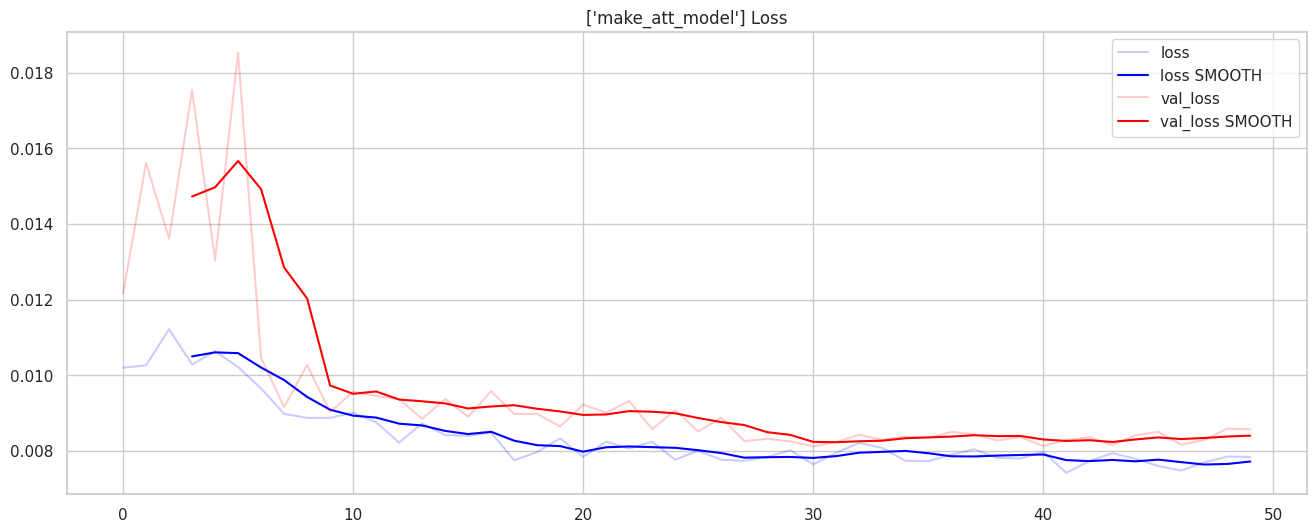

loading training log from /root/artem/analyser/training_reports/make_att_model.1.log.csv


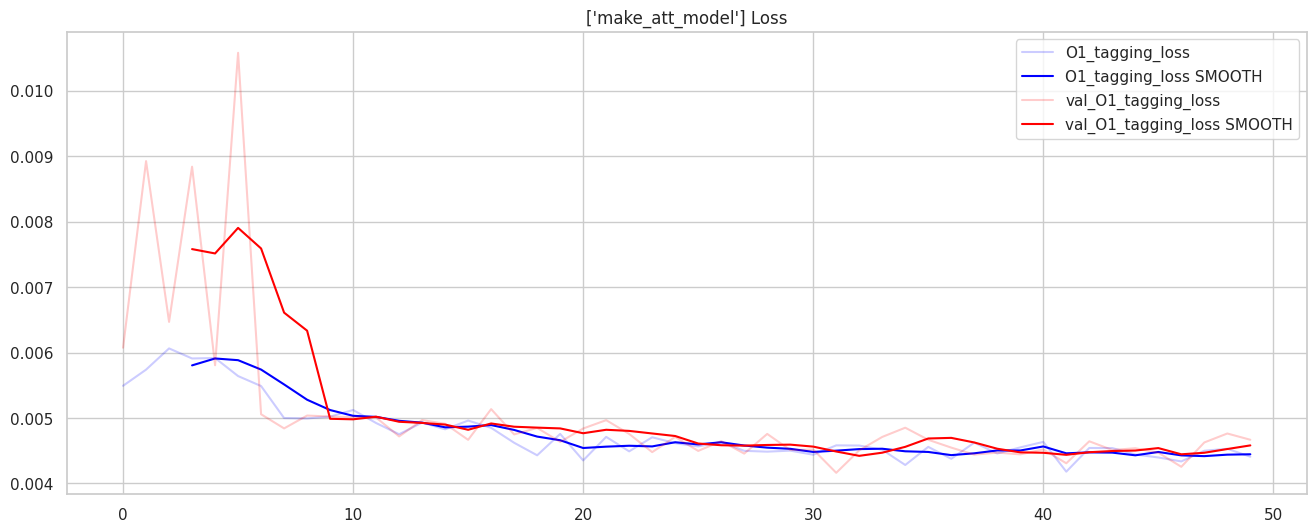

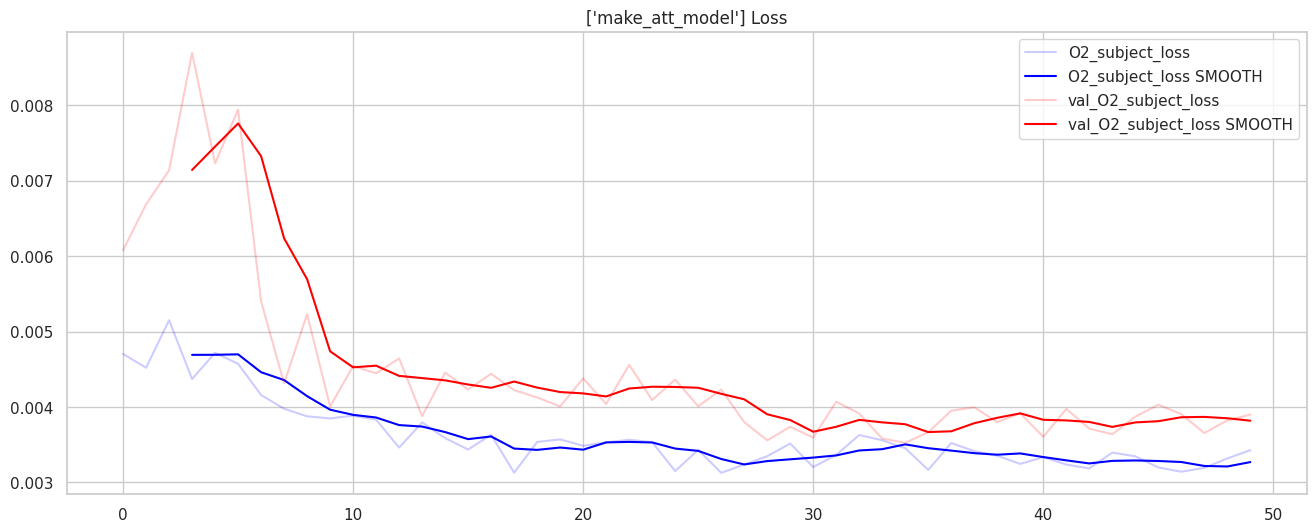

In [53]:
def plot_compare_models(
    models: [str],
    metrics, 
    title="metric/epoch",
    image_save_path = umtm.reports_dir):
    
  _metrics = [m for m in metrics if not m.startswith('val_')]

  for i, m in enumerate(models):

    data: pd.DataFrame = ctx.get_log(m)

    if data is not None:
      data.set_index('epoch')

      for metric in _metrics:
        plt.figure(figsize=(16, 6))
        plt.grid(True)
        plt.title(f'{metric} [{m}]')
        for metric_variant in ['', 'val_']:
          key = metric_variant + metric
          if key in data:

            x = data['epoch'][-100:]
            y = data[key][-100:]


            c = 'red'  # plt.cm.jet_r(i * colorstep)
            if metric_variant == '':
              c = 'blue'
            plt.plot(x, y, label=f'{key}', alpha=0.2, color=c)

            y = y.rolling(4, win_type='gaussian').mean(std=4)
            plt.plot(x, y, label=f'{key} SMOOTH', color=c)

            plt.legend(loc='upper right')

        
        plt.title(f'{[m]} {title}')
        plt.grid(True)
        img_path = os.path.join(image_save_path, f'{m}-{metric}.png')
        
        plt.savefig(img_path, bbox_inches='tight')        
        plt.show()
    else:
      logger.error('cannot plot')
    

models = list(ctx.trained_models.keys())


plot_compare_models(models, ['loss'], 'Loss')

# plot_compare_models(models, ['O1_tagging_kullback_leibler_divergence'], 'TAGS: Kullback Leibler divergence')
# plot_compare_models(models, ['O1_tagging_mse'], 'TAGS: MSE')
# plot_compare_models(models, ['O2_subject_kullback_leibler_divergence'], 'Subj: Kullback Leibler divergence')
# plot_compare_models(models, ['O2_subject_mse'],  'Subjects: MSE')

plot_compare_models(models, ['O1_tagging_loss', 'O2_subject_loss'], 'Loss')



## Contract subj Confusion matrices

In [54]:
# umtm.stats
# semantic_map_keys_contract


5ded4e284ddc27bcf92dd6ce


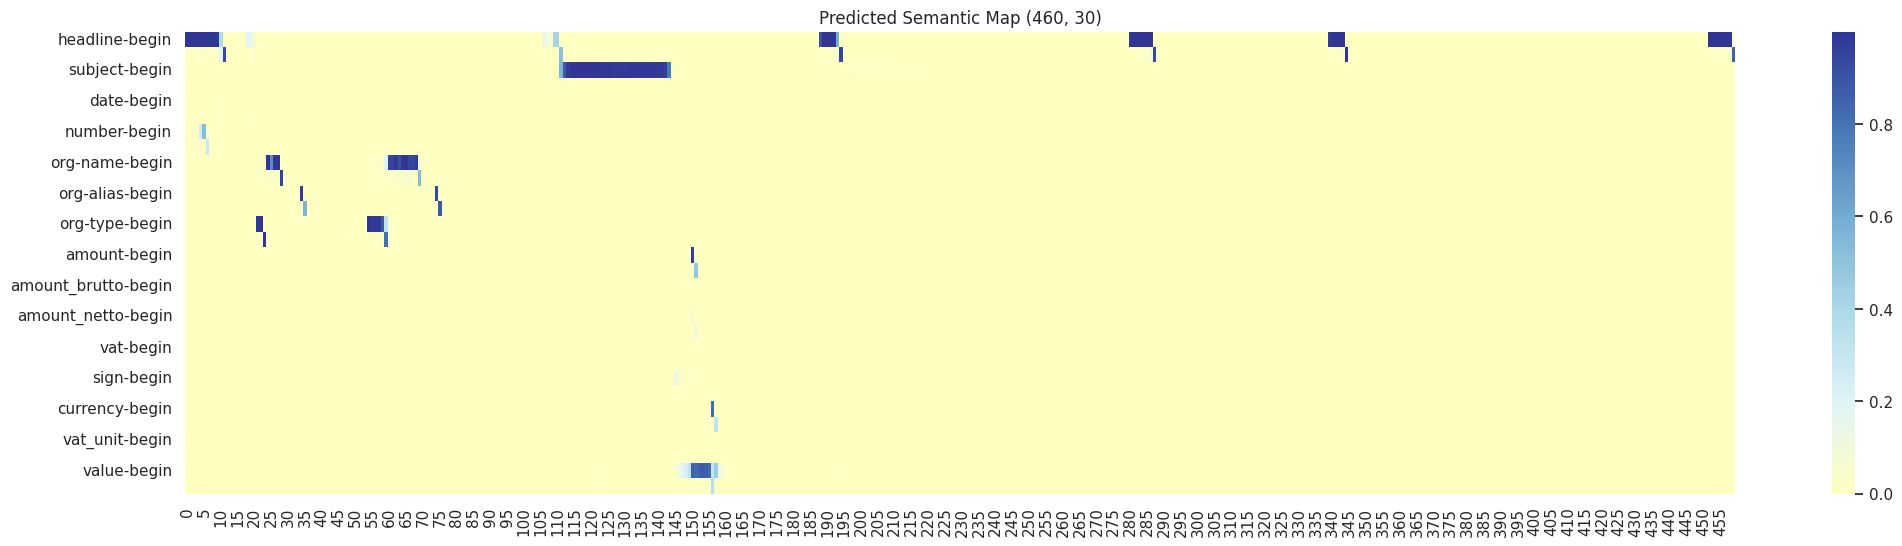

In [55]:
from tf_support.super_contract_model import make_xyw

sample_index = umtm.stats [umtm.stats['value']>0].index[2]
print(sample_index)

x, y, _ = make_xyw(sample_index, umtm.stats)

prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

tagsmap = pd.DataFrame(prediction[0][0], columns=semantic_map_keys_contract)
# .T
plot_embedding(tagsmap[:500], f'Predicted Semantic Map {tagsmap.shape}')

In [56]:
from analyser.contract_parser import nn_get_tag_values

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [57]:

agent_tags = ['org-1-name',
              'org-1-type',
              'org-1-alias',
              'org-2-name',
              'org-2-type',
              'org-2-alias']
solo_tags = [
  'date',
  'number',
  'sign_value_currency/value',
  'sign_value_currency/currency',
  'sign_value_currency/sign'
]

# seq_labels_contract[-3:]

tagnames = solo_tags + agent_tags


from pandas import DataFrame

from analyser.contract_agents import ContractAgent, normalize_contract_agent
from analyser.documents import TextMap
from analyser.ml_tools import SemanticTag
from analyser.persistence import DbJsonDoc
from analyser.text_tools import find_top_spans
# from tf_support.super_contract_model import seq_labels_contract
from tf_support.tf_subject_model import decode_subj_prediction

from analyser.contract_parser import nn_find_org_names, nn_get_tag_value




def fetch_tags_from_predicted_semantic_map(_id: str, tagsmap: DataFrame):
  jdoc = get_doc(_id)
  _map = jdoc.get_tokens_map_unchaged()

  results = {}
  for key in tagnames:
    t = nn_get_tag_value(key, _map, tagsmap )
    results[key] = t
    # print(t)

#   ca = ContractAgent()
#   ca.name =  results['org-1-name'] #TODO: check for NONE
#   ca.type =  results['org-1-type']
#   ca.alias = results['org-1-alias']
   

#   ca2 = ContractAgent()
#   ca2.name =  results['org-2-name'] #TODO: check for NONE
#   ca2.type =  results['org-2-type']
#   ca2.alias = results['org-2-alias']
#   try:
#     normalize_contract_agent(ca)
#     normalize_contract_agent(ca2)
#   except Exception as e:
#         # TODO:
#     logger.error(f'{_id} {e}')

  if results['number'] is not None:
    results['number'].value = results['number'].value.strip().lstrip('№').lstrip('N ').lstrip()

  return results, jdoc


def put_results_into_df(id_, results, df, jdoc: DbJsonDoc):
  org_atribs = ['name', 'alias', 'type']

  def v(x):
    if results[x] is not None:
      return results[x].value

  def swap(a, b):
    ab = [a, b]
    try:
      ab = sorted(ab)
    except:
      pass
    return ab

  def s(a, b):
    ab = swap(v(a), v(b))
    df.at[id_, f'p-{a}'] = ab[0]
    df.at[id_, f'p-{b}'] = ab[1]
    return ab

  for key in org_atribs:
    arr = s(f'org-1-{key}', f'org-2-{key}')

  def p(key):
    df.at[id_, f'p-{key}'] = v(key)

  p('sign_value_currency/value')
  p('sign_value_currency/currency')
  p('sign_value_currency/sign')

  p('date')
  p('number')

  # get_expected values
  for key in solo_tags:
    t = jdoc.get_attribute_value(key)
    df.at[id_, f'{key}'] = t

  for key in org_atribs:
    orgs = swap(jdoc.get_attribute_value(f'org-1-{key}'), jdoc.get_attribute_value(f'org-2-{key}'))
    df.at[id_, f'org-1-{key}'] = orgs[0]
    df.at[id_, f'org-2-{key}'] = orgs[1]



ImportError: cannot import name 'nn_get_tag_value' from 'analyser.contract_parser' (/root/artem/analyser/analyser/contract_parser.py)

In [ ]:
def make_subj_predictions(umodel, indices):
  ev = umtm.stats.copy()
  tags = pd.DataFrame()
  for t in tagnames:
    tags['p-' + t] = ''
    tags[t] = ''

  errors_report = pd.DataFrame()
  errors_report['expected'] = ''
  errors_report['predicted'] = ''

  for i, _id in enumerate(indices):
    logger.debug(f'validating {_id} {i} of {len(indices)}')
    
    x, y, _ = make_xyw(_id, umtm.stats)

    prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

    tagsmap = pd.DataFrame(prediction[0][0], columns=seq_labels_contract)
  
    r, jdoc = fetch_tags_from_predicted_semantic_map(_id, tagsmap)
    put_results_into_df(_id, r, tags, jdoc)
    

    subj_1hot = prediction[1][0]

    expected = decode_subj_prediction(y[1])[0]
    predicted = decode_subj_prediction(subj_1hot)[0]

    ev.at[_id, 'expected_subj'] = expected.name
    ev.at[_id, 'predicted_subj'] = predicted.name

    ev.at[_id, 'wrong'] = False
    if expected != predicted:
      ev.at[_id, 'wrong'] = True

  return ev, tags

ev, tags = make_subj_predictions(umodel, [sample_index])
tags

In [ ]:
%%time




# def fetch_tag_value(tagname: str, textmap: TextMap, tagging: DataFrame, threshold=0.3) -> SemanticTag or None:
#   att = tagging[tagname].values
#   slices = find_top_spans(att, threshold=threshold, limit=1) #TODO: estimate per-tag thresholds
  
#   if len(slices) > 0:
#     span = slices[0].start, slices[0].stop
#     value = textmap.text_range(span)
#     tag = SemanticTag(tagname, value, span)
#     tag.confidence = att[slices[0]].mean()
#     return tag
#   return None










subset = umtm.stats #umtm.stats[~pd.isna(umtm.stats['user_correction_date'])].sort_values('analyze_date')
_indices =  subset.index
ev, tags = make_subj_predictions(umodel, _indices)
tags.to_csv('all_contracts_predicstions.csv')

In [ ]:
# subset = umtm.stats[~pd.isna(umtm.stats['user_correction_date'])]
# pd.isna(umtm.stats['user_correction_date'])
ev 

In [ ]:
# _cols = [  'wrong' ]
# _tmp = ev[cols]
# errors_report = _tmp[ _tmp.wrong == True] #.sort_values('subject')
# print(len(errors_report), 'wrong subjects of', len(tags))
# errors_report 

ev['predicted_subj']
subj_df = ev[['predicted_subj', 'expected_subj']].copy()

In [ ]:
subj_df

In [ ]:
def make_report(umodel, ev):
  plot_cm(ev['expected_subj'], ev['predicted_subj'])
  
  img_path = os.path.join(umtm.work_dir, f'subjects-confusion-matrix-{umodel.name}.png')
  plt.savefig(img_path, bbox_inches='tight')

  report = classification_report(ev['expected_subj'], ev['predicted_subj'], digits=3)
  print(umodel.name)
  print(report)
  
  with open(os.path.join(umtm.work_dir, f'subjects-classification_report-{umodel.name}.txt'), "w") as text_file:
    text_file.write(report)


subj_df = ev[['predicted_subj', 'expected_subj']].copy() #ev[~pd.isna(ev['predicted_subj'])]
make_report(umodel, subj_df)

# Evaluate tags detection

In [ ]:
tags.fillna('-', inplace=True)
tags

In [ ]:
def save_csv(d, f):
    fn = os.path.join(umtm.work_dir, f)
    d.to_csv(fn)

### Contract number validation

In [ ]:
wrong_numbers = tags [ tags['number'] != tags['p-number']].sort_values('number')
print( f'Contract numbers: {len(wrong_numbers)} of {len(tags)}  ({100. * len(wrong_numbers) / len(tags) :0.1f}%) were detected wronggly')

save_csv( wrong_numbers[['p-number', 'number']], 'wrong_numbers.csv')

# wrong_numbers[['p-number', 'number']].tail(10)

In [ ]:
tags ['sign_value_currency/currency'].head(100)

In [ ]:
def conv(x):
    if type(x) is str:
        v = x.replace(',','.').replace(' ','')
    else: 
        v=x
    try:
        v=float(v)
    except:
        v=np.nan
    return v 

tags['n-p-sign_value_currency/value'] = pd.to_numeric( tags['p-sign_value_currency/value'].apply(conv) )
tags['n-sign_value_currency/value']   = pd.to_numeric( tags['sign_value_currency/value'].apply(conv) )

In [ ]:
wrong_values = tags [  tags['n-p-sign_value_currency/value']  != tags['n-sign_value_currency/value']]
cols = ['n-p-sign_value_currency/value', 'n-sign_value_currency/value']
wrong_values = wrong_values[cols]

wrong_values ['val_err'] = \
    np.log1p( np.abs(wrong_values['n-p-sign_value_currency/value'] - wrong_values['n-sign_value_currency/value']))
wrong_values = wrong_values.sort_values('val_err', ascending=False)

print(len(wrong_values))
wrong_values.tail(24)

### Contract Org-1 validation

In [ ]:


wrong_orgs1 = tags [ (tags['org-1-name'] != tags['p-org-1-name']) | (tags['org-2-name'] != tags['p-org-2-name']) ]
print( f'Org-1 name: {len(wrong_orgs1)} of {len(tags)}  ({100. * len(wrong_orgs1) / len(tags):0.1f}%) were detected incorrectly')

cols=['p-org-1-name', 'org-1-name', 'p-org-2-name', 'org-2-name']
save_csv( wrong_orgs1[cols], 'wrong_orgs1.csv')

wrong_orgs1[cols].head(20)

In [ ]:
wrong_aliases = tags [ (tags['org-1-alias'] != tags['p-org-1-alias']) | (tags['org-2-alias'] != tags['p-org-2-alias']) ]
print( f'Aliases: {len(wrong_aliases)} of {len(tags)}  ({100. * len(wrong_aliases) / len(tags) : 0.1f}%) were detected incorrectly')

cols=['p-org-1-alias', 'org-1-alias', 'p-org-2-alias', 'org-2-alias']
save_csv( wrong_aliases[cols], 'wrong_aliases.csv')
# wrong_aliases[cols].head(10)

In [ ]:
wrong_types = tags [ (tags['org-1-type'] != tags['p-org-1-type']) | (tags['org-2-type'] != tags['p-org-2-type'])]
print( f'Types: {len(wrong_types)} of {len(tags)}  ({100. * len(wrong_types) / len(tags) : 0.1f}%) were detected incorrectly')
cols=['p-org-1-type', 'p-org-2-type', 'org-1-type', 'org-2-type']
save_csv( wrong_types[cols], 'wrong_types.csv')
wrong_types[cols].head(10)

In [ ]:
from collections import Counter
arrays = [ wrong_orgs1, wrong_types, wrong_numbers, wrong_aliases]
counter = Counter()
for a in arrays:
  for i in a.index:
   counter[i]+=1
 

print('Самый сложный документ: ', counter.most_common()[0][0])
print("Всего недочетов:", len(counter))

In [ ]:
umtm.stats['errors'] = 0
for c in counter:
  umtm.stats.at[c, 'errors'] = counter[c]


calculate_samples_weights(umtm)
umtm._save_stats()
umtm.stats

## Single doc eval

In [ ]:
if IN_COLAB:
  !wget https://raw.githubusercontent.com/nemoware/analyser/uber-models/tests/contract_db_1.json

  with open('contract_db_1.json', 'rb') as handle:    
    jdata = json.load(handle, object_hook=json_util.object_hook)

  jdoc = DbJsonDoc(jdata)

else:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    logger.debug(f'fetching {objid}')
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata =  documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

  SAMPLE_DOC_ID = counter.most_common()[0][0] #umtm.stats.index[10]
    
    
    
  SAMPLE_DOC_ID = '5eea27adc28b75807f3dae66'
  print('SAMPLE_DOC_ID:', SAMPLE_DOC_ID)
  dp = umtm.make_xyw(SAMPLE_DOC_ID)
  (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

  jdoc = get_doc(SAMPLE_DOC_ID)

In [ ]:
from analyser.legal_docs import embedd_tokens

if IN_COLAB:
  embedder = ElmoEmbedder.get_instance('elmo')  # lazy init
  emb = embedd_tokens(jdoc.get_tokens_for_embedding(),
                             embedder,
                             verbosity=2,
                             log_key='tmp')

  tok_f = get_tokens_features(jdoc.get_tokens_map_unchaged().tokens)

In [ ]:
###############
prediction = umodel.predict(   x=[  np.expand_dims(emb, axis=0), np.expand_dims(tok_f, axis=0)] , batch_size=1)
##############
print(len(prediction), umodel.name)
subj_1hot = prediction[1][0]
print('Subject:', decode_subj_prediction(subj_1hot))


tagging = pd.DataFrame( prediction[0][0], columns=seq_labels_contract)
plot_embedding(tagging, title = f'Predictions of {umodel.name}')

In [ ]:
def render_slices(slices, tokens, attention_v, ht='') -> str:
  ht += '<ol>'
  for _s in slices:
    ht += '<li>'
    t = tokens[_s]
    l = attention_v[_s]
    ht += to_color_text(t, l, _range=(0, 1.2))
    ht += '<br><hr>'
    ht += '</li>'
  ht += '</ol>'

  return ht

for t in seq_labels_contract:
  spans = list( find_top_spans( tagging[t].values, threshold=0.3))  
  display(HTML(render_slices(spans, jdoc.get_tokens_map_unchaged().tokens, tagging[t].values)))


In [ ]:

# mean_ = tagging.values.max(-1)*0.5
# print (mean_.shape)
# display(HTML( to_color_text (jdoc.get_tokens_map_unchaged().tokens[:24000],  mean_[:24000])))

In [ ]:
ids = '5edbadd7da3678279fbcaabf
5edbc660da3678279fbcaeac
5edbc668da3678279fbcaf6e
5edbc65dda3678279fbcae56
5edbc66bda3678279fbcafe6
5edbc615da3678279fbcadc9'